In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
ϕ_list  = np.load(f"v_list_{λ}.npy")
ems_list = np.load(f"e_list_{λ}.npy")

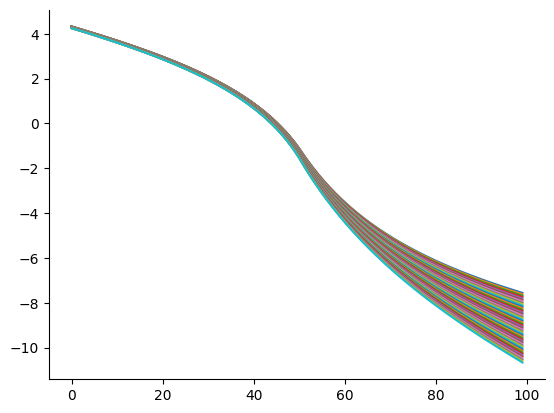

In [5]:
plt.plot(ϕ_list[18])
plt.show()

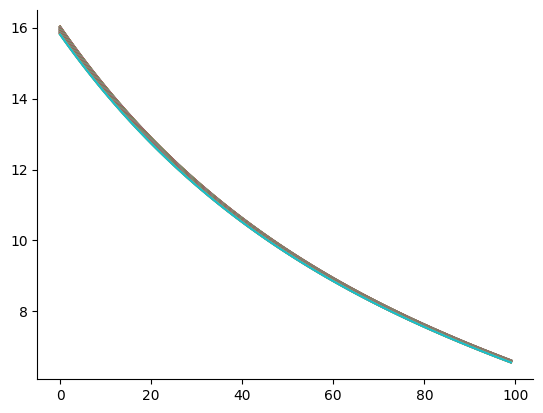

In [7]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [10]:
y1_grid_cap = np.arange(0., 2. + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.001
max_iter = 40_000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
ς = 0.01
Intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y1_mat_cap - 2)**2/(2*ς**2))*(y1_mat_cap <=2) + 1/(np.sqrt(2)*ς)*(y1_mat_cap>2)
# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][:loc_2+1]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 1. + ems_old * 0.
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.060851455984	 rhs error: 0.028312982582
Episode: 2	 lhs error: 0.062811057546	 rhs error: 0.025486933691
Episode: 3	 lhs error: 0.062682632312	 rhs error: 0.024791357804
Episode: 4	 lhs error: 0.062518534245	 rhs error: 0.024174101109
Episode: 5	 lhs error: 0.062355121561	 rhs error: 0.023596358566
Episode: 6	 lhs error: 0.062192794936	 rhs error: 0.023583869536
Episode: 7	 lhs error: 0.062031520817	 rhs error: 0.023600407957
Episode: 8	 lhs error: 0.061871259519	 rhs error: 0.023616924069
Episode: 9	 lhs error: 0.061711974001	 rhs error: 0.023633416820
Episode: 10	 lhs error: 0.061553629460	 rhs error: 0.023649885265
Episode: 11	 lhs error: 0.061396193229	 rhs error: 0.023666328525
Episode: 12	 lhs error: 0.061239634631	 rhs error: 0.023682745783
Episode: 13	 lhs error: 0.061083924860	 rhs error: 0.023699136284
Episode: 14	 lhs error: 0.060929036853	 rhs error: 0.023715499327
Episode: 15	 lhs error: 0.060774945187	 rhs error: 0.023731834261
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.046722823688	 rhs error: 0.025327511232
Episode: 126	 lhs error: 0.046615069932	 rhs error: 0.025340254898
Episode: 127	 lhs error: 0.046507622520	 rhs error: 0.025352969472
Episode: 128	 lhs error: 0.046400480433	 rhs error: 0.025365655029
Episode: 129	 lhs error: 0.046293642656	 rhs error: 0.025378311645
Episode: 130	 lhs error: 0.046187108178	 rhs error: 0.025390939392
Episode: 131	 lhs error: 0.046080875993	 rhs error: 0.025403538345
Episode: 132	 lhs error: 0.045974945100	 rhs error: 0.025416108578
Episode: 133	 lhs error: 0.045869314500	 rhs error: 0.025428650166
Episode: 134	 lhs error: 0.045763983201	 rhs error: 0.025441163180
Episode: 135	 lhs error: 0.045658950214	 rhs error: 0.025453647696
Episode: 136	 lhs error: 0.045554214553	 rhs error: 0.025466103785
Episode: 137	 lhs error: 0.045449775238	 rhs error: 0.025478531522
Episode: 138	 lhs error: 0.045345631292	 rhs error: 0.025490930978
Episode: 139	 lhs error: 0.045241781743	 rhs error: 0.02550330

Episode: 249	 lhs error: 0.035415930885	 rhs error: 0.026707339229
Episode: 250	 lhs error: 0.035339490523	 rhs error: 0.026716989428
Episode: 251	 lhs error: 0.035263255702	 rhs error: 0.026726618449
Episode: 252	 lhs error: 0.035187225778	 rhs error: 0.026736226345
Episode: 253	 lhs error: 0.035111400112	 rhs error: 0.026745813169
Episode: 254	 lhs error: 0.035035778064	 rhs error: 0.026755378975
Episode: 255	 lhs error: 0.034960358998	 rhs error: 0.026764923815
Episode: 256	 lhs error: 0.034885142280	 rhs error: 0.026774447742
Episode: 257	 lhs error: 0.034810127278	 rhs error: 0.026783950810
Episode: 258	 lhs error: 0.034735313362	 rhs error: 0.026793433071
Episode: 259	 lhs error: 0.034660699906	 rhs error: 0.026802894578
Episode: 260	 lhs error: 0.034586286283	 rhs error: 0.026812335383
Episode: 261	 lhs error: 0.034512071871	 rhs error: 0.026821755538
Episode: 262	 lhs error: 0.034438056050	 rhs error: 0.026831155096
Episode: 263	 lhs error: 0.034364238199	 rhs error: 0.02684053

Episode: 373	 lhs error: 0.027324776061	 rhs error: 0.027757767839
Episode: 374	 lhs error: 0.027269546524	 rhs error: 0.027765158129
Episode: 375	 lhs error: 0.027214457653	 rhs error: 0.027772532872
Episode: 376	 lhs error: 0.027159509029	 rhs error: 0.027779892107
Episode: 377	 lhs error: 0.027104700235	 rhs error: 0.027787235871
Episode: 378	 lhs error: 0.027050030854	 rhs error: 0.027794564202
Episode: 379	 lhs error: 0.026995500472	 rhs error: 0.027801877138
Episode: 380	 lhs error: 0.026941108675	 rhs error: 0.027809174716
Episode: 381	 lhs error: 0.026886855051	 rhs error: 0.027816456974
Episode: 382	 lhs error: 0.026832739190	 rhs error: 0.027823723950
Episode: 383	 lhs error: 0.026778760681	 rhs error: 0.027830975681
Episode: 384	 lhs error: 0.026724919118	 rhs error: 0.027838212203
Episode: 385	 lhs error: 0.026671214094	 rhs error: 0.027845433554
Episode: 386	 lhs error: 0.026617645204	 rhs error: 0.027852639772
Episode: 387	 lhs error: 0.026564212043	 rhs error: 0.02785983

Episode: 497	 lhs error: 0.021431236026	 rhs error: 0.028566489531
Episode: 498	 lhs error: 0.021390646647	 rhs error: 0.028572212480
Episode: 499	 lhs error: 0.021350155294	 rhs error: 0.028577923891
Episode: 500	 lhs error: 0.021309761690	 rhs error: 0.028583623791
Episode: 501	 lhs error: 0.021269465558	 rhs error: 0.028589312208
Episode: 502	 lhs error: 0.021229266620	 rhs error: 0.028594989168
Episode: 503	 lhs error: 0.021189164603	 rhs error: 0.028600654699
Episode: 504	 lhs error: 0.021149159230	 rhs error: 0.028606308826
Episode: 505	 lhs error: 0.021109250228	 rhs error: 0.028611951578
Episode: 506	 lhs error: 0.021069437325	 rhs error: 0.028617582981
Episode: 507	 lhs error: 0.021029720248	 rhs error: 0.028623203061
Episode: 508	 lhs error: 0.020990098726	 rhs error: 0.028628811845
Episode: 509	 lhs error: 0.020950572489	 rhs error: 0.028634409360
Episode: 510	 lhs error: 0.020911141269	 rhs error: 0.028639995632
Episode: 511	 lhs error: 0.020871804795	 rhs error: 0.02864557

Episode: 621	 lhs error: 0.017067181253	 rhs error: 0.029195940032
Episode: 622	 lhs error: 0.017036876508	 rhs error: 0.029200418890
Episode: 623	 lhs error: 0.017006641248	 rhs error: 0.029204889087
Episode: 624	 lhs error: 0.016976475286	 rhs error: 0.029209350643
Episode: 625	 lhs error: 0.016946378432	 rhs error: 0.029213803577
Episode: 626	 lhs error: 0.016916350502	 rhs error: 0.029218247908
Episode: 627	 lhs error: 0.016886391308	 rhs error: 0.029222683656
Episode: 628	 lhs error: 0.016856500664	 rhs error: 0.029227110841
Episode: 629	 lhs error: 0.016826678386	 rhs error: 0.029231529482
Episode: 630	 lhs error: 0.016796924290	 rhs error: 0.029235939597
Episode: 631	 lhs error: 0.016767238190	 rhs error: 0.029240341207
Episode: 632	 lhs error: 0.016737619905	 rhs error: 0.029244734331
Episode: 633	 lhs error: 0.016708069250	 rhs error: 0.029249118988
Episode: 634	 lhs error: 0.016678586043	 rhs error: 0.029253495196
Episode: 635	 lhs error: 0.016649170104	 rhs error: 0.02925786

Episode: 745	 lhs error: 0.013786010549	 rhs error: 0.029690906912
Episode: 746	 lhs error: 0.013763051116	 rhs error: 0.029694446920
Episode: 747	 lhs error: 0.013740141727	 rhs error: 0.029697980353
Episode: 748	 lhs error: 0.013717282253	 rhs error: 0.029701507227
Episode: 749	 lhs error: 0.013694472565	 rhs error: 0.029705027555
Episode: 750	 lhs error: 0.013671712536	 rhs error: 0.029708541351
Episode: 751	 lhs error: 0.013649002035	 rhs error: 0.029712048630
Episode: 752	 lhs error: 0.013626340937	 rhs error: 0.029715549406
Episode: 753	 lhs error: 0.013603729114	 rhs error: 0.029719043693
Episode: 754	 lhs error: 0.013581166438	 rhs error: 0.029722531505
Episode: 755	 lhs error: 0.013558652784	 rhs error: 0.029726012857
Episode: 756	 lhs error: 0.013536188024	 rhs error: 0.029729487762
Episode: 757	 lhs error: 0.013513772035	 rhs error: 0.029732956234
Episode: 758	 lhs error: 0.013491404689	 rhs error: 0.029736418287
Episode: 759	 lhs error: 0.013469085861	 rhs error: 0.02973987

Episode: 869	 lhs error: 0.011283928103	 rhs error: 0.030083857985
Episode: 870	 lhs error: 0.011266296425	 rhs error: 0.030086681747
Episode: 871	 lhs error: 0.011248701331	 rhs error: 0.030089500467
Episode: 872	 lhs error: 0.011231142729	 rhs error: 0.030092314154
Episode: 873	 lhs error: 0.011213620530	 rhs error: 0.030095122818
Episode: 874	 lhs error: 0.011196134645	 rhs error: 0.030097926472
Episode: 875	 lhs error: 0.011178684984	 rhs error: 0.030100725124
Episode: 876	 lhs error: 0.011161271457	 rhs error: 0.030103518785
Episode: 877	 lhs error: 0.011143893977	 rhs error: 0.030106307467
Episode: 878	 lhs error: 0.011126552453	 rhs error: 0.030109091179
Episode: 879	 lhs error: 0.011109246799	 rhs error: 0.030111869932
Episode: 880	 lhs error: 0.011091976924	 rhs error: 0.030114643735
Episode: 881	 lhs error: 0.011074742743	 rhs error: 0.030117412600
Episode: 882	 lhs error: 0.011057544166	 rhs error: 0.030120176537
Episode: 883	 lhs error: 0.011040381107	 rhs error: 0.03012293

Episode: 993	 lhs error: 0.009350832671	 rhs error: 0.030398598926
Episode: 994	 lhs error: 0.009337121557	 rhs error: 0.030400870649
Episode: 995	 lhs error: 0.009323437560	 rhs error: 0.030403138464
Episode: 996	 lhs error: 0.009309780618	 rhs error: 0.030405402381
Episode: 997	 lhs error: 0.009296150665	 rhs error: 0.030407662406
Episode: 998	 lhs error: 0.009282547638	 rhs error: 0.030409918548
Episode: 999	 lhs error: 0.009268971474	 rhs error: 0.030412170815
Episode: 1000	 lhs error: 0.009255422110	 rhs error: 0.030414419214
Episode: 1001	 lhs error: 0.009241899482	 rhs error: 0.030416663753
Episode: 1002	 lhs error: 0.009228403528	 rhs error: 0.030418904440
Episode: 1003	 lhs error: 0.009214934184	 rhs error: 0.030421141283
Episode: 1004	 lhs error: 0.009201491389	 rhs error: 0.030423374289
Episode: 1005	 lhs error: 0.009188075080	 rhs error: 0.030425603466
Episode: 1006	 lhs error: 0.009174685195	 rhs error: 0.030427828822
Episode: 1007	 lhs error: 0.009161321671	 rhs error: 0.

Episode: 1117	 lhs error: 0.007895559924	 rhs error: 0.030652783226
Episode: 1118	 lhs error: 0.007889122584	 rhs error: 0.030654625396
Episode: 1119	 lhs error: 0.007882690942	 rhs error: 0.030656464511
Episode: 1120	 lhs error: 0.007876265000	 rhs error: 0.030658300577
Episode: 1121	 lhs error: 0.007869844758	 rhs error: 0.030660133601
Episode: 1122	 lhs error: 0.007863430218	 rhs error: 0.030661963589
Episode: 1123	 lhs error: 0.007857021382	 rhs error: 0.030663790545
Episode: 1124	 lhs error: 0.007850618250	 rhs error: 0.030665614477
Episode: 1125	 lhs error: 0.007844220823	 rhs error: 0.030667435390
Episode: 1126	 lhs error: 0.007837829103	 rhs error: 0.030669253290
Episode: 1127	 lhs error: 0.007831443090	 rhs error: 0.030671068182
Episode: 1128	 lhs error: 0.007825062786	 rhs error: 0.030672880073
Episode: 1129	 lhs error: 0.007818688192	 rhs error: 0.030674688969
Episode: 1130	 lhs error: 0.007812319309	 rhs error: 0.030676494875
Episode: 1131	 lhs error: 0.007805956137	 rhs er

Episode: 1241	 lhs error: 0.007140874559	 rhs error: 0.030859646901
Episode: 1242	 lhs error: 0.007135143655	 rhs error: 0.030861151876
Episode: 1243	 lhs error: 0.007129418375	 rhs error: 0.030862654442
Episode: 1244	 lhs error: 0.007123698716	 rhs error: 0.030864154604
Episode: 1245	 lhs error: 0.007117984678	 rhs error: 0.030865652367
Episode: 1246	 lhs error: 0.007112276258	 rhs error: 0.030867147736
Episode: 1247	 lhs error: 0.007106573453	 rhs error: 0.030868640715
Episode: 1248	 lhs error: 0.007100876262	 rhs error: 0.030870131308
Episode: 1249	 lhs error: 0.007095184682	 rhs error: 0.030871619520
Episode: 1250	 lhs error: 0.007089498711	 rhs error: 0.030873105355
Episode: 1251	 lhs error: 0.007083818346	 rhs error: 0.030874588818
Episode: 1252	 lhs error: 0.007078143586	 rhs error: 0.030876069914
Episode: 1253	 lhs error: 0.007072474428	 rhs error: 0.030877548646
Episode: 1254	 lhs error: 0.007066810870	 rhs error: 0.030879025020
Episode: 1255	 lhs error: 0.007061152909	 rhs er

Episode: 1365	 lhs error: 0.006472319884	 rhs error: 0.031029219470
Episode: 1366	 lhs error: 0.006467265299	 rhs error: 0.031030457613
Episode: 1367	 lhs error: 0.006462215962	 rhs error: 0.031031693842
Episode: 1368	 lhs error: 0.006457171870	 rhs error: 0.031032928162
Episode: 1369	 lhs error: 0.006452133020	 rhs error: 0.031034160576
Episode: 1370	 lhs error: 0.006447099406	 rhs error: 0.031035391087
Episode: 1371	 lhs error: 0.006442071027	 rhs error: 0.031036619699
Episode: 1372	 lhs error: 0.006437047878	 rhs error: 0.031037846415
Episode: 1373	 lhs error: 0.006432029955	 rhs error: 0.031039071239
Episode: 1374	 lhs error: 0.006427017254	 rhs error: 0.031040294174
Episode: 1375	 lhs error: 0.006422009772	 rhs error: 0.031041515223
Episode: 1376	 lhs error: 0.006417007505	 rhs error: 0.031042734391
Episode: 1377	 lhs error: 0.006412010450	 rhs error: 0.031043951680
Episode: 1378	 lhs error: 0.006407018601	 rhs error: 0.031045167094
Episode: 1379	 lhs error: 0.006402031957	 rhs er

Episode: 1489	 lhs error: 0.005884367195	 rhs error: 0.031169178476
Episode: 1490	 lhs error: 0.005879933282	 rhs error: 0.031170203932
Episode: 1491	 lhs error: 0.005875504116	 rhs error: 0.031171227857
Episode: 1492	 lhs error: 0.005871079693	 rhs error: 0.031172250255
Episode: 1493	 lhs error: 0.005866660008	 rhs error: 0.031173271129
Episode: 1494	 lhs error: 0.005862245056	 rhs error: 0.031174290480
Episode: 1495	 lhs error: 0.005857834835	 rhs error: 0.031175308311
Episode: 1496	 lhs error: 0.005853429339	 rhs error: 0.031176324626
Episode: 1497	 lhs error: 0.005849028564	 rhs error: 0.031177339427
Episode: 1498	 lhs error: 0.005844632506	 rhs error: 0.031178352717
Episode: 1499	 lhs error: 0.005840241161	 rhs error: 0.031179364498
Episode: 1500	 lhs error: 0.005835854524	 rhs error: 0.031180374772
Episode: 1501	 lhs error: 0.005831472592	 rhs error: 0.031181383544
Episode: 1502	 lhs error: 0.005827095359	 rhs error: 0.031182390815
Episode: 1503	 lhs error: 0.005822722822	 rhs er

Episode: 1613	 lhs error: 0.005369428917	 rhs error: 0.031285458929
Episode: 1614	 lhs error: 0.005365550817	 rhs error: 0.031286313765
Episode: 1615	 lhs error: 0.005361676931	 rhs error: 0.031287167369
Episode: 1616	 lhs error: 0.005357807254	 rhs error: 0.031288019745
Episode: 1617	 lhs error: 0.005353941782	 rhs error: 0.031288870893
Episode: 1618	 lhs error: 0.005350080511	 rhs error: 0.031289720816
Episode: 1619	 lhs error: 0.005346223436	 rhs error: 0.031290569516
Episode: 1620	 lhs error: 0.005342370553	 rhs error: 0.031291416996
Episode: 1621	 lhs error: 0.005338521858	 rhs error: 0.031292263257
Episode: 1622	 lhs error: 0.005334677346	 rhs error: 0.031293108301
Episode: 1623	 lhs error: 0.005330837014	 rhs error: 0.031293952131
Episode: 1624	 lhs error: 0.005327000857	 rhs error: 0.031294794749
Episode: 1625	 lhs error: 0.005323168870	 rhs error: 0.031295636156
Episode: 1626	 lhs error: 0.005319341050	 rhs error: 0.031296476356
Episode: 1627	 lhs error: 0.005315517392	 rhs er

Episode: 1737	 lhs error: 0.004919365653	 rhs error: 0.031382692404
Episode: 1738	 lhs error: 0.004915977947	 rhs error: 0.031383409607
Episode: 1739	 lhs error: 0.004912593938	 rhs error: 0.031384125814
Episode: 1740	 lhs error: 0.004909213623	 rhs error: 0.031384841027
Episode: 1741	 lhs error: 0.004905836997	 rhs error: 0.031385555247
Episode: 1742	 lhs error: 0.004902464057	 rhs error: 0.031386268477
Episode: 1743	 lhs error: 0.004899094797	 rhs error: 0.031386980717
Episode: 1744	 lhs error: 0.004895729215	 rhs error: 0.031387691971
Episode: 1745	 lhs error: 0.004892367307	 rhs error: 0.031388402238
Episode: 1746	 lhs error: 0.004889009067	 rhs error: 0.031389111521
Episode: 1747	 lhs error: 0.004885654493	 rhs error: 0.031389819822
Episode: 1748	 lhs error: 0.004882303580	 rhs error: 0.031390527142
Episode: 1749	 lhs error: 0.004878956325	 rhs error: 0.031391233483
Episode: 1750	 lhs error: 0.004875612722	 rhs error: 0.031391938847
Episode: 1751	 lhs error: 0.004872272770	 rhs er

Episode: 1861	 lhs error: 0.004526267307	 rhs error: 0.031464526472
Episode: 1862	 lhs error: 0.004523308340	 rhs error: 0.031465132142
Episode: 1863	 lhs error: 0.004520352593	 rhs error: 0.031465737004
Episode: 1864	 lhs error: 0.004517400066	 rhs error: 0.031466341059
Episode: 1865	 lhs error: 0.004514450752	 rhs error: 0.031466944307
Episode: 1866	 lhs error: 0.004511504649	 rhs error: 0.031467546752
Episode: 1867	 lhs error: 0.004508561754	 rhs error: 0.031468148393
Episode: 1868	 lhs error: 0.004505622062	 rhs error: 0.031468749232
Episode: 1869	 lhs error: 0.004502685570	 rhs error: 0.031469349270
Episode: 1870	 lhs error: 0.004499752274	 rhs error: 0.031469948509
Episode: 1871	 lhs error: 0.004496822171	 rhs error: 0.031470546951
Episode: 1872	 lhs error: 0.004493895258	 rhs error: 0.031471144596
Episode: 1873	 lhs error: 0.004490971529	 rhs error: 0.031471741445
Episode: 1874	 lhs error: 0.004488050983	 rhs error: 0.031472337501
Episode: 1875	 lhs error: 0.004485133615	 rhs er

Episode: 1985	 lhs error: 0.004182826237	 rhs error: 0.031533859234
Episode: 1986	 lhs error: 0.004180240026	 rhs error: 0.031534374203
Episode: 1987	 lhs error: 0.004177656612	 rhs error: 0.031534888514
Episode: 1988	 lhs error: 0.004175075990	 rhs error: 0.031535402168
Episode: 1989	 lhs error: 0.004172498157	 rhs error: 0.031535915165
Episode: 1990	 lhs error: 0.004169923109	 rhs error: 0.031536427507
Episode: 1991	 lhs error: 0.004167350845	 rhs error: 0.031536939195
Episode: 1992	 lhs error: 0.004164781360	 rhs error: 0.031537450230
Episode: 1993	 lhs error: 0.004162214651	 rhs error: 0.031537960612
Episode: 1994	 lhs error: 0.004159650715	 rhs error: 0.031538470344
Episode: 1995	 lhs error: 0.004157089549	 rhs error: 0.031538979426
Episode: 1996	 lhs error: 0.004154531149	 rhs error: 0.031539487859
Episode: 1997	 lhs error: 0.004151975513	 rhs error: 0.031539995644
Episode: 1998	 lhs error: 0.004149422637	 rhs error: 0.031540502782
Episode: 1999	 lhs error: 0.004146872518	 rhs er

Episode: 2109	 lhs error: 0.003882484542	 rhs error: 0.031593013011
Episode: 2110	 lhs error: 0.003880221374	 rhs error: 0.031593454044
Episode: 2111	 lhs error: 0.003877960627	 rhs error: 0.031593894541
Episode: 2112	 lhs error: 0.003875702297	 rhs error: 0.031594334501
Episode: 2113	 lhs error: 0.003873446381	 rhs error: 0.031594773926
Episode: 2114	 lhs error: 0.003871192877	 rhs error: 0.031595212816
Episode: 2115	 lhs error: 0.003868941782	 rhs error: 0.031595651173
Episode: 2116	 lhs error: 0.003866693093	 rhs error: 0.031596088997
Episode: 2117	 lhs error: 0.003864446807	 rhs error: 0.031596526288
Episode: 2118	 lhs error: 0.003862202921	 rhs error: 0.031596963049
Episode: 2119	 lhs error: 0.003859961433	 rhs error: 0.031597399279
Episode: 2120	 lhs error: 0.003857722340	 rhs error: 0.031597834980
Episode: 2121	 lhs error: 0.003855485638	 rhs error: 0.031598270153
Episode: 2122	 lhs error: 0.003853251326	 rhs error: 0.031598704797
Episode: 2123	 lhs error: 0.003851019401	 rhs er

Episode: 2233	 lhs error: 0.003619459802	 rhs error: 0.031643864018
Episode: 2234	 lhs error: 0.003617476124	 rhs error: 0.031644244717
Episode: 2235	 lhs error: 0.003615494538	 rhs error: 0.031644624977
Episode: 2236	 lhs error: 0.003613515043	 rhs error: 0.031645004800
Episode: 2237	 lhs error: 0.003611537636	 rhs error: 0.031645384185
Episode: 2238	 lhs error: 0.003609562314	 rhs error: 0.031645763135
Episode: 2239	 lhs error: 0.003607589076	 rhs error: 0.031646141648
Episode: 2240	 lhs error: 0.003605617918	 rhs error: 0.031646519727
Episode: 2241	 lhs error: 0.003603648838	 rhs error: 0.031646897372
Episode: 2242	 lhs error: 0.003601681834	 rhs error: 0.031647274584
Episode: 2243	 lhs error: 0.003599716903	 rhs error: 0.031647651362
Episode: 2244	 lhs error: 0.003597754043	 rhs error: 0.031648027709
Episode: 2245	 lhs error: 0.003595793251	 rhs error: 0.031648403625
Episode: 2246	 lhs error: 0.003593834526	 rhs error: 0.031648779109
Episode: 2247	 lhs error: 0.003591877864	 rhs er

Episode: 2357	 lhs error: 0.003388708728	 rhs error: 0.031687939918
Episode: 2358	 lhs error: 0.003386966705	 rhs error: 0.031688271399
Episode: 2359	 lhs error: 0.003385226492	 rhs error: 0.031688602523
Episode: 2360	 lhs error: 0.003383488086	 rhs error: 0.031688933290
Episode: 2361	 lhs error: 0.003381751485	 rhs error: 0.031689263700
Episode: 2362	 lhs error: 0.003380016688	 rhs error: 0.031689593756
Episode: 2363	 lhs error: 0.003378283691	 rhs error: 0.031689923456
Episode: 2364	 lhs error: 0.003376552494	 rhs error: 0.031690252802
Episode: 2365	 lhs error: 0.003374823093	 rhs error: 0.031690581794
Episode: 2366	 lhs error: 0.003373095486	 rhs error: 0.031690910432
Episode: 2367	 lhs error: 0.003371369673	 rhs error: 0.031691238718
Episode: 2368	 lhs error: 0.003369645649	 rhs error: 0.031691566652
Episode: 2369	 lhs error: 0.003367923414	 rhs error: 0.031691894235
Episode: 2370	 lhs error: 0.003366202966	 rhs error: 0.031692221467
Episode: 2371	 lhs error: 0.003364484301	 rhs er

Episode: 2481	 lhs error: 0.003330323034	 rhs error: 0.031726493743
Episode: 2482	 lhs error: 0.003330126799	 rhs error: 0.031726785158
Episode: 2483	 lhs error: 0.003329930303	 rhs error: 0.031727076284
Episode: 2484	 lhs error: 0.003329733546	 rhs error: 0.031727367119
Episode: 2485	 lhs error: 0.003329536529	 rhs error: 0.031727657665
Episode: 2486	 lhs error: 0.003329339252	 rhs error: 0.031727947922
Episode: 2487	 lhs error: 0.003329141715	 rhs error: 0.031728237890
Episode: 2488	 lhs error: 0.003328943919	 rhs error: 0.031728527571
Episode: 2489	 lhs error: 0.003328745864	 rhs error: 0.031728816964
Episode: 2490	 lhs error: 0.003328547551	 rhs error: 0.031729106070
Episode: 2491	 lhs error: 0.003328348979	 rhs error: 0.031729394890
Episode: 2492	 lhs error: 0.003328150149	 rhs error: 0.031729683423
Episode: 2493	 lhs error: 0.003327951061	 rhs error: 0.031729971671
Episode: 2494	 lhs error: 0.003327751716	 rhs error: 0.031730259634
Episode: 2495	 lhs error: 0.003327552114	 rhs er

Episode: 2605	 lhs error: 0.003304098335	 rhs error: 0.031760560315
Episode: 2606	 lhs error: 0.003303872138	 rhs error: 0.031760819249
Episode: 2607	 lhs error: 0.003303645718	 rhs error: 0.031761077948
Episode: 2608	 lhs error: 0.003303419075	 rhs error: 0.031761336413
Episode: 2609	 lhs error: 0.003303192210	 rhs error: 0.031761594644
Episode: 2610	 lhs error: 0.003302965124	 rhs error: 0.031761852641
Episode: 2611	 lhs error: 0.003302737815	 rhs error: 0.031762110405
Episode: 2612	 lhs error: 0.003302510285	 rhs error: 0.031762367937
Episode: 2613	 lhs error: 0.003302282534	 rhs error: 0.031762625236
Episode: 2614	 lhs error: 0.003302054563	 rhs error: 0.031762882303
Episode: 2615	 lhs error: 0.003301826370	 rhs error: 0.031763139139
Episode: 2616	 lhs error: 0.003301597958	 rhs error: 0.031763395744
Episode: 2617	 lhs error: 0.003301369326	 rhs error: 0.031763652118
Episode: 2618	 lhs error: 0.003301140474	 rhs error: 0.031763908262
Episode: 2619	 lhs error: 0.003300911402	 rhs er

Episode: 2729	 lhs error: 0.003274437430	 rhs error: 0.031790999623
Episode: 2730	 lhs error: 0.003274185714	 rhs error: 0.031791232397
Episode: 2731	 lhs error: 0.003273933809	 rhs error: 0.031791464982
Episode: 2732	 lhs error: 0.003273681715	 rhs error: 0.031791697380
Episode: 2733	 lhs error: 0.003273429433	 rhs error: 0.031791929590
Episode: 2734	 lhs error: 0.003273176961	 rhs error: 0.031792161613
Episode: 2735	 lhs error: 0.003272924302	 rhs error: 0.031792393449
Episode: 2736	 lhs error: 0.003272671455	 rhs error: 0.031792625099
Episode: 2737	 lhs error: 0.003272418420	 rhs error: 0.031792856562
Episode: 2738	 lhs error: 0.003272165197	 rhs error: 0.031793087840
Episode: 2739	 lhs error: 0.003271911788	 rhs error: 0.031793318932
Episode: 2740	 lhs error: 0.003271658191	 rhs error: 0.031793549839
Episode: 2741	 lhs error: 0.003271404408	 rhs error: 0.031793780561
Episode: 2742	 lhs error: 0.003271150438	 rhs error: 0.031794011099
Episode: 2743	 lhs error: 0.003270896282	 rhs er

Episode: 2853	 lhs error: 0.003241858033	 rhs error: 0.031818530426
Episode: 2854	 lhs error: 0.003241584712	 rhs error: 0.031818742337
Episode: 2855	 lhs error: 0.003241311231	 rhs error: 0.031818954100
Episode: 2856	 lhs error: 0.003241037590	 rhs error: 0.031819165713
Episode: 2857	 lhs error: 0.003240763791	 rhs error: 0.031819377178
Episode: 2858	 lhs error: 0.003240489832	 rhs error: 0.031819588495
Episode: 2859	 lhs error: 0.003240215715	 rhs error: 0.031819799664
Episode: 2860	 lhs error: 0.003239941439	 rhs error: 0.031820010685
Episode: 2861	 lhs error: 0.003239667004	 rhs error: 0.031820221559
Episode: 2862	 lhs error: 0.003239392412	 rhs error: 0.031820432286
Episode: 2863	 lhs error: 0.003239117662	 rhs error: 0.031820642866
Episode: 2864	 lhs error: 0.003238842754	 rhs error: 0.031820853299
Episode: 2865	 lhs error: 0.003238567689	 rhs error: 0.031821063587
Episode: 2866	 lhs error: 0.003238292466	 rhs error: 0.031821273728
Episode: 2867	 lhs error: 0.003238017087	 rhs er

Episode: 2977	 lhs error: 0.003206815833	 rhs error: 0.031843756492
Episode: 2978	 lhs error: 0.003206524348	 rhs error: 0.031843952003
Episode: 2979	 lhs error: 0.003206232730	 rhs error: 0.031844147397
Episode: 2980	 lhs error: 0.003205940979	 rhs error: 0.031844342675
Episode: 2981	 lhs error: 0.003205649094	 rhs error: 0.031844537838
Episode: 2982	 lhs error: 0.003205357076	 rhs error: 0.031844732885
Episode: 2983	 lhs error: 0.003205064925	 rhs error: 0.031844927818
Episode: 2984	 lhs error: 0.003204772642	 rhs error: 0.031845122635
Episode: 2985	 lhs error: 0.003204480226	 rhs error: 0.031845317338
Episode: 2986	 lhs error: 0.003204187678	 rhs error: 0.031845511926
Episode: 2987	 lhs error: 0.003203894997	 rhs error: 0.031845706401
Episode: 2988	 lhs error: 0.003203602185	 rhs error: 0.031845900761
Episode: 2989	 lhs error: 0.003203309241	 rhs error: 0.031846095008
Episode: 2990	 lhs error: 0.003203016166	 rhs error: 0.031846289141
Episode: 2991	 lhs error: 0.003202722959	 rhs er

Episode: 3101	 lhs error: 0.003169711532	 rhs error: 0.031867187248
Episode: 3102	 lhs error: 0.003169404910	 rhs error: 0.031867370129
Episode: 3103	 lhs error: 0.003169098178	 rhs error: 0.031867552922
Episode: 3104	 lhs error: 0.003168791334	 rhs error: 0.031867735627
Episode: 3105	 lhs error: 0.003168484380	 rhs error: 0.031867918244
Episode: 3106	 lhs error: 0.003168177316	 rhs error: 0.031868100773
Episode: 3107	 lhs error: 0.003167870142	 rhs error: 0.031868283216
Episode: 3108	 lhs error: 0.003167562858	 rhs error: 0.031868465571
Episode: 3109	 lhs error: 0.003167255463	 rhs error: 0.031868647839
Episode: 3110	 lhs error: 0.003166947960	 rhs error: 0.031868830021
Episode: 3111	 lhs error: 0.003166640347	 rhs error: 0.031869012116
Episode: 3112	 lhs error: 0.003166332624	 rhs error: 0.031869194125
Episode: 3113	 lhs error: 0.003166024793	 rhs error: 0.031869376048
Episode: 3114	 lhs error: 0.003165716852	 rhs error: 0.031869557885
Episode: 3115	 lhs error: 0.003165408803	 rhs er

Episode: 3225	 lhs error: 0.003130897137	 rhs error: 0.031889254148
Episode: 3226	 lhs error: 0.003130578034	 rhs error: 0.031889427600
Episode: 3227	 lhs error: 0.003130258841	 rhs error: 0.031889600987
Episode: 3228	 lhs error: 0.003129939556	 rhs error: 0.031889774310
Episode: 3229	 lhs error: 0.003129620181	 rhs error: 0.031889947570
Episode: 3230	 lhs error: 0.003129300716	 rhs error: 0.031890120765
Episode: 3231	 lhs error: 0.003128981161	 rhs error: 0.031890293896
Episode: 3232	 lhs error: 0.003128661515	 rhs error: 0.031890466964
Episode: 3233	 lhs error: 0.003128341780	 rhs error: 0.031890639969
Episode: 3234	 lhs error: 0.003128021955	 rhs error: 0.031890812910
Episode: 3235	 lhs error: 0.003127702041	 rhs error: 0.031890985789
Episode: 3236	 lhs error: 0.003127382037	 rhs error: 0.031891158604
Episode: 3237	 lhs error: 0.003127061944	 rhs error: 0.031891331357
Episode: 3238	 lhs error: 0.003126741761	 rhs error: 0.031891504048
Episode: 3239	 lhs error: 0.003126421490	 rhs er

Episode: 3349	 lhs error: 0.003090681559	 rhs error: 0.031910323757
Episode: 3350	 lhs error: 0.003090352305	 rhs error: 0.031910490502
Episode: 3351	 lhs error: 0.003090022978	 rhs error: 0.031910657203
Episode: 3352	 lhs error: 0.003089693578	 rhs error: 0.031910823860
Episode: 3353	 lhs error: 0.003089364104	 rhs error: 0.031910990472
Episode: 3354	 lhs error: 0.003089034558	 rhs error: 0.031911157041
Episode: 3355	 lhs error: 0.003088704940	 rhs error: 0.031911323567
Episode: 3356	 lhs error: 0.003088375248	 rhs error: 0.031911490049
Episode: 3357	 lhs error: 0.003088045485	 rhs error: 0.031911656488
Episode: 3358	 lhs error: 0.003087715649	 rhs error: 0.031911822884
Episode: 3359	 lhs error: 0.003087385741	 rhs error: 0.031911989237
Episode: 3360	 lhs error: 0.003087055761	 rhs error: 0.031912155546
Episode: 3361	 lhs error: 0.003086725709	 rhs error: 0.031912321814
Episode: 3362	 lhs error: 0.003086395585	 rhs error: 0.031912488039
Episode: 3363	 lhs error: 0.003086065389	 rhs er

Episode: 3473	 lhs error: 0.003049335604	 rhs error: 0.031930708260
Episode: 3474	 lhs error: 0.003048998240	 rhs error: 0.031930870619
Episode: 3475	 lhs error: 0.003048660818	 rhs error: 0.031931032951
Episode: 3476	 lhs error: 0.003048323339	 rhs error: 0.031931195257
Episode: 3477	 lhs error: 0.003047985803	 rhs error: 0.031931357535
Episode: 3478	 lhs error: 0.003047648208	 rhs error: 0.031931519787
Episode: 3479	 lhs error: 0.003047310557	 rhs error: 0.031931682013
Episode: 3480	 lhs error: 0.003046972848	 rhs error: 0.031931844212
Episode: 3481	 lhs error: 0.003046635082	 rhs error: 0.031932006386
Episode: 3482	 lhs error: 0.003046297259	 rhs error: 0.031932168533
Episode: 3483	 lhs error: 0.003045959380	 rhs error: 0.031932330654
Episode: 3484	 lhs error: 0.003045621443	 rhs error: 0.031932492750
Episode: 3485	 lhs error: 0.003045283450	 rhs error: 0.031932654820
Episode: 3486	 lhs error: 0.003044945400	 rhs error: 0.031932816865
Episode: 3487	 lhs error: 0.003044607294	 rhs er

Episode: 3597	 lhs error: 0.003007096405	 rhs error: 0.031950673976
Episode: 3598	 lhs error: 0.003006752718	 rhs error: 0.031950833930
Episode: 3599	 lhs error: 0.003006408987	 rhs error: 0.031950993872
Episode: 3600	 lhs error: 0.003006065212	 rhs error: 0.031951153802
Episode: 3601	 lhs error: 0.003005721393	 rhs error: 0.031951313719
Episode: 3602	 lhs error: 0.003005377529	 rhs error: 0.031951473626
Episode: 3603	 lhs error: 0.003005033622	 rhs error: 0.031951633520
Episode: 3604	 lhs error: 0.003004689670	 rhs error: 0.031951793403
Episode: 3605	 lhs error: 0.003004345675	 rhs error: 0.031951953274
Episode: 3606	 lhs error: 0.003004001637	 rhs error: 0.031952113134
Episode: 3607	 lhs error: 0.003003657554	 rhs error: 0.031952272982
Episode: 3608	 lhs error: 0.003003313429	 rhs error: 0.031952432819
Episode: 3609	 lhs error: 0.003002969260	 rhs error: 0.031952592646
Episode: 3610	 lhs error: 0.003002625047	 rhs error: 0.031952752461
Episode: 3611	 lhs error: 0.003002280792	 rhs er

Episode: 3721	 lhs error: 0.002964171364	 rhs error: 0.031970448285
Episode: 3722	 lhs error: 0.002963822915	 rhs error: 0.031970607526
Episode: 3723	 lhs error: 0.002963474435	 rhs error: 0.031970766767
Episode: 3724	 lhs error: 0.002963125921	 rhs error: 0.031970926009
Episode: 3725	 lhs error: 0.002962777375	 rhs error: 0.031971085251
Episode: 3726	 lhs error: 0.002962428797	 rhs error: 0.031971244494
Episode: 3727	 lhs error: 0.002962080187	 rhs error: 0.031971403738
Episode: 3728	 lhs error: 0.002961731544	 rhs error: 0.031971562983
Episode: 3729	 lhs error: 0.002961382870	 rhs error: 0.031971722228
Episode: 3730	 lhs error: 0.002961034163	 rhs error: 0.031971881475
Episode: 3731	 lhs error: 0.002960685425	 rhs error: 0.031972040723
Episode: 3732	 lhs error: 0.002960336654	 rhs error: 0.031972199972
Episode: 3733	 lhs error: 0.002959987852	 rhs error: 0.031972359223
Episode: 3734	 lhs error: 0.002959639019	 rhs error: 0.031972518475
Episode: 3735	 lhs error: 0.002959290153	 rhs er

Episode: 3845	 lhs error: 0.002920741636	 rhs error: 0.031990225311
Episode: 3846	 lhs error: 0.002920389789	 rhs error: 0.031990385282
Episode: 3847	 lhs error: 0.002920037920	 rhs error: 0.031990545264
Episode: 3848	 lhs error: 0.002919686029	 rhs error: 0.031990705258
Episode: 3849	 lhs error: 0.002919334115	 rhs error: 0.031990865263
Episode: 3850	 lhs error: 0.002918982179	 rhs error: 0.031991025279
Episode: 3851	 lhs error: 0.002918630221	 rhs error: 0.031991185307
Episode: 3852	 lhs error: 0.002918278242	 rhs error: 0.031991345347
Episode: 3853	 lhs error: 0.002917926240	 rhs error: 0.031991505397
Episode: 3854	 lhs error: 0.002917574216	 rhs error: 0.031991665460
Episode: 3855	 lhs error: 0.002917222171	 rhs error: 0.031991825535
Episode: 3856	 lhs error: 0.002916870104	 rhs error: 0.031991985621
Episode: 3857	 lhs error: 0.002916518016	 rhs error: 0.031992145719
Episode: 3858	 lhs error: 0.002916165906	 rhs error: 0.031992305830
Episode: 3859	 lhs error: 0.002915813774	 rhs er

Episode: 3969	 lhs error: 0.002876965232	 rhs error: 0.032010170606
Episode: 3970	 lhs error: 0.002876611174	 rhs error: 0.032010332538
Episode: 3971	 lhs error: 0.002876257103	 rhs error: 0.032010494490
Episode: 3972	 lhs error: 0.002875903019	 rhs error: 0.032010656462
Episode: 3973	 lhs error: 0.002875548921	 rhs error: 0.032010818455
Episode: 3974	 lhs error: 0.002875194810	 rhs error: 0.032010980468
Episode: 3975	 lhs error: 0.002874840686	 rhs error: 0.032011142502
Episode: 3976	 lhs error: 0.002874486549	 rhs error: 0.032011304556
Episode: 3977	 lhs error: 0.002874132399	 rhs error: 0.032011466632
Episode: 3978	 lhs error: 0.002873778236	 rhs error: 0.032011628727
Episode: 3979	 lhs error: 0.002873424060	 rhs error: 0.032011790844
Episode: 3980	 lhs error: 0.002873069871	 rhs error: 0.032011952982
Episode: 3981	 lhs error: 0.002872715669	 rhs error: 0.032012115140
Episode: 3982	 lhs error: 0.002872361455	 rhs error: 0.032012277320
Episode: 3983	 lhs error: 0.002872007228	 rhs er

Episode: 4093	 lhs error: 0.002832979751	 rhs error: 0.032030425046
Episode: 4094	 lhs error: 0.002832624516	 rhs error: 0.032030589983
Episode: 4095	 lhs error: 0.002832269276	 rhs error: 0.032030754948
Episode: 4096	 lhs error: 0.002831914030	 rhs error: 0.032030919941
Episode: 4097	 lhs error: 0.002831558778	 rhs error: 0.032031084963
Episode: 4098	 lhs error: 0.002831203521	 rhs error: 0.032031250012
Episode: 4099	 lhs error: 0.002830848258	 rhs error: 0.032031415090
Episode: 4100	 lhs error: 0.002830492991	 rhs error: 0.032031580196
Episode: 4101	 lhs error: 0.002830137717	 rhs error: 0.032031745331
Episode: 4102	 lhs error: 0.002829782439	 rhs error: 0.032031910494
Episode: 4103	 lhs error: 0.002829427155	 rhs error: 0.032032075685
Episode: 4104	 lhs error: 0.002829071866	 rhs error: 0.032032240905
Episode: 4105	 lhs error: 0.002828716572	 rhs error: 0.032032406154
Episode: 4106	 lhs error: 0.002828361273	 rhs error: 0.032032571431
Episode: 4107	 lhs error: 0.002828005969	 rhs er

Episode: 4217	 lhs error: 0.002788904813	 rhs error: 0.032051108086
Episode: 4218	 lhs error: 0.002788549299	 rhs error: 0.032051276912
Episode: 4219	 lhs error: 0.002788193785	 rhs error: 0.032051445774
Episode: 4220	 lhs error: 0.002787838273	 rhs error: 0.032051614669
Episode: 4221	 lhs error: 0.002787482762	 rhs error: 0.032051783600
Episode: 4222	 lhs error: 0.002787127252	 rhs error: 0.032051952565
Episode: 4223	 lhs error: 0.002786771743	 rhs error: 0.032052121565
Episode: 4224	 lhs error: 0.002786416236	 rhs error: 0.032052290600
Episode: 4225	 lhs error: 0.002786060730	 rhs error: 0.032052459670
Episode: 4226	 lhs error: 0.002785705226	 rhs error: 0.032052628774
Episode: 4227	 lhs error: 0.002785349722	 rhs error: 0.032052797914
Episode: 4228	 lhs error: 0.002784994221	 rhs error: 0.032052967088
Episode: 4229	 lhs error: 0.002784638721	 rhs error: 0.032053136298
Episode: 4230	 lhs error: 0.002784283222	 rhs error: 0.032053305543
Episode: 4231	 lhs error: 0.002783927726	 rhs er

Episode: 4341	 lhs error: 0.002744844198	 rhs error: 0.032072320515
Episode: 4342	 lhs error: 0.002744489182	 rhs error: 0.032072493975
Episode: 4343	 lhs error: 0.002744134172	 rhs error: 0.032072667474
Episode: 4344	 lhs error: 0.002743779170	 rhs error: 0.032072841014
Episode: 4345	 lhs error: 0.002743424174	 rhs error: 0.032073014594
Episode: 4346	 lhs error: 0.002743069186	 rhs error: 0.032073188215
Episode: 4347	 lhs error: 0.002742714205	 rhs error: 0.032073361875
Episode: 4348	 lhs error: 0.002742359231	 rhs error: 0.032073535576
Episode: 4349	 lhs error: 0.002742004263	 rhs error: 0.032073709317
Episode: 4350	 lhs error: 0.002741649304	 rhs error: 0.032073883098
Episode: 4351	 lhs error: 0.002741294351	 rhs error: 0.032074056919
Episode: 4352	 lhs error: 0.002740939405	 rhs error: 0.032074230781
Episode: 4353	 lhs error: 0.002740584467	 rhs error: 0.032074404684
Episode: 4354	 lhs error: 0.002740229537	 rhs error: 0.032074578627
Episode: 4355	 lhs error: 0.002739874613	 rhs er

Episode: 4465	 lhs error: 0.002700887743	 rhs error: 0.032094146793
Episode: 4466	 lhs error: 0.002700533898	 rhs error: 0.032094325506
Episode: 4467	 lhs error: 0.002700180064	 rhs error: 0.032094504264
Episode: 4468	 lhs error: 0.002699826243	 rhs error: 0.032094683066
Episode: 4469	 lhs error: 0.002699472433	 rhs error: 0.032094861913
Episode: 4470	 lhs error: 0.002699118636	 rhs error: 0.032095040805
Episode: 4471	 lhs error: 0.002698764850	 rhs error: 0.032095219742
Episode: 4472	 lhs error: 0.002698411077	 rhs error: 0.032095398723
Episode: 4473	 lhs error: 0.002698057316	 rhs error: 0.032095577749
Episode: 4474	 lhs error: 0.002697703567	 rhs error: 0.032095756820
Episode: 4475	 lhs error: 0.002697349830	 rhs error: 0.032095935936
Episode: 4476	 lhs error: 0.002696996105	 rhs error: 0.032096115096
Episode: 4477	 lhs error: 0.002696642393	 rhs error: 0.032096294302
Episode: 4478	 lhs error: 0.002696288693	 rhs error: 0.032096473552
Episode: 4479	 lhs error: 0.002695935005	 rhs er

Episode: 4589	 lhs error: 0.002657113021	 rhs error: 0.032116657053
Episode: 4590	 lhs error: 0.002656760926	 rhs error: 0.032116841532
Episode: 4591	 lhs error: 0.002656408848	 rhs error: 0.032117026059
Episode: 4592	 lhs error: 0.002656056785	 rhs error: 0.032117210635
Episode: 4593	 lhs error: 0.002655704739	 rhs error: 0.032117395259
Episode: 4594	 lhs error: 0.002655352710	 rhs error: 0.032117579931
Episode: 4595	 lhs error: 0.002655000696	 rhs error: 0.032117764652
Episode: 4596	 lhs error: 0.002654648699	 rhs error: 0.032117949422
Episode: 4597	 lhs error: 0.002654296719	 rhs error: 0.032118134239
Episode: 4598	 lhs error: 0.002653944755	 rhs error: 0.032118319106
Episode: 4599	 lhs error: 0.002653592808	 rhs error: 0.032118504020
Episode: 4600	 lhs error: 0.002653240877	 rhs error: 0.032118688984
Episode: 4601	 lhs error: 0.002652888962	 rhs error: 0.032118873996
Episode: 4602	 lhs error: 0.002652537065	 rhs error: 0.032119059056
Episode: 4603	 lhs error: 0.002652185183	 rhs er

Episode: 4713	 lhs error: 0.002613586813	 rhs error: 0.032139908834
Episode: 4714	 lhs error: 0.002613236967	 rhs error: 0.032140099496
Episode: 4715	 lhs error: 0.002612887141	 rhs error: 0.032140290209
Episode: 4716	 lhs error: 0.002612537335	 rhs error: 0.032140480974
Episode: 4717	 lhs error: 0.002612187549	 rhs error: 0.032140671790
Episode: 4718	 lhs error: 0.002611837784	 rhs error: 0.032140862657
Episode: 4719	 lhs error: 0.002611488038	 rhs error: 0.032141053575
Episode: 4720	 lhs error: 0.002611138312	 rhs error: 0.032141244545
Episode: 4721	 lhs error: 0.002610788607	 rhs error: 0.032141435567
Episode: 4722	 lhs error: 0.002610438921	 rhs error: 0.032141626640
Episode: 4723	 lhs error: 0.002610089256	 rhs error: 0.032141817764
Episode: 4724	 lhs error: 0.002609739611	 rhs error: 0.032142008940
Episode: 4725	 lhs error: 0.002609389986	 rhs error: 0.032142200168
Episode: 4726	 lhs error: 0.002609040382	 rhs error: 0.032142391447
Episode: 4727	 lhs error: 0.002608690798	 rhs er

Episode: 4837	 lhs error: 0.002570366419	 rhs error: 0.032163948584
Episode: 4838	 lhs error: 0.002570019249	 rhs error: 0.032164145762
Episode: 4839	 lhs error: 0.002569672102	 rhs error: 0.032164342993
Episode: 4840	 lhs error: 0.002569324979	 rhs error: 0.032164540279
Episode: 4841	 lhs error: 0.002568977878	 rhs error: 0.032164737617
Episode: 4842	 lhs error: 0.002568630801	 rhs error: 0.032164935010
Episode: 4843	 lhs error: 0.002568283747	 rhs error: 0.032165132456
Episode: 4844	 lhs error: 0.002567936716	 rhs error: 0.032165329957
Episode: 4845	 lhs error: 0.002567589708	 rhs error: 0.032165527511
Episode: 4846	 lhs error: 0.002567242724	 rhs error: 0.032165725118
Episode: 4847	 lhs error: 0.002566895763	 rhs error: 0.032165922780
Episode: 4848	 lhs error: 0.002566548825	 rhs error: 0.032166120495
Episode: 4849	 lhs error: 0.002566201911	 rhs error: 0.032166318265
Episode: 4850	 lhs error: 0.002565855020	 rhs error: 0.032166516088
Episode: 4851	 lhs error: 0.002565508153	 rhs er

Episode: 4961	 lhs error: 0.002527500810	 rhs error: 0.032188812973
Episode: 4962	 lhs error: 0.002527156680	 rhs error: 0.032189016926
Episode: 4963	 lhs error: 0.002526812575	 rhs error: 0.032189220935
Episode: 4964	 lhs error: 0.002526468497	 rhs error: 0.032189424999
Episode: 4965	 lhs error: 0.002526124444	 rhs error: 0.032189629118
Episode: 4966	 lhs error: 0.002525780417	 rhs error: 0.032189833293
Episode: 4967	 lhs error: 0.002525436416	 rhs error: 0.032190037524
Episode: 4968	 lhs error: 0.002525092441	 rhs error: 0.032190241810
Episode: 4969	 lhs error: 0.002524748492	 rhs error: 0.032190446152
Episode: 4970	 lhs error: 0.002524404569	 rhs error: 0.032190650549
Episode: 4971	 lhs error: 0.002524060671	 rhs error: 0.032190855002
Episode: 4972	 lhs error: 0.002523716800	 rhs error: 0.032191059511
Episode: 4973	 lhs error: 0.002523372955	 rhs error: 0.032191264075
Episode: 4974	 lhs error: 0.002523029136	 rhs error: 0.032191468695
Episode: 4975	 lhs error: 0.002522685343	 rhs er

Episode: 5085	 lhs error: 0.002485031640	 rhs error: 0.032214530052
Episode: 5086	 lhs error: 0.002484690858	 rhs error: 0.032214740974
Episode: 5087	 lhs error: 0.002484350105	 rhs error: 0.032214951953
Episode: 5088	 lhs error: 0.002484009379	 rhs error: 0.032215162989
Episode: 5089	 lhs error: 0.002483668681	 rhs error: 0.032215374082
Episode: 5090	 lhs error: 0.002483328012	 rhs error: 0.032215585231
Episode: 5091	 lhs error: 0.002482987371	 rhs error: 0.032215796438
Episode: 5092	 lhs error: 0.002482646758	 rhs error: 0.032216007701
Episode: 5093	 lhs error: 0.002482306173	 rhs error: 0.032216219021
Episode: 5094	 lhs error: 0.002481965616	 rhs error: 0.032216430398
Episode: 5095	 lhs error: 0.002481625088	 rhs error: 0.032216641832
Episode: 5096	 lhs error: 0.002481284588	 rhs error: 0.032216853323
Episode: 5097	 lhs error: 0.002480944116	 rhs error: 0.032217064871
Episode: 5098	 lhs error: 0.002480603673	 rhs error: 0.032217276475
Episode: 5099	 lhs error: 0.002480263258	 rhs er

Episode: 5209	 lhs error: 0.002442994147	 rhs error: 0.032241120272
Episode: 5210	 lhs error: 0.002442656974	 rhs error: 0.032241338300
Episode: 5211	 lhs error: 0.002442319831	 rhs error: 0.032241556385
Episode: 5212	 lhs error: 0.002441982717	 rhs error: 0.032241774529
Episode: 5213	 lhs error: 0.002441645634	 rhs error: 0.032241992730
Episode: 5214	 lhs error: 0.002441308581	 rhs error: 0.032242210989
Episode: 5215	 lhs error: 0.002440971558	 rhs error: 0.032242429305
Episode: 5216	 lhs error: 0.002440634565	 rhs error: 0.032242647680
Episode: 5217	 lhs error: 0.002440297603	 rhs error: 0.032242866112
Episode: 5218	 lhs error: 0.002439960670	 rhs error: 0.032243084602
Episode: 5219	 lhs error: 0.002439623768	 rhs error: 0.032243303150
Episode: 5220	 lhs error: 0.002439286895	 rhs error: 0.032243521755
Episode: 5221	 lhs error: 0.002438950053	 rhs error: 0.032243740418
Episode: 5222	 lhs error: 0.002438613241	 rhs error: 0.032243959139
Episode: 5223	 lhs error: 0.002438276460	 rhs er

Episode: 5333	 lhs error: 0.002401417939	 rhs error: 0.032268597390
Episode: 5334	 lhs error: 0.002401084592	 rhs error: 0.032268822610
Episode: 5335	 lhs error: 0.002400751277	 rhs error: 0.032269047888
Episode: 5336	 lhs error: 0.002400417993	 rhs error: 0.032269273224
Episode: 5337	 lhs error: 0.002400084742	 rhs error: 0.032269498618
Episode: 5338	 lhs error: 0.002399751522	 rhs error: 0.032269724071
Episode: 5339	 lhs error: 0.002399418333	 rhs error: 0.032269949582
Episode: 5340	 lhs error: 0.002399085176	 rhs error: 0.032270175151
Episode: 5341	 lhs error: 0.002398752051	 rhs error: 0.032270400778
Episode: 5342	 lhs error: 0.002398418958	 rhs error: 0.032270626464
Episode: 5343	 lhs error: 0.002398085896	 rhs error: 0.032270852208
Episode: 5344	 lhs error: 0.002397752866	 rhs error: 0.032271078010
Episode: 5345	 lhs error: 0.002397419868	 rhs error: 0.032271303870
Episode: 5346	 lhs error: 0.002397086902	 rhs error: 0.032271529789
Episode: 5347	 lhs error: 0.002396753968	 rhs er

Episode: 5457	 lhs error: 0.002360327692	 rhs error: 0.032296969273
Episode: 5458	 lhs error: 0.002359998352	 rhs error: 0.032297201727
Episode: 5459	 lhs error: 0.002359669045	 rhs error: 0.032297434238
Episode: 5460	 lhs error: 0.002359339772	 rhs error: 0.032297666808
Episode: 5461	 lhs error: 0.002359010531	 rhs error: 0.032297899436
Episode: 5462	 lhs error: 0.002358681324	 rhs error: 0.032298132123
Episode: 5463	 lhs error: 0.002358352149	 rhs error: 0.032298364868
Episode: 5464	 lhs error: 0.002358023007	 rhs error: 0.032298597671
Episode: 5465	 lhs error: 0.002357693899	 rhs error: 0.032298830533
Episode: 5466	 lhs error: 0.002357364823	 rhs error: 0.032299063453
Episode: 5467	 lhs error: 0.002357035780	 rhs error: 0.032299296432
Episode: 5468	 lhs error: 0.002356706771	 rhs error: 0.032299529469
Episode: 5469	 lhs error: 0.002356377794	 rhs error: 0.032299762564
Episode: 5470	 lhs error: 0.002356048851	 rhs error: 0.032299995718
Episode: 5471	 lhs error: 0.002355719940	 rhs er

Episode: 5581	 lhs error: 0.002319743762	 rhs error: 0.032326238616
Episode: 5582	 lhs error: 0.002319418578	 rhs error: 0.032326478305
Episode: 5583	 lhs error: 0.002319093428	 rhs error: 0.032326718052
Episode: 5584	 lhs error: 0.002318768311	 rhs error: 0.032326957858
Episode: 5585	 lhs error: 0.002318443229	 rhs error: 0.032327197721
Episode: 5586	 lhs error: 0.002318118181	 rhs error: 0.032327437643
Episode: 5587	 lhs error: 0.002317793167	 rhs error: 0.032327677624
Episode: 5588	 lhs error: 0.002317468187	 rhs error: 0.032327917662
Episode: 5589	 lhs error: 0.002317143242	 rhs error: 0.032328157759
Episode: 5590	 lhs error: 0.002316818330	 rhs error: 0.032328397914
Episode: 5591	 lhs error: 0.002316493452	 rhs error: 0.032328638127
Episode: 5592	 lhs error: 0.002316168609	 rhs error: 0.032328878398
Episode: 5593	 lhs error: 0.002315843799	 rhs error: 0.032329118728
Episode: 5594	 lhs error: 0.002315519024	 rhs error: 0.032329359116
Episode: 5595	 lhs error: 0.002315194283	 rhs er

Episode: 5705	 lhs error: 0.002279682727	 rhs error: 0.032356403578
Episode: 5706	 lhs error: 0.002279361818	 rhs error: 0.032356650471
Episode: 5707	 lhs error: 0.002279040944	 rhs error: 0.032356897422
Episode: 5708	 lhs error: 0.002278720104	 rhs error: 0.032357144431
Episode: 5709	 lhs error: 0.002278399300	 rhs error: 0.032357391498
Episode: 5710	 lhs error: 0.002278078530	 rhs error: 0.032357638622
Episode: 5711	 lhs error: 0.002277757795	 rhs error: 0.032357885804
Episode: 5712	 lhs error: 0.002277437096	 rhs error: 0.032358133045
Episode: 5713	 lhs error: 0.002277116431	 rhs error: 0.032358380343
Episode: 5714	 lhs error: 0.002276795801	 rhs error: 0.032358627699
Episode: 5715	 lhs error: 0.002276475206	 rhs error: 0.032358875113
Episode: 5716	 lhs error: 0.002276154646	 rhs error: 0.032359122584
Episode: 5717	 lhs error: 0.002275834121	 rhs error: 0.032359370114
Episode: 5718	 lhs error: 0.002275513630	 rhs error: 0.032359617701
Episode: 5719	 lhs error: 0.002275193175	 rhs er

Episode: 5829	 lhs error: 0.002240157860	 rhs error: 0.032387458356
Episode: 5830	 lhs error: 0.002239841321	 rhs error: 0.032387712392
Episode: 5831	 lhs error: 0.002239524817	 rhs error: 0.032387966485
Episode: 5832	 lhs error: 0.002239208348	 rhs error: 0.032388220635
Episode: 5833	 lhs error: 0.002238891916	 rhs error: 0.032388474842
Episode: 5834	 lhs error: 0.002238575519	 rhs error: 0.032388729107
Episode: 5835	 lhs error: 0.002238259157	 rhs error: 0.032388983429
Episode: 5836	 lhs error: 0.002237942831	 rhs error: 0.032389237808
Episode: 5837	 lhs error: 0.002237626540	 rhs error: 0.032389492245
Episode: 5838	 lhs error: 0.002237310286	 rhs error: 0.032389746738
Episode: 5839	 lhs error: 0.002236994066	 rhs error: 0.032390001289
Episode: 5840	 lhs error: 0.002236677883	 rhs error: 0.032390255897
Episode: 5841	 lhs error: 0.002236361735	 rhs error: 0.032390510563
Episode: 5842	 lhs error: 0.002236045622	 rhs error: 0.032390765285
Episode: 5843	 lhs error: 0.002235729546	 rhs er

Episode: 5953	 lhs error: 0.002201179548	 rhs error: 0.032419393694
Episode: 5954	 lhs error: 0.002200867451	 rhs error: 0.032419654785
Episode: 5955	 lhs error: 0.002200555391	 rhs error: 0.032419915933
Episode: 5956	 lhs error: 0.002200243366	 rhs error: 0.032420177136
Episode: 5957	 lhs error: 0.002199931378	 rhs error: 0.032420438397
Episode: 5958	 lhs error: 0.002199619426	 rhs error: 0.032420699713
Episode: 5959	 lhs error: 0.002199307509	 rhs error: 0.032420961087
Episode: 5960	 lhs error: 0.002198995629	 rhs error: 0.032421222516
Episode: 5961	 lhs error: 0.002198683785	 rhs error: 0.032421484002
Episode: 5962	 lhs error: 0.002198371977	 rhs error: 0.032421745545
Episode: 5963	 lhs error: 0.002198060205	 rhs error: 0.032422007144
Episode: 5964	 lhs error: 0.002197748470	 rhs error: 0.032422268799
Episode: 5965	 lhs error: 0.002197436770	 rhs error: 0.032422530511
Episode: 5966	 lhs error: 0.002197125106	 rhs error: 0.032422792279
Episode: 5967	 lhs error: 0.002196813479	 rhs er

Episode: 6077	 lhs error: 0.002162755660	 rhs error: 0.032452197342
Episode: 6078	 lhs error: 0.002162448060	 rhs error: 0.032452465378
Episode: 6079	 lhs error: 0.002162140497	 rhs error: 0.032452733470
Episode: 6080	 lhs error: 0.002161832970	 rhs error: 0.032453001617
Episode: 6081	 lhs error: 0.002161525480	 rhs error: 0.032453269820
Episode: 6082	 lhs error: 0.002161218026	 rhs error: 0.032453538078
Episode: 6083	 lhs error: 0.002160910609	 rhs error: 0.032453806392
Episode: 6084	 lhs error: 0.002160603228	 rhs error: 0.032454074761
Episode: 6085	 lhs error: 0.002160295883	 rhs error: 0.032454343186
Episode: 6086	 lhs error: 0.002159988575	 rhs error: 0.032454611666
Episode: 6087	 lhs error: 0.002159681303	 rhs error: 0.032454880201
Episode: 6088	 lhs error: 0.002159374068	 rhs error: 0.032455148792
Episode: 6089	 lhs error: 0.002159066870	 rhs error: 0.032455417439
Episode: 6090	 lhs error: 0.002158759707	 rhs error: 0.032455686141
Episode: 6091	 lhs error: 0.002158452582	 rhs er

Episode: 6201	 lhs error: 0.002143464046	 rhs error: 0.032485854460
Episode: 6202	 lhs error: 0.002143439024	 rhs error: 0.032486129313
Episode: 6203	 lhs error: 0.002143413965	 rhs error: 0.032486404220
Episode: 6204	 lhs error: 0.002143388870	 rhs error: 0.032486679181
Episode: 6205	 lhs error: 0.002143363740	 rhs error: 0.032486954197
Episode: 6206	 lhs error: 0.002143338573	 rhs error: 0.032487229267
Episode: 6207	 lhs error: 0.002143313371	 rhs error: 0.032487504391
Episode: 6208	 lhs error: 0.002143288133	 rhs error: 0.032487779570
Episode: 6209	 lhs error: 0.002143262859	 rhs error: 0.032488054803
Episode: 6210	 lhs error: 0.002143237549	 rhs error: 0.032488330090
Episode: 6211	 lhs error: 0.002143212204	 rhs error: 0.032488605432
Episode: 6212	 lhs error: 0.002143186822	 rhs error: 0.032488880828
Episode: 6213	 lhs error: 0.002143161405	 rhs error: 0.032489156278
Episode: 6214	 lhs error: 0.002143135952	 rhs error: 0.032489431783
Episode: 6215	 lhs error: 0.002143110463	 rhs er

Episode: 6325	 lhs error: 0.002140090798	 rhs error: 0.032520347989
Episode: 6326	 lhs error: 0.002140061407	 rhs error: 0.032520629512
Episode: 6327	 lhs error: 0.002140031982	 rhs error: 0.032520911088
Episode: 6328	 lhs error: 0.002140002522	 rhs error: 0.032521192718
Episode: 6329	 lhs error: 0.002139973028	 rhs error: 0.032521474400
Episode: 6330	 lhs error: 0.002139943499	 rhs error: 0.032521756136
Episode: 6331	 lhs error: 0.002139913935	 rhs error: 0.032522037925
Episode: 6332	 lhs error: 0.002139884338	 rhs error: 0.032522319766
Episode: 6333	 lhs error: 0.002139854705	 rhs error: 0.032522601661
Episode: 6334	 lhs error: 0.002139825039	 rhs error: 0.032522883609
Episode: 6335	 lhs error: 0.002139795337	 rhs error: 0.032523165611
Episode: 6336	 lhs error: 0.002139765602	 rhs error: 0.032523447665
Episode: 6337	 lhs error: 0.002139735832	 rhs error: 0.032523729772
Episode: 6338	 lhs error: 0.002139706027	 rhs error: 0.032524011932
Episode: 6339	 lhs error: 0.002139676189	 rhs er

Episode: 6449	 lhs error: 0.002136982621	 rhs error: 0.032555658973
Episode: 6450	 lhs error: 0.002136956254	 rhs error: 0.032555947006
Episode: 6451	 lhs error: 0.002136929852	 rhs error: 0.032556235092
Episode: 6452	 lhs error: 0.002136903414	 rhs error: 0.032556523229
Episode: 6453	 lhs error: 0.002136876941	 rhs error: 0.032556811419
Episode: 6454	 lhs error: 0.002136850433	 rhs error: 0.032557099660
Episode: 6455	 lhs error: 0.002136823889	 rhs error: 0.032557387952
Episode: 6456	 lhs error: 0.002136797310	 rhs error: 0.032557676297
Episode: 6457	 lhs error: 0.002136770696	 rhs error: 0.032557964693
Episode: 6458	 lhs error: 0.002136744046	 rhs error: 0.032558253141
Episode: 6459	 lhs error: 0.002136717361	 rhs error: 0.032558541641
Episode: 6460	 lhs error: 0.002136690641	 rhs error: 0.032558830193
Episode: 6461	 lhs error: 0.002136663885	 rhs error: 0.032559118796
Episode: 6462	 lhs error: 0.002136637094	 rhs error: 0.032559407451
Episode: 6463	 lhs error: 0.002136610268	 rhs er

Episode: 6573	 lhs error: 0.002133446705	 rhs error: 0.032591766850
Episode: 6574	 lhs error: 0.002133416034	 rhs error: 0.032592061223
Episode: 6575	 lhs error: 0.002133385330	 rhs error: 0.032592355646
Episode: 6576	 lhs error: 0.002133354592	 rhs error: 0.032592650120
Episode: 6577	 lhs error: 0.002133323819	 rhs error: 0.032592944644
Episode: 6578	 lhs error: 0.002133293013	 rhs error: 0.032593239219
Episode: 6579	 lhs error: 0.002133262173	 rhs error: 0.032593533844
Episode: 6580	 lhs error: 0.002133231298	 rhs error: 0.032593828519
Episode: 6581	 lhs error: 0.002133200390	 rhs error: 0.032594123244
Episode: 6582	 lhs error: 0.002133169448	 rhs error: 0.032594418020
Episode: 6583	 lhs error: 0.002133138472	 rhs error: 0.032594712846
Episode: 6584	 lhs error: 0.002133107462	 rhs error: 0.032595007723
Episode: 6585	 lhs error: 0.002133076418	 rhs error: 0.032595302649
Episode: 6586	 lhs error: 0.002133045340	 rhs error: 0.032595597626
Episode: 6587	 lhs error: 0.002133014229	 rhs er

Episode: 6697	 lhs error: 0.002129387525	 rhs error: 0.032628649718
Episode: 6698	 lhs error: 0.002129352719	 rhs error: 0.032628950249
Episode: 6699	 lhs error: 0.002129317880	 rhs error: 0.032629250828
Episode: 6700	 lhs error: 0.002129283009	 rhs error: 0.032629551457
Episode: 6701	 lhs error: 0.002129248105	 rhs error: 0.032629852134
Episode: 6702	 lhs error: 0.002129213168	 rhs error: 0.032630152861
Episode: 6703	 lhs error: 0.002129178198	 rhs error: 0.032630453636
Episode: 6704	 lhs error: 0.002129143196	 rhs error: 0.032630754459
Episode: 6705	 lhs error: 0.002129108161	 rhs error: 0.032631055332
Episode: 6706	 lhs error: 0.002129073094	 rhs error: 0.032631356254
Episode: 6707	 lhs error: 0.002129037994	 rhs error: 0.032631657224
Episode: 6708	 lhs error: 0.002129002861	 rhs error: 0.032631958243
Episode: 6709	 lhs error: 0.002128967696	 rhs error: 0.032632259311
Episode: 6710	 lhs error: 0.002128932498	 rhs error: 0.032632560428
Episode: 6711	 lhs error: 0.002128897268	 rhs er

Episode: 6821	 lhs error: 0.002124825506	 rhs error: 0.032666284562
Episode: 6822	 lhs error: 0.002124786725	 rhs error: 0.032666591061
Episode: 6823	 lhs error: 0.002124747914	 rhs error: 0.032666897607
Episode: 6824	 lhs error: 0.002124709071	 rhs error: 0.032667204201
Episode: 6825	 lhs error: 0.002124670196	 rhs error: 0.032667510842
Episode: 6826	 lhs error: 0.002124631290	 rhs error: 0.032667817530
Episode: 6827	 lhs error: 0.002124592353	 rhs error: 0.032668124265
Episode: 6828	 lhs error: 0.002124553384	 rhs error: 0.032668431048
Episode: 6829	 lhs error: 0.002124514384	 rhs error: 0.032668737878
Episode: 6830	 lhs error: 0.002124475353	 rhs error: 0.032669044755
Episode: 6831	 lhs error: 0.002124436291	 rhs error: 0.032669351680
Episode: 6832	 lhs error: 0.002124397197	 rhs error: 0.032669658651
Episode: 6833	 lhs error: 0.002124358071	 rhs error: 0.032669965670
Episode: 6834	 lhs error: 0.002124318915	 rhs error: 0.032670272737
Episode: 6835	 lhs error: 0.002124279727	 rhs er

Episode: 6945	 lhs error: 0.002119780360	 rhs error: 0.032704647463
Episode: 6946	 lhs error: 0.002119737762	 rhs error: 0.032704959734
Episode: 6947	 lhs error: 0.002119695134	 rhs error: 0.032705272051
Episode: 6948	 lhs error: 0.002119652475	 rhs error: 0.032705584413
Episode: 6949	 lhs error: 0.002119609787	 rhs error: 0.032705896821
Episode: 6950	 lhs error: 0.002119567068	 rhs error: 0.032706209275
Episode: 6951	 lhs error: 0.002119524319	 rhs error: 0.032706521775
Episode: 6952	 lhs error: 0.002119481540	 rhs error: 0.032706834320
Episode: 6953	 lhs error: 0.002119438731	 rhs error: 0.032707146911
Episode: 6954	 lhs error: 0.002119395891	 rhs error: 0.032707459547
Episode: 6955	 lhs error: 0.002119353022	 rhs error: 0.032707772229
Episode: 6956	 lhs error: 0.002119310122	 rhs error: 0.032708084957
Episode: 6957	 lhs error: 0.002119267193	 rhs error: 0.032708397731
Episode: 6958	 lhs error: 0.002119224233	 rhs error: 0.032708710550
Episode: 6959	 lhs error: 0.002119181244	 rhs er

Episode: 7069	 lhs error: 0.002114271126	 rhs error: 0.032743713781
Episode: 7070	 lhs error: 0.002114224861	 rhs error: 0.032744031623
Episode: 7071	 lhs error: 0.002114178566	 rhs error: 0.032744349509
Episode: 7072	 lhs error: 0.002114132243	 rhs error: 0.032744667439
Episode: 7073	 lhs error: 0.002114085891	 rhs error: 0.032744985413
Episode: 7074	 lhs error: 0.002114039510	 rhs error: 0.032745303432
Episode: 7075	 lhs error: 0.002113993100	 rhs error: 0.032745621494
Episode: 7076	 lhs error: 0.002113946661	 rhs error: 0.032745939600
Episode: 7077	 lhs error: 0.002113900193	 rhs error: 0.032746257751
Episode: 7078	 lhs error: 0.002113853696	 rhs error: 0.032746575945
Episode: 7079	 lhs error: 0.002113807170	 rhs error: 0.032746894183
Episode: 7080	 lhs error: 0.002113760616	 rhs error: 0.032747212466
Episode: 7081	 lhs error: 0.002113714032	 rhs error: 0.032747530792
Episode: 7082	 lhs error: 0.002113667420	 rhs error: 0.032747849162
Episode: 7083	 lhs error: 0.002113620779	 rhs er

Episode: 7193	 lhs error: 0.002108316189	 rhs error: 0.032783458321
Episode: 7194	 lhs error: 0.002108266402	 rhs error: 0.032783781529
Episode: 7195	 lhs error: 0.002108216588	 rhs error: 0.032784104779
Episode: 7196	 lhs error: 0.002108166745	 rhs error: 0.032784428072
Episode: 7197	 lhs error: 0.002108116875	 rhs error: 0.032784751407
Episode: 7198	 lhs error: 0.002108066977	 rhs error: 0.032785074785
Episode: 7199	 lhs error: 0.002108017052	 rhs error: 0.032785398205
Episode: 7200	 lhs error: 0.002107967098	 rhs error: 0.032785721667
Episode: 7201	 lhs error: 0.002107917117	 rhs error: 0.032786045171
Episode: 7202	 lhs error: 0.002107867108	 rhs error: 0.032786368718
Episode: 7203	 lhs error: 0.002107817072	 rhs error: 0.032786692308
Episode: 7204	 lhs error: 0.002107767007	 rhs error: 0.032787015939
Episode: 7205	 lhs error: 0.002107716915	 rhs error: 0.032787339613
Episode: 7206	 lhs error: 0.002107666795	 rhs error: 0.032787663329
Episode: 7207	 lhs error: 0.002107616648	 rhs er

Episode: 7317	 lhs error: 0.002101933313	 rhs error: 0.032823855477
Episode: 7318	 lhs error: 0.002101880146	 rhs error: 0.032824183843
Episode: 7319	 lhs error: 0.002101826952	 rhs error: 0.032824512250
Episode: 7320	 lhs error: 0.002101773731	 rhs error: 0.032824840697
Episode: 7321	 lhs error: 0.002101720484	 rhs error: 0.032825169185
Episode: 7322	 lhs error: 0.002101667210	 rhs error: 0.032825497714
Episode: 7323	 lhs error: 0.002101613910	 rhs error: 0.032825826284
Episode: 7324	 lhs error: 0.002101560582	 rhs error: 0.032826154894
Episode: 7325	 lhs error: 0.002101507228	 rhs error: 0.032826483545
Episode: 7326	 lhs error: 0.002101453848	 rhs error: 0.032826812237
Episode: 7327	 lhs error: 0.002101400441	 rhs error: 0.032827140969
Episode: 7328	 lhs error: 0.002101347007	 rhs error: 0.032827469742
Episode: 7329	 lhs error: 0.002101293547	 rhs error: 0.032827798555
Episode: 7330	 lhs error: 0.002101240060	 rhs error: 0.032828127409
Episode: 7331	 lhs error: 0.002101186546	 rhs er

Episode: 7441	 lhs error: 0.002095139668	 rhs error: 0.032864879361
Episode: 7442	 lhs error: 0.002095083256	 rhs error: 0.032865212675
Episode: 7443	 lhs error: 0.002095026819	 rhs error: 0.032865546028
Episode: 7444	 lhs error: 0.002094970356	 rhs error: 0.032865879421
Episode: 7445	 lhs error: 0.002094913868	 rhs error: 0.032866212853
Episode: 7446	 lhs error: 0.002094857353	 rhs error: 0.032866546323
Episode: 7447	 lhs error: 0.002094800814	 rhs error: 0.032866879833
Episode: 7448	 lhs error: 0.002094744249	 rhs error: 0.032867213381
Episode: 7449	 lhs error: 0.002094687658	 rhs error: 0.032867546969
Episode: 7450	 lhs error: 0.002094631041	 rhs error: 0.032867880595
Episode: 7451	 lhs error: 0.002094574399	 rhs error: 0.032868214261
Episode: 7452	 lhs error: 0.002094517732	 rhs error: 0.032868547965
Episode: 7453	 lhs error: 0.002094461039	 rhs error: 0.032868881708
Episode: 7454	 lhs error: 0.002094404320	 rhs error: 0.032869215491
Episode: 7455	 lhs error: 0.002094347576	 rhs er

Episode: 7565	 lhs error: 0.002087951851	 rhs error: 0.032906503914
Episode: 7566	 lhs error: 0.002087892326	 rhs error: 0.032906841967
Episode: 7567	 lhs error: 0.002087832777	 rhs error: 0.032907180057
Episode: 7568	 lhs error: 0.002087773204	 rhs error: 0.032907518184
Episode: 7569	 lhs error: 0.002087713605	 rhs error: 0.032907856348
Episode: 7570	 lhs error: 0.002087653983	 rhs error: 0.032908194550
Episode: 7571	 lhs error: 0.002087594335	 rhs error: 0.032908532789
Episode: 7572	 lhs error: 0.002087534664	 rhs error: 0.032908871065
Episode: 7573	 lhs error: 0.002087474967	 rhs error: 0.032909209379
Episode: 7574	 lhs error: 0.002087415246	 rhs error: 0.032909547730
Episode: 7575	 lhs error: 0.002087355501	 rhs error: 0.032909886118
Episode: 7576	 lhs error: 0.002087295731	 rhs error: 0.032910224543
Episode: 7577	 lhs error: 0.002087235937	 rhs error: 0.032910563006
Episode: 7578	 lhs error: 0.002087176118	 rhs error: 0.032910901505
Episode: 7579	 lhs error: 0.002087116274	 rhs er

Episode: 7689	 lhs error: 0.002080385914	 rhs error: 0.032948703014
Episode: 7690	 lhs error: 0.002080323404	 rhs error: 0.032949045594
Episode: 7691	 lhs error: 0.002080260871	 rhs error: 0.032949388209
Episode: 7692	 lhs error: 0.002080198313	 rhs error: 0.032949730860
Episode: 7693	 lhs error: 0.002080135733	 rhs error: 0.032950073547
Episode: 7694	 lhs error: 0.002080073128	 rhs error: 0.032950416269
Episode: 7695	 lhs error: 0.002080010501	 rhs error: 0.032950759027
Episode: 7696	 lhs error: 0.002079947849	 rhs error: 0.032951101820
Episode: 7697	 lhs error: 0.002079885175	 rhs error: 0.032951444649
Episode: 7698	 lhs error: 0.002079822476	 rhs error: 0.032951787514
Episode: 7699	 lhs error: 0.002079759754	 rhs error: 0.032952130414
Episode: 7700	 lhs error: 0.002079697009	 rhs error: 0.032952473349
Episode: 7701	 lhs error: 0.002079634240	 rhs error: 0.032952816321
Episode: 7702	 lhs error: 0.002079571448	 rhs error: 0.032953159327
Episode: 7703	 lhs error: 0.002079508632	 rhs er

Episode: 7813	 lhs error: 0.002072457387	 rhs error: 0.032991450557
Episode: 7814	 lhs error: 0.002072392015	 rhs error: 0.032991797453
Episode: 7815	 lhs error: 0.002072326620	 rhs error: 0.032992144384
Episode: 7816	 lhs error: 0.002072261202	 rhs error: 0.032992491349
Episode: 7817	 lhs error: 0.002072195762	 rhs error: 0.032992838347
Episode: 7818	 lhs error: 0.002072130299	 rhs error: 0.032993185380
Episode: 7819	 lhs error: 0.002072064814	 rhs error: 0.032993532446
Episode: 7820	 lhs error: 0.002071999306	 rhs error: 0.032993879546
Episode: 7821	 lhs error: 0.002071933776	 rhs error: 0.032994226680
Episode: 7822	 lhs error: 0.002071868223	 rhs error: 0.032994573848
Episode: 7823	 lhs error: 0.002071802647	 rhs error: 0.032994921050
Episode: 7824	 lhs error: 0.002071737049	 rhs error: 0.032995268286
Episode: 7825	 lhs error: 0.002071671429	 rhs error: 0.032995615556
Episode: 7826	 lhs error: 0.002071605786	 rhs error: 0.032995962859
Episode: 7827	 lhs error: 0.002071540120	 rhs er

Episode: 7937	 lhs error: 0.002064181297	 rhs error: 0.033034720535
Episode: 7938	 lhs error: 0.002064113181	 rhs error: 0.033035071540
Episode: 7939	 lhs error: 0.002064045044	 rhs error: 0.033035422577
Episode: 7940	 lhs error: 0.002063976885	 rhs error: 0.033035773646
Episode: 7941	 lhs error: 0.002063908705	 rhs error: 0.033036124747
Episode: 7942	 lhs error: 0.002063840502	 rhs error: 0.033036475881
Episode: 7943	 lhs error: 0.002063772279	 rhs error: 0.033036827047
Episode: 7944	 lhs error: 0.002063704033	 rhs error: 0.033037178245
Episode: 7945	 lhs error: 0.002063635767	 rhs error: 0.033037529475
Episode: 7946	 lhs error: 0.002063567478	 rhs error: 0.033037880738
Episode: 7947	 lhs error: 0.002063499168	 rhs error: 0.033038232032
Episode: 7948	 lhs error: 0.002063430836	 rhs error: 0.033038583359
Episode: 7949	 lhs error: 0.002063362483	 rhs error: 0.033038934718
Episode: 7950	 lhs error: 0.002063294108	 rhs error: 0.033039286109
Episode: 7951	 lhs error: 0.002063225712	 rhs er

Episode: 8061	 lhs error: 0.002055572190	 rhs error: 0.033078487111
Episode: 8062	 lhs error: 0.002055501447	 rhs error: 0.033078842016
Episode: 8063	 lhs error: 0.002055430683	 rhs error: 0.033079196951
Episode: 8064	 lhs error: 0.002055359898	 rhs error: 0.033079551918
Episode: 8065	 lhs error: 0.002055289092	 rhs error: 0.033079906914
Episode: 8066	 lhs error: 0.002055218266	 rhs error: 0.033080261942
Episode: 8067	 lhs error: 0.002055147419	 rhs error: 0.033080617000
Episode: 8068	 lhs error: 0.002055076552	 rhs error: 0.033080972088
Episode: 8069	 lhs error: 0.002055005663	 rhs error: 0.033081327207
Episode: 8070	 lhs error: 0.002054934754	 rhs error: 0.033081682357
Episode: 8071	 lhs error: 0.002054863825	 rhs error: 0.033082037537
Episode: 8072	 lhs error: 0.002054792875	 rhs error: 0.033082392747
Episode: 8073	 lhs error: 0.002054721904	 rhs error: 0.033082747988
Episode: 8074	 lhs error: 0.002054650912	 rhs error: 0.033083103259
Episode: 8075	 lhs error: 0.002054579900	 rhs er

Episode: 8185	 lhs error: 0.002046644153	 rhs error: 0.033122724669
Episode: 8186	 lhs error: 0.002046570893	 rhs error: 0.033123083269
Episode: 8187	 lhs error: 0.002046497614	 rhs error: 0.033123441898
Episode: 8188	 lhs error: 0.002046424315	 rhs error: 0.033123800555
Episode: 8189	 lhs error: 0.002046350996	 rhs error: 0.033124159242
Episode: 8190	 lhs error: 0.002046277658	 rhs error: 0.033124517958
Episode: 8191	 lhs error: 0.002046204299	 rhs error: 0.033124876702
Episode: 8192	 lhs error: 0.002046130921	 rhs error: 0.033125235475
Episode: 8193	 lhs error: 0.002046057523	 rhs error: 0.033125594278
Episode: 8194	 lhs error: 0.002045984105	 rhs error: 0.033125953109
Episode: 8195	 lhs error: 0.002045910668	 rhs error: 0.033126311969
Episode: 8196	 lhs error: 0.002045837210	 rhs error: 0.033126670858
Episode: 8197	 lhs error: 0.002045763733	 rhs error: 0.033127029776
Episode: 8198	 lhs error: 0.002045690236	 rhs error: 0.033127388722
Episode: 8199	 lhs error: 0.002045616719	 rhs er

Episode: 8309	 lhs error: 0.002037410828	 rhs error: 0.033167407872
Episode: 8310	 lhs error: 0.002037335161	 rhs error: 0.033167769963
Episode: 8311	 lhs error: 0.002037259475	 rhs error: 0.033168132082
Episode: 8312	 lhs error: 0.002037183770	 rhs error: 0.033168494228
Episode: 8313	 lhs error: 0.002037108046	 rhs error: 0.033168856402
Episode: 8314	 lhs error: 0.002037032303	 rhs error: 0.033169218603
Episode: 8315	 lhs error: 0.002036956541	 rhs error: 0.033169580831
Episode: 8316	 lhs error: 0.002036880760	 rhs error: 0.033169943086
Episode: 8317	 lhs error: 0.002036804961	 rhs error: 0.033170305369
Episode: 8318	 lhs error: 0.002036729142	 rhs error: 0.033170667679
Episode: 8319	 lhs error: 0.002036653304	 rhs error: 0.033171030016
Episode: 8320	 lhs error: 0.002036577448	 rhs error: 0.033171392380
Episode: 8321	 lhs error: 0.002036501572	 rhs error: 0.033171754772
Episode: 8322	 lhs error: 0.002036425678	 rhs error: 0.033172117191
Episode: 8323	 lhs error: 0.002036349765	 rhs er

Episode: 8433	 lhs error: 0.002027885433	 rhs error: 0.033212511702
Episode: 8434	 lhs error: 0.002027807464	 rhs error: 0.033212877085
Episode: 8435	 lhs error: 0.002027729476	 rhs error: 0.033213242494
Episode: 8436	 lhs error: 0.002027651470	 rhs error: 0.033213607928
Episode: 8437	 lhs error: 0.002027573445	 rhs error: 0.033213973388
Episode: 8438	 lhs error: 0.002027495403	 rhs error: 0.033214338874
Episode: 8439	 lhs error: 0.002027417342	 rhs error: 0.033214704386
Episode: 8440	 lhs error: 0.002027339264	 rhs error: 0.033215069923
Episode: 8441	 lhs error: 0.002027261167	 rhs error: 0.033215435486
Episode: 8442	 lhs error: 0.002027183052	 rhs error: 0.033215801074
Episode: 8443	 lhs error: 0.002027104919	 rhs error: 0.033216166688
Episode: 8444	 lhs error: 0.002027026768	 rhs error: 0.033216532328
Episode: 8445	 lhs error: 0.002026948599	 rhs error: 0.033216897994
Episode: 8446	 lhs error: 0.002026870412	 rhs error: 0.033217263684
Episode: 8447	 lhs error: 0.002026792207	 rhs er

Episode: 8557	 lhs error: 0.002018080779	 rhs error: 0.033258011502
Episode: 8558	 lhs error: 0.002018000608	 rhs error: 0.033258379979
Episode: 8559	 lhs error: 0.002017920420	 rhs error: 0.033258748480
Episode: 8560	 lhs error: 0.002017840214	 rhs error: 0.033259117006
Episode: 8561	 lhs error: 0.002017759991	 rhs error: 0.033259485555
Episode: 8562	 lhs error: 0.002017679751	 rhs error: 0.033259854129
Episode: 8563	 lhs error: 0.002017599493	 rhs error: 0.033260222727
Episode: 8564	 lhs error: 0.002017519218	 rhs error: 0.033260591348
Episode: 8565	 lhs error: 0.002017438926	 rhs error: 0.033260959994
Episode: 8566	 lhs error: 0.002017358617	 rhs error: 0.033261328664
Episode: 8567	 lhs error: 0.002017278290	 rhs error: 0.033261697358
Episode: 8568	 lhs error: 0.002017197946	 rhs error: 0.033262066077
Episode: 8569	 lhs error: 0.002017117585	 rhs error: 0.033262434819
Episode: 8570	 lhs error: 0.002017037206	 rhs error: 0.033262803585
Episode: 8571	 lhs error: 0.002016956810	 rhs er

Episode: 8681	 lhs error: 0.002008009280	 rhs error: 0.033303883005
Episode: 8682	 lhs error: 0.002007927007	 rhs error: 0.033304254382
Episode: 8683	 lhs error: 0.002007844717	 rhs error: 0.033304625782
Episode: 8684	 lhs error: 0.002007762410	 rhs error: 0.033304997204
Episode: 8685	 lhs error: 0.002007680087	 rhs error: 0.033305368649
Episode: 8686	 lhs error: 0.002007597748	 rhs error: 0.033305740117
Episode: 8687	 lhs error: 0.002007515392	 rhs error: 0.033306111607
Episode: 8688	 lhs error: 0.002007433019	 rhs error: 0.033306483119
Episode: 8689	 lhs error: 0.002007350630	 rhs error: 0.033306854655
Episode: 8690	 lhs error: 0.002007268224	 rhs error: 0.033307226212
Episode: 8691	 lhs error: 0.002007185802	 rhs error: 0.033307597793
Episode: 8692	 lhs error: 0.002007103363	 rhs error: 0.033307969395
Episode: 8693	 lhs error: 0.002007020908	 rhs error: 0.033308341020
Episode: 8694	 lhs error: 0.002006938436	 rhs error: 0.033308712668
Episode: 8695	 lhs error: 0.002006855948	 rhs er

Episode: 8805	 lhs error: 0.001997682976	 rhs error: 0.033350102363
Episode: 8806	 lhs error: 0.001997598696	 rhs error: 0.033350476449
Episode: 8807	 lhs error: 0.001997514400	 rhs error: 0.033350850557
Episode: 8808	 lhs error: 0.001997430088	 rhs error: 0.033351224686
Episode: 8809	 lhs error: 0.001997345760	 rhs error: 0.033351598836
Episode: 8810	 lhs error: 0.001997261416	 rhs error: 0.033351973007
Episode: 8811	 lhs error: 0.001997177057	 rhs error: 0.033352347199
Episode: 8812	 lhs error: 0.001997092682	 rhs error: 0.033352721412
Episode: 8813	 lhs error: 0.001997008291	 rhs error: 0.033353095646
Episode: 8814	 lhs error: 0.001996923884	 rhs error: 0.033353469901
Episode: 8815	 lhs error: 0.001996839462	 rhs error: 0.033353844177
Episode: 8816	 lhs error: 0.001996755024	 rhs error: 0.033354218474
Episode: 8817	 lhs error: 0.001996670570	 rhs error: 0.033354592792
Episode: 8818	 lhs error: 0.001996586100	 rhs error: 0.033354967131
Episode: 8819	 lhs error: 0.001996501615	 rhs er

Episode: 8929	 lhs error: 0.001987113540	 rhs error: 0.033396646170
Episode: 8930	 lhs error: 0.001987027345	 rhs error: 0.033397022779
Episode: 8931	 lhs error: 0.001986941136	 rhs error: 0.033397399408
Episode: 8932	 lhs error: 0.001986854911	 rhs error: 0.033397776056
Episode: 8933	 lhs error: 0.001986768671	 rhs error: 0.033398152725
Episode: 8934	 lhs error: 0.001986682416	 rhs error: 0.033398529412
Episode: 8935	 lhs error: 0.001986596146	 rhs error: 0.033398906119
Episode: 8936	 lhs error: 0.001986509861	 rhs error: 0.033399282846
Episode: 8937	 lhs error: 0.001986423561	 rhs error: 0.033399659592
Episode: 8938	 lhs error: 0.001986337246	 rhs error: 0.033400036358
Episode: 8939	 lhs error: 0.001986250916	 rhs error: 0.033400413143
Episode: 8940	 lhs error: 0.001986164571	 rhs error: 0.033400789948
Episode: 8941	 lhs error: 0.001986078211	 rhs error: 0.033401166772
Episode: 8942	 lhs error: 0.001985991836	 rhs error: 0.033401543616
Episode: 8943	 lhs error: 0.001985905446	 rhs er

Episode: 9053	 lhs error: 0.001976312294	 rhs error: 0.033443491480
Episode: 9054	 lhs error: 0.001976224275	 rhs error: 0.033443870429
Episode: 9055	 lhs error: 0.001976136242	 rhs error: 0.033444249396
Episode: 9056	 lhs error: 0.001976048194	 rhs error: 0.033444628381
Episode: 9057	 lhs error: 0.001975960132	 rhs error: 0.033445007384
Episode: 9058	 lhs error: 0.001975872056	 rhs error: 0.033445386405
Episode: 9059	 lhs error: 0.001975783965	 rhs error: 0.033445765445
Episode: 9060	 lhs error: 0.001975695860	 rhs error: 0.033446144502
Episode: 9061	 lhs error: 0.001975607741	 rhs error: 0.033446523578
Episode: 9062	 lhs error: 0.001975519607	 rhs error: 0.033446902671
Episode: 9063	 lhs error: 0.001975431459	 rhs error: 0.033447281783
Episode: 9064	 lhs error: 0.001975343297	 rhs error: 0.033447660913
Episode: 9065	 lhs error: 0.001975255120	 rhs error: 0.033448040060
Episode: 9066	 lhs error: 0.001975166929	 rhs error: 0.033448419226
Episode: 9067	 lhs error: 0.001975078724	 rhs er

Episode: 9177	 lhs error: 0.001965290222	 rhs error: 0.033490615825
Episode: 9178	 lhs error: 0.001965200466	 rhs error: 0.033490996934
Episode: 9179	 lhs error: 0.001965110696	 rhs error: 0.033491378059
Episode: 9180	 lhs error: 0.001965020912	 rhs error: 0.033491759202
Episode: 9181	 lhs error: 0.001964931115	 rhs error: 0.033492140361
Episode: 9182	 lhs error: 0.001964841305	 rhs error: 0.033492521537
Episode: 9183	 lhs error: 0.001964751480	 rhs error: 0.033492902729
Episode: 9184	 lhs error: 0.001964661642	 rhs error: 0.033493283939
Episode: 9185	 lhs error: 0.001964571791	 rhs error: 0.033493665164
Episode: 9186	 lhs error: 0.001964481926	 rhs error: 0.033494046407
Episode: 9187	 lhs error: 0.001964392047	 rhs error: 0.033494427666
Episode: 9188	 lhs error: 0.001964302154	 rhs error: 0.033494808942
Episode: 9189	 lhs error: 0.001964212248	 rhs error: 0.033495190234
Episode: 9190	 lhs error: 0.001964122329	 rhs error: 0.033495571543
Episode: 9191	 lhs error: 0.001964032395	 rhs er

Episode: 9301	 lhs error: 0.001954057979	 rhs error: 0.033537997222
Episode: 9302	 lhs error: 0.001953966571	 rhs error: 0.033538380316
Episode: 9303	 lhs error: 0.001953875149	 rhs error: 0.033538763426
Episode: 9304	 lhs error: 0.001953783715	 rhs error: 0.033539146550
Episode: 9305	 lhs error: 0.001953692267	 rhs error: 0.033539529690
Episode: 9306	 lhs error: 0.001953600807	 rhs error: 0.033539912846
Episode: 9307	 lhs error: 0.001953509333	 rhs error: 0.033540296016
Episode: 9308	 lhs error: 0.001953417847	 rhs error: 0.033540679202
Episode: 9309	 lhs error: 0.001953326347	 rhs error: 0.033541062403
Episode: 9310	 lhs error: 0.001953234835	 rhs error: 0.033541445619
Episode: 9311	 lhs error: 0.001953143310	 rhs error: 0.033541828851
Episode: 9312	 lhs error: 0.001953051772	 rhs error: 0.033542212097
Episode: 9313	 lhs error: 0.001952960220	 rhs error: 0.033542595359
Episode: 9314	 lhs error: 0.001952868656	 rhs error: 0.033542978636
Episode: 9315	 lhs error: 0.001952777079	 rhs er

Episode: 9425	 lhs error: 0.001942625907	 rhs error: 0.033585614189
Episode: 9426	 lhs error: 0.001942532928	 rhs error: 0.033585999097
Episode: 9427	 lhs error: 0.001942439937	 rhs error: 0.033586384019
Episode: 9428	 lhs error: 0.001942346933	 rhs error: 0.033586768955
Episode: 9429	 lhs error: 0.001942253917	 rhs error: 0.033587153905
Episode: 9430	 lhs error: 0.001942160889	 rhs error: 0.033587538868
Episode: 9431	 lhs error: 0.001942067849	 rhs error: 0.033587923846
Episode: 9432	 lhs error: 0.001941974796	 rhs error: 0.033588308837
Episode: 9433	 lhs error: 0.001941881731	 rhs error: 0.033588693843
Episode: 9434	 lhs error: 0.001941788653	 rhs error: 0.033589078862
Episode: 9435	 lhs error: 0.001941695563	 rhs error: 0.033589463895
Episode: 9436	 lhs error: 0.001941602461	 rhs error: 0.033589848942
Episode: 9437	 lhs error: 0.001941509347	 rhs error: 0.033590234002
Episode: 9438	 lhs error: 0.001941416220	 rhs error: 0.033590619077
Episode: 9439	 lhs error: 0.001941323082	 rhs er

Episode: 9549	 lhs error: 0.001931004039	 rhs error: 0.033633445748
Episode: 9550	 lhs error: 0.001930909570	 rhs error: 0.033633832303
Episode: 9551	 lhs error: 0.001930815089	 rhs error: 0.033634218870
Episode: 9552	 lhs error: 0.001930720596	 rhs error: 0.033634605450
Episode: 9553	 lhs error: 0.001930626091	 rhs error: 0.033634992042
Episode: 9554	 lhs error: 0.001930531575	 rhs error: 0.033635378647
Episode: 9555	 lhs error: 0.001930437047	 rhs error: 0.033635765265
Episode: 9556	 lhs error: 0.001930342507	 rhs error: 0.033636151895
Episode: 9557	 lhs error: 0.001930247956	 rhs error: 0.033636538537
Episode: 9558	 lhs error: 0.001930153393	 rhs error: 0.033636925193
Episode: 9559	 lhs error: 0.001930058818	 rhs error: 0.033637311860
Episode: 9560	 lhs error: 0.001929964232	 rhs error: 0.033637698541
Episode: 9561	 lhs error: 0.001929869634	 rhs error: 0.033638085233
Episode: 9562	 lhs error: 0.001929775024	 rhs error: 0.033638471939
Episode: 9563	 lhs error: 0.001929680403	 rhs er

Episode: 9673	 lhs error: 0.001919202115	 rhs error: 0.033681471429
Episode: 9674	 lhs error: 0.001919106233	 rhs error: 0.033681859467
Episode: 9675	 lhs error: 0.001919010339	 rhs error: 0.033682247517
Episode: 9676	 lhs error: 0.001918914434	 rhs error: 0.033682635578
Episode: 9677	 lhs error: 0.001918818518	 rhs error: 0.033683023650
Episode: 9678	 lhs error: 0.001918722591	 rhs error: 0.033683411733
Episode: 9679	 lhs error: 0.001918626653	 rhs error: 0.033683799828
Episode: 9680	 lhs error: 0.001918530703	 rhs error: 0.033684187934
Episode: 9681	 lhs error: 0.001918434743	 rhs error: 0.033684576052
Episode: 9682	 lhs error: 0.001918338772	 rhs error: 0.033684964180
Episode: 9683	 lhs error: 0.001918242789	 rhs error: 0.033685352320
Episode: 9684	 lhs error: 0.001918146796	 rhs error: 0.033685740471
Episode: 9685	 lhs error: 0.001918050791	 rhs error: 0.033686128633
Episode: 9686	 lhs error: 0.001917954776	 rhs error: 0.033686516806
Episode: 9687	 lhs error: 0.001917858749	 rhs er

Episode: 9797	 lhs error: 0.001907229588	 rhs error: 0.033729671275
Episode: 9798	 lhs error: 0.001907132367	 rhs error: 0.033730060639
Episode: 9799	 lhs error: 0.001907035136	 rhs error: 0.033730450012
Episode: 9800	 lhs error: 0.001906937894	 rhs error: 0.033730839395
Episode: 9801	 lhs error: 0.001906840641	 rhs error: 0.033731228788
Episode: 9802	 lhs error: 0.001906743379	 rhs error: 0.033731618192
Episode: 9803	 lhs error: 0.001906646105	 rhs error: 0.033732007605
Episode: 9804	 lhs error: 0.001906548821	 rhs error: 0.033732397028
Episode: 9805	 lhs error: 0.001906451527	 rhs error: 0.033732786461
Episode: 9806	 lhs error: 0.001906354222	 rhs error: 0.033733175905
Episode: 9807	 lhs error: 0.001906256907	 rhs error: 0.033733565358
Episode: 9808	 lhs error: 0.001906159581	 rhs error: 0.033733954821
Episode: 9809	 lhs error: 0.001906062245	 rhs error: 0.033734344294
Episode: 9810	 lhs error: 0.001905964899	 rhs error: 0.033734733777
Episode: 9811	 lhs error: 0.001905867542	 rhs er

Episode: 9921	 lhs error: 0.001895095633	 rhs error: 0.033778025844
Episode: 9922	 lhs error: 0.001894997147	 rhs error: 0.033778416378
Episode: 9923	 lhs error: 0.001894898651	 rhs error: 0.033778806920
Episode: 9924	 lhs error: 0.001894800145	 rhs error: 0.033779197471
Episode: 9925	 lhs error: 0.001894701629	 rhs error: 0.033779588030
Episode: 9926	 lhs error: 0.001894603103	 rhs error: 0.033779978599
Episode: 9927	 lhs error: 0.001894504567	 rhs error: 0.033780369176
Episode: 9928	 lhs error: 0.001894406022	 rhs error: 0.033780759762
Episode: 9929	 lhs error: 0.001894307466	 rhs error: 0.033781150357
Episode: 9930	 lhs error: 0.001894208901	 rhs error: 0.033781540960
Episode: 9931	 lhs error: 0.001894110325	 rhs error: 0.033781931573
Episode: 9932	 lhs error: 0.001894011740	 rhs error: 0.033782322194
Episode: 9933	 lhs error: 0.001893913145	 rhs error: 0.033782712823
Episode: 9934	 lhs error: 0.001893814540	 rhs error: 0.033783103462
Episode: 9935	 lhs error: 0.001893715925	 rhs er

Episode: 10041	 lhs error: 0.001883207787	 rhs error: 0.033824950071
Episode: 10042	 lhs error: 0.001883108143	 rhs error: 0.033825341593
Episode: 10043	 lhs error: 0.001883008491	 rhs error: 0.033825733123
Episode: 10044	 lhs error: 0.001882908829	 rhs error: 0.033826124660
Episode: 10045	 lhs error: 0.001882809157	 rhs error: 0.033826516205
Episode: 10046	 lhs error: 0.001882709476	 rhs error: 0.033826907758
Episode: 10047	 lhs error: 0.001882609786	 rhs error: 0.033827299319
Episode: 10048	 lhs error: 0.001882510087	 rhs error: 0.033827690887
Episode: 10049	 lhs error: 0.001882410378	 rhs error: 0.033828082462
Episode: 10050	 lhs error: 0.001882310660	 rhs error: 0.033828474046
Episode: 10051	 lhs error: 0.001882210933	 rhs error: 0.033828865636
Episode: 10052	 lhs error: 0.001882111196	 rhs error: 0.033829257235
Episode: 10053	 lhs error: 0.001882011450	 rhs error: 0.033829648841
Episode: 10054	 lhs error: 0.001881911694	 rhs error: 0.033830040454
Episode: 10055	 lhs error: 0.00188

Episode: 10161	 lhs error: 0.001871184942	 rhs error: 0.033871984767
Episode: 10162	 lhs error: 0.001871084206	 rhs error: 0.033872377140
Episode: 10163	 lhs error: 0.001870983461	 rhs error: 0.033872769521
Episode: 10164	 lhs error: 0.001870882707	 rhs error: 0.033873161908
Episode: 10165	 lhs error: 0.001870781945	 rhs error: 0.033873554301
Episode: 10166	 lhs error: 0.001870681174	 rhs error: 0.033873946701
Episode: 10167	 lhs error: 0.001870580393	 rhs error: 0.033874339108
Episode: 10168	 lhs error: 0.001870479604	 rhs error: 0.033874731521
Episode: 10169	 lhs error: 0.001870378807	 rhs error: 0.033875123940
Episode: 10170	 lhs error: 0.001870278000	 rhs error: 0.033875516366
Episode: 10171	 lhs error: 0.001870177185	 rhs error: 0.033875908798
Episode: 10172	 lhs error: 0.001870076361	 rhs error: 0.033876301237
Episode: 10173	 lhs error: 0.001869975528	 rhs error: 0.033876693682
Episode: 10174	 lhs error: 0.001869874686	 rhs error: 0.033877086134
Episode: 10175	 lhs error: 0.00186

Episode: 10281	 lhs error: 0.001859034717	 rhs error: 0.033919113678
Episode: 10282	 lhs error: 0.001858932951	 rhs error: 0.033919506770
Episode: 10283	 lhs error: 0.001858831176	 rhs error: 0.033919899867
Episode: 10284	 lhs error: 0.001858729394	 rhs error: 0.033920292970
Episode: 10285	 lhs error: 0.001858627603	 rhs error: 0.033920686078
Episode: 10286	 lhs error: 0.001858525803	 rhs error: 0.033921079192
Episode: 10287	 lhs error: 0.001858423995	 rhs error: 0.033921472311
Episode: 10288	 lhs error: 0.001858322180	 rhs error: 0.033921865435
Episode: 10289	 lhs error: 0.001858220355	 rhs error: 0.033922258565
Episode: 10290	 lhs error: 0.001858118523	 rhs error: 0.033922651700
Episode: 10291	 lhs error: 0.001858016682	 rhs error: 0.033923044841
Episode: 10292	 lhs error: 0.001857914833	 rhs error: 0.033923437987
Episode: 10293	 lhs error: 0.001857812975	 rhs error: 0.033923831138
Episode: 10294	 lhs error: 0.001857711109	 rhs error: 0.033924224295
Episode: 10295	 lhs error: 0.00185

Episode: 10401	 lhs error: 0.001846764514	 rhs error: 0.033966320992
Episode: 10402	 lhs error: 0.001846661778	 rhs error: 0.033966714673
Episode: 10403	 lhs error: 0.001846559035	 rhs error: 0.033967108357
Episode: 10404	 lhs error: 0.001846456284	 rhs error: 0.033967502046
Episode: 10405	 lhs error: 0.001846353525	 rhs error: 0.033967895739
Episode: 10406	 lhs error: 0.001846250759	 rhs error: 0.033968289437
Episode: 10407	 lhs error: 0.001846147984	 rhs error: 0.033968683139
Episode: 10408	 lhs error: 0.001846045202	 rhs error: 0.033969076845
Episode: 10409	 lhs error: 0.001845942412	 rhs error: 0.033969470555
Episode: 10410	 lhs error: 0.001845839614	 rhs error: 0.033969864270
Episode: 10411	 lhs error: 0.001845736808	 rhs error: 0.033970257989
Episode: 10412	 lhs error: 0.001845633995	 rhs error: 0.033970651713
Episode: 10413	 lhs error: 0.001845531173	 rhs error: 0.033971045440
Episode: 10414	 lhs error: 0.001845428344	 rhs error: 0.033971439172
Episode: 10415	 lhs error: 0.00184

Episode: 10521	 lhs error: 0.001834381526	 rhs error: 0.034013591338
Episode: 10522	 lhs error: 0.001834277880	 rhs error: 0.034013985480
Episode: 10523	 lhs error: 0.001834174227	 rhs error: 0.034014379626
Episode: 10524	 lhs error: 0.001834070567	 rhs error: 0.034014773775
Episode: 10525	 lhs error: 0.001833966899	 rhs error: 0.034015167927
Episode: 10526	 lhs error: 0.001833863224	 rhs error: 0.034015562082
Episode: 10527	 lhs error: 0.001833759542	 rhs error: 0.034015956240
Episode: 10528	 lhs error: 0.001833655852	 rhs error: 0.034016350402
Episode: 10529	 lhs error: 0.001833552155	 rhs error: 0.034016744568
Episode: 10530	 lhs error: 0.001833448451	 rhs error: 0.034017138736
Episode: 10531	 lhs error: 0.001833344740	 rhs error: 0.034017532908
Episode: 10532	 lhs error: 0.001833241021	 rhs error: 0.034017927083
Episode: 10533	 lhs error: 0.001833137294	 rhs error: 0.034018321261
Episode: 10534	 lhs error: 0.001833033561	 rhs error: 0.034018715442
Episode: 10535	 lhs error: 0.00183

Episode: 10641	 lhs error: 0.001821892741	 rhs error: 0.034060909778
Episode: 10642	 lhs error: 0.001821788242	 rhs error: 0.034061304259
Episode: 10643	 lhs error: 0.001821683737	 rhs error: 0.034061698742
Episode: 10644	 lhs error: 0.001821579225	 rhs error: 0.034062093228
Episode: 10645	 lhs error: 0.001821474706	 rhs error: 0.034062487717
Episode: 10646	 lhs error: 0.001821370180	 rhs error: 0.034062882207
Episode: 10647	 lhs error: 0.001821265647	 rhs error: 0.034063276700
Episode: 10648	 lhs error: 0.001821161108	 rhs error: 0.034063671195
Episode: 10649	 lhs error: 0.001821056561	 rhs error: 0.034064065692
Episode: 10650	 lhs error: 0.001820952008	 rhs error: 0.034064460192
Episode: 10651	 lhs error: 0.001820847448	 rhs error: 0.034064854694
Episode: 10652	 lhs error: 0.001820742881	 rhs error: 0.034065249198
Episode: 10653	 lhs error: 0.001820638307	 rhs error: 0.034065643704
Episode: 10654	 lhs error: 0.001820533726	 rhs error: 0.034066038213
Episode: 10655	 lhs error: 0.00182

Episode: 10761	 lhs error: 0.001809304950	 rhs error: 0.034108261801
Episode: 10762	 lhs error: 0.001809199654	 rhs error: 0.034108656503
Episode: 10763	 lhs error: 0.001809094352	 rhs error: 0.034109051205
Episode: 10764	 lhs error: 0.001808989044	 rhs error: 0.034109445909
Episode: 10765	 lhs error: 0.001808883729	 rhs error: 0.034109840615
Episode: 10766	 lhs error: 0.001808778408	 rhs error: 0.034110235322
Episode: 10767	 lhs error: 0.001808673080	 rhs error: 0.034110630030
Episode: 10768	 lhs error: 0.001808567747	 rhs error: 0.034111024739
Episode: 10769	 lhs error: 0.001808462406	 rhs error: 0.034111419450
Episode: 10770	 lhs error: 0.001808357059	 rhs error: 0.034111814162
Episode: 10771	 lhs error: 0.001808251706	 rhs error: 0.034112208875
Episode: 10772	 lhs error: 0.001808146347	 rhs error: 0.034112603589
Episode: 10773	 lhs error: 0.001808040981	 rhs error: 0.034112998305
Episode: 10774	 lhs error: 0.001807935609	 rhs error: 0.034113393022
Episode: 10775	 lhs error: 0.00180

Episode: 10881	 lhs error: 0.001796624749	 rhs error: 0.034155633325
Episode: 10882	 lhs error: 0.001796518711	 rhs error: 0.034156028131
Episode: 10883	 lhs error: 0.001796412667	 rhs error: 0.034156422937
Episode: 10884	 lhs error: 0.001796306616	 rhs error: 0.034156817744
Episode: 10885	 lhs error: 0.001796200560	 rhs error: 0.034157212551
Episode: 10886	 lhs error: 0.001796094498	 rhs error: 0.034157607358
Episode: 10887	 lhs error: 0.001795988429	 rhs error: 0.034158002166
Episode: 10888	 lhs error: 0.001795882355	 rhs error: 0.034158396974
Episode: 10889	 lhs error: 0.001795776275	 rhs error: 0.034158791783
Episode: 10890	 lhs error: 0.001795670189	 rhs error: 0.034159186591
Episode: 10891	 lhs error: 0.001795564097	 rhs error: 0.034159581401
Episode: 10892	 lhs error: 0.001795457999	 rhs error: 0.034159976210
Episode: 10893	 lhs error: 0.001795351895	 rhs error: 0.034160371020
Episode: 10894	 lhs error: 0.001795245785	 rhs error: 0.034160765830
Episode: 10895	 lhs error: 0.00179

Episode: 11001	 lhs error: 0.001783858549	 rhs error: 0.034203010681
Episode: 11002	 lhs error: 0.001783751820	 rhs error: 0.034203405480
Episode: 11003	 lhs error: 0.001783645086	 rhs error: 0.034203800277
Episode: 11004	 lhs error: 0.001783538346	 rhs error: 0.034204195075
Episode: 11005	 lhs error: 0.001783431601	 rhs error: 0.034204589871
Episode: 11006	 lhs error: 0.001783324850	 rhs error: 0.034204984667
Episode: 11007	 lhs error: 0.001783218094	 rhs error: 0.034205379463
Episode: 11008	 lhs error: 0.001783111332	 rhs error: 0.034205774258
Episode: 11009	 lhs error: 0.001783004565	 rhs error: 0.034206169052
Episode: 11010	 lhs error: 0.001782897792	 rhs error: 0.034206563846
Episode: 11011	 lhs error: 0.001782791013	 rhs error: 0.034206958639
Episode: 11012	 lhs error: 0.001782684229	 rhs error: 0.034207353432
Episode: 11013	 lhs error: 0.001782577440	 rhs error: 0.034207748224
Episode: 11014	 lhs error: 0.001782470645	 rhs error: 0.034208143016
Episode: 11015	 lhs error: 0.00178

Episode: 11121	 lhs error: 0.001771012574	 rhs error: 0.034250380616
Episode: 11122	 lhs error: 0.001770905206	 rhs error: 0.034250775298
Episode: 11123	 lhs error: 0.001770797833	 rhs error: 0.034251169978
Episode: 11124	 lhs error: 0.001770690455	 rhs error: 0.034251564657
Episode: 11125	 lhs error: 0.001770583072	 rhs error: 0.034251959335
Episode: 11126	 lhs error: 0.001770475684	 rhs error: 0.034252354011
Episode: 11127	 lhs error: 0.001770368290	 rhs error: 0.034252748686
Episode: 11128	 lhs error: 0.001770260892	 rhs error: 0.034253143359
Episode: 11129	 lhs error: 0.001770153488	 rhs error: 0.034253538031
Episode: 11130	 lhs error: 0.001770046080	 rhs error: 0.034253932701
Episode: 11131	 lhs error: 0.001769938666	 rhs error: 0.034254327370
Episode: 11132	 lhs error: 0.001769831247	 rhs error: 0.034254722037
Episode: 11133	 lhs error: 0.001769723823	 rhs error: 0.034255116703
Episode: 11134	 lhs error: 0.001769616394	 rhs error: 0.034255511367
Episode: 11135	 lhs error: 0.00176

Episode: 11241	 lhs error: 0.001758092872	 rhs error: 0.034297730278
Episode: 11242	 lhs error: 0.001757984915	 rhs error: 0.034298124738
Episode: 11243	 lhs error: 0.001757876953	 rhs error: 0.034298519196
Episode: 11244	 lhs error: 0.001757768986	 rhs error: 0.034298913652
Episode: 11245	 lhs error: 0.001757661014	 rhs error: 0.034299308105
Episode: 11246	 lhs error: 0.001757553038	 rhs error: 0.034299702556
Episode: 11247	 lhs error: 0.001757445058	 rhs error: 0.034300097004
Episode: 11248	 lhs error: 0.001757337072	 rhs error: 0.034300491451
Episode: 11249	 lhs error: 0.001757229082	 rhs error: 0.034300885895
Episode: 11250	 lhs error: 0.001757121087	 rhs error: 0.034301280336
Episode: 11251	 lhs error: 0.001757013087	 rhs error: 0.034301674775
Episode: 11252	 lhs error: 0.001756905083	 rhs error: 0.034302069212
Episode: 11253	 lhs error: 0.001756797074	 rhs error: 0.034302463647
Episode: 11254	 lhs error: 0.001756689061	 rhs error: 0.034302858079
Episode: 11255	 lhs error: 0.00175

Episode: 11361	 lhs error: 0.001745105316	 rhs error: 0.034345047217
Episode: 11362	 lhs error: 0.001744996818	 rhs error: 0.034345441353
Episode: 11363	 lhs error: 0.001744888315	 rhs error: 0.034345835486
Episode: 11364	 lhs error: 0.001744779808	 rhs error: 0.034346229616
Episode: 11365	 lhs error: 0.001744671296	 rhs error: 0.034346623743
Episode: 11366	 lhs error: 0.001744562781	 rhs error: 0.034347017867
Episode: 11367	 lhs error: 0.001744454261	 rhs error: 0.034347411987
Episode: 11368	 lhs error: 0.001744345736	 rhs error: 0.034347806104
Episode: 11369	 lhs error: 0.001744237208	 rhs error: 0.034348200219
Episode: 11370	 lhs error: 0.001744128675	 rhs error: 0.034348594330
Episode: 11371	 lhs error: 0.001744020137	 rhs error: 0.034348988437
Episode: 11372	 lhs error: 0.001743911596	 rhs error: 0.034349382542
Episode: 11373	 lhs error: 0.001743803050	 rhs error: 0.034349776644
Episode: 11374	 lhs error: 0.001743694500	 rhs error: 0.034350170742
Episode: 11375	 lhs error: 0.00174

Episode: 11481	 lhs error: 0.001732055612	 rhs error: 0.034392319372
Episode: 11482	 lhs error: 0.001731946619	 rhs error: 0.034392713086
Episode: 11483	 lhs error: 0.001731837622	 rhs error: 0.034393106795
Episode: 11484	 lhs error: 0.001731728621	 rhs error: 0.034393500501
Episode: 11485	 lhs error: 0.001731619616	 rhs error: 0.034393894202
Episode: 11486	 lhs error: 0.001731510607	 rhs error: 0.034394287900
Episode: 11487	 lhs error: 0.001731401595	 rhs error: 0.034394681593
Episode: 11488	 lhs error: 0.001731292578	 rhs error: 0.034395075283
Episode: 11489	 lhs error: 0.001731183558	 rhs error: 0.034395468969
Episode: 11490	 lhs error: 0.001731074534	 rhs error: 0.034395862651
Episode: 11491	 lhs error: 0.001730965506	 rhs error: 0.034396256328
Episode: 11492	 lhs error: 0.001730856473	 rhs error: 0.034396650002
Episode: 11493	 lhs error: 0.001730747437	 rhs error: 0.034397043672
Episode: 11494	 lhs error: 0.001730638398	 rhs error: 0.034397437338
Episode: 11495	 lhs error: 0.00173

Episode: 11601	 lhs error: 0.001718949296	 rhs error: 0.034439535068
Episode: 11602	 lhs error: 0.001718839854	 rhs error: 0.034439928263
Episode: 11603	 lhs error: 0.001718730408	 rhs error: 0.034440321453
Episode: 11604	 lhs error: 0.001718620959	 rhs error: 0.034440714639
Episode: 11605	 lhs error: 0.001718511507	 rhs error: 0.034441107819
Episode: 11606	 lhs error: 0.001718402051	 rhs error: 0.034441500995
Episode: 11607	 lhs error: 0.001718292591	 rhs error: 0.034441894167
Episode: 11608	 lhs error: 0.001718183128	 rhs error: 0.034442287333
Episode: 11609	 lhs error: 0.001718073661	 rhs error: 0.034442680495
Episode: 11610	 lhs error: 0.001717964191	 rhs error: 0.034443073652
Episode: 11611	 lhs error: 0.001717854717	 rhs error: 0.034443466804
Episode: 11612	 lhs error: 0.001717745240	 rhs error: 0.034443859952
Episode: 11613	 lhs error: 0.001717635759	 rhs error: 0.034444253094
Episode: 11614	 lhs error: 0.001717526274	 rhs error: 0.034444646232
Episode: 11615	 lhs error: 0.00171

Episode: 11721	 lhs error: 0.001712251632	 rhs error: 0.034486683006
Episode: 11722	 lhs error: 0.001712232109	 rhs error: 0.034487075590
Episode: 11723	 lhs error: 0.001712212574	 rhs error: 0.034487468168
Episode: 11724	 lhs error: 0.001712193026	 rhs error: 0.034487860741
Episode: 11725	 lhs error: 0.001712173468	 rhs error: 0.034488253309
Episode: 11726	 lhs error: 0.001712153897	 rhs error: 0.034488645870
Episode: 11727	 lhs error: 0.001712134315	 rhs error: 0.034489038427
Episode: 11728	 lhs error: 0.001712114720	 rhs error: 0.034489430978
Episode: 11729	 lhs error: 0.001712095115	 rhs error: 0.034489823523
Episode: 11730	 lhs error: 0.001712075497	 rhs error: 0.034490216063
Episode: 11731	 lhs error: 0.001712055868	 rhs error: 0.034490608597
Episode: 11732	 lhs error: 0.001712036226	 rhs error: 0.034491001126
Episode: 11733	 lhs error: 0.001712016574	 rhs error: 0.034491393649
Episode: 11734	 lhs error: 0.001711996909	 rhs error: 0.034491786167
Episode: 11735	 lhs error: 0.00171

Episode: 11841	 lhs error: 0.001709825204	 rhs error: 0.034533752258
Episode: 11842	 lhs error: 0.001709804278	 rhs error: 0.034534144141
Episode: 11843	 lhs error: 0.001709783341	 rhs error: 0.034534536018
Episode: 11844	 lhs error: 0.001709762393	 rhs error: 0.034534927889
Episode: 11845	 lhs error: 0.001709741432	 rhs error: 0.034535319753
Episode: 11846	 lhs error: 0.001709720460	 rhs error: 0.034535711612
Episode: 11847	 lhs error: 0.001709699477	 rhs error: 0.034536103464
Episode: 11848	 lhs error: 0.001709678482	 rhs error: 0.034536495310
Episode: 11849	 lhs error: 0.001709657475	 rhs error: 0.034536887149
Episode: 11850	 lhs error: 0.001709636457	 rhs error: 0.034537278983
Episode: 11851	 lhs error: 0.001709615427	 rhs error: 0.034537670810
Episode: 11852	 lhs error: 0.001709594386	 rhs error: 0.034538062631
Episode: 11853	 lhs error: 0.001709573333	 rhs error: 0.034538454445
Episode: 11854	 lhs error: 0.001709552268	 rhs error: 0.034538846254
Episode: 11855	 lhs error: 0.00170

Episode: 11961	 lhs error: 0.001707231671	 rhs error: 0.034580732258
Episode: 11962	 lhs error: 0.001707209363	 rhs error: 0.034581123354
Episode: 11963	 lhs error: 0.001707187043	 rhs error: 0.034581514443
Episode: 11964	 lhs error: 0.001707164711	 rhs error: 0.034581905525
Episode: 11965	 lhs error: 0.001707142369	 rhs error: 0.034582296600
Episode: 11966	 lhs error: 0.001707120014	 rhs error: 0.034582687669
Episode: 11967	 lhs error: 0.001707097649	 rhs error: 0.034583078730
Episode: 11968	 lhs error: 0.001707075272	 rhs error: 0.034583469784
Episode: 11969	 lhs error: 0.001707052883	 rhs error: 0.034583860832
Episode: 11970	 lhs error: 0.001707030483	 rhs error: 0.034584251873
Episode: 11971	 lhs error: 0.001707008072	 rhs error: 0.034584642906
Episode: 11972	 lhs error: 0.001706985649	 rhs error: 0.034585033933
Episode: 11973	 lhs error: 0.001706963215	 rhs error: 0.034585424953
Episode: 11974	 lhs error: 0.001706940769	 rhs error: 0.034585815965
Episode: 11975	 lhs error: 0.00170

Episode: 12081	 lhs error: 0.001704473318	 rhs error: 0.034627612795
Episode: 12082	 lhs error: 0.001704449645	 rhs error: 0.034628003020
Episode: 12083	 lhs error: 0.001704425962	 rhs error: 0.034628393238
Episode: 12084	 lhs error: 0.001704402267	 rhs error: 0.034628783448
Episode: 12085	 lhs error: 0.001704378561	 rhs error: 0.034629173650
Episode: 12086	 lhs error: 0.001704354843	 rhs error: 0.034629563845
Episode: 12087	 lhs error: 0.001704331115	 rhs error: 0.034629954032
Episode: 12088	 lhs error: 0.001704307375	 rhs error: 0.034630344212
Episode: 12089	 lhs error: 0.001704283624	 rhs error: 0.034630734384
Episode: 12090	 lhs error: 0.001704259861	 rhs error: 0.034631124548
Episode: 12091	 lhs error: 0.001704236087	 rhs error: 0.034631514705
Episode: 12092	 lhs error: 0.001704212302	 rhs error: 0.034631904854
Episode: 12093	 lhs error: 0.001704188506	 rhs error: 0.034632294995
Episode: 12094	 lhs error: 0.001704164698	 rhs error: 0.034632685129
Episode: 12095	 lhs error: 0.00170

Episode: 12201	 lhs error: 0.001701552457	 rhs error: 0.034674384007
Episode: 12202	 lhs error: 0.001701527441	 rhs error: 0.034674773280
Episode: 12203	 lhs error: 0.001701502413	 rhs error: 0.034675162546
Episode: 12204	 lhs error: 0.001701477374	 rhs error: 0.034675551803
Episode: 12205	 lhs error: 0.001701452324	 rhs error: 0.034675941052
Episode: 12206	 lhs error: 0.001701427263	 rhs error: 0.034676330293
Episode: 12207	 lhs error: 0.001701402190	 rhs error: 0.034676719525
Episode: 12208	 lhs error: 0.001701377107	 rhs error: 0.034677108749
Episode: 12209	 lhs error: 0.001701352013	 rhs error: 0.034677497965
Episode: 12210	 lhs error: 0.001701326907	 rhs error: 0.034677887173
Episode: 12211	 lhs error: 0.001701301790	 rhs error: 0.034678276372
Episode: 12212	 lhs error: 0.001701276662	 rhs error: 0.034678665563
Episode: 12213	 lhs error: 0.001701251523	 rhs error: 0.034679054745
Episode: 12214	 lhs error: 0.001701226373	 rhs error: 0.034679443920
Episode: 12215	 lhs error: 0.00170

Episode: 12321	 lhs error: 0.001698471433	 rhs error: 0.034721036371
Episode: 12322	 lhs error: 0.001698445091	 rhs error: 0.034721424616
Episode: 12323	 lhs error: 0.001698418739	 rhs error: 0.034721812851
Episode: 12324	 lhs error: 0.001698392375	 rhs error: 0.034722201078
Episode: 12325	 lhs error: 0.001698366001	 rhs error: 0.034722589295
Episode: 12326	 lhs error: 0.001698339616	 rhs error: 0.034722977504
Episode: 12327	 lhs error: 0.001698313220	 rhs error: 0.034723365704
Episode: 12328	 lhs error: 0.001698286812	 rhs error: 0.034723753894
Episode: 12329	 lhs error: 0.001698260394	 rhs error: 0.034724142076
Episode: 12330	 lhs error: 0.001698233965	 rhs error: 0.034724530249
Episode: 12331	 lhs error: 0.001698207525	 rhs error: 0.034724918413
Episode: 12332	 lhs error: 0.001698181074	 rhs error: 0.034725306568
Episode: 12333	 lhs error: 0.001698154612	 rhs error: 0.034725694715
Episode: 12334	 lhs error: 0.001698128139	 rhs error: 0.034726082852
Episode: 12335	 lhs error: 0.00169

Episode: 12441	 lhs error: 0.001695232612	 rhs error: 0.034767560700
Episode: 12442	 lhs error: 0.001695204966	 rhs error: 0.034767947840
Episode: 12443	 lhs error: 0.001695177308	 rhs error: 0.034768334970
Episode: 12444	 lhs error: 0.001695149640	 rhs error: 0.034768722091
Episode: 12445	 lhs error: 0.001695121962	 rhs error: 0.034769109202
Episode: 12446	 lhs error: 0.001695094272	 rhs error: 0.034769496303
Episode: 12447	 lhs error: 0.001695066572	 rhs error: 0.034769883395
Episode: 12448	 lhs error: 0.001695038860	 rhs error: 0.034770270478
Episode: 12449	 lhs error: 0.001695011139	 rhs error: 0.034770657551
Episode: 12450	 lhs error: 0.001694983406	 rhs error: 0.034771044614
Episode: 12451	 lhs error: 0.001694955662	 rhs error: 0.034771431668
Episode: 12452	 lhs error: 0.001694927908	 rhs error: 0.034771818712
Episode: 12453	 lhs error: 0.001694900143	 rhs error: 0.034772205747
Episode: 12454	 lhs error: 0.001694872367	 rhs error: 0.034772592772
Episode: 12455	 lhs error: 0.00169

Episode: 12561	 lhs error: 0.001691838387	 rhs error: 0.034813948130
Episode: 12562	 lhs error: 0.001691809456	 rhs error: 0.034814334093
Episode: 12563	 lhs error: 0.001691780514	 rhs error: 0.034814720045
Episode: 12564	 lhs error: 0.001691751561	 rhs error: 0.034815105988
Episode: 12565	 lhs error: 0.001691722598	 rhs error: 0.034815491920
Episode: 12566	 lhs error: 0.001691693624	 rhs error: 0.034815877842
Episode: 12567	 lhs error: 0.001691664640	 rhs error: 0.034816263754
Episode: 12568	 lhs error: 0.001691635645	 rhs error: 0.034816649655
Episode: 12569	 lhs error: 0.001691606639	 rhs error: 0.034817035547
Episode: 12570	 lhs error: 0.001691577623	 rhs error: 0.034817421429
Episode: 12571	 lhs error: 0.001691548596	 rhs error: 0.034817807300
Episode: 12572	 lhs error: 0.001691519558	 rhs error: 0.034818193161
Episode: 12573	 lhs error: 0.001691490510	 rhs error: 0.034818579012
Episode: 12574	 lhs error: 0.001691461451	 rhs error: 0.034818964853
Episode: 12575	 lhs error: 0.00169

Episode: 12681	 lhs error: 0.001688291172	 rhs error: 0.034860190118
Episode: 12682	 lhs error: 0.001688260976	 rhs error: 0.034860574833
Episode: 12683	 lhs error: 0.001688230769	 rhs error: 0.034860959538
Episode: 12684	 lhs error: 0.001688200552	 rhs error: 0.034861344232
Episode: 12685	 lhs error: 0.001688170325	 rhs error: 0.034861728916
Episode: 12686	 lhs error: 0.001688140087	 rhs error: 0.034862113589
Episode: 12687	 lhs error: 0.001688109839	 rhs error: 0.034862498251
Episode: 12688	 lhs error: 0.001688079580	 rhs error: 0.034862882902
Episode: 12689	 lhs error: 0.001688049311	 rhs error: 0.034863267543
Episode: 12690	 lhs error: 0.001688019031	 rhs error: 0.034863652172
Episode: 12691	 lhs error: 0.001687988741	 rhs error: 0.034864036792
Episode: 12692	 lhs error: 0.001687958440	 rhs error: 0.034864421400
Episode: 12693	 lhs error: 0.001687928129	 rhs error: 0.034864805998
Episode: 12694	 lhs error: 0.001687897808	 rhs error: 0.034865190585
Episode: 12695	 lhs error: 0.00168

Episode: 12801	 lhs error: 0.001684593399	 rhs error: 0.034906278431
Episode: 12802	 lhs error: 0.001684561959	 rhs error: 0.034906661832
Episode: 12803	 lhs error: 0.001684530508	 rhs error: 0.034907045222
Episode: 12804	 lhs error: 0.001684499047	 rhs error: 0.034907428600
Episode: 12805	 lhs error: 0.001684467576	 rhs error: 0.034907811968
Episode: 12806	 lhs error: 0.001684436094	 rhs error: 0.034908195324
Episode: 12807	 lhs error: 0.001684404603	 rhs error: 0.034908578669
Episode: 12808	 lhs error: 0.001684373100	 rhs error: 0.034908962003
Episode: 12809	 lhs error: 0.001684341588	 rhs error: 0.034909345325
Episode: 12810	 lhs error: 0.001684310065	 rhs error: 0.034909728636
Episode: 12811	 lhs error: 0.001684278532	 rhs error: 0.034910111936
Episode: 12812	 lhs error: 0.001684246989	 rhs error: 0.034910495225
Episode: 12813	 lhs error: 0.001684215436	 rhs error: 0.034910878502
Episode: 12814	 lhs error: 0.001684183872	 rhs error: 0.034911261768
Episode: 12815	 lhs error: 0.00168

Episode: 12921	 lhs error: 0.001680747521	 rhs error: 0.034952205141
Episode: 12922	 lhs error: 0.001680714856	 rhs error: 0.034952587163
Episode: 12923	 lhs error: 0.001680682182	 rhs error: 0.034952969173
Episode: 12924	 lhs error: 0.001680649497	 rhs error: 0.034953351171
Episode: 12925	 lhs error: 0.001680616803	 rhs error: 0.034953733158
Episode: 12926	 lhs error: 0.001680584098	 rhs error: 0.034954115133
Episode: 12927	 lhs error: 0.001680551383	 rhs error: 0.034954497096
Episode: 12928	 lhs error: 0.001680518658	 rhs error: 0.034954879047
Episode: 12929	 lhs error: 0.001680485923	 rhs error: 0.034955260987
Episode: 12930	 lhs error: 0.001680453178	 rhs error: 0.034955642915
Episode: 12931	 lhs error: 0.001680420422	 rhs error: 0.034956024831
Episode: 12932	 lhs error: 0.001680387657	 rhs error: 0.034956406735
Episode: 12933	 lhs error: 0.001680354882	 rhs error: 0.034956788627
Episode: 12934	 lhs error: 0.001680322096	 rhs error: 0.034957170508
Episode: 12935	 lhs error: 0.00168

Episode: 13041	 lhs error: 0.001676756002	 rhs error: 0.034997962617
Episode: 13042	 lhs error: 0.001676722134	 rhs error: 0.034998343198
Episode: 13043	 lhs error: 0.001676688257	 rhs error: 0.034998723766
Episode: 13044	 lhs error: 0.001676654369	 rhs error: 0.034999104322
Episode: 13045	 lhs error: 0.001676620472	 rhs error: 0.034999484865
Episode: 13046	 lhs error: 0.001676586564	 rhs error: 0.034999865397
Episode: 13047	 lhs error: 0.001676552647	 rhs error: 0.035000245916
Episode: 13048	 lhs error: 0.001676518720	 rhs error: 0.035000626423
Episode: 13049	 lhs error: 0.001676484783	 rhs error: 0.035001006917
Episode: 13050	 lhs error: 0.001676450836	 rhs error: 0.035001387399
Episode: 13051	 lhs error: 0.001676416879	 rhs error: 0.035001767869
Episode: 13052	 lhs error: 0.001676382912	 rhs error: 0.035002148327
Episode: 13053	 lhs error: 0.001676348935	 rhs error: 0.035002528772
Episode: 13054	 lhs error: 0.001676314948	 rhs error: 0.035002909205
Episode: 13055	 lhs error: 0.00167

Episode: 13161	 lhs error: 0.001672621323	 rhs error: 0.035043543521
Episode: 13162	 lhs error: 0.001672586272	 rhs error: 0.035043922600
Episode: 13163	 lhs error: 0.001672551213	 rhs error: 0.035044301666
Episode: 13164	 lhs error: 0.001672516143	 rhs error: 0.035044680719
Episode: 13165	 lhs error: 0.001672481064	 rhs error: 0.035045059760
Episode: 13166	 lhs error: 0.001672445974	 rhs error: 0.035045438788
Episode: 13167	 lhs error: 0.001672410875	 rhs error: 0.035045817803
Episode: 13168	 lhs error: 0.001672375767	 rhs error: 0.035046196805
Episode: 13169	 lhs error: 0.001672340648	 rhs error: 0.035046575795
Episode: 13170	 lhs error: 0.001672305520	 rhs error: 0.035046954772
Episode: 13171	 lhs error: 0.001672270382	 rhs error: 0.035047333736
Episode: 13172	 lhs error: 0.001672235234	 rhs error: 0.035047712687
Episode: 13173	 lhs error: 0.001672200077	 rhs error: 0.035048091625
Episode: 13174	 lhs error: 0.001672164910	 rhs error: 0.035048470551
Episode: 13175	 lhs error: 0.00167

Episode: 13281	 lhs error: 0.001668345975	 rhs error: 0.035088940794
Episode: 13282	 lhs error: 0.001668309764	 rhs error: 0.035089318314
Episode: 13283	 lhs error: 0.001668273542	 rhs error: 0.035089695821
Episode: 13284	 lhs error: 0.001668237311	 rhs error: 0.035090073314
Episode: 13285	 lhs error: 0.001668201071	 rhs error: 0.035090450795
Episode: 13286	 lhs error: 0.001668164820	 rhs error: 0.035090828261
Episode: 13287	 lhs error: 0.001668128560	 rhs error: 0.035091205715
Episode: 13288	 lhs error: 0.001668092291	 rhs error: 0.035091583156
Episode: 13289	 lhs error: 0.001668056012	 rhs error: 0.035091960583
Episode: 13290	 lhs error: 0.001668019723	 rhs error: 0.035092337997
Episode: 13291	 lhs error: 0.001667983425	 rhs error: 0.035092715397
Episode: 13292	 lhs error: 0.001667947117	 rhs error: 0.035093092785
Episode: 13293	 lhs error: 0.001667910800	 rhs error: 0.035093470159
Episode: 13294	 lhs error: 0.001667874473	 rhs error: 0.035093847520
Episode: 13295	 lhs error: 0.00166

Episode: 13401	 lhs error: 0.001663932462	 rhs error: 0.035134147660
Episode: 13402	 lhs error: 0.001663895109	 rhs error: 0.035134523565
Episode: 13403	 lhs error: 0.001663857747	 rhs error: 0.035134899457
Episode: 13404	 lhs error: 0.001663820376	 rhs error: 0.035135275335
Episode: 13405	 lhs error: 0.001663782995	 rhs error: 0.035135651199
Episode: 13406	 lhs error: 0.001663745604	 rhs error: 0.035136027050
Episode: 13407	 lhs error: 0.001663708205	 rhs error: 0.035136402887
Episode: 13408	 lhs error: 0.001663670795	 rhs error: 0.035136778710
Episode: 13409	 lhs error: 0.001663633377	 rhs error: 0.035137154519
Episode: 13410	 lhs error: 0.001663595949	 rhs error: 0.035137530315
Episode: 13411	 lhs error: 0.001663558511	 rhs error: 0.035137906097
Episode: 13412	 lhs error: 0.001663521064	 rhs error: 0.035138281866
Episode: 13413	 lhs error: 0.001663483608	 rhs error: 0.035138657621
Episode: 13414	 lhs error: 0.001663446142	 rhs error: 0.035139033362
Episode: 13415	 lhs error: 0.00166

Episode: 13521	 lhs error: 0.001659383293	 rhs error: 0.035179157607
Episode: 13522	 lhs error: 0.001659344820	 rhs error: 0.035179531844
Episode: 13523	 lhs error: 0.001659306339	 rhs error: 0.035179906068
Episode: 13524	 lhs error: 0.001659267847	 rhs error: 0.035180280278
Episode: 13525	 lhs error: 0.001659229347	 rhs error: 0.035180654473
Episode: 13526	 lhs error: 0.001659190837	 rhs error: 0.035181028655
Episode: 13527	 lhs error: 0.001659152319	 rhs error: 0.035181402822
Episode: 13528	 lhs error: 0.001659113791	 rhs error: 0.035181776975
Episode: 13529	 lhs error: 0.001659075253	 rhs error: 0.035182151114
Episode: 13530	 lhs error: 0.001659036707	 rhs error: 0.035182525239
Episode: 13531	 lhs error: 0.001658998151	 rhs error: 0.035182899349
Episode: 13532	 lhs error: 0.001658959586	 rhs error: 0.035183273446
Episode: 13533	 lhs error: 0.001658921012	 rhs error: 0.035183647528
Episode: 13534	 lhs error: 0.001658882428	 rhs error: 0.035184021596
Episode: 13535	 lhs error: 0.00165

Episode: 13641	 lhs error: 0.001654700985	 rhs error: 0.035223964390
Episode: 13642	 lhs error: 0.001654661414	 rhs error: 0.035224336910
Episode: 13643	 lhs error: 0.001654621833	 rhs error: 0.035224709414
Episode: 13644	 lhs error: 0.001654582243	 rhs error: 0.035225081905
Episode: 13645	 lhs error: 0.001654542645	 rhs error: 0.035225454380
Episode: 13646	 lhs error: 0.001654503037	 rhs error: 0.035225826841
Episode: 13647	 lhs error: 0.001654463420	 rhs error: 0.035226199288
Episode: 13648	 lhs error: 0.001654423794	 rhs error: 0.035226571720
Episode: 13649	 lhs error: 0.001654384159	 rhs error: 0.035226944138
Episode: 13650	 lhs error: 0.001654344515	 rhs error: 0.035227316541
Episode: 13651	 lhs error: 0.001654304862	 rhs error: 0.035227688929
Episode: 13652	 lhs error: 0.001654265200	 rhs error: 0.035228061303
Episode: 13653	 lhs error: 0.001654225529	 rhs error: 0.035228433662
Episode: 13654	 lhs error: 0.001654185849	 rhs error: 0.035228806007
Episode: 13655	 lhs error: 0.00165

Episode: 13761	 lhs error: 0.001649888061	 rhs error: 0.035268562023
Episode: 13762	 lhs error: 0.001649847412	 rhs error: 0.035268932774
Episode: 13763	 lhs error: 0.001649806753	 rhs error: 0.035269303511
Episode: 13764	 lhs error: 0.001649766086	 rhs error: 0.035269674233
Episode: 13765	 lhs error: 0.001649725410	 rhs error: 0.035270044941
Episode: 13766	 lhs error: 0.001649684725	 rhs error: 0.035270415633
Episode: 13767	 lhs error: 0.001649644031	 rhs error: 0.035270786310
Episode: 13768	 lhs error: 0.001649603329	 rhs error: 0.035271156972
Episode: 13769	 lhs error: 0.001649562617	 rhs error: 0.035271527620
Episode: 13770	 lhs error: 0.001649521897	 rhs error: 0.035271898252
Episode: 13771	 lhs error: 0.001649481167	 rhs error: 0.035272268869
Episode: 13772	 lhs error: 0.001649440429	 rhs error: 0.035272639472
Episode: 13773	 lhs error: 0.001649399682	 rhs error: 0.035273010059
Episode: 13774	 lhs error: 0.001649358926	 rhs error: 0.035273380632
Episode: 13775	 lhs error: 0.00164

Episode: 13881	 lhs error: 0.001644947047	 rhs error: 0.035312944766
Episode: 13882	 lhs error: 0.001644905340	 rhs error: 0.035313313704
Episode: 13883	 lhs error: 0.001644863626	 rhs error: 0.035313682626
Episode: 13884	 lhs error: 0.001644821902	 rhs error: 0.035314051533
Episode: 13885	 lhs error: 0.001644780170	 rhs error: 0.035314420425
Episode: 13886	 lhs error: 0.001644738429	 rhs error: 0.035314789301
Episode: 13887	 lhs error: 0.001644696679	 rhs error: 0.035315158163
Episode: 13888	 lhs error: 0.001644654920	 rhs error: 0.035315527009
Episode: 13889	 lhs error: 0.001644613153	 rhs error: 0.035315895839
Episode: 13890	 lhs error: 0.001644571377	 rhs error: 0.035316264654
Episode: 13891	 lhs error: 0.001644529593	 rhs error: 0.035316633454
Episode: 13892	 lhs error: 0.001644487800	 rhs error: 0.035317002239
Episode: 13893	 lhs error: 0.001644445998	 rhs error: 0.035317371008
Episode: 13894	 lhs error: 0.001644404187	 rhs error: 0.035317739762
Episode: 13895	 lhs error: 0.00164

Episode: 14001	 lhs error: 0.001639880470	 rhs error: 0.035357107128
Episode: 14002	 lhs error: 0.001639837728	 rhs error: 0.035357474207
Episode: 14003	 lhs error: 0.001639794978	 rhs error: 0.035357841270
Episode: 14004	 lhs error: 0.001639752219	 rhs error: 0.035358208317
Episode: 14005	 lhs error: 0.001639709451	 rhs error: 0.035358575349
Episode: 14006	 lhs error: 0.001639666675	 rhs error: 0.035358942365
Episode: 14007	 lhs error: 0.001639623890	 rhs error: 0.035359309366
Episode: 14008	 lhs error: 0.001639581097	 rhs error: 0.035359676350
Episode: 14009	 lhs error: 0.001639538296	 rhs error: 0.035360043319
Episode: 14010	 lhs error: 0.001639495485	 rhs error: 0.035360410273
Episode: 14011	 lhs error: 0.001639452667	 rhs error: 0.035360777210
Episode: 14012	 lhs error: 0.001639409839	 rhs error: 0.035361144132
Episode: 14013	 lhs error: 0.001639367004	 rhs error: 0.035361511039
Episode: 14014	 lhs error: 0.001639324159	 rhs error: 0.035361877929
Episode: 14015	 lhs error: 0.00163

Episode: 14121	 lhs error: 0.001634690860	 rhs error: 0.035401043854
Episode: 14122	 lhs error: 0.001634647103	 rhs error: 0.035401409031
Episode: 14123	 lhs error: 0.001634603338	 rhs error: 0.035401774192
Episode: 14124	 lhs error: 0.001634559565	 rhs error: 0.035402139337
Episode: 14125	 lhs error: 0.001634515783	 rhs error: 0.035402504466
Episode: 14126	 lhs error: 0.001634471993	 rhs error: 0.035402869579
Episode: 14127	 lhs error: 0.001634428195	 rhs error: 0.035403234676
Episode: 14128	 lhs error: 0.001634384388	 rhs error: 0.035403599757
Episode: 14129	 lhs error: 0.001634340573	 rhs error: 0.035403964822
Episode: 14130	 lhs error: 0.001634296750	 rhs error: 0.035404329871
Episode: 14131	 lhs error: 0.001634252918	 rhs error: 0.035404694904
Episode: 14132	 lhs error: 0.001634209078	 rhs error: 0.035405059920
Episode: 14133	 lhs error: 0.001634165229	 rhs error: 0.035405424921
Episode: 14134	 lhs error: 0.001634121372	 rhs error: 0.035405789906
Episode: 14135	 lhs error: 0.00163

Episode: 14241	 lhs error: 0.001629380745	 rhs error: 0.035444749923
Episode: 14242	 lhs error: 0.001629335994	 rhs error: 0.035445113157
Episode: 14243	 lhs error: 0.001629291236	 rhs error: 0.035445476375
Episode: 14244	 lhs error: 0.001629246470	 rhs error: 0.035445839577
Episode: 14245	 lhs error: 0.001629201695	 rhs error: 0.035446202762
Episode: 14246	 lhs error: 0.001629156912	 rhs error: 0.035446565932
Episode: 14247	 lhs error: 0.001629112121	 rhs error: 0.035446929084
Episode: 14248	 lhs error: 0.001629067321	 rhs error: 0.035447292221
Episode: 14249	 lhs error: 0.001629022514	 rhs error: 0.035447655341
Episode: 14250	 lhs error: 0.001628977698	 rhs error: 0.035448018444
Episode: 14251	 lhs error: 0.001628932875	 rhs error: 0.035448381531
Episode: 14252	 lhs error: 0.001628888043	 rhs error: 0.035448744602
Episode: 14253	 lhs error: 0.001628843202	 rhs error: 0.035449107657
Episode: 14254	 lhs error: 0.001628798354	 rhs error: 0.035449470695
Episode: 14255	 lhs error: 0.00162

Episode: 14361	 lhs error: 0.001623952650	 rhs error: 0.035488220539
Episode: 14362	 lhs error: 0.001623906927	 rhs error: 0.035488581792
Episode: 14363	 lhs error: 0.001623861197	 rhs error: 0.035488943028
Episode: 14364	 lhs error: 0.001623815458	 rhs error: 0.035489304247
Episode: 14365	 lhs error: 0.001623769711	 rhs error: 0.035489665450
Episode: 14366	 lhs error: 0.001623723957	 rhs error: 0.035490026637
Episode: 14367	 lhs error: 0.001623678194	 rhs error: 0.035490387806
Episode: 14368	 lhs error: 0.001623632423	 rhs error: 0.035490748959
Episode: 14369	 lhs error: 0.001623586644	 rhs error: 0.035491110095
Episode: 14370	 lhs error: 0.001623540857	 rhs error: 0.035491471214
Episode: 14371	 lhs error: 0.001623495063	 rhs error: 0.035491832317
Episode: 14372	 lhs error: 0.001623449260	 rhs error: 0.035492193403
Episode: 14373	 lhs error: 0.001623403449	 rhs error: 0.035492554473
Episode: 14374	 lhs error: 0.001623357630	 rhs error: 0.035492915525
Episode: 14375	 lhs error: 0.00162

Episode: 14481	 lhs error: 0.001618409100	 rhs error: 0.035531451128
Episode: 14482	 lhs error: 0.001618362426	 rhs error: 0.035531810362
Episode: 14483	 lhs error: 0.001618315744	 rhs error: 0.035532169579
Episode: 14484	 lhs error: 0.001618269054	 rhs error: 0.035532528780
Episode: 14485	 lhs error: 0.001618222356	 rhs error: 0.035532887963
Episode: 14486	 lhs error: 0.001618175650	 rhs error: 0.035533247129
Episode: 14487	 lhs error: 0.001618128937	 rhs error: 0.035533606278
Episode: 14488	 lhs error: 0.001618082216	 rhs error: 0.035533965410
Episode: 14489	 lhs error: 0.001618035487	 rhs error: 0.035534324525
Episode: 14490	 lhs error: 0.001617988750	 rhs error: 0.035534683624
Episode: 14491	 lhs error: 0.001617942005	 rhs error: 0.035535042705
Episode: 14492	 lhs error: 0.001617895252	 rhs error: 0.035535401769
Episode: 14493	 lhs error: 0.001617848492	 rhs error: 0.035535760816
Episode: 14494	 lhs error: 0.001617801724	 rhs error: 0.035536119846
Episode: 14495	 lhs error: 0.00161

Episode: 14601	 lhs error: 0.001612752612	 rhs error: 0.035574437332
Episode: 14602	 lhs error: 0.001612705007	 rhs error: 0.035574794512
Episode: 14603	 lhs error: 0.001612657395	 rhs error: 0.035575151674
Episode: 14604	 lhs error: 0.001612609775	 rhs error: 0.035575508819
Episode: 14605	 lhs error: 0.001612562147	 rhs error: 0.035575865947
Episode: 14606	 lhs error: 0.001612514512	 rhs error: 0.035576223058
Episode: 14607	 lhs error: 0.001612466868	 rhs error: 0.035576580151
Episode: 14608	 lhs error: 0.001612419218	 rhs error: 0.035576937228
Episode: 14609	 lhs error: 0.001612371559	 rhs error: 0.035577294287
Episode: 14610	 lhs error: 0.001612323893	 rhs error: 0.035577651328
Episode: 14611	 lhs error: 0.001612276219	 rhs error: 0.035578008353
Episode: 14612	 lhs error: 0.001612228538	 rhs error: 0.035578365360
Episode: 14613	 lhs error: 0.001612180849	 rhs error: 0.035578722349
Episode: 14614	 lhs error: 0.001612133152	 rhs error: 0.035579079322
Episode: 14615	 lhs error: 0.00161

Episode: 14721	 lhs error: 0.001606985700	 rhs error: 0.035617174999
Episode: 14722	 lhs error: 0.001606937186	 rhs error: 0.035617530091
Episode: 14723	 lhs error: 0.001606888664	 rhs error: 0.035617885165
Episode: 14724	 lhs error: 0.001606840134	 rhs error: 0.035618240222
Episode: 14725	 lhs error: 0.001606791597	 rhs error: 0.035618595261
Episode: 14726	 lhs error: 0.001606743053	 rhs error: 0.035618950283
Episode: 14727	 lhs error: 0.001606694501	 rhs error: 0.035619305287
Episode: 14728	 lhs error: 0.001606645942	 rhs error: 0.035619660274
Episode: 14729	 lhs error: 0.001606597375	 rhs error: 0.035620015243
Episode: 14730	 lhs error: 0.001606548800	 rhs error: 0.035620370194
Episode: 14731	 lhs error: 0.001606500218	 rhs error: 0.035620725128
Episode: 14732	 lhs error: 0.001606451629	 rhs error: 0.035621080044
Episode: 14733	 lhs error: 0.001606403032	 rhs error: 0.035621434943
Episode: 14734	 lhs error: 0.001606354428	 rhs error: 0.035621789824
Episode: 14735	 lhs error: 0.00160

Episode: 14841	 lhs error: 0.001601110870	 rhs error: 0.035659660185
Episode: 14842	 lhs error: 0.001601061467	 rhs error: 0.035660013157
Episode: 14843	 lhs error: 0.001601012056	 rhs error: 0.035660366111
Episode: 14844	 lhs error: 0.001600962638	 rhs error: 0.035660719047
Episode: 14845	 lhs error: 0.001600913213	 rhs error: 0.035661071966
Episode: 14846	 lhs error: 0.001600863780	 rhs error: 0.035661424866
Episode: 14847	 lhs error: 0.001600814340	 rhs error: 0.035661777749
Episode: 14848	 lhs error: 0.001600764893	 rhs error: 0.035662130614
Episode: 14849	 lhs error: 0.001600715439	 rhs error: 0.035662483461
Episode: 14850	 lhs error: 0.001600665977	 rhs error: 0.035662836290
Episode: 14851	 lhs error: 0.001600616508	 rhs error: 0.035663189102
Episode: 14852	 lhs error: 0.001600567031	 rhs error: 0.035663541896
Episode: 14853	 lhs error: 0.001600517548	 rhs error: 0.035663894672
Episode: 14854	 lhs error: 0.001600468057	 rhs error: 0.035664247430
Episode: 14855	 lhs error: 0.00160

Episode: 14961	 lhs error: 0.001595130620	 rhs error: 0.035701889143
Episode: 14962	 lhs error: 0.001595080348	 rhs error: 0.035702239964
Episode: 14963	 lhs error: 0.001595030070	 rhs error: 0.035702590767
Episode: 14964	 lhs error: 0.001594979784	 rhs error: 0.035702941553
Episode: 14965	 lhs error: 0.001594929491	 rhs error: 0.035703292320
Episode: 14966	 lhs error: 0.001594879191	 rhs error: 0.035703643069
Episode: 14967	 lhs error: 0.001594828885	 rhs error: 0.035703993800
Episode: 14968	 lhs error: 0.001594778570	 rhs error: 0.035704344513
Episode: 14969	 lhs error: 0.001594728249	 rhs error: 0.035704695208
Episode: 14970	 lhs error: 0.001594677921	 rhs error: 0.035705045885
Episode: 14971	 lhs error: 0.001594627585	 rhs error: 0.035705396544
Episode: 14972	 lhs error: 0.001594577242	 rhs error: 0.035705747185
Episode: 14973	 lhs error: 0.001594526892	 rhs error: 0.035706097807
Episode: 14974	 lhs error: 0.001594476535	 rhs error: 0.035706448412
Episode: 14975	 lhs error: 0.00159

Episode: 15081	 lhs error: 0.001589047439	 rhs error: 0.035743858317
Episode: 15082	 lhs error: 0.001588996320	 rhs error: 0.035744206960
Episode: 15083	 lhs error: 0.001588945194	 rhs error: 0.035744555583
Episode: 15084	 lhs error: 0.001588894062	 rhs error: 0.035744904189
Episode: 15085	 lhs error: 0.001588842922	 rhs error: 0.035745252776
Episode: 15086	 lhs error: 0.001588791776	 rhs error: 0.035745601345
Episode: 15087	 lhs error: 0.001588740622	 rhs error: 0.035745949896
Episode: 15088	 lhs error: 0.001588689462	 rhs error: 0.035746298428
Episode: 15089	 lhs error: 0.001588638294	 rhs error: 0.035746646942
Episode: 15090	 lhs error: 0.001588587120	 rhs error: 0.035746995438
Episode: 15091	 lhs error: 0.001588535939	 rhs error: 0.035747343916
Episode: 15092	 lhs error: 0.001588484750	 rhs error: 0.035747692375
Episode: 15093	 lhs error: 0.001588433555	 rhs error: 0.035748040816
Episode: 15094	 lhs error: 0.001588382353	 rhs error: 0.035748389238
Episode: 15095	 lhs error: 0.00158

Episode: 15201	 lhs error: 0.001582863807	 rhs error: 0.035785564344
Episode: 15202	 lhs error: 0.001582811862	 rhs error: 0.035785910780
Episode: 15203	 lhs error: 0.001582759910	 rhs error: 0.035786257197
Episode: 15204	 lhs error: 0.001582707951	 rhs error: 0.035786603595
Episode: 15205	 lhs error: 0.001582655985	 rhs error: 0.035786949975
Episode: 15206	 lhs error: 0.001582604013	 rhs error: 0.035787296337
Episode: 15207	 lhs error: 0.001582552033	 rhs error: 0.035787642680
Episode: 15208	 lhs error: 0.001582500047	 rhs error: 0.035787989005
Episode: 15209	 lhs error: 0.001582448054	 rhs error: 0.035788335311
Episode: 15210	 lhs error: 0.001582396054	 rhs error: 0.035788681598
Episode: 15211	 lhs error: 0.001582344048	 rhs error: 0.035789027867
Episode: 15212	 lhs error: 0.001582292035	 rhs error: 0.035789374118
Episode: 15213	 lhs error: 0.001582240015	 rhs error: 0.035789720350
Episode: 15214	 lhs error: 0.001582187988	 rhs error: 0.035790066563
Episode: 15215	 lhs error: 0.00158

Episode: 15321	 lhs error: 0.001576582197	 rhs error: 0.035827004041
Episode: 15322	 lhs error: 0.001576529446	 rhs error: 0.035827348244
Episode: 15323	 lhs error: 0.001576476687	 rhs error: 0.035827692428
Episode: 15324	 lhs error: 0.001576423923	 rhs error: 0.035828036594
Episode: 15325	 lhs error: 0.001576371151	 rhs error: 0.035828380741
Episode: 15326	 lhs error: 0.001576318373	 rhs error: 0.035828724870
Episode: 15327	 lhs error: 0.001576265589	 rhs error: 0.035829068980
Episode: 15328	 lhs error: 0.001576212798	 rhs error: 0.035829413071
Episode: 15329	 lhs error: 0.001576160000	 rhs error: 0.035829757143
Episode: 15330	 lhs error: 0.001576107195	 rhs error: 0.035830101196
Episode: 15331	 lhs error: 0.001576054384	 rhs error: 0.035830445231
Episode: 15332	 lhs error: 0.001576001566	 rhs error: 0.035830789247
Episode: 15333	 lhs error: 0.001575948742	 rhs error: 0.035831133245
Episode: 15334	 lhs error: 0.001575895911	 rhs error: 0.035831477224
Episode: 15335	 lhs error: 0.00157

Episode: 15441	 lhs error: 0.001570205073	 rhs error: 0.035868174402
Episode: 15442	 lhs error: 0.001570151536	 rhs error: 0.035868516349
Episode: 15443	 lhs error: 0.001570097993	 rhs error: 0.035868858277
Episode: 15444	 lhs error: 0.001570044443	 rhs error: 0.035869200186
Episode: 15445	 lhs error: 0.001569990886	 rhs error: 0.035869542076
Episode: 15446	 lhs error: 0.001569937323	 rhs error: 0.035869883947
Episode: 15447	 lhs error: 0.001569883754	 rhs error: 0.035870225799
Episode: 15448	 lhs error: 0.001569830178	 rhs error: 0.035870567632
Episode: 15449	 lhs error: 0.001569776596	 rhs error: 0.035870909447
Episode: 15450	 lhs error: 0.001569723007	 rhs error: 0.035871251242
Episode: 15451	 lhs error: 0.001569669412	 rhs error: 0.035871593018
Episode: 15452	 lhs error: 0.001569615811	 rhs error: 0.035871934776
Episode: 15453	 lhs error: 0.001569562202	 rhs error: 0.035872276515
Episode: 15454	 lhs error: 0.001569508588	 rhs error: 0.035872618234
Episode: 15455	 lhs error: 0.00156

Episode: 15561	 lhs error: 0.001563734898	 rhs error: 0.035909072599
Episode: 15562	 lhs error: 0.001563680596	 rhs error: 0.035909412266
Episode: 15563	 lhs error: 0.001563626288	 rhs error: 0.035909751914
Episode: 15564	 lhs error: 0.001563571973	 rhs error: 0.035910091543
Episode: 15565	 lhs error: 0.001563517652	 rhs error: 0.035910431153
Episode: 15566	 lhs error: 0.001563463324	 rhs error: 0.035910770744
Episode: 15567	 lhs error: 0.001563408991	 rhs error: 0.035911110316
Episode: 15568	 lhs error: 0.001563354651	 rhs error: 0.035911449869
Episode: 15569	 lhs error: 0.001563300305	 rhs error: 0.035911789402
Episode: 15570	 lhs error: 0.001563245952	 rhs error: 0.035912128917
Episode: 15571	 lhs error: 0.001563191594	 rhs error: 0.035912468412
Episode: 15572	 lhs error: 0.001563137229	 rhs error: 0.035912807888
Episode: 15573	 lhs error: 0.001563082857	 rhs error: 0.035913147345
Episode: 15574	 lhs error: 0.001563028480	 rhs error: 0.035913486784
Episode: 15575	 lhs error: 0.00156

Episode: 15681	 lhs error: 0.001557174132	 rhs error: 0.035949695968
Episode: 15682	 lhs error: 0.001557119085	 rhs error: 0.035950033334
Episode: 15683	 lhs error: 0.001557064032	 rhs error: 0.035950370681
Episode: 15684	 lhs error: 0.001557008973	 rhs error: 0.035950708009
Episode: 15685	 lhs error: 0.001556953908	 rhs error: 0.035951045317
Episode: 15686	 lhs error: 0.001556898836	 rhs error: 0.035951382607
Episode: 15687	 lhs error: 0.001556843759	 rhs error: 0.035951719877
Episode: 15688	 lhs error: 0.001556788676	 rhs error: 0.035952057127
Episode: 15689	 lhs error: 0.001556733586	 rhs error: 0.035952394359
Episode: 15690	 lhs error: 0.001556678490	 rhs error: 0.035952731571
Episode: 15691	 lhs error: 0.001556623389	 rhs error: 0.035953068764
Episode: 15692	 lhs error: 0.001556568281	 rhs error: 0.035953405937
Episode: 15693	 lhs error: 0.001556513167	 rhs error: 0.035953743092
Episode: 15694	 lhs error: 0.001556458047	 rhs error: 0.035954080227
Episode: 15695	 lhs error: 0.00155

Episode: 15801	 lhs error: 0.001550525231	 rhs error: 0.035990042011
Episode: 15802	 lhs error: 0.001550469460	 rhs error: 0.035990377056
Episode: 15803	 lhs error: 0.001550413683	 rhs error: 0.035990712082
Episode: 15804	 lhs error: 0.001550357900	 rhs error: 0.035991047088
Episode: 15805	 lhs error: 0.001550302111	 rhs error: 0.035991382075
Episode: 15806	 lhs error: 0.001550246317	 rhs error: 0.035991717043
Episode: 15807	 lhs error: 0.001550190516	 rhs error: 0.035992051991
Episode: 15808	 lhs error: 0.001550134709	 rhs error: 0.035992386920
Episode: 15809	 lhs error: 0.001550078897	 rhs error: 0.035992721829
Episode: 15810	 lhs error: 0.001550023079	 rhs error: 0.035993056718
Episode: 15811	 lhs error: 0.001549967254	 rhs error: 0.035993391589
Episode: 15812	 lhs error: 0.001549911424	 rhs error: 0.035993726440
Episode: 15813	 lhs error: 0.001549855588	 rhs error: 0.035994061271
Episode: 15814	 lhs error: 0.001549799745	 rhs error: 0.035994396083
Episode: 15815	 lhs error: 0.00154

Episode: 15921	 lhs error: 0.001543790648	 rhs error: 0.036030108390
Episode: 15922	 lhs error: 0.001543734173	 rhs error: 0.036030441095
Episode: 15923	 lhs error: 0.001543677693	 rhs error: 0.036030773781
Episode: 15924	 lhs error: 0.001543621207	 rhs error: 0.036031106447
Episode: 15925	 lhs error: 0.001543564715	 rhs error: 0.036031439094
Episode: 15926	 lhs error: 0.001543508217	 rhs error: 0.036031771721
Episode: 15927	 lhs error: 0.001543451714	 rhs error: 0.036032104328
Episode: 15928	 lhs error: 0.001543395204	 rhs error: 0.036032436916
Episode: 15929	 lhs error: 0.001543338689	 rhs error: 0.036032769484
Episode: 15930	 lhs error: 0.001543282169	 rhs error: 0.036033102033
Episode: 15931	 lhs error: 0.001543225642	 rhs error: 0.036033434562
Episode: 15932	 lhs error: 0.001543169110	 rhs error: 0.036033767071
Episode: 15933	 lhs error: 0.001543112572	 rhs error: 0.036034099561
Episode: 15934	 lhs error: 0.001543056028	 rhs error: 0.036034432031
Episode: 15935	 lhs error: 0.00154

Episode: 16041	 lhs error: 0.001536972828	 rhs error: 0.036069892921
Episode: 16042	 lhs error: 0.001536915670	 rhs error: 0.036070223269
Episode: 16043	 lhs error: 0.001536858507	 rhs error: 0.036070553597
Episode: 16044	 lhs error: 0.001536801337	 rhs error: 0.036070883905
Episode: 16045	 lhs error: 0.001536744163	 rhs error: 0.036071214194
Episode: 16046	 lhs error: 0.001536686982	 rhs error: 0.036071544463
Episode: 16047	 lhs error: 0.001536629796	 rhs error: 0.036071874712
Episode: 16048	 lhs error: 0.001536572604	 rhs error: 0.036072204941
Episode: 16049	 lhs error: 0.001536515407	 rhs error: 0.036072535151
Episode: 16050	 lhs error: 0.001536458204	 rhs error: 0.036072865341
Episode: 16051	 lhs error: 0.001536400996	 rhs error: 0.036073195511
Episode: 16052	 lhs error: 0.001536343782	 rhs error: 0.036073525662
Episode: 16053	 lhs error: 0.001536286562	 rhs error: 0.036073855793
Episode: 16054	 lhs error: 0.001536229337	 rhs error: 0.036074185904
Episode: 16055	 lhs error: 0.00153

Episode: 16161	 lhs error: 0.001530074204	 rhs error: 0.036109393571
Episode: 16162	 lhs error: 0.001530016383	 rhs error: 0.036109721545
Episode: 16163	 lhs error: 0.001529958556	 rhs error: 0.036110049499
Episode: 16164	 lhs error: 0.001529900724	 rhs error: 0.036110377433
Episode: 16165	 lhs error: 0.001529842887	 rhs error: 0.036110705347
Episode: 16166	 lhs error: 0.001529785044	 rhs error: 0.036111033242
Episode: 16167	 lhs error: 0.001529727195	 rhs error: 0.036111361117
Episode: 16168	 lhs error: 0.001529669342	 rhs error: 0.036111688972
Episode: 16169	 lhs error: 0.001529611482	 rhs error: 0.036112016807
Episode: 16170	 lhs error: 0.001529553617	 rhs error: 0.036112344622
Episode: 16171	 lhs error: 0.001529495747	 rhs error: 0.036112672417
Episode: 16172	 lhs error: 0.001529437872	 rhs error: 0.036113000193
Episode: 16173	 lhs error: 0.001529379991	 rhs error: 0.036113327948
Episode: 16174	 lhs error: 0.001529322104	 rhs error: 0.036113655684
Episode: 16175	 lhs error: 0.00152

Episode: 16281	 lhs error: 0.001523097192	 rhs error: 0.036148608452
Episode: 16282	 lhs error: 0.001523038728	 rhs error: 0.036148934037
Episode: 16283	 lhs error: 0.001522980258	 rhs error: 0.036149259602
Episode: 16284	 lhs error: 0.001522921783	 rhs error: 0.036149585147
Episode: 16285	 lhs error: 0.001522863303	 rhs error: 0.036149910673
Episode: 16286	 lhs error: 0.001522804818	 rhs error: 0.036150236178
Episode: 16287	 lhs error: 0.001522746327	 rhs error: 0.036150561663
Episode: 16288	 lhs error: 0.001522687831	 rhs error: 0.036150887128
Episode: 16289	 lhs error: 0.001522629330	 rhs error: 0.036151212573
Episode: 16290	 lhs error: 0.001522570823	 rhs error: 0.036151537999
Episode: 16291	 lhs error: 0.001522512311	 rhs error: 0.036151863404
Episode: 16292	 lhs error: 0.001522453794	 rhs error: 0.036152188789
Episode: 16293	 lhs error: 0.001522395272	 rhs error: 0.036152514155
Episode: 16294	 lhs error: 0.001522336745	 rhs error: 0.036152839500
Episode: 16295	 lhs error: 0.00152

Episode: 16401	 lhs error: 0.001516044189	 rhs error: 0.036187535821
Episode: 16402	 lhs error: 0.001515985102	 rhs error: 0.036187859004
Episode: 16403	 lhs error: 0.001515926009	 rhs error: 0.036188182166
Episode: 16404	 lhs error: 0.001515866911	 rhs error: 0.036188505308
Episode: 16405	 lhs error: 0.001515807808	 rhs error: 0.036188828430
Episode: 16406	 lhs error: 0.001515748700	 rhs error: 0.036189151531
Episode: 16407	 lhs error: 0.001515689587	 rhs error: 0.036189474613
Episode: 16408	 lhs error: 0.001515630469	 rhs error: 0.036189797675
Episode: 16409	 lhs error: 0.001515571345	 rhs error: 0.036190120717
Episode: 16410	 lhs error: 0.001515512217	 rhs error: 0.036190443738
Episode: 16411	 lhs error: 0.001515453083	 rhs error: 0.036190766739
Episode: 16412	 lhs error: 0.001515393945	 rhs error: 0.036191089721
Episode: 16413	 lhs error: 0.001515334801	 rhs error: 0.036191412682
Episode: 16414	 lhs error: 0.001515275652	 rhs error: 0.036191735623
Episode: 16415	 lhs error: 0.00151

Episode: 16521	 lhs error: 0.001508917569	 rhs error: 0.036226174072
Episode: 16522	 lhs error: 0.001508857878	 rhs error: 0.036226494838
Episode: 16523	 lhs error: 0.001508798182	 rhs error: 0.036226815584
Episode: 16524	 lhs error: 0.001508738481	 rhs error: 0.036227136311
Episode: 16525	 lhs error: 0.001508678775	 rhs error: 0.036227457017
Episode: 16526	 lhs error: 0.001508619064	 rhs error: 0.036227777702
Episode: 16527	 lhs error: 0.001508559348	 rhs error: 0.036228098368
Episode: 16528	 lhs error: 0.001508499627	 rhs error: 0.036228419013
Episode: 16529	 lhs error: 0.001508439901	 rhs error: 0.036228739638
Episode: 16530	 lhs error: 0.001508380171	 rhs error: 0.036229060243
Episode: 16531	 lhs error: 0.001508320435	 rhs error: 0.036229380828
Episode: 16532	 lhs error: 0.001508260694	 rhs error: 0.036229701393
Episode: 16533	 lhs error: 0.001508200949	 rhs error: 0.036230021937
Episode: 16534	 lhs error: 0.001508141198	 rhs error: 0.036230342462
Episode: 16535	 lhs error: 0.00150

Episode: 16641	 lhs error: 0.001501719681	 rhs error: 0.036264521731
Episode: 16642	 lhs error: 0.001501659405	 rhs error: 0.036264840070
Episode: 16643	 lhs error: 0.001501599125	 rhs error: 0.036265158389
Episode: 16644	 lhs error: 0.001501538840	 rhs error: 0.036265476687
Episode: 16645	 lhs error: 0.001501478551	 rhs error: 0.036265794966
Episode: 16646	 lhs error: 0.001501418256	 rhs error: 0.036266113224
Episode: 16647	 lhs error: 0.001501357957	 rhs error: 0.036266431461
Episode: 16648	 lhs error: 0.001501297653	 rhs error: 0.036266749679
Episode: 16649	 lhs error: 0.001501237344	 rhs error: 0.036267067876
Episode: 16650	 lhs error: 0.001501177031	 rhs error: 0.036267386053
Episode: 16651	 lhs error: 0.001501116713	 rhs error: 0.036267704209
Episode: 16652	 lhs error: 0.001501056389	 rhs error: 0.036268022346
Episode: 16653	 lhs error: 0.001500996062	 rhs error: 0.036268340462
Episode: 16654	 lhs error: 0.001500935729	 rhs error: 0.036268658557
Episode: 16655	 lhs error: 0.00150

Episode: 16761	 lhs error: 0.001494452844	 rhs error: 0.036302577457
Episode: 16762	 lhs error: 0.001494392004	 rhs error: 0.036302893358
Episode: 16763	 lhs error: 0.001494331159	 rhs error: 0.036303209239
Episode: 16764	 lhs error: 0.001494270310	 rhs error: 0.036303525099
Episode: 16765	 lhs error: 0.001494209456	 rhs error: 0.036303840939
Episode: 16766	 lhs error: 0.001494148597	 rhs error: 0.036304156759
Episode: 16767	 lhs error: 0.001494087734	 rhs error: 0.036304472558
Episode: 16768	 lhs error: 0.001494026866	 rhs error: 0.036304788337
Episode: 16769	 lhs error: 0.001493965994	 rhs error: 0.036305104095
Episode: 16770	 lhs error: 0.001493905116	 rhs error: 0.036305419833
Episode: 16771	 lhs error: 0.001493844235	 rhs error: 0.036305735551
Episode: 16772	 lhs error: 0.001493783348	 rhs error: 0.036306051248
Episode: 16773	 lhs error: 0.001493722457	 rhs error: 0.036306366926
Episode: 16774	 lhs error: 0.001493661562	 rhs error: 0.036306682582
Episode: 16775	 lhs error: 0.00149

Episode: 16881	 lhs error: 0.001487119353	 rhs error: 0.036340340035
Episode: 16882	 lhs error: 0.001487057967	 rhs error: 0.036340653488
Episode: 16883	 lhs error: 0.001486996576	 rhs error: 0.036340966921
Episode: 16884	 lhs error: 0.001486935181	 rhs error: 0.036341280334
Episode: 16885	 lhs error: 0.001486873782	 rhs error: 0.036341593726
Episode: 16886	 lhs error: 0.001486812378	 rhs error: 0.036341907097
Episode: 16887	 lhs error: 0.001486750970	 rhs error: 0.036342220448
Episode: 16888	 lhs error: 0.001486689557	 rhs error: 0.036342533779
Episode: 16889	 lhs error: 0.001486628139	 rhs error: 0.036342847090
Episode: 16890	 lhs error: 0.001486566717	 rhs error: 0.036343160379
Episode: 16891	 lhs error: 0.001486505291	 rhs error: 0.036343473649
Episode: 16892	 lhs error: 0.001486443860	 rhs error: 0.036343786898
Episode: 16893	 lhs error: 0.001486382425	 rhs error: 0.036344100126
Episode: 16894	 lhs error: 0.001486320986	 rhs error: 0.036344413334
Episode: 16895	 lhs error: 0.00148

Episode: 17001	 lhs error: 0.001482062482	 rhs error: 0.036377808372
Episode: 17002	 lhs error: 0.001482046203	 rhs error: 0.036378119369
Episode: 17003	 lhs error: 0.001482029918	 rhs error: 0.036378430345
Episode: 17004	 lhs error: 0.001482013626	 rhs error: 0.036378741302
Episode: 17005	 lhs error: 0.001481997329	 rhs error: 0.036379052237
Episode: 17006	 lhs error: 0.001481981024	 rhs error: 0.036379363152
Episode: 17007	 lhs error: 0.001481964714	 rhs error: 0.036379674047
Episode: 17008	 lhs error: 0.001481948397	 rhs error: 0.036379984921
Episode: 17009	 lhs error: 0.001481932074	 rhs error: 0.036380295774
Episode: 17010	 lhs error: 0.001481915744	 rhs error: 0.036380606607
Episode: 17011	 lhs error: 0.001481899408	 rhs error: 0.036380917420
Episode: 17012	 lhs error: 0.001481883066	 rhs error: 0.036381228212
Episode: 17013	 lhs error: 0.001481866718	 rhs error: 0.036381538984
Episode: 17014	 lhs error: 0.001481850363	 rhs error: 0.036381849735
Episode: 17015	 lhs error: 0.00148

Episode: 17121	 lhs error: 0.001480064014	 rhs error: 0.036414981495
Episode: 17122	 lhs error: 0.001480046980	 rhs error: 0.036415290028
Episode: 17123	 lhs error: 0.001480029939	 rhs error: 0.036415598540
Episode: 17124	 lhs error: 0.001480012893	 rhs error: 0.036415907033
Episode: 17125	 lhs error: 0.001479995839	 rhs error: 0.036416215504
Episode: 17126	 lhs error: 0.001479978780	 rhs error: 0.036416523955
Episode: 17127	 lhs error: 0.001479961715	 rhs error: 0.036416832385
Episode: 17128	 lhs error: 0.001479944643	 rhs error: 0.036417140795
Episode: 17129	 lhs error: 0.001479927564	 rhs error: 0.036417449185
Episode: 17130	 lhs error: 0.001479910480	 rhs error: 0.036417757553
Episode: 17131	 lhs error: 0.001479893389	 rhs error: 0.036418065901
Episode: 17132	 lhs error: 0.001479876292	 rhs error: 0.036418374229
Episode: 17133	 lhs error: 0.001479859189	 rhs error: 0.036418682536
Episode: 17134	 lhs error: 0.001479842080	 rhs error: 0.036418990823
Episode: 17135	 lhs error: 0.00147

Episode: 17241	 lhs error: 0.001477975225	 rhs error: 0.036451858547
Episode: 17242	 lhs error: 0.001477957441	 rhs error: 0.036452164609
Episode: 17243	 lhs error: 0.001477939650	 rhs error: 0.036452470651
Episode: 17244	 lhs error: 0.001477921853	 rhs error: 0.036452776673
Episode: 17245	 lhs error: 0.001477904050	 rhs error: 0.036453082674
Episode: 17246	 lhs error: 0.001477886241	 rhs error: 0.036453388654
Episode: 17247	 lhs error: 0.001477868426	 rhs error: 0.036453694614
Episode: 17248	 lhs error: 0.001477850604	 rhs error: 0.036454000553
Episode: 17249	 lhs error: 0.001477832777	 rhs error: 0.036454306471
Episode: 17250	 lhs error: 0.001477814943	 rhs error: 0.036454612369
Episode: 17251	 lhs error: 0.001477797102	 rhs error: 0.036454918246
Episode: 17252	 lhs error: 0.001477779256	 rhs error: 0.036455224103
Episode: 17253	 lhs error: 0.001477761403	 rhs error: 0.036455529938
Episode: 17254	 lhs error: 0.001477743544	 rhs error: 0.036455835754
Episode: 17255	 lhs error: 0.00147

Episode: 17361	 lhs error: 0.001475796769	 rhs error: 0.036488438784
Episode: 17362	 lhs error: 0.001475778240	 rhs error: 0.036488742371
Episode: 17363	 lhs error: 0.001475759706	 rhs error: 0.036489045937
Episode: 17364	 lhs error: 0.001475741165	 rhs error: 0.036489349482
Episode: 17365	 lhs error: 0.001475722618	 rhs error: 0.036489653006
Episode: 17366	 lhs error: 0.001475704064	 rhs error: 0.036489956510
Episode: 17367	 lhs error: 0.001475685505	 rhs error: 0.036490259993
Episode: 17368	 lhs error: 0.001475666939	 rhs error: 0.036490563456
Episode: 17369	 lhs error: 0.001475648367	 rhs error: 0.036490866897
Episode: 17370	 lhs error: 0.001475629789	 rhs error: 0.036491170319
Episode: 17371	 lhs error: 0.001475611205	 rhs error: 0.036491473719
Episode: 17372	 lhs error: 0.001475592614	 rhs error: 0.036491777099
Episode: 17373	 lhs error: 0.001475574018	 rhs error: 0.036492080458
Episode: 17374	 lhs error: 0.001475555415	 rhs error: 0.036492383797
Episode: 17375	 lhs error: 0.00147

Episode: 17481	 lhs error: 0.001473529326	 rhs error: 0.036524721575
Episode: 17482	 lhs error: 0.001473510059	 rhs error: 0.036525022680
Episode: 17483	 lhs error: 0.001473490785	 rhs error: 0.036525323765
Episode: 17484	 lhs error: 0.001473471506	 rhs error: 0.036525624829
Episode: 17485	 lhs error: 0.001473452220	 rhs error: 0.036525925872
Episode: 17486	 lhs error: 0.001473432928	 rhs error: 0.036526226894
Episode: 17487	 lhs error: 0.001473413630	 rhs error: 0.036526527896
Episode: 17488	 lhs error: 0.001473394326	 rhs error: 0.036526828877
Episode: 17489	 lhs error: 0.001473375016	 rhs error: 0.036527129838
Episode: 17490	 lhs error: 0.001473355700	 rhs error: 0.036527430778
Episode: 17491	 lhs error: 0.001473336377	 rhs error: 0.036527731697
Episode: 17492	 lhs error: 0.001473317048	 rhs error: 0.036528032595
Episode: 17493	 lhs error: 0.001473297714	 rhs error: 0.036528333473
Episode: 17494	 lhs error: 0.001473278373	 rhs error: 0.036528634330
Episode: 17495	 lhs error: 0.00147

Episode: 17601	 lhs error: 0.001471173595	 rhs error: 0.036560706392
Episode: 17602	 lhs error: 0.001471153595	 rhs error: 0.036561005012
Episode: 17603	 lhs error: 0.001471133589	 rhs error: 0.036561303611
Episode: 17604	 lhs error: 0.001471113577	 rhs error: 0.036561602190
Episode: 17605	 lhs error: 0.001471093559	 rhs error: 0.036561900748
Episode: 17606	 lhs error: 0.001471073534	 rhs error: 0.036562199286
Episode: 17607	 lhs error: 0.001471053504	 rhs error: 0.036562497803
Episode: 17608	 lhs error: 0.001471033467	 rhs error: 0.036562796299
Episode: 17609	 lhs error: 0.001471013425	 rhs error: 0.036563094774
Episode: 17610	 lhs error: 0.001470993376	 rhs error: 0.036563393228
Episode: 17611	 lhs error: 0.001470973321	 rhs error: 0.036563691662
Episode: 17612	 lhs error: 0.001470953261	 rhs error: 0.036563990075
Episode: 17613	 lhs error: 0.001470933194	 rhs error: 0.036564288468
Episode: 17614	 lhs error: 0.001470913121	 rhs error: 0.036564586839
Episode: 17615	 lhs error: 0.00147

Episode: 17721	 lhs error: 0.001468730299	 rhs error: 0.036596392814
Episode: 17722	 lhs error: 0.001468709572	 rhs error: 0.036596688947
Episode: 17723	 lhs error: 0.001468688839	 rhs error: 0.036596985058
Episode: 17724	 lhs error: 0.001468668101	 rhs error: 0.036597281149
Episode: 17725	 lhs error: 0.001468647356	 rhs error: 0.036597577219
Episode: 17726	 lhs error: 0.001468626605	 rhs error: 0.036597873268
Episode: 17727	 lhs error: 0.001468605849	 rhs error: 0.036598169297
Episode: 17728	 lhs error: 0.001468585086	 rhs error: 0.036598465304
Episode: 17729	 lhs error: 0.001468564317	 rhs error: 0.036598761291
Episode: 17730	 lhs error: 0.001468543542	 rhs error: 0.036599057258
Episode: 17731	 lhs error: 0.001468522761	 rhs error: 0.036599353203
Episode: 17732	 lhs error: 0.001468501974	 rhs error: 0.036599649128
Episode: 17733	 lhs error: 0.001468481181	 rhs error: 0.036599945032
Episode: 17734	 lhs error: 0.001468460382	 rhs error: 0.036600240915
Episode: 17735	 lhs error: 0.00146

Episode: 17841	 lhs error: 0.001466200179	 rhs error: 0.036631780525
Episode: 17842	 lhs error: 0.001466178732	 rhs error: 0.036632074167
Episode: 17843	 lhs error: 0.001466157279	 rhs error: 0.036632367788
Episode: 17844	 lhs error: 0.001466135820	 rhs error: 0.036632661388
Episode: 17845	 lhs error: 0.001466114355	 rhs error: 0.036632954968
Episode: 17846	 lhs error: 0.001466092884	 rhs error: 0.036633248527
Episode: 17847	 lhs error: 0.001466071407	 rhs error: 0.036633542065
Episode: 17848	 lhs error: 0.001466049925	 rhs error: 0.036633835582
Episode: 17849	 lhs error: 0.001466028436	 rhs error: 0.036634129079
Episode: 17850	 lhs error: 0.001466006941	 rhs error: 0.036634422555
Episode: 17851	 lhs error: 0.001465985440	 rhs error: 0.036634716010
Episode: 17852	 lhs error: 0.001465963934	 rhs error: 0.036635009444
Episode: 17853	 lhs error: 0.001465942421	 rhs error: 0.036635302858
Episode: 17854	 lhs error: 0.001465920902	 rhs error: 0.036635596250
Episode: 17855	 lhs error: 0.00146

Episode: 17961	 lhs error: 0.001463583998	 rhs error: 0.036666869304
Episode: 17962	 lhs error: 0.001463561837	 rhs error: 0.036667160455
Episode: 17963	 lhs error: 0.001463539670	 rhs error: 0.036667451584
Episode: 17964	 lhs error: 0.001463517498	 rhs error: 0.036667742693
Episode: 17965	 lhs error: 0.001463495319	 rhs error: 0.036668033780
Episode: 17966	 lhs error: 0.001463473134	 rhs error: 0.036668324847
Episode: 17967	 lhs error: 0.001463450944	 rhs error: 0.036668615894
Episode: 17968	 lhs error: 0.001463428747	 rhs error: 0.036668906919
Episode: 17969	 lhs error: 0.001463406545	 rhs error: 0.036669197924
Episode: 17970	 lhs error: 0.001463384337	 rhs error: 0.036669488908
Episode: 17971	 lhs error: 0.001463362123	 rhs error: 0.036669779871
Episode: 17972	 lhs error: 0.001463339903	 rhs error: 0.036670070814
Episode: 17973	 lhs error: 0.001463317677	 rhs error: 0.036670361736
Episode: 17974	 lhs error: 0.001463295445	 rhs error: 0.036670652637
Episode: 17975	 lhs error: 0.00146

Episode: 18081	 lhs error: 0.001460882537	 rhs error: 0.036701659031
Episode: 18082	 lhs error: 0.001460859669	 rhs error: 0.036701947689
Episode: 18083	 lhs error: 0.001460836795	 rhs error: 0.036702236326
Episode: 18084	 lhs error: 0.001460813915	 rhs error: 0.036702524942
Episode: 18085	 lhs error: 0.001460791029	 rhs error: 0.036702813537
Episode: 18086	 lhs error: 0.001460768138	 rhs error: 0.036703102112
Episode: 18087	 lhs error: 0.001460745240	 rhs error: 0.036703390666
Episode: 18088	 lhs error: 0.001460722337	 rhs error: 0.036703679199
Episode: 18089	 lhs error: 0.001460699427	 rhs error: 0.036703967712
Episode: 18090	 lhs error: 0.001460676512	 rhs error: 0.036704256203
Episode: 18091	 lhs error: 0.001460653591	 rhs error: 0.036704544674
Episode: 18092	 lhs error: 0.001460630664	 rhs error: 0.036704833124
Episode: 18093	 lhs error: 0.001460607732	 rhs error: 0.036705121554
Episode: 18094	 lhs error: 0.001460584793	 rhs error: 0.036705409962
Episode: 18095	 lhs error: 0.00146

Episode: 18201	 lhs error: 0.001458096597	 rhs error: 0.036736149677
Episode: 18202	 lhs error: 0.001458073028	 rhs error: 0.036736435842
Episode: 18203	 lhs error: 0.001458049453	 rhs error: 0.036736721987
Episode: 18204	 lhs error: 0.001458025873	 rhs error: 0.036737008111
Episode: 18205	 lhs error: 0.001458002287	 rhs error: 0.036737294214
Episode: 18206	 lhs error: 0.001457978694	 rhs error: 0.036737580297
Episode: 18207	 lhs error: 0.001457955097	 rhs error: 0.036737866359
Episode: 18208	 lhs error: 0.001457931493	 rhs error: 0.036738152400
Episode: 18209	 lhs error: 0.001457907883	 rhs error: 0.036738438420
Episode: 18210	 lhs error: 0.001457884268	 rhs error: 0.036738724419
Episode: 18211	 lhs error: 0.001457860647	 rhs error: 0.036739010398
Episode: 18212	 lhs error: 0.001457837020	 rhs error: 0.036739296356
Episode: 18213	 lhs error: 0.001457813388	 rhs error: 0.036739582293
Episode: 18214	 lhs error: 0.001457789749	 rhs error: 0.036739868210
Episode: 18215	 lhs error: 0.00145

Episode: 18321	 lhs error: 0.001455226994	 rhs error: 0.036770341305
Episode: 18322	 lhs error: 0.001455202731	 rhs error: 0.036770624979
Episode: 18323	 lhs error: 0.001455178463	 rhs error: 0.036770908633
Episode: 18324	 lhs error: 0.001455154189	 rhs error: 0.036771192265
Episode: 18325	 lhs error: 0.001455129909	 rhs error: 0.036771475877
Episode: 18326	 lhs error: 0.001455105624	 rhs error: 0.036771759469
Episode: 18327	 lhs error: 0.001455081332	 rhs error: 0.036772043039
Episode: 18328	 lhs error: 0.001455057035	 rhs error: 0.036772326589
Episode: 18329	 lhs error: 0.001455032733	 rhs error: 0.036772610118
Episode: 18330	 lhs error: 0.001455008424	 rhs error: 0.036772893626
Episode: 18331	 lhs error: 0.001454984110	 rhs error: 0.036773177114
Episode: 18332	 lhs error: 0.001454959790	 rhs error: 0.036773460581
Episode: 18333	 lhs error: 0.001454935464	 rhs error: 0.036773744027
Episode: 18334	 lhs error: 0.001454911133	 rhs error: 0.036774027452
Episode: 18335	 lhs error: 0.00145

Episode: 18441	 lhs error: 0.001452274564	 rhs error: 0.036804234066
Episode: 18442	 lhs error: 0.001452249614	 rhs error: 0.036804515251
Episode: 18443	 lhs error: 0.001452224660	 rhs error: 0.036804796415
Episode: 18444	 lhs error: 0.001452199699	 rhs error: 0.036805077558
Episode: 18445	 lhs error: 0.001452174733	 rhs error: 0.036805358680
Episode: 18446	 lhs error: 0.001452149761	 rhs error: 0.036805639782
Episode: 18447	 lhs error: 0.001452124783	 rhs error: 0.036805920863
Episode: 18448	 lhs error: 0.001452099800	 rhs error: 0.036806201923
Episode: 18449	 lhs error: 0.001452074811	 rhs error: 0.036806482963
Episode: 18450	 lhs error: 0.001452049816	 rhs error: 0.036806763981
Episode: 18451	 lhs error: 0.001452024816	 rhs error: 0.036807044979
Episode: 18452	 lhs error: 0.001451999810	 rhs error: 0.036807325957
Episode: 18453	 lhs error: 0.001451974798	 rhs error: 0.036807606913
Episode: 18454	 lhs error: 0.001451949780	 rhs error: 0.036807887849
Episode: 18455	 lhs error: 0.00145

Episode: 18561	 lhs error: 0.001449240158	 rhs error: 0.036837828197
Episode: 18562	 lhs error: 0.001449214529	 rhs error: 0.036838106894
Episode: 18563	 lhs error: 0.001449188895	 rhs error: 0.036838385571
Episode: 18564	 lhs error: 0.001449163255	 rhs error: 0.036838664227
Episode: 18565	 lhs error: 0.001449137609	 rhs error: 0.036838942862
Episode: 18566	 lhs error: 0.001449111958	 rhs error: 0.036839221476
Episode: 18567	 lhs error: 0.001449086301	 rhs error: 0.036839500070
Episode: 18568	 lhs error: 0.001449060639	 rhs error: 0.036839778643
Episode: 18569	 lhs error: 0.001449034971	 rhs error: 0.036840057195
Episode: 18570	 lhs error: 0.001449009297	 rhs error: 0.036840335727
Episode: 18571	 lhs error: 0.001448983618	 rhs error: 0.036840614237
Episode: 18572	 lhs error: 0.001448957933	 rhs error: 0.036840892728
Episode: 18573	 lhs error: 0.001448932242	 rhs error: 0.036841171197
Episode: 18574	 lhs error: 0.001448906546	 rhs error: 0.036841449646
Episode: 18575	 lhs error: 0.00144

Episode: 18681	 lhs error: 0.001446124644	 rhs error: 0.036871124014
Episode: 18682	 lhs error: 0.001446098343	 rhs error: 0.036871400227
Episode: 18683	 lhs error: 0.001446072037	 rhs error: 0.036871676419
Episode: 18684	 lhs error: 0.001446045724	 rhs error: 0.036871952591
Episode: 18685	 lhs error: 0.001446019407	 rhs error: 0.036872228742
Episode: 18686	 lhs error: 0.001445993084	 rhs error: 0.036872504872
Episode: 18687	 lhs error: 0.001445966755	 rhs error: 0.036872780981
Episode: 18688	 lhs error: 0.001445940421	 rhs error: 0.036873057070
Episode: 18689	 lhs error: 0.001445914081	 rhs error: 0.036873333138
Episode: 18690	 lhs error: 0.001445887735	 rhs error: 0.036873609185
Episode: 18691	 lhs error: 0.001445861384	 rhs error: 0.036873885212
Episode: 18692	 lhs error: 0.001445835028	 rhs error: 0.036874161218
Episode: 18693	 lhs error: 0.001445808666	 rhs error: 0.036874437203
Episode: 18694	 lhs error: 0.001445782298	 rhs error: 0.036874713168
Episode: 18695	 lhs error: 0.00144

Episode: 18801	 lhs error: 0.001442928904	 rhs error: 0.036904121913
Episode: 18802	 lhs error: 0.001442901939	 rhs error: 0.036904395645
Episode: 18803	 lhs error: 0.001442874968	 rhs error: 0.036904669357
Episode: 18804	 lhs error: 0.001442847991	 rhs error: 0.036904943048
Episode: 18805	 lhs error: 0.001442821009	 rhs error: 0.036905216718
Episode: 18806	 lhs error: 0.001442794021	 rhs error: 0.036905490367
Episode: 18807	 lhs error: 0.001442767028	 rhs error: 0.036905763996
Episode: 18808	 lhs error: 0.001442740029	 rhs error: 0.036906037604
Episode: 18809	 lhs error: 0.001442713025	 rhs error: 0.036906311192
Episode: 18810	 lhs error: 0.001442686015	 rhs error: 0.036906584758
Episode: 18811	 lhs error: 0.001442659000	 rhs error: 0.036906858305
Episode: 18812	 lhs error: 0.001442631979	 rhs error: 0.036907131830
Episode: 18813	 lhs error: 0.001442604953	 rhs error: 0.036907405335
Episode: 18814	 lhs error: 0.001442577921	 rhs error: 0.036907678819
Episode: 18815	 lhs error: 0.00144

Episode: 18921	 lhs error: 0.001439653837	 rhs error: 0.036936822364
Episode: 18922	 lhs error: 0.001439626214	 rhs error: 0.036937093620
Episode: 18923	 lhs error: 0.001439598585	 rhs error: 0.036937364855
Episode: 18924	 lhs error: 0.001439570952	 rhs error: 0.036937636069
Episode: 18925	 lhs error: 0.001439543312	 rhs error: 0.036937907263
Episode: 18926	 lhs error: 0.001439515668	 rhs error: 0.036938178436
Episode: 18927	 lhs error: 0.001439488017	 rhs error: 0.036938449588
Episode: 18928	 lhs error: 0.001439460362	 rhs error: 0.036938720720
Episode: 18929	 lhs error: 0.001439432701	 rhs error: 0.036938991831
Episode: 18930	 lhs error: 0.001439405034	 rhs error: 0.036939262922
Episode: 18931	 lhs error: 0.001439377362	 rhs error: 0.036939533992
Episode: 18932	 lhs error: 0.001439349685	 rhs error: 0.036939805041
Episode: 18933	 lhs error: 0.001439322002	 rhs error: 0.036940076070
Episode: 18934	 lhs error: 0.001439294314	 rhs error: 0.036940347078
Episode: 18935	 lhs error: 0.00143

Episode: 19041	 lhs error: 0.001436300352	 rhs error: 0.036969225910
Episode: 19042	 lhs error: 0.001436272080	 rhs error: 0.036969494694
Episode: 19043	 lhs error: 0.001436243802	 rhs error: 0.036969763457
Episode: 19044	 lhs error: 0.001436215519	 rhs error: 0.036970032200
Episode: 19045	 lhs error: 0.001436187230	 rhs error: 0.036970300922
Episode: 19046	 lhs error: 0.001436158936	 rhs error: 0.036970569623
Episode: 19047	 lhs error: 0.001436130636	 rhs error: 0.036970838304
Episode: 19048	 lhs error: 0.001436102331	 rhs error: 0.036971106964
Episode: 19049	 lhs error: 0.001436074021	 rhs error: 0.036971375604
Episode: 19050	 lhs error: 0.001436045706	 rhs error: 0.036971644223
Episode: 19051	 lhs error: 0.001436017385	 rhs error: 0.036971912822
Episode: 19052	 lhs error: 0.001435989058	 rhs error: 0.036972181400
Episode: 19053	 lhs error: 0.001435960727	 rhs error: 0.036972449958
Episode: 19054	 lhs error: 0.001435932389	 rhs error: 0.036972718494
Episode: 19055	 lhs error: 0.00143

Episode: 19161	 lhs error: 0.001432869376	 rhs error: 0.037001333161
Episode: 19162	 lhs error: 0.001432840462	 rhs error: 0.037001599478
Episode: 19163	 lhs error: 0.001432811542	 rhs error: 0.037001865775
Episode: 19164	 lhs error: 0.001432782617	 rhs error: 0.037002132051
Episode: 19165	 lhs error: 0.001432753686	 rhs error: 0.037002398307
Episode: 19166	 lhs error: 0.001432724751	 rhs error: 0.037002664542
Episode: 19167	 lhs error: 0.001432695810	 rhs error: 0.037002930757
Episode: 19168	 lhs error: 0.001432666863	 rhs error: 0.037003196952
Episode: 19169	 lhs error: 0.001432637912	 rhs error: 0.037003463125
Episode: 19170	 lhs error: 0.001432608955	 rhs error: 0.037003729278
Episode: 19171	 lhs error: 0.001432579993	 rhs error: 0.037003995411
Episode: 19172	 lhs error: 0.001432551025	 rhs error: 0.037004261523
Episode: 19173	 lhs error: 0.001432522052	 rhs error: 0.037004527615
Episode: 19174	 lhs error: 0.001432493074	 rhs error: 0.037004793686
Episode: 19175	 lhs error: 0.00143

Episode: 19281	 lhs error: 0.001429361845	 rhs error: 0.037033144793
Episode: 19282	 lhs error: 0.001429332297	 rhs error: 0.037033408650
Episode: 19283	 lhs error: 0.001429302743	 rhs error: 0.037033672487
Episode: 19284	 lhs error: 0.001429273184	 rhs error: 0.037033936303
Episode: 19285	 lhs error: 0.001429243620	 rhs error: 0.037034200098
Episode: 19286	 lhs error: 0.001429214050	 rhs error: 0.037034463873
Episode: 19287	 lhs error: 0.001429184476	 rhs error: 0.037034727628
Episode: 19288	 lhs error: 0.001429154896	 rhs error: 0.037034991362
Episode: 19289	 lhs error: 0.001429125311	 rhs error: 0.037035255076
Episode: 19290	 lhs error: 0.001429095720	 rhs error: 0.037035518769
Episode: 19291	 lhs error: 0.001429066125	 rhs error: 0.037035782441
Episode: 19292	 lhs error: 0.001429036524	 rhs error: 0.037036046094
Episode: 19293	 lhs error: 0.001429006918	 rhs error: 0.037036309725
Episode: 19294	 lhs error: 0.001428977306	 rhs error: 0.037036573337
Episode: 19295	 lhs error: 0.00142

Episode: 19401	 lhs error: 0.001425778709	 rhs error: 0.037064661547
Episode: 19402	 lhs error: 0.001425748535	 rhs error: 0.037064922950
Episode: 19403	 lhs error: 0.001425718355	 rhs error: 0.037065184333
Episode: 19404	 lhs error: 0.001425688170	 rhs error: 0.037065445695
Episode: 19405	 lhs error: 0.001425657980	 rhs error: 0.037065707036
Episode: 19406	 lhs error: 0.001425627785	 rhs error: 0.037065968358
Episode: 19407	 lhs error: 0.001425597585	 rhs error: 0.037066229658
Episode: 19408	 lhs error: 0.001425567379	 rhs error: 0.037066490939
Episode: 19409	 lhs error: 0.001425537169	 rhs error: 0.037066752199
Episode: 19410	 lhs error: 0.001425506953	 rhs error: 0.037067013438
Episode: 19411	 lhs error: 0.001425476732	 rhs error: 0.037067274658
Episode: 19412	 lhs error: 0.001425446505	 rhs error: 0.037067535856
Episode: 19413	 lhs error: 0.001425416274	 rhs error: 0.037067797035
Episode: 19414	 lhs error: 0.001425386037	 rhs error: 0.037068058193
Episode: 19415	 lhs error: 0.00142

Episode: 19521	 lhs error: 0.001422120929	 rhs error: 0.037095884222
Episode: 19522	 lhs error: 0.001422090137	 rhs error: 0.037096143178
Episode: 19523	 lhs error: 0.001422059339	 rhs error: 0.037096402114
Episode: 19524	 lhs error: 0.001422028537	 rhs error: 0.037096661029
Episode: 19525	 lhs error: 0.001421997729	 rhs error: 0.037096919923
Episode: 19526	 lhs error: 0.001421966916	 rhs error: 0.037097178798
Episode: 19527	 lhs error: 0.001421936098	 rhs error: 0.037097437652
Episode: 19528	 lhs error: 0.001421905275	 rhs error: 0.037097696485
Episode: 19529	 lhs error: 0.001421874447	 rhs error: 0.037097955299
Episode: 19530	 lhs error: 0.001421843614	 rhs error: 0.037098214092
Episode: 19531	 lhs error: 0.001421812775	 rhs error: 0.037098472864
Episode: 19532	 lhs error: 0.001421781932	 rhs error: 0.037098731616
Episode: 19533	 lhs error: 0.001421751083	 rhs error: 0.037098990348
Episode: 19534	 lhs error: 0.001421720229	 rhs error: 0.037099249060
Episode: 19535	 lhs error: 0.00142

Episode: 19641	 lhs error: 0.001418389478	 rhs error: 0.037126813676
Episode: 19642	 lhs error: 0.001418358076	 rhs error: 0.037127070192
Episode: 19643	 lhs error: 0.001418326668	 rhs error: 0.037127326688
Episode: 19644	 lhs error: 0.001418295256	 rhs error: 0.037127583163
Episode: 19645	 lhs error: 0.001418263839	 rhs error: 0.037127839619
Episode: 19646	 lhs error: 0.001418232416	 rhs error: 0.037128096053
Episode: 19647	 lhs error: 0.001418200989	 rhs error: 0.037128352468
Episode: 19648	 lhs error: 0.001418169556	 rhs error: 0.037128608862
Episode: 19649	 lhs error: 0.001418138119	 rhs error: 0.037128865236
Episode: 19650	 lhs error: 0.001418106676	 rhs error: 0.037129121590
Episode: 19651	 lhs error: 0.001418075229	 rhs error: 0.037129377923
Episode: 19652	 lhs error: 0.001418043776	 rhs error: 0.037129634236
Episode: 19653	 lhs error: 0.001418012318	 rhs error: 0.037129890529
Episode: 19654	 lhs error: 0.001417980856	 rhs error: 0.037130146802
Episode: 19655	 lhs error: 0.00141

Episode: 19761	 lhs error: 0.001414585337	 rhs error: 0.037157450821
Episode: 19762	 lhs error: 0.001414553333	 rhs error: 0.037157704905
Episode: 19763	 lhs error: 0.001414521324	 rhs error: 0.037157958969
Episode: 19764	 lhs error: 0.001414489311	 rhs error: 0.037158213012
Episode: 19765	 lhs error: 0.001414457292	 rhs error: 0.037158467036
Episode: 19766	 lhs error: 0.001414425268	 rhs error: 0.037158721039
Episode: 19767	 lhs error: 0.001414393239	 rhs error: 0.037158975022
Episode: 19768	 lhs error: 0.001414361206	 rhs error: 0.037159228985
Episode: 19769	 lhs error: 0.001414329167	 rhs error: 0.037159482927
Episode: 19770	 lhs error: 0.001414297124	 rhs error: 0.037159736850
Episode: 19771	 lhs error: 0.001414265075	 rhs error: 0.037159990752
Episode: 19772	 lhs error: 0.001414233022	 rhs error: 0.037160244633
Episode: 19773	 lhs error: 0.001414200963	 rhs error: 0.037160498495
Episode: 19774	 lhs error: 0.001414168899	 rhs error: 0.037160752336
Episode: 19775	 lhs error: 0.00141

Episode: 19881	 lhs error: 0.001410709499	 rhs error: 0.037187796621
Episode: 19882	 lhs error: 0.001410676902	 rhs error: 0.037188048282
Episode: 19883	 lhs error: 0.001410644300	 rhs error: 0.037188299922
Episode: 19884	 lhs error: 0.001410611693	 rhs error: 0.037188551542
Episode: 19885	 lhs error: 0.001410579081	 rhs error: 0.037188803142
Episode: 19886	 lhs error: 0.001410546464	 rhs error: 0.037189054722
Episode: 19887	 lhs error: 0.001410513843	 rhs error: 0.037189306282
Episode: 19888	 lhs error: 0.001410481216	 rhs error: 0.037189557821
Episode: 19889	 lhs error: 0.001410448585	 rhs error: 0.037189809341
Episode: 19890	 lhs error: 0.001410415949	 rhs error: 0.037190060840
Episode: 19891	 lhs error: 0.001410383307	 rhs error: 0.037190312319
Episode: 19892	 lhs error: 0.001410350661	 rhs error: 0.037190563778
Episode: 19893	 lhs error: 0.001410318010	 rhs error: 0.037190815216
Episode: 19894	 lhs error: 0.001410285354	 rhs error: 0.037191066635
Episode: 19895	 lhs error: 0.00141

Episode: 20001	 lhs error: 0.001406762965	 rhs error: 0.037217852094
Episode: 20002	 lhs error: 0.001406729783	 rhs error: 0.037218101339
Episode: 20003	 lhs error: 0.001406696596	 rhs error: 0.037218350564
Episode: 20004	 lhs error: 0.001406663404	 rhs error: 0.037218599770
Episode: 20005	 lhs error: 0.001406630208	 rhs error: 0.037218848955
Episode: 20006	 lhs error: 0.001406597007	 rhs error: 0.037219098120
Episode: 20007	 lhs error: 0.001406563800	 rhs error: 0.037219347265
Episode: 20008	 lhs error: 0.001406530589	 rhs error: 0.037219596390
Episode: 20009	 lhs error: 0.001406497374	 rhs error: 0.037219845495
Episode: 20010	 lhs error: 0.001406464153	 rhs error: 0.037220094580
Episode: 20011	 lhs error: 0.001406430927	 rhs error: 0.037220343644
Episode: 20012	 lhs error: 0.001406397697	 rhs error: 0.037220592689
Episode: 20013	 lhs error: 0.001406364462	 rhs error: 0.037220841713
Episode: 20014	 lhs error: 0.001406331222	 rhs error: 0.037221090718
Episode: 20015	 lhs error: 0.00140

Episode: 20121	 lhs error: 0.001402746745	 rhs error: 0.037247618301
Episode: 20122	 lhs error: 0.001402712986	 rhs error: 0.037247865141
Episode: 20123	 lhs error: 0.001402679223	 rhs error: 0.037248111960
Episode: 20124	 lhs error: 0.001402645455	 rhs error: 0.037248358760
Episode: 20125	 lhs error: 0.001402611682	 rhs error: 0.037248605539
Episode: 20126	 lhs error: 0.001402577905	 rhs error: 0.037248852299
Episode: 20127	 lhs error: 0.001402544122	 rhs error: 0.037249099038
Episode: 20128	 lhs error: 0.001402510335	 rhs error: 0.037249345758
Episode: 20129	 lhs error: 0.001402476544	 rhs error: 0.037249592457
Episode: 20130	 lhs error: 0.001402442747	 rhs error: 0.037249839137
Episode: 20131	 lhs error: 0.001402408946	 rhs error: 0.037250085796
Episode: 20132	 lhs error: 0.001402375140	 rhs error: 0.037250332436
Episode: 20133	 lhs error: 0.001402341329	 rhs error: 0.037250579055
Episode: 20134	 lhs error: 0.001402307513	 rhs error: 0.037250825654
Episode: 20135	 lhs error: 0.00140

Episode: 20241	 lhs error: 0.001398661856	 rhs error: 0.037277096355
Episode: 20242	 lhs error: 0.001398627530	 rhs error: 0.037277340798
Episode: 20243	 lhs error: 0.001398593199	 rhs error: 0.037277585221
Episode: 20244	 lhs error: 0.001398558863	 rhs error: 0.037277829624
Episode: 20245	 lhs error: 0.001398524522	 rhs error: 0.037278074007
Episode: 20246	 lhs error: 0.001398490177	 rhs error: 0.037278318371
Episode: 20247	 lhs error: 0.001398455827	 rhs error: 0.037278562714
Episode: 20248	 lhs error: 0.001398421473	 rhs error: 0.037278807038
Episode: 20249	 lhs error: 0.001398387114	 rhs error: 0.037279051341
Episode: 20250	 lhs error: 0.001398352750	 rhs error: 0.037279295625
Episode: 20251	 lhs error: 0.001398318381	 rhs error: 0.037279539888
Episode: 20252	 lhs error: 0.001398284008	 rhs error: 0.037279784132
Episode: 20253	 lhs error: 0.001398249630	 rhs error: 0.037280028356
Episode: 20254	 lhs error: 0.001398215247	 rhs error: 0.037280272560
Episode: 20255	 lhs error: 0.00139

Episode: 20361	 lhs error: 0.001394509325	 rhs error: 0.037306287409
Episode: 20362	 lhs error: 0.001394474439	 rhs error: 0.037306529465
Episode: 20363	 lhs error: 0.001394439548	 rhs error: 0.037306771502
Episode: 20364	 lhs error: 0.001394404654	 rhs error: 0.037307013519
Episode: 20365	 lhs error: 0.001394369754	 rhs error: 0.037307255515
Episode: 20366	 lhs error: 0.001394334850	 rhs error: 0.037307497492
Episode: 20367	 lhs error: 0.001394299941	 rhs error: 0.037307739449
Episode: 20368	 lhs error: 0.001394265027	 rhs error: 0.037307981387
Episode: 20369	 lhs error: 0.001394230109	 rhs error: 0.037308223304
Episode: 20370	 lhs error: 0.001394195186	 rhs error: 0.037308465202
Episode: 20371	 lhs error: 0.001394160259	 rhs error: 0.037308707079
Episode: 20372	 lhs error: 0.001394125327	 rhs error: 0.037308948937
Episode: 20373	 lhs error: 0.001394090391	 rhs error: 0.037309190775
Episode: 20374	 lhs error: 0.001394055450	 rhs error: 0.037309432593
Episode: 20375	 lhs error: 0.00139

Episode: 20481	 lhs error: 0.001390290182	 rhs error: 0.037335192661
Episode: 20482	 lhs error: 0.001390254746	 rhs error: 0.037335432341
Episode: 20483	 lhs error: 0.001390219305	 rhs error: 0.037335672001
Episode: 20484	 lhs error: 0.001390183859	 rhs error: 0.037335911641
Episode: 20485	 lhs error: 0.001390148409	 rhs error: 0.037336151261
Episode: 20486	 lhs error: 0.001390112954	 rhs error: 0.037336390862
Episode: 20487	 lhs error: 0.001390077495	 rhs error: 0.037336630443
Episode: 20488	 lhs error: 0.001390042031	 rhs error: 0.037336870004
Episode: 20489	 lhs error: 0.001390006563	 rhs error: 0.037337109546
Episode: 20490	 lhs error: 0.001389971090	 rhs error: 0.037337349068
Episode: 20491	 lhs error: 0.001389935613	 rhs error: 0.037337588570
Episode: 20492	 lhs error: 0.001389900131	 rhs error: 0.037337828052
Episode: 20493	 lhs error: 0.001389864644	 rhs error: 0.037338067514
Episode: 20494	 lhs error: 0.001389829153	 rhs error: 0.037338306957
Episode: 20495	 lhs error: 0.00138

Episode: 20601	 lhs error: 0.001386005468	 rhs error: 0.037363813348
Episode: 20602	 lhs error: 0.001385969489	 rhs error: 0.037364050662
Episode: 20603	 lhs error: 0.001385933506	 rhs error: 0.037364287956
Episode: 20604	 lhs error: 0.001385897519	 rhs error: 0.037364525231
Episode: 20605	 lhs error: 0.001385861527	 rhs error: 0.037364762485
Episode: 20606	 lhs error: 0.001385825530	 rhs error: 0.037364999720
Episode: 20607	 lhs error: 0.001385789530	 rhs error: 0.037365236936
Episode: 20608	 lhs error: 0.001385753524	 rhs error: 0.037365474131
Episode: 20609	 lhs error: 0.001385717514	 rhs error: 0.037365711307
Episode: 20610	 lhs error: 0.001385681500	 rhs error: 0.037365948464
Episode: 20611	 lhs error: 0.001385645481	 rhs error: 0.037366185600
Episode: 20612	 lhs error: 0.001385609458	 rhs error: 0.037366422718
Episode: 20613	 lhs error: 0.001385573430	 rhs error: 0.037366659815
Episode: 20614	 lhs error: 0.001385537398	 rhs error: 0.037366896893
Episode: 20615	 lhs error: 0.00138

Episode: 20721	 lhs error: 0.001381656226	 rhs error: 0.037392150748
Episode: 20722	 lhs error: 0.001381619714	 rhs error: 0.037392385707
Episode: 20723	 lhs error: 0.001381583198	 rhs error: 0.037392620646
Episode: 20724	 lhs error: 0.001381546677	 rhs error: 0.037392855565
Episode: 20725	 lhs error: 0.001381510152	 rhs error: 0.037393090465
Episode: 20726	 lhs error: 0.001381473622	 rhs error: 0.037393325345
Episode: 20727	 lhs error: 0.001381437088	 rhs error: 0.037393560206
Episode: 20728	 lhs error: 0.001381400550	 rhs error: 0.037393795047
Episode: 20729	 lhs error: 0.001381364007	 rhs error: 0.037394029868
Episode: 20730	 lhs error: 0.001381327460	 rhs error: 0.037394264670
Episode: 20731	 lhs error: 0.001381290909	 rhs error: 0.037394499452
Episode: 20732	 lhs error: 0.001381254353	 rhs error: 0.037394734215
Episode: 20733	 lhs error: 0.001381217793	 rhs error: 0.037394968958
Episode: 20734	 lhs error: 0.001381181228	 rhs error: 0.037395203681
Episode: 20735	 lhs error: 0.00138

Episode: 20841	 lhs error: 0.001377243505	 rhs error: 0.037420206175
Episode: 20842	 lhs error: 0.001377206469	 rhs error: 0.037420438790
Episode: 20843	 lhs error: 0.001377169428	 rhs error: 0.037420671385
Episode: 20844	 lhs error: 0.001377132383	 rhs error: 0.037420903960
Episode: 20845	 lhs error: 0.001377095334	 rhs error: 0.037421136516
Episode: 20846	 lhs error: 0.001377058280	 rhs error: 0.037421369052
Episode: 20847	 lhs error: 0.001377021222	 rhs error: 0.037421601569
Episode: 20848	 lhs error: 0.001376984160	 rhs error: 0.037421834067
Episode: 20849	 lhs error: 0.001376947093	 rhs error: 0.037422066544
Episode: 20850	 lhs error: 0.001376910022	 rhs error: 0.037422299003
Episode: 20851	 lhs error: 0.001376872946	 rhs error: 0.037422531442
Episode: 20852	 lhs error: 0.001376835867	 rhs error: 0.037422763861
Episode: 20853	 lhs error: 0.001376798783	 rhs error: 0.037422996261
Episode: 20854	 lhs error: 0.001376761694	 rhs error: 0.037423228642
Episode: 20855	 lhs error: 0.00137

Episode: 20961	 lhs error: 0.001372768362	 rhs error: 0.037447980980
Episode: 20962	 lhs error: 0.001372730810	 rhs error: 0.037448211261
Episode: 20963	 lhs error: 0.001372693253	 rhs error: 0.037448441523
Episode: 20964	 lhs error: 0.001372655693	 rhs error: 0.037448671766
Episode: 20965	 lhs error: 0.001372618128	 rhs error: 0.037448901990
Episode: 20966	 lhs error: 0.001372580559	 rhs error: 0.037449132194
Episode: 20967	 lhs error: 0.001372542985	 rhs error: 0.037449362378
Episode: 20968	 lhs error: 0.001372505407	 rhs error: 0.037449592543
Episode: 20969	 lhs error: 0.001372467825	 rhs error: 0.037449822689
Episode: 20970	 lhs error: 0.001372430239	 rhs error: 0.037450052816
Episode: 20971	 lhs error: 0.001372392649	 rhs error: 0.037450282923
Episode: 20972	 lhs error: 0.001372355054	 rhs error: 0.037450513011
Episode: 20973	 lhs error: 0.001372317455	 rhs error: 0.037450743079
Episode: 20974	 lhs error: 0.001372279852	 rhs error: 0.037450973128
Episode: 20975	 lhs error: 0.00137

Episode: 21081	 lhs error: 0.001368231854	 rhs error: 0.037475476546
Episode: 21082	 lhs error: 0.001368193795	 rhs error: 0.037475704506
Episode: 21083	 lhs error: 0.001368155732	 rhs error: 0.037475932447
Episode: 21084	 lhs error: 0.001368117664	 rhs error: 0.037476160369
Episode: 21085	 lhs error: 0.001368079593	 rhs error: 0.037476388272
Episode: 21086	 lhs error: 0.001368041517	 rhs error: 0.037476616155
Episode: 21087	 lhs error: 0.001368003437	 rhs error: 0.037476844019
Episode: 21088	 lhs error: 0.001367965353	 rhs error: 0.037477071864
Episode: 21089	 lhs error: 0.001367927265	 rhs error: 0.037477299689
Episode: 21090	 lhs error: 0.001367889172	 rhs error: 0.037477527496
Episode: 21091	 lhs error: 0.001367851075	 rhs error: 0.037477755282
Episode: 21092	 lhs error: 0.001367812974	 rhs error: 0.037477983050
Episode: 21093	 lhs error: 0.001367774869	 rhs error: 0.037478210798
Episode: 21094	 lhs error: 0.001367736760	 rhs error: 0.037478438527
Episode: 21095	 lhs error: 0.00136

Episode: 21201	 lhs error: 0.001363635045	 rhs error: 0.037502694290
Episode: 21202	 lhs error: 0.001363596488	 rhs error: 0.037502919942
Episode: 21203	 lhs error: 0.001363557927	 rhs error: 0.037503145574
Episode: 21204	 lhs error: 0.001363519361	 rhs error: 0.037503371187
Episode: 21205	 lhs error: 0.001363480792	 rhs error: 0.037503596781
Episode: 21206	 lhs error: 0.001363442218	 rhs error: 0.037503822355
Episode: 21207	 lhs error: 0.001363403641	 rhs error: 0.037504047911
Episode: 21208	 lhs error: 0.001363365059	 rhs error: 0.037504273447
Episode: 21209	 lhs error: 0.001363326473	 rhs error: 0.037504498964
Episode: 21210	 lhs error: 0.001363287883	 rhs error: 0.037504724462
Episode: 21211	 lhs error: 0.001363249289	 rhs error: 0.037504949940
Episode: 21212	 lhs error: 0.001363210691	 rhs error: 0.037505175400
Episode: 21213	 lhs error: 0.001363172088	 rhs error: 0.037505400840
Episode: 21214	 lhs error: 0.001363133482	 rhs error: 0.037505626261
Episode: 21215	 lhs error: 0.00136

Episode: 21321	 lhs error: 0.001358979000	 rhs error: 0.037529635663
Episode: 21322	 lhs error: 0.001358939954	 rhs error: 0.037529859017
Episode: 21323	 lhs error: 0.001358900904	 rhs error: 0.037530082352
Episode: 21324	 lhs error: 0.001358861849	 rhs error: 0.037530305669
Episode: 21325	 lhs error: 0.001358822791	 rhs error: 0.037530528966
Episode: 21326	 lhs error: 0.001358783729	 rhs error: 0.037530752244
Episode: 21327	 lhs error: 0.001358744662	 rhs error: 0.037530975503
Episode: 21328	 lhs error: 0.001358705592	 rhs error: 0.037531198743
Episode: 21329	 lhs error: 0.001358666517	 rhs error: 0.037531421964
Episode: 21330	 lhs error: 0.001358627439	 rhs error: 0.037531645165
Episode: 21331	 lhs error: 0.001358588356	 rhs error: 0.037531868348
Episode: 21332	 lhs error: 0.001358549270	 rhs error: 0.037532091512
Episode: 21333	 lhs error: 0.001358510179	 rhs error: 0.037532314656
Episode: 21334	 lhs error: 0.001358471084	 rhs error: 0.037532537781
Episode: 21335	 lhs error: 0.00135

Episode: 21441	 lhs error: 0.001354264790	 rhs error: 0.037556302141
Episode: 21442	 lhs error: 0.001354225263	 rhs error: 0.037556523211
Episode: 21443	 lhs error: 0.001354185733	 rhs error: 0.037556744262
Episode: 21444	 lhs error: 0.001354146198	 rhs error: 0.037556965294
Episode: 21445	 lhs error: 0.001354106660	 rhs error: 0.037557186307
Episode: 21446	 lhs error: 0.001354067118	 rhs error: 0.037557407301
Episode: 21447	 lhs error: 0.001354027571	 rhs error: 0.037557628276
Episode: 21448	 lhs error: 0.001353988021	 rhs error: 0.037557849232
Episode: 21449	 lhs error: 0.001353948467	 rhs error: 0.037558070169
Episode: 21450	 lhs error: 0.001353908909	 rhs error: 0.037558291087
Episode: 21451	 lhs error: 0.001353869347	 rhs error: 0.037558511986
Episode: 21452	 lhs error: 0.001353829781	 rhs error: 0.037558732866
Episode: 21453	 lhs error: 0.001353790211	 rhs error: 0.037558953728
Episode: 21454	 lhs error: 0.001353750637	 rhs error: 0.037559174570
Episode: 21455	 lhs error: 0.00135

Episode: 21561	 lhs error: 0.001349493485	 rhs error: 0.037582695233
Episode: 21562	 lhs error: 0.001349453487	 rhs error: 0.037582914031
Episode: 21563	 lhs error: 0.001349413485	 rhs error: 0.037583132810
Episode: 21564	 lhs error: 0.001349373480	 rhs error: 0.037583351571
Episode: 21565	 lhs error: 0.001349333470	 rhs error: 0.037583570312
Episode: 21566	 lhs error: 0.001349293457	 rhs error: 0.037583789035
Episode: 21567	 lhs error: 0.001349253440	 rhs error: 0.037584007739
Episode: 21568	 lhs error: 0.001349213419	 rhs error: 0.037584226424
Episode: 21569	 lhs error: 0.001349173394	 rhs error: 0.037584445090
Episode: 21570	 lhs error: 0.001349133365	 rhs error: 0.037584663737
Episode: 21571	 lhs error: 0.001349093332	 rhs error: 0.037584882365
Episode: 21572	 lhs error: 0.001349053296	 rhs error: 0.037585100974
Episode: 21573	 lhs error: 0.001349013255	 rhs error: 0.037585319565
Episode: 21574	 lhs error: 0.001348973211	 rhs error: 0.037585538136
Episode: 21575	 lhs error: 0.00134

Episode: 21681	 lhs error: 0.001344666159	 rhs error: 0.037608816473
Episode: 21682	 lhs error: 0.001344625699	 rhs error: 0.037609033012
Episode: 21683	 lhs error: 0.001344585235	 rhs error: 0.037609249533
Episode: 21684	 lhs error: 0.001344544767	 rhs error: 0.037609466034
Episode: 21685	 lhs error: 0.001344504296	 rhs error: 0.037609682517
Episode: 21686	 lhs error: 0.001344463820	 rhs error: 0.037609898981
Episode: 21687	 lhs error: 0.001344423341	 rhs error: 0.037610115427
Episode: 21688	 lhs error: 0.001344382858	 rhs error: 0.037610331853
Episode: 21689	 lhs error: 0.001344342371	 rhs error: 0.037610548261
Episode: 21690	 lhs error: 0.001344301881	 rhs error: 0.037610764650
Episode: 21691	 lhs error: 0.001344261387	 rhs error: 0.037610981021
Episode: 21692	 lhs error: 0.001344220888	 rhs error: 0.037611197372
Episode: 21693	 lhs error: 0.001344180386	 rhs error: 0.037611413705
Episode: 21694	 lhs error: 0.001344139881	 rhs error: 0.037611630019
Episode: 21695	 lhs error: 0.00134

Episode: 21801	 lhs error: 0.001339783887	 rhs error: 0.037634667421
Episode: 21802	 lhs error: 0.001339742974	 rhs error: 0.037634881715
Episode: 21803	 lhs error: 0.001339702057	 rhs error: 0.037635095990
Episode: 21804	 lhs error: 0.001339661136	 rhs error: 0.037635310246
Episode: 21805	 lhs error: 0.001339620211	 rhs error: 0.037635524483
Episode: 21806	 lhs error: 0.001339579283	 rhs error: 0.037635738702
Episode: 21807	 lhs error: 0.001339538351	 rhs error: 0.037635952902
Episode: 21808	 lhs error: 0.001339497415	 rhs error: 0.037636167084
Episode: 21809	 lhs error: 0.001339456476	 rhs error: 0.037636381246
Episode: 21810	 lhs error: 0.001339415532	 rhs error: 0.037636595390
Episode: 21811	 lhs error: 0.001339374585	 rhs error: 0.037636809516
Episode: 21812	 lhs error: 0.001339333634	 rhs error: 0.037637023623
Episode: 21813	 lhs error: 0.001339292680	 rhs error: 0.037637237711
Episode: 21814	 lhs error: 0.001339251722	 rhs error: 0.037637451781
Episode: 21815	 lhs error: 0.00133

Episode: 21921	 lhs error: 0.001334847747	 rhs error: 0.037660249664
Episode: 21922	 lhs error: 0.001334806389	 rhs error: 0.037660461725
Episode: 21923	 lhs error: 0.001334765028	 rhs error: 0.037660673767
Episode: 21924	 lhs error: 0.001334723663	 rhs error: 0.037660885791
Episode: 21925	 lhs error: 0.001334682294	 rhs error: 0.037661097796
Episode: 21926	 lhs error: 0.001334640922	 rhs error: 0.037661309783
Episode: 21927	 lhs error: 0.001334599546	 rhs error: 0.037661521751
Episode: 21928	 lhs error: 0.001334558166	 rhs error: 0.037661733701
Episode: 21929	 lhs error: 0.001334516782	 rhs error: 0.037661945632
Episode: 21930	 lhs error: 0.001334475395	 rhs error: 0.037662157545
Episode: 21931	 lhs error: 0.001334434004	 rhs error: 0.037662369439
Episode: 21932	 lhs error: 0.001334392610	 rhs error: 0.037662581314
Episode: 21933	 lhs error: 0.001334351212	 rhs error: 0.037662793171
Episode: 21934	 lhs error: 0.001334309810	 rhs error: 0.037663005010
Episode: 21935	 lhs error: 0.00133

Episode: 22041	 lhs error: 0.001329858815	 rhs error: 0.037685564810
Episode: 22042	 lhs error: 0.001329817022	 rhs error: 0.037685774652
Episode: 22043	 lhs error: 0.001329775225	 rhs error: 0.037685984475
Episode: 22044	 lhs error: 0.001329733425	 rhs error: 0.037686194280
Episode: 22045	 lhs error: 0.001329691621	 rhs error: 0.037686404067
Episode: 22046	 lhs error: 0.001329649814	 rhs error: 0.037686613835
Episode: 22047	 lhs error: 0.001329608003	 rhs error: 0.037686823585
Episode: 22048	 lhs error: 0.001329566188	 rhs error: 0.037687033316
Episode: 22049	 lhs error: 0.001329524369	 rhs error: 0.037687243029
Episode: 22050	 lhs error: 0.001329482547	 rhs error: 0.037687452724
Episode: 22051	 lhs error: 0.001329440722	 rhs error: 0.037687662400
Episode: 22052	 lhs error: 0.001329398893	 rhs error: 0.037687872057
Episode: 22053	 lhs error: 0.001329357060	 rhs error: 0.037688081697
Episode: 22054	 lhs error: 0.001329315224	 rhs error: 0.037688291317
Episode: 22055	 lhs error: 0.00132

Episode: 22161	 lhs error: 0.001325357306	 rhs error: 0.037710614490
Episode: 22162	 lhs error: 0.001325343104	 rhs error: 0.037710822127
Episode: 22163	 lhs error: 0.001325328898	 rhs error: 0.037711029745
Episode: 22164	 lhs error: 0.001325314688	 rhs error: 0.037711237345
Episode: 22165	 lhs error: 0.001325300474	 rhs error: 0.037711444927
Episode: 22166	 lhs error: 0.001325286256	 rhs error: 0.037711652490
Episode: 22167	 lhs error: 0.001325272034	 rhs error: 0.037711860035
Episode: 22168	 lhs error: 0.001325257807	 rhs error: 0.037712067562
Episode: 22169	 lhs error: 0.001325243576	 rhs error: 0.037712275070
Episode: 22170	 lhs error: 0.001325229342	 rhs error: 0.037712482560
Episode: 22171	 lhs error: 0.001325215103	 rhs error: 0.037712690032
Episode: 22172	 lhs error: 0.001325200860	 rhs error: 0.037712897486
Episode: 22173	 lhs error: 0.001325186614	 rhs error: 0.037713104921
Episode: 22174	 lhs error: 0.001325172363	 rhs error: 0.037713312338
Episode: 22175	 lhs error: 0.00132

Episode: 22281	 lhs error: 0.001323623967	 rhs error: 0.037735400358
Episode: 22282	 lhs error: 0.001323609276	 rhs error: 0.037735605803
Episode: 22283	 lhs error: 0.001323594581	 rhs error: 0.037735811230
Episode: 22284	 lhs error: 0.001323579882	 rhs error: 0.037736016639
Episode: 22285	 lhs error: 0.001323565179	 rhs error: 0.037736222029
Episode: 22286	 lhs error: 0.001323550472	 rhs error: 0.037736427402
Episode: 22287	 lhs error: 0.001323535761	 rhs error: 0.037736632756
Episode: 22288	 lhs error: 0.001323521046	 rhs error: 0.037736838092
Episode: 22289	 lhs error: 0.001323506326	 rhs error: 0.037737043410
Episode: 22290	 lhs error: 0.001323491603	 rhs error: 0.037737248709
Episode: 22291	 lhs error: 0.001323476876	 rhs error: 0.037737453991
Episode: 22292	 lhs error: 0.001323462144	 rhs error: 0.037737659254
Episode: 22293	 lhs error: 0.001323447409	 rhs error: 0.037737864499
Episode: 22294	 lhs error: 0.001323432669	 rhs error: 0.037738069726
Episode: 22295	 lhs error: 0.00132

Episode: 22401	 lhs error: 0.001321832083	 rhs error: 0.037759924085
Episode: 22402	 lhs error: 0.001321816905	 rhs error: 0.037760127353
Episode: 22403	 lhs error: 0.001321801723	 rhs error: 0.037760330603
Episode: 22404	 lhs error: 0.001321786538	 rhs error: 0.037760533835
Episode: 22405	 lhs error: 0.001321771348	 rhs error: 0.037760737048
Episode: 22406	 lhs error: 0.001321756154	 rhs error: 0.037760940244
Episode: 22407	 lhs error: 0.001321740956	 rhs error: 0.037761143421
Episode: 22408	 lhs error: 0.001321725754	 rhs error: 0.037761346580
Episode: 22409	 lhs error: 0.001321710548	 rhs error: 0.037761549721
Episode: 22410	 lhs error: 0.001321695338	 rhs error: 0.037761752845
Episode: 22411	 lhs error: 0.001321680124	 rhs error: 0.037761955950
Episode: 22412	 lhs error: 0.001321664906	 rhs error: 0.037762159037
Episode: 22413	 lhs error: 0.001321649684	 rhs error: 0.037762362106
Episode: 22414	 lhs error: 0.001321634457	 rhs error: 0.037762565156
Episode: 22415	 lhs error: 0.00132

Episode: 22521	 lhs error: 0.001319981905	 rhs error: 0.037784187366
Episode: 22522	 lhs error: 0.001319966243	 rhs error: 0.037784388470
Episode: 22523	 lhs error: 0.001319950576	 rhs error: 0.037784589557
Episode: 22524	 lhs error: 0.001319934906	 rhs error: 0.037784790625
Episode: 22525	 lhs error: 0.001319919231	 rhs error: 0.037784991676
Episode: 22526	 lhs error: 0.001319903553	 rhs error: 0.037785192709
Episode: 22527	 lhs error: 0.001319887870	 rhs error: 0.037785393723
Episode: 22528	 lhs error: 0.001319872184	 rhs error: 0.037785594720
Episode: 22529	 lhs error: 0.001319856493	 rhs error: 0.037785795699
Episode: 22530	 lhs error: 0.001319840799	 rhs error: 0.037785996660
Episode: 22531	 lhs error: 0.001319825100	 rhs error: 0.037786197603
Episode: 22532	 lhs error: 0.001319809398	 rhs error: 0.037786398528
Episode: 22533	 lhs error: 0.001319793691	 rhs error: 0.037786599435
Episode: 22534	 lhs error: 0.001319777980	 rhs error: 0.037786800324
Episode: 22535	 lhs error: 0.00131

Episode: 22641	 lhs error: 0.001318073699	 rhs error: 0.037808191908
Episode: 22642	 lhs error: 0.001318057554	 rhs error: 0.037808390864
Episode: 22643	 lhs error: 0.001318041405	 rhs error: 0.037808589801
Episode: 22644	 lhs error: 0.001318025253	 rhs error: 0.037808788721
Episode: 22645	 lhs error: 0.001318009096	 rhs error: 0.037808987624
Episode: 22646	 lhs error: 0.001317992935	 rhs error: 0.037809186508
Episode: 22647	 lhs error: 0.001317976770	 rhs error: 0.037809385374
Episode: 22648	 lhs error: 0.001317960601	 rhs error: 0.037809584223
Episode: 22649	 lhs error: 0.001317944429	 rhs error: 0.037809783054
Episode: 22650	 lhs error: 0.001317928252	 rhs error: 0.037809981866
Episode: 22651	 lhs error: 0.001317912071	 rhs error: 0.037810180661
Episode: 22652	 lhs error: 0.001317895886	 rhs error: 0.037810379439
Episode: 22653	 lhs error: 0.001317879697	 rhs error: 0.037810578198
Episode: 22654	 lhs error: 0.001317863504	 rhs error: 0.037810776940
Episode: 22655	 lhs error: 0.00131

Episode: 22761	 lhs error: 0.001316107743	 rhs error: 0.037831939440
Episode: 22762	 lhs error: 0.001316091119	 rhs error: 0.037832136261
Episode: 22763	 lhs error: 0.001316074490	 rhs error: 0.037832333064
Episode: 22764	 lhs error: 0.001316057857	 rhs error: 0.037832529850
Episode: 22765	 lhs error: 0.001316041220	 rhs error: 0.037832726618
Episode: 22766	 lhs error: 0.001316024580	 rhs error: 0.037832923368
Episode: 22767	 lhs error: 0.001316007935	 rhs error: 0.037833120101
Episode: 22768	 lhs error: 0.001315991286	 rhs error: 0.037833316816
Episode: 22769	 lhs error: 0.001315974633	 rhs error: 0.037833513513
Episode: 22770	 lhs error: 0.001315957977	 rhs error: 0.037833710192
Episode: 22771	 lhs error: 0.001315941316	 rhs error: 0.037833906854
Episode: 22772	 lhs error: 0.001315924651	 rhs error: 0.037834103498
Episode: 22773	 lhs error: 0.001315907983	 rhs error: 0.037834300124
Episode: 22774	 lhs error: 0.001315891310	 rhs error: 0.037834496733
Episode: 22775	 lhs error: 0.00131

Episode: 22881	 lhs error: 0.001314084331	 rhs error: 0.037855431704
Episode: 22882	 lhs error: 0.001314067228	 rhs error: 0.037855626405
Episode: 22883	 lhs error: 0.001314050122	 rhs error: 0.037855821089
Episode: 22884	 lhs error: 0.001314033012	 rhs error: 0.037856015755
Episode: 22885	 lhs error: 0.001314015898	 rhs error: 0.037856210404
Episode: 22886	 lhs error: 0.001313998779	 rhs error: 0.037856405034
Episode: 22887	 lhs error: 0.001313981657	 rhs error: 0.037856599648
Episode: 22888	 lhs error: 0.001313964531	 rhs error: 0.037856794243
Episode: 22889	 lhs error: 0.001313947401	 rhs error: 0.037856988822
Episode: 22890	 lhs error: 0.001313930267	 rhs error: 0.037857183382
Episode: 22891	 lhs error: 0.001313913129	 rhs error: 0.037857377925
Episode: 22892	 lhs error: 0.001313895987	 rhs error: 0.037857572450
Episode: 22893	 lhs error: 0.001313878841	 rhs error: 0.037857766958
Episode: 22894	 lhs error: 0.001313861691	 rhs error: 0.037857961448
Episode: 22895	 lhs error: 0.00131

Episode: 23001	 lhs error: 0.001312003766	 rhs error: 0.037878670458
Episode: 23002	 lhs error: 0.001311986189	 rhs error: 0.037878863054
Episode: 23003	 lhs error: 0.001311968607	 rhs error: 0.037879055633
Episode: 23004	 lhs error: 0.001311951022	 rhs error: 0.037879248194
Episode: 23005	 lhs error: 0.001311933433	 rhs error: 0.037879440738
Episode: 23006	 lhs error: 0.001311915840	 rhs error: 0.037879633264
Episode: 23007	 lhs error: 0.001311898243	 rhs error: 0.037879825773
Episode: 23008	 lhs error: 0.001311880642	 rhs error: 0.037880018264
Episode: 23009	 lhs error: 0.001311863037	 rhs error: 0.037880210738
Episode: 23010	 lhs error: 0.001311845429	 rhs error: 0.037880403195
Episode: 23011	 lhs error: 0.001311827816	 rhs error: 0.037880595633
Episode: 23012	 lhs error: 0.001311810199	 rhs error: 0.037880788055
Episode: 23013	 lhs error: 0.001311792578	 rhs error: 0.037880980459
Episode: 23014	 lhs error: 0.001311774954	 rhs error: 0.037881172845
Episode: 23015	 lhs error: 0.00131

Episode: 23121	 lhs error: 0.001309866368	 rhs error: 0.037901657475
Episode: 23122	 lhs error: 0.001309848318	 rhs error: 0.037901847981
Episode: 23123	 lhs error: 0.001309830265	 rhs error: 0.037902038469
Episode: 23124	 lhs error: 0.001309812207	 rhs error: 0.037902228940
Episode: 23125	 lhs error: 0.001309794146	 rhs error: 0.037902419394
Episode: 23126	 lhs error: 0.001309776081	 rhs error: 0.037902609831
Episode: 23127	 lhs error: 0.001309758012	 rhs error: 0.037902800250
Episode: 23128	 lhs error: 0.001309739939	 rhs error: 0.037902990651
Episode: 23129	 lhs error: 0.001309721862	 rhs error: 0.037903181036
Episode: 23130	 lhs error: 0.001309703781	 rhs error: 0.037903371403
Episode: 23131	 lhs error: 0.001309685696	 rhs error: 0.037903561752
Episode: 23132	 lhs error: 0.001309667607	 rhs error: 0.037903752085
Episode: 23133	 lhs error: 0.001309649515	 rhs error: 0.037903942400
Episode: 23134	 lhs error: 0.001309631418	 rhs error: 0.037904132697
Episode: 23135	 lhs error: 0.00130

Episode: 23241	 lhs error: 0.001307672466	 rhs error: 0.037924394539
Episode: 23242	 lhs error: 0.001307653947	 rhs error: 0.037924582970
Episode: 23243	 lhs error: 0.001307635424	 rhs error: 0.037924771383
Episode: 23244	 lhs error: 0.001307616897	 rhs error: 0.037924959779
Episode: 23245	 lhs error: 0.001307598367	 rhs error: 0.037925148158
Episode: 23246	 lhs error: 0.001307579832	 rhs error: 0.037925336519
Episode: 23247	 lhs error: 0.001307561294	 rhs error: 0.037925524863
Episode: 23248	 lhs error: 0.001307542751	 rhs error: 0.037925713190
Episode: 23249	 lhs error: 0.001307524205	 rhs error: 0.037925901500
Episode: 23250	 lhs error: 0.001307505655	 rhs error: 0.037926089793
Episode: 23251	 lhs error: 0.001307487101	 rhs error: 0.037926278068
Episode: 23252	 lhs error: 0.001307468543	 rhs error: 0.037926466326
Episode: 23253	 lhs error: 0.001307449981	 rhs error: 0.037926654567
Episode: 23254	 lhs error: 0.001307431416	 rhs error: 0.037926842791
Episode: 23255	 lhs error: 0.00130

Episode: 23361	 lhs error: 0.001305422404	 rhs error: 0.037946883448
Episode: 23362	 lhs error: 0.001305403419	 rhs error: 0.037947069818
Episode: 23363	 lhs error: 0.001305384429	 rhs error: 0.037947256171
Episode: 23364	 lhs error: 0.001305365436	 rhs error: 0.037947442507
Episode: 23365	 lhs error: 0.001305346439	 rhs error: 0.037947628826
Episode: 23366	 lhs error: 0.001305327438	 rhs error: 0.037947815128
Episode: 23367	 lhs error: 0.001305308433	 rhs error: 0.037948001412
Episode: 23368	 lhs error: 0.001305289424	 rhs error: 0.037948187679
Episode: 23369	 lhs error: 0.001305270412	 rhs error: 0.037948373930
Episode: 23370	 lhs error: 0.001305251395	 rhs error: 0.037948560163
Episode: 23371	 lhs error: 0.001305232375	 rhs error: 0.037948746379
Episode: 23372	 lhs error: 0.001305213351	 rhs error: 0.037948932578
Episode: 23373	 lhs error: 0.001305194323	 rhs error: 0.037949118760
Episode: 23374	 lhs error: 0.001305175291	 rhs error: 0.037949304925
Episode: 23375	 lhs error: 0.00130

Episode: 23481	 lhs error: 0.001303116536	 rhs error: 0.037969126011
Episode: 23482	 lhs error: 0.001303097088	 rhs error: 0.037969310336
Episode: 23483	 lhs error: 0.001303077635	 rhs error: 0.037969494644
Episode: 23484	 lhs error: 0.001303058178	 rhs error: 0.037969678934
Episode: 23485	 lhs error: 0.001303038717	 rhs error: 0.037969863208
Episode: 23486	 lhs error: 0.001303019253	 rhs error: 0.037970047465
Episode: 23487	 lhs error: 0.001302999785	 rhs error: 0.037970231705
Episode: 23488	 lhs error: 0.001302980313	 rhs error: 0.037970415928
Episode: 23489	 lhs error: 0.001302960837	 rhs error: 0.037970600134
Episode: 23490	 lhs error: 0.001302941357	 rhs error: 0.037970784323
Episode: 23491	 lhs error: 0.001302921873	 rhs error: 0.037970968495
Episode: 23492	 lhs error: 0.001302902386	 rhs error: 0.037971152650
Episode: 23493	 lhs error: 0.001302882894	 rhs error: 0.037971336788
Episode: 23494	 lhs error: 0.001302863399	 rhs error: 0.037971520909
Episode: 23495	 lhs error: 0.00130

Episode: 23601	 lhs error: 0.001300755230	 rhs error: 0.037991124046
Episode: 23602	 lhs error: 0.001300735321	 rhs error: 0.037991306341
Episode: 23603	 lhs error: 0.001300715407	 rhs error: 0.037991488619
Episode: 23604	 lhs error: 0.001300695490	 rhs error: 0.037991670880
Episode: 23605	 lhs error: 0.001300675569	 rhs error: 0.037991853124
Episode: 23606	 lhs error: 0.001300655645	 rhs error: 0.037992035351
Episode: 23607	 lhs error: 0.001300635716	 rhs error: 0.037992217562
Episode: 23608	 lhs error: 0.001300615784	 rhs error: 0.037992399756
Episode: 23609	 lhs error: 0.001300595848	 rhs error: 0.037992581932
Episode: 23610	 lhs error: 0.001300575908	 rhs error: 0.037992764092
Episode: 23611	 lhs error: 0.001300555964	 rhs error: 0.037992946235
Episode: 23612	 lhs error: 0.001300536016	 rhs error: 0.037993128362
Episode: 23613	 lhs error: 0.001300516065	 rhs error: 0.037993310471
Episode: 23614	 lhs error: 0.001300496109	 rhs error: 0.037993492564
Episode: 23615	 lhs error: 0.00130

Episode: 23721	 lhs error: 0.001298338863	 rhs error: 0.038012879383
Episode: 23722	 lhs error: 0.001298318496	 rhs error: 0.038013059663
Episode: 23723	 lhs error: 0.001298298125	 rhs error: 0.038013239926
Episode: 23724	 lhs error: 0.001298277751	 rhs error: 0.038013420173
Episode: 23725	 lhs error: 0.001298257373	 rhs error: 0.038013600402
Episode: 23726	 lhs error: 0.001298236991	 rhs error: 0.038013780616
Episode: 23727	 lhs error: 0.001298216606	 rhs error: 0.038013960812
Episode: 23728	 lhs error: 0.001298196216	 rhs error: 0.038014140992
Episode: 23729	 lhs error: 0.001298175823	 rhs error: 0.038014321154
Episode: 23730	 lhs error: 0.001298155426	 rhs error: 0.038014501301
Episode: 23731	 lhs error: 0.001298135025	 rhs error: 0.038014681430
Episode: 23732	 lhs error: 0.001298114621	 rhs error: 0.038014861543
Episode: 23733	 lhs error: 0.001298094212	 rhs error: 0.038015041639
Episode: 23734	 lhs error: 0.001298073800	 rhs error: 0.038015221718
Episode: 23735	 lhs error: 0.00129

Episode: 23841	 lhs error: 0.001295867823	 rhs error: 0.038034393859
Episode: 23842	 lhs error: 0.001295847002	 rhs error: 0.038034572139
Episode: 23843	 lhs error: 0.001295826178	 rhs error: 0.038034750403
Episode: 23844	 lhs error: 0.001295805350	 rhs error: 0.038034928651
Episode: 23845	 lhs error: 0.001295784518	 rhs error: 0.038035106881
Episode: 23846	 lhs error: 0.001295763682	 rhs error: 0.038035285095
Episode: 23847	 lhs error: 0.001295742843	 rhs error: 0.038035463293
Episode: 23848	 lhs error: 0.001295722000	 rhs error: 0.038035641474
Episode: 23849	 lhs error: 0.001295701152	 rhs error: 0.038035819638
Episode: 23850	 lhs error: 0.001295680302	 rhs error: 0.038035997786
Episode: 23851	 lhs error: 0.001295659447	 rhs error: 0.038036175917
Episode: 23852	 lhs error: 0.001295638589	 rhs error: 0.038036354032
Episode: 23853	 lhs error: 0.001295617727	 rhs error: 0.038036532130
Episode: 23854	 lhs error: 0.001295596861	 rhs error: 0.038036710211
Episode: 23855	 lhs error: 0.00129

Episode: 23961	 lhs error: 0.001293342510	 rhs error: 0.038055669319
Episode: 23962	 lhs error: 0.001293321239	 rhs error: 0.038055845616
Episode: 23963	 lhs error: 0.001293299964	 rhs error: 0.038056021896
Episode: 23964	 lhs error: 0.001293278686	 rhs error: 0.038056198159
Episode: 23965	 lhs error: 0.001293257403	 rhs error: 0.038056374406
Episode: 23966	 lhs error: 0.001293236117	 rhs error: 0.038056550637
Episode: 23967	 lhs error: 0.001293214828	 rhs error: 0.038056726851
Episode: 23968	 lhs error: 0.001293193534	 rhs error: 0.038056903049
Episode: 23969	 lhs error: 0.001293172237	 rhs error: 0.038057079230
Episode: 23970	 lhs error: 0.001293150936	 rhs error: 0.038057255395
Episode: 23971	 lhs error: 0.001293129631	 rhs error: 0.038057431543
Episode: 23972	 lhs error: 0.001293108322	 rhs error: 0.038057607675
Episode: 23973	 lhs error: 0.001293087010	 rhs error: 0.038057783791
Episode: 23974	 lhs error: 0.001293065694	 rhs error: 0.038057959890
Episode: 23975	 lhs error: 0.00129

Episode: 24081	 lhs error: 0.001290763336	 rhs error: 0.038076707617
Episode: 24082	 lhs error: 0.001290741618	 rhs error: 0.038076881945
Episode: 24083	 lhs error: 0.001290719896	 rhs error: 0.038077056257
Episode: 24084	 lhs error: 0.001290698170	 rhs error: 0.038077230552
Episode: 24085	 lhs error: 0.001290676441	 rhs error: 0.038077404831
Episode: 24086	 lhs error: 0.001290654708	 rhs error: 0.038077579093
Episode: 24087	 lhs error: 0.001290632971	 rhs error: 0.038077753340
Episode: 24088	 lhs error: 0.001290611230	 rhs error: 0.038077927570
Episode: 24089	 lhs error: 0.001290589486	 rhs error: 0.038078101783
Episode: 24090	 lhs error: 0.001290567738	 rhs error: 0.038078275981
Episode: 24091	 lhs error: 0.001290545987	 rhs error: 0.038078450162
Episode: 24092	 lhs error: 0.001290524231	 rhs error: 0.038078624326
Episode: 24093	 lhs error: 0.001290502472	 rhs error: 0.038078798474
Episode: 24094	 lhs error: 0.001290480710	 rhs error: 0.038078972606
Episode: 24095	 lhs error: 0.00129

Episode: 24201	 lhs error: 0.001288130720	 rhs error: 0.038097510612
Episode: 24202	 lhs error: 0.001288108558	 rhs error: 0.038097682987
Episode: 24203	 lhs error: 0.001288086393	 rhs error: 0.038097855345
Episode: 24204	 lhs error: 0.001288064224	 rhs error: 0.038098027688
Episode: 24205	 lhs error: 0.001288042051	 rhs error: 0.038098200014
Episode: 24206	 lhs error: 0.001288019874	 rhs error: 0.038098372324
Episode: 24207	 lhs error: 0.001287997694	 rhs error: 0.038098544618
Episode: 24208	 lhs error: 0.001287975510	 rhs error: 0.038098716896
Episode: 24209	 lhs error: 0.001287953323	 rhs error: 0.038098889157
Episode: 24210	 lhs error: 0.001287931131	 rhs error: 0.038099061403
Episode: 24211	 lhs error: 0.001287908937	 rhs error: 0.038099233632
Episode: 24212	 lhs error: 0.001287886738	 rhs error: 0.038099405845
Episode: 24213	 lhs error: 0.001287864536	 rhs error: 0.038099578041
Episode: 24214	 lhs error: 0.001287842330	 rhs error: 0.038099750222
Episode: 24215	 lhs error: 0.00128

Episode: 24321	 lhs error: 0.001285445093	 rhs error: 0.038118080168
Episode: 24322	 lhs error: 0.001285422491	 rhs error: 0.038118250606
Episode: 24323	 lhs error: 0.001285399886	 rhs error: 0.038118421027
Episode: 24324	 lhs error: 0.001285377277	 rhs error: 0.038118591432
Episode: 24325	 lhs error: 0.001285354664	 rhs error: 0.038118761822
Episode: 24326	 lhs error: 0.001285332048	 rhs error: 0.038118932195
Episode: 24327	 lhs error: 0.001285309428	 rhs error: 0.038119102552
Episode: 24328	 lhs error: 0.001285286804	 rhs error: 0.038119272893
Episode: 24329	 lhs error: 0.001285264177	 rhs error: 0.038119443218
Episode: 24330	 lhs error: 0.001285241546	 rhs error: 0.038119613527
Episode: 24331	 lhs error: 0.001285218912	 rhs error: 0.038119783819
Episode: 24332	 lhs error: 0.001285196274	 rhs error: 0.038119954096
Episode: 24333	 lhs error: 0.001285173632	 rhs error: 0.038120124357
Episode: 24334	 lhs error: 0.001285150986	 rhs error: 0.038120294601
Episode: 24335	 lhs error: 0.00128

Episode: 24441	 lhs error: 0.001282706895	 rhs error: 0.038138418157
Episode: 24442	 lhs error: 0.001282683857	 rhs error: 0.038138586672
Episode: 24443	 lhs error: 0.001282660816	 rhs error: 0.038138755172
Episode: 24444	 lhs error: 0.001282637771	 rhs error: 0.038138923656
Episode: 24445	 lhs error: 0.001282614722	 rhs error: 0.038139092123
Episode: 24446	 lhs error: 0.001282591670	 rhs error: 0.038139260575
Episode: 24447	 lhs error: 0.001282568613	 rhs error: 0.038139429011
Episode: 24448	 lhs error: 0.001282545554	 rhs error: 0.038139597431
Episode: 24449	 lhs error: 0.001282522490	 rhs error: 0.038139765835
Episode: 24450	 lhs error: 0.001282499424	 rhs error: 0.038139934223
Episode: 24451	 lhs error: 0.001282476353	 rhs error: 0.038140102595
Episode: 24452	 lhs error: 0.001282453279	 rhs error: 0.038140270951
Episode: 24453	 lhs error: 0.001282430201	 rhs error: 0.038140439291
Episode: 24454	 lhs error: 0.001282407120	 rhs error: 0.038140607616
Episode: 24455	 lhs error: 0.00128

Episode: 24561	 lhs error: 0.001279916576	 rhs error: 0.038158526452
Episode: 24562	 lhs error: 0.001279893106	 rhs error: 0.038158693061
Episode: 24563	 lhs error: 0.001279869632	 rhs error: 0.038158859655
Episode: 24564	 lhs error: 0.001279846154	 rhs error: 0.038159026232
Episode: 24565	 lhs error: 0.001279822673	 rhs error: 0.038159192794
Episode: 24566	 lhs error: 0.001279799188	 rhs error: 0.038159359340
Episode: 24567	 lhs error: 0.001279775700	 rhs error: 0.038159525871
Episode: 24568	 lhs error: 0.001279752208	 rhs error: 0.038159692385
Episode: 24569	 lhs error: 0.001279728713	 rhs error: 0.038159858884
Episode: 24570	 lhs error: 0.001279705214	 rhs error: 0.038160025367
Episode: 24571	 lhs error: 0.001279681711	 rhs error: 0.038160191834
Episode: 24572	 lhs error: 0.001279658205	 rhs error: 0.038160358285
Episode: 24573	 lhs error: 0.001279634695	 rhs error: 0.038160524720
Episode: 24574	 lhs error: 0.001279611182	 rhs error: 0.038160691140
Episode: 24575	 lhs error: 0.00127

Episode: 24681	 lhs error: 0.001277074595	 rhs error: 0.038178406932
Episode: 24682	 lhs error: 0.001277050696	 rhs error: 0.038178571650
Episode: 24683	 lhs error: 0.001277026793	 rhs error: 0.038178736354
Episode: 24684	 lhs error: 0.001277002887	 rhs error: 0.038178901041
Episode: 24685	 lhs error: 0.001276978978	 rhs error: 0.038179065713
Episode: 24686	 lhs error: 0.001276955065	 rhs error: 0.038179230369
Episode: 24687	 lhs error: 0.001276931148	 rhs error: 0.038179395009
Episode: 24688	 lhs error: 0.001276907228	 rhs error: 0.038179559634
Episode: 24689	 lhs error: 0.001276883304	 rhs error: 0.038179724243
Episode: 24690	 lhs error: 0.001276859376	 rhs error: 0.038179888836
Episode: 24691	 lhs error: 0.001276835446	 rhs error: 0.038180053414
Episode: 24692	 lhs error: 0.001276811511	 rhs error: 0.038180217976
Episode: 24693	 lhs error: 0.001276787573	 rhs error: 0.038180382522
Episode: 24694	 lhs error: 0.001276763632	 rhs error: 0.038180547053
Episode: 24695	 lhs error: 0.00127

Episode: 24801	 lhs error: 0.001274181419	 rhs error: 0.038198061477
Episode: 24802	 lhs error: 0.001274157095	 rhs error: 0.038198224321
Episode: 24803	 lhs error: 0.001274132768	 rhs error: 0.038198387150
Episode: 24804	 lhs error: 0.001274108437	 rhs error: 0.038198549962
Episode: 24805	 lhs error: 0.001274084103	 rhs error: 0.038198712760
Episode: 24806	 lhs error: 0.001274059766	 rhs error: 0.038198875541
Episode: 24807	 lhs error: 0.001274035424	 rhs error: 0.038199038308
Episode: 24808	 lhs error: 0.001274011080	 rhs error: 0.038199201058
Episode: 24809	 lhs error: 0.001273986732	 rhs error: 0.038199363793
Episode: 24810	 lhs error: 0.001273962380	 rhs error: 0.038199526513
Episode: 24811	 lhs error: 0.001273938025	 rhs error: 0.038199689217
Episode: 24812	 lhs error: 0.001273913666	 rhs error: 0.038199851905
Episode: 24813	 lhs error: 0.001273889303	 rhs error: 0.038200014578
Episode: 24814	 lhs error: 0.001273864938	 rhs error: 0.038200177235
Episode: 24815	 lhs error: 0.00127

Episode: 24921	 lhs error: 0.001271237524	 rhs error: 0.038217491973
Episode: 24922	 lhs error: 0.001271212780	 rhs error: 0.038217652958
Episode: 24923	 lhs error: 0.001271188032	 rhs error: 0.038217813927
Episode: 24924	 lhs error: 0.001271163281	 rhs error: 0.038217974881
Episode: 24925	 lhs error: 0.001271138526	 rhs error: 0.038218135819
Episode: 24926	 lhs error: 0.001271113768	 rhs error: 0.038218296742
Episode: 24927	 lhs error: 0.001271089006	 rhs error: 0.038218457650
Episode: 24928	 lhs error: 0.001271064241	 rhs error: 0.038218618542
Episode: 24929	 lhs error: 0.001271039473	 rhs error: 0.038218779419
Episode: 24930	 lhs error: 0.001271014701	 rhs error: 0.038218940280
Episode: 24931	 lhs error: 0.001270989925	 rhs error: 0.038219101126
Episode: 24932	 lhs error: 0.001270965146	 rhs error: 0.038219261957
Episode: 24933	 lhs error: 0.001270940364	 rhs error: 0.038219422772
Episode: 24934	 lhs error: 0.001270915578	 rhs error: 0.038219583572
Episode: 24935	 lhs error: 0.00127

Episode: 25041	 lhs error: 0.001268243395	 rhs error: 0.038236700303
Episode: 25042	 lhs error: 0.001268218234	 rhs error: 0.038236859445
Episode: 25043	 lhs error: 0.001268193070	 rhs error: 0.038237018571
Episode: 25044	 lhs error: 0.001268167903	 rhs error: 0.038237177682
Episode: 25045	 lhs error: 0.001268142732	 rhs error: 0.038237336777
Episode: 25046	 lhs error: 0.001268117557	 rhs error: 0.038237495857
Episode: 25047	 lhs error: 0.001268092379	 rhs error: 0.038237654922
Episode: 25048	 lhs error: 0.001268067197	 rhs error: 0.038237813972
Episode: 25049	 lhs error: 0.001268042013	 rhs error: 0.038237973006
Episode: 25050	 lhs error: 0.001268016824	 rhs error: 0.038238132025
Episode: 25051	 lhs error: 0.001267991633	 rhs error: 0.038238291028
Episode: 25052	 lhs error: 0.001267966437	 rhs error: 0.038238450017
Episode: 25053	 lhs error: 0.001267941239	 rhs error: 0.038238608990
Episode: 25054	 lhs error: 0.001267916036	 rhs error: 0.038238767948
Episode: 25055	 lhs error: 0.00126

Episode: 25161	 lhs error: 0.001265199525	 rhs error: 0.038255688356
Episode: 25162	 lhs error: 0.001265173952	 rhs error: 0.038255845669
Episode: 25163	 lhs error: 0.001265148376	 rhs error: 0.038256002968
Episode: 25164	 lhs error: 0.001265122796	 rhs error: 0.038256160251
Episode: 25165	 lhs error: 0.001265097212	 rhs error: 0.038256317519
Episode: 25166	 lhs error: 0.001265071625	 rhs error: 0.038256474772
Episode: 25167	 lhs error: 0.001265046035	 rhs error: 0.038256632010
Episode: 25168	 lhs error: 0.001265020442	 rhs error: 0.038256789233
Episode: 25169	 lhs error: 0.001264994845	 rhs error: 0.038256946440
Episode: 25170	 lhs error: 0.001264969244	 rhs error: 0.038257103632
Episode: 25171	 lhs error: 0.001264943640	 rhs error: 0.038257260810
Episode: 25172	 lhs error: 0.001264918033	 rhs error: 0.038257417972
Episode: 25173	 lhs error: 0.001264892422	 rhs error: 0.038257575118
Episode: 25174	 lhs error: 0.001264866808	 rhs error: 0.038257732250
Episode: 25175	 lhs error: 0.00126

Episode: 25281	 lhs error: 0.001262106415	 rhs error: 0.038274458018
Episode: 25282	 lhs error: 0.001262080433	 rhs error: 0.038274613519
Episode: 25283	 lhs error: 0.001262054449	 rhs error: 0.038274769006
Episode: 25284	 lhs error: 0.001262028461	 rhs error: 0.038274924477
Episode: 25285	 lhs error: 0.001262002469	 rhs error: 0.038275079934
Episode: 25286	 lhs error: 0.001261976474	 rhs error: 0.038275235375
Episode: 25287	 lhs error: 0.001261950476	 rhs error: 0.038275390802
Episode: 25288	 lhs error: 0.001261924474	 rhs error: 0.038275546213
Episode: 25289	 lhs error: 0.001261898469	 rhs error: 0.038275701610
Episode: 25290	 lhs error: 0.001261872461	 rhs error: 0.038275856991
Episode: 25291	 lhs error: 0.001261846449	 rhs error: 0.038276012357
Episode: 25292	 lhs error: 0.001261820434	 rhs error: 0.038276167709
Episode: 25293	 lhs error: 0.001261794415	 rhs error: 0.038276323045
Episode: 25294	 lhs error: 0.001261768393	 rhs error: 0.038276478366
Episode: 25295	 lhs error: 0.00126

Episode: 25401	 lhs error: 0.001258964571	 rhs error: 0.038293011176
Episode: 25402	 lhs error: 0.001258938186	 rhs error: 0.038293164881
Episode: 25403	 lhs error: 0.001258911798	 rhs error: 0.038293318572
Episode: 25404	 lhs error: 0.001258885405	 rhs error: 0.038293472247
Episode: 25405	 lhs error: 0.001258859010	 rhs error: 0.038293625908
Episode: 25406	 lhs error: 0.001258832611	 rhs error: 0.038293779554
Episode: 25407	 lhs error: 0.001258806209	 rhs error: 0.038293933184
Episode: 25408	 lhs error: 0.001258779804	 rhs error: 0.038294086800
Episode: 25409	 lhs error: 0.001258753395	 rhs error: 0.038294240401
Episode: 25410	 lhs error: 0.001258726983	 rhs error: 0.038294393988
Episode: 25411	 lhs error: 0.001258700568	 rhs error: 0.038294547559
Episode: 25412	 lhs error: 0.001258674149	 rhs error: 0.038294701115
Episode: 25413	 lhs error: 0.001258647727	 rhs error: 0.038294854657
Episode: 25414	 lhs error: 0.001258621301	 rhs error: 0.038295008183
Episode: 25415	 lhs error: 0.00125

Episode: 25521	 lhs error: 0.001255774511	 rhs error: 0.038311349718
Episode: 25522	 lhs error: 0.001255747726	 rhs error: 0.038311501643
Episode: 25523	 lhs error: 0.001255720937	 rhs error: 0.038311653553
Episode: 25524	 lhs error: 0.001255694146	 rhs error: 0.038311805448
Episode: 25525	 lhs error: 0.001255667351	 rhs error: 0.038311957328
Episode: 25526	 lhs error: 0.001255640553	 rhs error: 0.038312109194
Episode: 25527	 lhs error: 0.001255613751	 rhs error: 0.038312261045
Episode: 25528	 lhs error: 0.001255586946	 rhs error: 0.038312412881
Episode: 25529	 lhs error: 0.001255560138	 rhs error: 0.038312564703
Episode: 25530	 lhs error: 0.001255533327	 rhs error: 0.038312716509
Episode: 25531	 lhs error: 0.001255506512	 rhs error: 0.038312868301
Episode: 25532	 lhs error: 0.001255479694	 rhs error: 0.038313020078
Episode: 25533	 lhs error: 0.001255452873	 rhs error: 0.038313171841
Episode: 25534	 lhs error: 0.001255426048	 rhs error: 0.038313323588
Episode: 25535	 lhs error: 0.00125

Episode: 25641	 lhs error: 0.001252536755	 rhs error: 0.038329475529
Episode: 25642	 lhs error: 0.001252509574	 rhs error: 0.038329625689
Episode: 25643	 lhs error: 0.001252482391	 rhs error: 0.038329775835
Episode: 25644	 lhs error: 0.001252455204	 rhs error: 0.038329925965
Episode: 25645	 lhs error: 0.001252428014	 rhs error: 0.038330076081
Episode: 25646	 lhs error: 0.001252400821	 rhs error: 0.038330226183
Episode: 25647	 lhs error: 0.001252373624	 rhs error: 0.038330376269
Episode: 25648	 lhs error: 0.001252346424	 rhs error: 0.038330526342
Episode: 25649	 lhs error: 0.001252319221	 rhs error: 0.038330676399
Episode: 25650	 lhs error: 0.001252292015	 rhs error: 0.038330826442
Episode: 25651	 lhs error: 0.001252264805	 rhs error: 0.038330976470
Episode: 25652	 lhs error: 0.001252237592	 rhs error: 0.038331126484
Episode: 25653	 lhs error: 0.001252210376	 rhs error: 0.038331276483
Episode: 25654	 lhs error: 0.001252183156	 rhs error: 0.038331426467
Episode: 25655	 lhs error: 0.00125

Episode: 25761	 lhs error: 0.001249251832	 rhs error: 0.038347390495
Episode: 25762	 lhs error: 0.001249224261	 rhs error: 0.038347538906
Episode: 25763	 lhs error: 0.001249196687	 rhs error: 0.038347687302
Episode: 25764	 lhs error: 0.001249169110	 rhs error: 0.038347835684
Episode: 25765	 lhs error: 0.001249141529	 rhs error: 0.038347984051
Episode: 25766	 lhs error: 0.001249113945	 rhs error: 0.038348132404
Episode: 25767	 lhs error: 0.001249086358	 rhs error: 0.038348280742
Episode: 25768	 lhs error: 0.001249058767	 rhs error: 0.038348429066
Episode: 25769	 lhs error: 0.001249031174	 rhs error: 0.038348577375
Episode: 25770	 lhs error: 0.001249003577	 rhs error: 0.038348725670
Episode: 25771	 lhs error: 0.001248975976	 rhs error: 0.038348873950
Episode: 25772	 lhs error: 0.001248948373	 rhs error: 0.038349022216
Episode: 25773	 lhs error: 0.001248920767	 rhs error: 0.038349170467
Episode: 25774	 lhs error: 0.001248893157	 rhs error: 0.038349318704
Episode: 25775	 lhs error: 0.00124

Episode: 25881	 lhs error: 0.001245920280	 rhs error: 0.038365096497
Episode: 25882	 lhs error: 0.001245892322	 rhs error: 0.038365243174
Episode: 25883	 lhs error: 0.001245864362	 rhs error: 0.038365389837
Episode: 25884	 lhs error: 0.001245836398	 rhs error: 0.038365536486
Episode: 25885	 lhs error: 0.001245808431	 rhs error: 0.038365683120
Episode: 25886	 lhs error: 0.001245780461	 rhs error: 0.038365829740
Episode: 25887	 lhs error: 0.001245752487	 rhs error: 0.038365976346
Episode: 25888	 lhs error: 0.001245724511	 rhs error: 0.038366122937
Episode: 25889	 lhs error: 0.001245696531	 rhs error: 0.038366269513
Episode: 25890	 lhs error: 0.001245668548	 rhs error: 0.038366416076
Episode: 25891	 lhs error: 0.001245640562	 rhs error: 0.038366562624
Episode: 25892	 lhs error: 0.001245612573	 rhs error: 0.038366709157
Episode: 25893	 lhs error: 0.001245584580	 rhs error: 0.038366855677
Episode: 25894	 lhs error: 0.001245556585	 rhs error: 0.038367002182
Episode: 25895	 lhs error: 0.00124

Episode: 26001	 lhs error: 0.001242542638	 rhs error: 0.038382595416
Episode: 26002	 lhs error: 0.001242514299	 rhs error: 0.038382740376
Episode: 26003	 lhs error: 0.001242485957	 rhs error: 0.038382885321
Episode: 26004	 lhs error: 0.001242457611	 rhs error: 0.038383030252
Episode: 26005	 lhs error: 0.001242429262	 rhs error: 0.038383175169
Episode: 26006	 lhs error: 0.001242400911	 rhs error: 0.038383320071
Episode: 26007	 lhs error: 0.001242372556	 rhs error: 0.038383464960
Episode: 26008	 lhs error: 0.001242344198	 rhs error: 0.038383609834
Episode: 26009	 lhs error: 0.001242315836	 rhs error: 0.038383754694
Episode: 26010	 lhs error: 0.001242287472	 rhs error: 0.038383899539
Episode: 26011	 lhs error: 0.001242259104	 rhs error: 0.038384044371
Episode: 26012	 lhs error: 0.001242230734	 rhs error: 0.038384189188
Episode: 26013	 lhs error: 0.001242202360	 rhs error: 0.038384333991
Episode: 26014	 lhs error: 0.001242173983	 rhs error: 0.038384478779
Episode: 26015	 lhs error: 0.00124

Episode: 26121	 lhs error: 0.001239119455	 rhs error: 0.038399889129
Episode: 26122	 lhs error: 0.001239090739	 rhs error: 0.038400032386
Episode: 26123	 lhs error: 0.001239062020	 rhs error: 0.038400175629
Episode: 26124	 lhs error: 0.001239033297	 rhs error: 0.038400318859
Episode: 26125	 lhs error: 0.001239004571	 rhs error: 0.038400462074
Episode: 26126	 lhs error: 0.001238975842	 rhs error: 0.038400605275
Episode: 26127	 lhs error: 0.001238947111	 rhs error: 0.038400748461
Episode: 26128	 lhs error: 0.001238918376	 rhs error: 0.038400891634
Episode: 26129	 lhs error: 0.001238889637	 rhs error: 0.038401034793
Episode: 26130	 lhs error: 0.001238860896	 rhs error: 0.038401177937
Episode: 26131	 lhs error: 0.001238832152	 rhs error: 0.038401321068
Episode: 26132	 lhs error: 0.001238803404	 rhs error: 0.038401464184
Episode: 26133	 lhs error: 0.001238774654	 rhs error: 0.038401607286
Episode: 26134	 lhs error: 0.001238745900	 rhs error: 0.038401750374
Episode: 26135	 lhs error: 0.00123

Episode: 26241	 lhs error: 0.001235651285	 rhs error: 0.038416979509
Episode: 26242	 lhs error: 0.001235622197	 rhs error: 0.038417121080
Episode: 26243	 lhs error: 0.001235593105	 rhs error: 0.038417262637
Episode: 26244	 lhs error: 0.001235564010	 rhs error: 0.038417404180
Episode: 26245	 lhs error: 0.001235534911	 rhs error: 0.038417545709
Episode: 26246	 lhs error: 0.001235505810	 rhs error: 0.038417687224
Episode: 26247	 lhs error: 0.001235476706	 rhs error: 0.038417828725
Episode: 26248	 lhs error: 0.001235447599	 rhs error: 0.038417970211
Episode: 26249	 lhs error: 0.001235418488	 rhs error: 0.038418111684
Episode: 26250	 lhs error: 0.001235389375	 rhs error: 0.038418253143
Episode: 26251	 lhs error: 0.001235360258	 rhs error: 0.038418394588
Episode: 26252	 lhs error: 0.001235331138	 rhs error: 0.038418536019
Episode: 26253	 lhs error: 0.001235302016	 rhs error: 0.038418677436
Episode: 26254	 lhs error: 0.001235272890	 rhs error: 0.038418818839
Episode: 26255	 lhs error: 0.00123

Episode: 26361	 lhs error: 0.001232138687	 rhs error: 0.038433868428
Episode: 26362	 lhs error: 0.001232109231	 rhs error: 0.038434008328
Episode: 26363	 lhs error: 0.001232079771	 rhs error: 0.038434148214
Episode: 26364	 lhs error: 0.001232050308	 rhs error: 0.038434288086
Episode: 26365	 lhs error: 0.001232020842	 rhs error: 0.038434427944
Episode: 26366	 lhs error: 0.001231991373	 rhs error: 0.038434567788
Episode: 26367	 lhs error: 0.001231961901	 rhs error: 0.038434707619
Episode: 26368	 lhs error: 0.001231932426	 rhs error: 0.038434847436
Episode: 26369	 lhs error: 0.001231902948	 rhs error: 0.038434987238
Episode: 26370	 lhs error: 0.001231873467	 rhs error: 0.038435127027
Episode: 26371	 lhs error: 0.001231843983	 rhs error: 0.038435266802
Episode: 26372	 lhs error: 0.001231814496	 rhs error: 0.038435406564
Episode: 26373	 lhs error: 0.001231785006	 rhs error: 0.038435546311
Episode: 26374	 lhs error: 0.001231755512	 rhs error: 0.038435686045
Episode: 26375	 lhs error: 0.00123

Episode: 26481	 lhs error: 0.001228582225	 rhs error: 0.038450557750
Episode: 26482	 lhs error: 0.001228552405	 rhs error: 0.038450695994
Episode: 26483	 lhs error: 0.001228522582	 rhs error: 0.038450834225
Episode: 26484	 lhs error: 0.001228492756	 rhs error: 0.038450972442
Episode: 26485	 lhs error: 0.001228462927	 rhs error: 0.038451110645
Episode: 26486	 lhs error: 0.001228433096	 rhs error: 0.038451248834
Episode: 26487	 lhs error: 0.001228403261	 rhs error: 0.038451387010
Episode: 26488	 lhs error: 0.001228373423	 rhs error: 0.038451525172
Episode: 26489	 lhs error: 0.001228343582	 rhs error: 0.038451663320
Episode: 26490	 lhs error: 0.001228313738	 rhs error: 0.038451801455
Episode: 26491	 lhs error: 0.001228283891	 rhs error: 0.038451939576
Episode: 26492	 lhs error: 0.001228254041	 rhs error: 0.038452077683
Episode: 26493	 lhs error: 0.001228224188	 rhs error: 0.038452215776
Episode: 26494	 lhs error: 0.001228194332	 rhs error: 0.038452353856
Episode: 26495	 lhs error: 0.00122

Episode: 26601	 lhs error: 0.001224982468	 rhs error: 0.038467049337
Episode: 26602	 lhs error: 0.001224952290	 rhs error: 0.038467185941
Episode: 26603	 lhs error: 0.001224922109	 rhs error: 0.038467322532
Episode: 26604	 lhs error: 0.001224891925	 rhs error: 0.038467459109
Episode: 26605	 lhs error: 0.001224861738	 rhs error: 0.038467595673
Episode: 26606	 lhs error: 0.001224831547	 rhs error: 0.038467732223
Episode: 26607	 lhs error: 0.001224801354	 rhs error: 0.038467868759
Episode: 26608	 lhs error: 0.001224771158	 rhs error: 0.038468005282
Episode: 26609	 lhs error: 0.001224740959	 rhs error: 0.038468141791
Episode: 26610	 lhs error: 0.001224710757	 rhs error: 0.038468278287
Episode: 26611	 lhs error: 0.001224680552	 rhs error: 0.038468414769
Episode: 26612	 lhs error: 0.001224650345	 rhs error: 0.038468551237
Episode: 26613	 lhs error: 0.001224620134	 rhs error: 0.038468687692
Episode: 26614	 lhs error: 0.001224589920	 rhs error: 0.038468824133
Episode: 26615	 lhs error: 0.00122

Episode: 26721	 lhs error: 0.001221339991	 rhs error: 0.038483345046
Episode: 26722	 lhs error: 0.001221309459	 rhs error: 0.038483480025
Episode: 26723	 lhs error: 0.001221278925	 rhs error: 0.038483614992
Episode: 26724	 lhs error: 0.001221248387	 rhs error: 0.038483749945
Episode: 26725	 lhs error: 0.001221217846	 rhs error: 0.038483884884
Episode: 26726	 lhs error: 0.001221187303	 rhs error: 0.038484019810
Episode: 26727	 lhs error: 0.001221156756	 rhs error: 0.038484154722
Episode: 26728	 lhs error: 0.001221126207	 rhs error: 0.038484289621
Episode: 26729	 lhs error: 0.001221095655	 rhs error: 0.038484424507
Episode: 26730	 lhs error: 0.001221065099	 rhs error: 0.038484559379
Episode: 26731	 lhs error: 0.001221034541	 rhs error: 0.038484694238
Episode: 26732	 lhs error: 0.001221003980	 rhs error: 0.038484829083
Episode: 26733	 lhs error: 0.001220973416	 rhs error: 0.038484963914
Episode: 26734	 lhs error: 0.001220942849	 rhs error: 0.038485098733
Episode: 26735	 lhs error: 0.00122

Episode: 26841	 lhs error: 0.001217655373	 rhs error: 0.038499446726
Episode: 26842	 lhs error: 0.001217624492	 rhs error: 0.038499580097
Episode: 26843	 lhs error: 0.001217593609	 rhs error: 0.038499713454
Episode: 26844	 lhs error: 0.001217562722	 rhs error: 0.038499846798
Episode: 26845	 lhs error: 0.001217531833	 rhs error: 0.038499980129
Episode: 26846	 lhs error: 0.001217500941	 rhs error: 0.038500113446
Episode: 26847	 lhs error: 0.001217470046	 rhs error: 0.038500246750
Episode: 26848	 lhs error: 0.001217439148	 rhs error: 0.038500380041
Episode: 26849	 lhs error: 0.001217408247	 rhs error: 0.038500513318
Episode: 26850	 lhs error: 0.001217377344	 rhs error: 0.038500646582
Episode: 26851	 lhs error: 0.001217346437	 rhs error: 0.038500779833
Episode: 26852	 lhs error: 0.001217315528	 rhs error: 0.038500913070
Episode: 26853	 lhs error: 0.001217284615	 rhs error: 0.038501046294
Episode: 26854	 lhs error: 0.001217253700	 rhs error: 0.038501179505
Episode: 26855	 lhs error: 0.00121

Episode: 26961	 lhs error: 0.001213929195	 rhs error: 0.038515356225
Episode: 26962	 lhs error: 0.001213897971	 rhs error: 0.038515488002
Episode: 26963	 lhs error: 0.001213866744	 rhs error: 0.038515619765
Episode: 26964	 lhs error: 0.001213835514	 rhs error: 0.038515751516
Episode: 26965	 lhs error: 0.001213804280	 rhs error: 0.038515883253
Episode: 26966	 lhs error: 0.001213773045	 rhs error: 0.038516014977
Episode: 26967	 lhs error: 0.001213741806	 rhs error: 0.038516146688
Episode: 26968	 lhs error: 0.001213710565	 rhs error: 0.038516278386
Episode: 26969	 lhs error: 0.001213679320	 rhs error: 0.038516410070
Episode: 26970	 lhs error: 0.001213648073	 rhs error: 0.038516541741
Episode: 26971	 lhs error: 0.001213616823	 rhs error: 0.038516673399
Episode: 26972	 lhs error: 0.001213585570	 rhs error: 0.038516805044
Episode: 26973	 lhs error: 0.001213554314	 rhs error: 0.038516936676
Episode: 26974	 lhs error: 0.001213523056	 rhs error: 0.038517068294
Episode: 26975	 lhs error: 0.00121

Episode: 27081	 lhs error: 0.001210162046	 rhs error: 0.038531075380
Episode: 27082	 lhs error: 0.001210130483	 rhs error: 0.038531205579
Episode: 27083	 lhs error: 0.001210098917	 rhs error: 0.038531335764
Episode: 27084	 lhs error: 0.001210067348	 rhs error: 0.038531465936
Episode: 27085	 lhs error: 0.001210035776	 rhs error: 0.038531596095
Episode: 27086	 lhs error: 0.001210004202	 rhs error: 0.038531726241
Episode: 27087	 lhs error: 0.001209972624	 rhs error: 0.038531856374
Episode: 27088	 lhs error: 0.001209941044	 rhs error: 0.038531986494
Episode: 27089	 lhs error: 0.001209909461	 rhs error: 0.038532116601
Episode: 27090	 lhs error: 0.001209877875	 rhs error: 0.038532246695
Episode: 27091	 lhs error: 0.001209846287	 rhs error: 0.038532376775
Episode: 27092	 lhs error: 0.001209814695	 rhs error: 0.038532506843
Episode: 27093	 lhs error: 0.001209783101	 rhs error: 0.038532636897
Episode: 27094	 lhs error: 0.001209751504	 rhs error: 0.038532766939
Episode: 27095	 lhs error: 0.00120

Episode: 27201	 lhs error: 0.001206604718	 rhs error: 0.038546606025
Episode: 27202	 lhs error: 0.001206591901	 rhs error: 0.038546734661
Episode: 27203	 lhs error: 0.001206579081	 rhs error: 0.038546863283
Episode: 27204	 lhs error: 0.001206566259	 rhs error: 0.038546991892
Episode: 27205	 lhs error: 0.001206553433	 rhs error: 0.038547120488
Episode: 27206	 lhs error: 0.001206540605	 rhs error: 0.038547249072
Episode: 27207	 lhs error: 0.001206527773	 rhs error: 0.038547377642
Episode: 27208	 lhs error: 0.001206514939	 rhs error: 0.038547506199
Episode: 27209	 lhs error: 0.001206502102	 rhs error: 0.038547634744
Episode: 27210	 lhs error: 0.001206489262	 rhs error: 0.038547763275
Episode: 27211	 lhs error: 0.001206476419	 rhs error: 0.038547891794
Episode: 27212	 lhs error: 0.001206463573	 rhs error: 0.038548020300
Episode: 27213	 lhs error: 0.001206450724	 rhs error: 0.038548148792
Episode: 27214	 lhs error: 0.001206437872	 rhs error: 0.038548277272
Episode: 27215	 lhs error: 0.00120

Episode: 27321	 lhs error: 0.001205045864	 rhs error: 0.038561949987
Episode: 27322	 lhs error: 0.001205032697	 rhs error: 0.038562077074
Episode: 27323	 lhs error: 0.001205019527	 rhs error: 0.038562204148
Episode: 27324	 lhs error: 0.001205006355	 rhs error: 0.038562331209
Episode: 27325	 lhs error: 0.001204993179	 rhs error: 0.038562458258
Episode: 27326	 lhs error: 0.001204980000	 rhs error: 0.038562585294
Episode: 27327	 lhs error: 0.001204966819	 rhs error: 0.038562712317
Episode: 27328	 lhs error: 0.001204953635	 rhs error: 0.038562839327
Episode: 27329	 lhs error: 0.001204940447	 rhs error: 0.038562966324
Episode: 27330	 lhs error: 0.001204927257	 rhs error: 0.038563093309
Episode: 27331	 lhs error: 0.001204914064	 rhs error: 0.038563220280
Episode: 27332	 lhs error: 0.001204900868	 rhs error: 0.038563347239
Episode: 27333	 lhs error: 0.001204887669	 rhs error: 0.038563474185
Episode: 27334	 lhs error: 0.001204874467	 rhs error: 0.038563601118
Episode: 27335	 lhs error: 0.00120

Episode: 27441	 lhs error: 0.001203445046	 rhs error: 0.038577109083
Episode: 27442	 lhs error: 0.001203431530	 rhs error: 0.038577234637
Episode: 27443	 lhs error: 0.001203418011	 rhs error: 0.038577360179
Episode: 27444	 lhs error: 0.001203404489	 rhs error: 0.038577485707
Episode: 27445	 lhs error: 0.001203390964	 rhs error: 0.038577611224
Episode: 27446	 lhs error: 0.001203377436	 rhs error: 0.038577736727
Episode: 27447	 lhs error: 0.001203363906	 rhs error: 0.038577862218
Episode: 27448	 lhs error: 0.001203350372	 rhs error: 0.038577987696
Episode: 27449	 lhs error: 0.001203336836	 rhs error: 0.038578113161
Episode: 27450	 lhs error: 0.001203323296	 rhs error: 0.038578238613
Episode: 27451	 lhs error: 0.001203309754	 rhs error: 0.038578364053
Episode: 27452	 lhs error: 0.001203296209	 rhs error: 0.038578489480
Episode: 27453	 lhs error: 0.001203282661	 rhs error: 0.038578614895
Episode: 27454	 lhs error: 0.001203269109	 rhs error: 0.038578740297
Episode: 27455	 lhs error: 0.00120

Episode: 27561	 lhs error: 0.001201802378	 rhs error: 0.038592085126
Episode: 27562	 lhs error: 0.001201788514	 rhs error: 0.038592209163
Episode: 27563	 lhs error: 0.001201774646	 rhs error: 0.038592333187
Episode: 27564	 lhs error: 0.001201760776	 rhs error: 0.038592457198
Episode: 27565	 lhs error: 0.001201746903	 rhs error: 0.038592581196
Episode: 27566	 lhs error: 0.001201733027	 rhs error: 0.038592705182
Episode: 27567	 lhs error: 0.001201719148	 rhs error: 0.038592829156
Episode: 27568	 lhs error: 0.001201705267	 rhs error: 0.038592953117
Episode: 27569	 lhs error: 0.001201691382	 rhs error: 0.038593077065
Episode: 27570	 lhs error: 0.001201677494	 rhs error: 0.038593201001
Episode: 27571	 lhs error: 0.001201663604	 rhs error: 0.038593324924
Episode: 27572	 lhs error: 0.001201649711	 rhs error: 0.038593448835
Episode: 27573	 lhs error: 0.001201635814	 rhs error: 0.038593572733
Episode: 27574	 lhs error: 0.001201621915	 rhs error: 0.038593696618
Episode: 27575	 lhs error: 0.00120

Episode: 27681	 lhs error: 0.001200117984	 rhs error: 0.038606879922
Episode: 27682	 lhs error: 0.001200103773	 rhs error: 0.038607002455
Episode: 27683	 lhs error: 0.001200089558	 rhs error: 0.038607124976
Episode: 27684	 lhs error: 0.001200075341	 rhs error: 0.038607247485
Episode: 27685	 lhs error: 0.001200061121	 rhs error: 0.038607369981
Episode: 27686	 lhs error: 0.001200046898	 rhs error: 0.038607492465
Episode: 27687	 lhs error: 0.001200032671	 rhs error: 0.038607614936
Episode: 27688	 lhs error: 0.001200018443	 rhs error: 0.038607737395
Episode: 27689	 lhs error: 0.001200004211	 rhs error: 0.038607859841
Episode: 27690	 lhs error: 0.001199989976	 rhs error: 0.038607982275
Episode: 27691	 lhs error: 0.001199975739	 rhs error: 0.038608104696
Episode: 27692	 lhs error: 0.001199961498	 rhs error: 0.038608227105
Episode: 27693	 lhs error: 0.001199947255	 rhs error: 0.038608349502
Episode: 27694	 lhs error: 0.001199933009	 rhs error: 0.038608471886
Episode: 27695	 lhs error: 0.00119

Episode: 27801	 lhs error: 0.001198391997	 rhs error: 0.038621495265
Episode: 27802	 lhs error: 0.001198377439	 rhs error: 0.038621616310
Episode: 27803	 lhs error: 0.001198362879	 rhs error: 0.038621737344
Episode: 27804	 lhs error: 0.001198348315	 rhs error: 0.038621858365
Episode: 27805	 lhs error: 0.001198333749	 rhs error: 0.038621979373
Episode: 27806	 lhs error: 0.001198319180	 rhs error: 0.038622100370
Episode: 27807	 lhs error: 0.001198304608	 rhs error: 0.038622221353
Episode: 27808	 lhs error: 0.001198290033	 rhs error: 0.038622342325
Episode: 27809	 lhs error: 0.001198275456	 rhs error: 0.038622463284
Episode: 27810	 lhs error: 0.001198260875	 rhs error: 0.038622584231
Episode: 27811	 lhs error: 0.001198246292	 rhs error: 0.038622705166
Episode: 27812	 lhs error: 0.001198231705	 rhs error: 0.038622826088
Episode: 27813	 lhs error: 0.001198217116	 rhs error: 0.038622946998
Episode: 27814	 lhs error: 0.001198202524	 rhs error: 0.038623067896
Episode: 27815	 lhs error: 0.00119

Episode: 27921	 lhs error: 0.001196624558	 rhs error: 0.038635932945
Episode: 27922	 lhs error: 0.001196609655	 rhs error: 0.038636052517
Episode: 27923	 lhs error: 0.001196594750	 rhs error: 0.038636172077
Episode: 27924	 lhs error: 0.001196579842	 rhs error: 0.038636291626
Episode: 27925	 lhs error: 0.001196564931	 rhs error: 0.038636411162
Episode: 27926	 lhs error: 0.001196550017	 rhs error: 0.038636530685
Episode: 27927	 lhs error: 0.001196535100	 rhs error: 0.038636650197
Episode: 27928	 lhs error: 0.001196520180	 rhs error: 0.038636769696
Episode: 27929	 lhs error: 0.001196505258	 rhs error: 0.038636889183
Episode: 27930	 lhs error: 0.001196490333	 rhs error: 0.038637008658
Episode: 27931	 lhs error: 0.001196475404	 rhs error: 0.038637128121
Episode: 27932	 lhs error: 0.001196460473	 rhs error: 0.038637247571
Episode: 27933	 lhs error: 0.001196445540	 rhs error: 0.038637367010
Episode: 27934	 lhs error: 0.001196430603	 rhs error: 0.038637486436
Episode: 27935	 lhs error: 0.00119

Episode: 28041	 lhs error: 0.001194815816	 rhs error: 0.038650194741
Episode: 28042	 lhs error: 0.001194800570	 rhs error: 0.038650312855
Episode: 28043	 lhs error: 0.001194785321	 rhs error: 0.038650430957
Episode: 28044	 lhs error: 0.001194770069	 rhs error: 0.038650549048
Episode: 28045	 lhs error: 0.001194754815	 rhs error: 0.038650667126
Episode: 28046	 lhs error: 0.001194739558	 rhs error: 0.038650785192
Episode: 28047	 lhs error: 0.001194724297	 rhs error: 0.038650903246
Episode: 28048	 lhs error: 0.001194709034	 rhs error: 0.038651021287
Episode: 28049	 lhs error: 0.001194693768	 rhs error: 0.038651139317
Episode: 28050	 lhs error: 0.001194678499	 rhs error: 0.038651257335
Episode: 28051	 lhs error: 0.001194663228	 rhs error: 0.038651375340
Episode: 28052	 lhs error: 0.001194647953	 rhs error: 0.038651493334
Episode: 28053	 lhs error: 0.001194632676	 rhs error: 0.038651611315
Episode: 28054	 lhs error: 0.001194617396	 rhs error: 0.038651729285
Episode: 28055	 lhs error: 0.00119

Episode: 28161	 lhs error: 0.001192965929	 rhs error: 0.038664282425
Episode: 28162	 lhs error: 0.001192950341	 rhs error: 0.038664399096
Episode: 28163	 lhs error: 0.001192934750	 rhs error: 0.038664515755
Episode: 28164	 lhs error: 0.001192919157	 rhs error: 0.038664632402
Episode: 28165	 lhs error: 0.001192903560	 rhs error: 0.038664749037
Episode: 28166	 lhs error: 0.001192887960	 rhs error: 0.038664865660
Episode: 28167	 lhs error: 0.001192872358	 rhs error: 0.038664982271
Episode: 28168	 lhs error: 0.001192856753	 rhs error: 0.038665098870
Episode: 28169	 lhs error: 0.001192841145	 rhs error: 0.038665215457
Episode: 28170	 lhs error: 0.001192825534	 rhs error: 0.038665332032
Episode: 28171	 lhs error: 0.001192809920	 rhs error: 0.038665448595
Episode: 28172	 lhs error: 0.001192794304	 rhs error: 0.038665565146
Episode: 28173	 lhs error: 0.001192778684	 rhs error: 0.038665681686
Episode: 28174	 lhs error: 0.001192763062	 rhs error: 0.038665798213
Episode: 28175	 lhs error: 0.00119

Episode: 28281	 lhs error: 0.001191075065	 rhs error: 0.038678197761
Episode: 28282	 lhs error: 0.001191059136	 rhs error: 0.038678313003
Episode: 28283	 lhs error: 0.001191043205	 rhs error: 0.038678428233
Episode: 28284	 lhs error: 0.001191027270	 rhs error: 0.038678543451
Episode: 28285	 lhs error: 0.001191011333	 rhs error: 0.038678658657
Episode: 28286	 lhs error: 0.001190995393	 rhs error: 0.038678773852
Episode: 28287	 lhs error: 0.001190979450	 rhs error: 0.038678889035
Episode: 28288	 lhs error: 0.001190963504	 rhs error: 0.038679004206
Episode: 28289	 lhs error: 0.001190947555	 rhs error: 0.038679119365
Episode: 28290	 lhs error: 0.001190931603	 rhs error: 0.038679234512
Episode: 28291	 lhs error: 0.001190915649	 rhs error: 0.038679349647
Episode: 28292	 lhs error: 0.001190899692	 rhs error: 0.038679464771
Episode: 28293	 lhs error: 0.001190883732	 rhs error: 0.038679579882
Episode: 28294	 lhs error: 0.001190867769	 rhs error: 0.038679694982
Episode: 28295	 lhs error: 0.00119

Episode: 28401	 lhs error: 0.001189143398	 rhs error: 0.038691942500
Episode: 28402	 lhs error: 0.001189127130	 rhs error: 0.038692056328
Episode: 28403	 lhs error: 0.001189110859	 rhs error: 0.038692170144
Episode: 28404	 lhs error: 0.001189094585	 rhs error: 0.038692283948
Episode: 28405	 lhs error: 0.001189078308	 rhs error: 0.038692397741
Episode: 28406	 lhs error: 0.001189062029	 rhs error: 0.038692511521
Episode: 28407	 lhs error: 0.001189045746	 rhs error: 0.038692625290
Episode: 28408	 lhs error: 0.001189029461	 rhs error: 0.038692739048
Episode: 28409	 lhs error: 0.001189013173	 rhs error: 0.038692852793
Episode: 28410	 lhs error: 0.001188996883	 rhs error: 0.038692966527
Episode: 28411	 lhs error: 0.001188980589	 rhs error: 0.038693080249
Episode: 28412	 lhs error: 0.001188964293	 rhs error: 0.038693193960
Episode: 28413	 lhs error: 0.001188947994	 rhs error: 0.038693307659
Episode: 28414	 lhs error: 0.001188931692	 rhs error: 0.038693421346
Episode: 28415	 lhs error: 0.00118

Episode: 28521	 lhs error: 0.001187171109	 rhs error: 0.038705518389
Episode: 28522	 lhs error: 0.001187154503	 rhs error: 0.038705630817
Episode: 28523	 lhs error: 0.001187137894	 rhs error: 0.038705743233
Episode: 28524	 lhs error: 0.001187121283	 rhs error: 0.038705855638
Episode: 28525	 lhs error: 0.001187104668	 rhs error: 0.038705968031
Episode: 28526	 lhs error: 0.001187088051	 rhs error: 0.038706080412
Episode: 28527	 lhs error: 0.001187071431	 rhs error: 0.038706192782
Episode: 28528	 lhs error: 0.001187054809	 rhs error: 0.038706305140
Episode: 28529	 lhs error: 0.001187038183	 rhs error: 0.038706417487
Episode: 28530	 lhs error: 0.001187021555	 rhs error: 0.038706529822
Episode: 28531	 lhs error: 0.001187004924	 rhs error: 0.038706642146
Episode: 28532	 lhs error: 0.001186988290	 rhs error: 0.038706754457
Episode: 28533	 lhs error: 0.001186971653	 rhs error: 0.038706866758
Episode: 28534	 lhs error: 0.001186955013	 rhs error: 0.038706979046
Episode: 28535	 lhs error: 0.00118

Episode: 28641	 lhs error: 0.001185158389	 rhs error: 0.038718927161
Episode: 28642	 lhs error: 0.001185141447	 rhs error: 0.038719038204
Episode: 28643	 lhs error: 0.001185124502	 rhs error: 0.038719149235
Episode: 28644	 lhs error: 0.001185107555	 rhs error: 0.038719260254
Episode: 28645	 lhs error: 0.001185090605	 rhs error: 0.038719371262
Episode: 28646	 lhs error: 0.001185073651	 rhs error: 0.038719482259
Episode: 28647	 lhs error: 0.001185056695	 rhs error: 0.038719593244
Episode: 28648	 lhs error: 0.001185039737	 rhs error: 0.038719704218
Episode: 28649	 lhs error: 0.001185022775	 rhs error: 0.038719815180
Episode: 28650	 lhs error: 0.001185005811	 rhs error: 0.038719926131
Episode: 28651	 lhs error: 0.001184988844	 rhs error: 0.038720037070
Episode: 28652	 lhs error: 0.001184971874	 rhs error: 0.038720147997
Episode: 28653	 lhs error: 0.001184954901	 rhs error: 0.038720258914
Episode: 28654	 lhs error: 0.001184937926	 rhs error: 0.038720369818
Episode: 28655	 lhs error: 0.00118

Episode: 28761	 lhs error: 0.001183105437	 rhs error: 0.038732170543
Episode: 28762	 lhs error: 0.001183088160	 rhs error: 0.038732280214
Episode: 28763	 lhs error: 0.001183070881	 rhs error: 0.038732389875
Episode: 28764	 lhs error: 0.001183053599	 rhs error: 0.038732499523
Episode: 28765	 lhs error: 0.001183036314	 rhs error: 0.038732609161
Episode: 28766	 lhs error: 0.001183019027	 rhs error: 0.038732718787
Episode: 28767	 lhs error: 0.001183001737	 rhs error: 0.038732828401
Episode: 28768	 lhs error: 0.001182984443	 rhs error: 0.038732938005
Episode: 28769	 lhs error: 0.001182967148	 rhs error: 0.038733047597
Episode: 28770	 lhs error: 0.001182949849	 rhs error: 0.038733157177
Episode: 28771	 lhs error: 0.001182932548	 rhs error: 0.038733266746
Episode: 28772	 lhs error: 0.001182915243	 rhs error: 0.038733376304
Episode: 28773	 lhs error: 0.001182897937	 rhs error: 0.038733485851
Episode: 28774	 lhs error: 0.001182880627	 rhs error: 0.038733595386
Episode: 28775	 lhs error: 0.00118

Episode: 28881	 lhs error: 0.001181012457	 rhs error: 0.038745250249
Episode: 28882	 lhs error: 0.001180994848	 rhs error: 0.038745358564
Episode: 28883	 lhs error: 0.001180977236	 rhs error: 0.038745466868
Episode: 28884	 lhs error: 0.001180959622	 rhs error: 0.038745575160
Episode: 28885	 lhs error: 0.001180942004	 rhs error: 0.038745683441
Episode: 28886	 lhs error: 0.001180924384	 rhs error: 0.038745791710
Episode: 28887	 lhs error: 0.001180906761	 rhs error: 0.038745899969
Episode: 28888	 lhs error: 0.001180889135	 rhs error: 0.038746008216
Episode: 28889	 lhs error: 0.001180871507	 rhs error: 0.038746116452
Episode: 28890	 lhs error: 0.001180853876	 rhs error: 0.038746224677
Episode: 28891	 lhs error: 0.001180836242	 rhs error: 0.038746332890
Episode: 28892	 lhs error: 0.001180818605	 rhs error: 0.038746441093
Episode: 28893	 lhs error: 0.001180800966	 rhs error: 0.038746549284
Episode: 28894	 lhs error: 0.001180783323	 rhs error: 0.038746657464
Episode: 28895	 lhs error: 0.00118

Episode: 29001	 lhs error: 0.001178879663	 rhs error: 0.038758167986
Episode: 29002	 lhs error: 0.001178861723	 rhs error: 0.038758274958
Episode: 29003	 lhs error: 0.001178843781	 rhs error: 0.038758381919
Episode: 29004	 lhs error: 0.001178825835	 rhs error: 0.038758488869
Episode: 29005	 lhs error: 0.001178807887	 rhs error: 0.038758595808
Episode: 29006	 lhs error: 0.001178789936	 rhs error: 0.038758702735
Episode: 29007	 lhs error: 0.001178771982	 rhs error: 0.038758809652
Episode: 29008	 lhs error: 0.001178754026	 rhs error: 0.038758916557
Episode: 29009	 lhs error: 0.001178736067	 rhs error: 0.038759023451
Episode: 29010	 lhs error: 0.001178718105	 rhs error: 0.038759130334
Episode: 29011	 lhs error: 0.001178700140	 rhs error: 0.038759237206
Episode: 29012	 lhs error: 0.001178682173	 rhs error: 0.038759344067
Episode: 29013	 lhs error: 0.001178664203	 rhs error: 0.038759450917
Episode: 29014	 lhs error: 0.001178646230	 rhs error: 0.038759557756
Episode: 29015	 lhs error: 0.00117

Episode: 29121	 lhs error: 0.001176707276	 rhs error: 0.038770925449
Episode: 29122	 lhs error: 0.001176689007	 rhs error: 0.038771031092
Episode: 29123	 lhs error: 0.001176670735	 rhs error: 0.038771136725
Episode: 29124	 lhs error: 0.001176652461	 rhs error: 0.038771242347
Episode: 29125	 lhs error: 0.001176634184	 rhs error: 0.038771347957
Episode: 29126	 lhs error: 0.001176615904	 rhs error: 0.038771453557
Episode: 29127	 lhs error: 0.001176597621	 rhs error: 0.038771559145
Episode: 29128	 lhs error: 0.001176579336	 rhs error: 0.038771664723
Episode: 29129	 lhs error: 0.001176561048	 rhs error: 0.038771770289
Episode: 29130	 lhs error: 0.001176542757	 rhs error: 0.038771875845
Episode: 29131	 lhs error: 0.001176524463	 rhs error: 0.038771981389
Episode: 29132	 lhs error: 0.001176506167	 rhs error: 0.038772086923
Episode: 29133	 lhs error: 0.001176487868	 rhs error: 0.038772192445
Episode: 29134	 lhs error: 0.001176469566	 rhs error: 0.038772297957
Episode: 29135	 lhs error: 0.00117

Episode: 29241	 lhs error: 0.001174495522	 rhs error: 0.038783524322
Episode: 29242	 lhs error: 0.001174476926	 rhs error: 0.038783628652
Episode: 29243	 lhs error: 0.001174458327	 rhs error: 0.038783732970
Episode: 29244	 lhs error: 0.001174439726	 rhs error: 0.038783837277
Episode: 29245	 lhs error: 0.001174421122	 rhs error: 0.038783941573
Episode: 29246	 lhs error: 0.001174402515	 rhs error: 0.038784045859
Episode: 29247	 lhs error: 0.001174383905	 rhs error: 0.038784150133
Episode: 29248	 lhs error: 0.001174365293	 rhs error: 0.038784254397
Episode: 29249	 lhs error: 0.001174346678	 rhs error: 0.038784358650
Episode: 29250	 lhs error: 0.001174328060	 rhs error: 0.038784462892
Episode: 29251	 lhs error: 0.001174309440	 rhs error: 0.038784567123
Episode: 29252	 lhs error: 0.001174290816	 rhs error: 0.038784671343
Episode: 29253	 lhs error: 0.001174272191	 rhs error: 0.038784775552
Episode: 29254	 lhs error: 0.001174253562	 rhs error: 0.038784879750
Episode: 29255	 lhs error: 0.00117

Episode: 29361	 lhs error: 0.001172244637	 rhs error: 0.038795966282
Episode: 29362	 lhs error: 0.001172225716	 rhs error: 0.038796069310
Episode: 29363	 lhs error: 0.001172206792	 rhs error: 0.038796172328
Episode: 29364	 lhs error: 0.001172187865	 rhs error: 0.038796275335
Episode: 29365	 lhs error: 0.001172168936	 rhs error: 0.038796378331
Episode: 29366	 lhs error: 0.001172150004	 rhs error: 0.038796481316
Episode: 29367	 lhs error: 0.001172131070	 rhs error: 0.038796584291
Episode: 29368	 lhs error: 0.001172112132	 rhs error: 0.038796687254
Episode: 29369	 lhs error: 0.001172093193	 rhs error: 0.038796790207
Episode: 29370	 lhs error: 0.001172074250	 rhs error: 0.038796893150
Episode: 29371	 lhs error: 0.001172055304	 rhs error: 0.038796996081
Episode: 29372	 lhs error: 0.001172036356	 rhs error: 0.038797099002
Episode: 29373	 lhs error: 0.001172017405	 rhs error: 0.038797201912
Episode: 29374	 lhs error: 0.001171998452	 rhs error: 0.038797304811
Episode: 29375	 lhs error: 0.00117

Episode: 29481	 lhs error: 0.001169954862	 rhs error: 0.038808252991
Episode: 29482	 lhs error: 0.001169935617	 rhs error: 0.038808354732
Episode: 29483	 lhs error: 0.001169916370	 rhs error: 0.038808456463
Episode: 29484	 lhs error: 0.001169897121	 rhs error: 0.038808558184
Episode: 29485	 lhs error: 0.001169877869	 rhs error: 0.038808659893
Episode: 29486	 lhs error: 0.001169858614	 rhs error: 0.038808761592
Episode: 29487	 lhs error: 0.001169839356	 rhs error: 0.038808863280
Episode: 29488	 lhs error: 0.001169820096	 rhs error: 0.038808964958
Episode: 29489	 lhs error: 0.001169800833	 rhs error: 0.038809066625
Episode: 29490	 lhs error: 0.001169781567	 rhs error: 0.038809168281
Episode: 29491	 lhs error: 0.001169762299	 rhs error: 0.038809269927
Episode: 29492	 lhs error: 0.001169743028	 rhs error: 0.038809371562
Episode: 29493	 lhs error: 0.001169723755	 rhs error: 0.038809473187
Episode: 29494	 lhs error: 0.001169704478	 rhs error: 0.038809574800
Episode: 29495	 lhs error: 0.00116

Episode: 29601	 lhs error: 0.001167626445	 rhs error: 0.038820386103
Episode: 29602	 lhs error: 0.001167606879	 rhs error: 0.038820486571
Episode: 29603	 lhs error: 0.001167587312	 rhs error: 0.038820587029
Episode: 29604	 lhs error: 0.001167567741	 rhs error: 0.038820687477
Episode: 29605	 lhs error: 0.001167548168	 rhs error: 0.038820787914
Episode: 29606	 lhs error: 0.001167528592	 rhs error: 0.038820888340
Episode: 29607	 lhs error: 0.001167509014	 rhs error: 0.038820988756
Episode: 29608	 lhs error: 0.001167489433	 rhs error: 0.038821089161
Episode: 29609	 lhs error: 0.001167469849	 rhs error: 0.038821189556
Episode: 29610	 lhs error: 0.001167450263	 rhs error: 0.038821289940
Episode: 29611	 lhs error: 0.001167430673	 rhs error: 0.038821390314
Episode: 29612	 lhs error: 0.001167411082	 rhs error: 0.038821490677
Episode: 29613	 lhs error: 0.001167391487	 rhs error: 0.038821591029
Episode: 29614	 lhs error: 0.001167371890	 rhs error: 0.038821691371
Episode: 29615	 lhs error: 0.00116

Episode: 29721	 lhs error: 0.001165259641	 rhs error: 0.038832367260
Episode: 29722	 lhs error: 0.001165239757	 rhs error: 0.038832466470
Episode: 29723	 lhs error: 0.001165219870	 rhs error: 0.038832565668
Episode: 29724	 lhs error: 0.001165199981	 rhs error: 0.038832664857
Episode: 29725	 lhs error: 0.001165180089	 rhs error: 0.038832764034
Episode: 29726	 lhs error: 0.001165160195	 rhs error: 0.038832863202
Episode: 29727	 lhs error: 0.001165140297	 rhs error: 0.038832962359
Episode: 29728	 lhs error: 0.001165120398	 rhs error: 0.038833061505
Episode: 29729	 lhs error: 0.001165100495	 rhs error: 0.038833160642
Episode: 29730	 lhs error: 0.001165080590	 rhs error: 0.038833259767
Episode: 29731	 lhs error: 0.001165060682	 rhs error: 0.038833358882
Episode: 29732	 lhs error: 0.001165040772	 rhs error: 0.038833457987
Episode: 29733	 lhs error: 0.001165020859	 rhs error: 0.038833557082
Episode: 29734	 lhs error: 0.001165000943	 rhs error: 0.038833656166
Episode: 29735	 lhs error: 0.00116

Episode: 29841	 lhs error: 0.001162854712	 rhs error: 0.038844198096
Episode: 29842	 lhs error: 0.001162834511	 rhs error: 0.038844296059
Episode: 29843	 lhs error: 0.001162814308	 rhs error: 0.038844394012
Episode: 29844	 lhs error: 0.001162794102	 rhs error: 0.038844491955
Episode: 29845	 lhs error: 0.001162773894	 rhs error: 0.038844589887
Episode: 29846	 lhs error: 0.001162753683	 rhs error: 0.038844687809
Episode: 29847	 lhs error: 0.001162733469	 rhs error: 0.038844785721
Episode: 29848	 lhs error: 0.001162713253	 rhs error: 0.038844883622
Episode: 29849	 lhs error: 0.001162693034	 rhs error: 0.038844981513
Episode: 29850	 lhs error: 0.001162672812	 rhs error: 0.038845079394
Episode: 29851	 lhs error: 0.001162652588	 rhs error: 0.038845177264
Episode: 29852	 lhs error: 0.001162632361	 rhs error: 0.038845275124
Episode: 29853	 lhs error: 0.001162612132	 rhs error: 0.038845372974
Episode: 29854	 lhs error: 0.001162591900	 rhs error: 0.038845470813
Episode: 29855	 lhs error: 0.00116

Episode: 29961	 lhs error: 0.001160411925	 rhs error: 0.038855880229
Episode: 29962	 lhs error: 0.001160391410	 rhs error: 0.038855976960
Episode: 29963	 lhs error: 0.001160370893	 rhs error: 0.038856073680
Episode: 29964	 lhs error: 0.001160350372	 rhs error: 0.038856170391
Episode: 29965	 lhs error: 0.001160329850	 rhs error: 0.038856267091
Episode: 29966	 lhs error: 0.001160309325	 rhs error: 0.038856363781
Episode: 29967	 lhs error: 0.001160288797	 rhs error: 0.038856460461
Episode: 29968	 lhs error: 0.001160268266	 rhs error: 0.038856557130
Episode: 29969	 lhs error: 0.001160247733	 rhs error: 0.038856653790
Episode: 29970	 lhs error: 0.001160227197	 rhs error: 0.038856750439
Episode: 29971	 lhs error: 0.001160206659	 rhs error: 0.038856847078
Episode: 29972	 lhs error: 0.001160186118	 rhs error: 0.038856943707
Episode: 29973	 lhs error: 0.001160165574	 rhs error: 0.038857040325
Episode: 29974	 lhs error: 0.001160145028	 rhs error: 0.038857136934
Episode: 29975	 lhs error: 0.00116

Episode: 30081	 lhs error: 0.001157931555	 rhs error: 0.038867415269
Episode: 30082	 lhs error: 0.001157910728	 rhs error: 0.038867510781
Episode: 30083	 lhs error: 0.001157889898	 rhs error: 0.038867606283
Episode: 30084	 lhs error: 0.001157869067	 rhs error: 0.038867701774
Episode: 30085	 lhs error: 0.001157848232	 rhs error: 0.038867797256
Episode: 30086	 lhs error: 0.001157827395	 rhs error: 0.038867892727
Episode: 30087	 lhs error: 0.001157806555	 rhs error: 0.038867988188
Episode: 30088	 lhs error: 0.001157785712	 rhs error: 0.038868083640
Episode: 30089	 lhs error: 0.001157764867	 rhs error: 0.038868179081
Episode: 30090	 lhs error: 0.001157744020	 rhs error: 0.038868274512
Episode: 30091	 lhs error: 0.001157723169	 rhs error: 0.038868369933
Episode: 30092	 lhs error: 0.001157702317	 rhs error: 0.038868465344
Episode: 30093	 lhs error: 0.001157681461	 rhs error: 0.038868560744
Episode: 30094	 lhs error: 0.001157660604	 rhs error: 0.038868656135
Episode: 30095	 lhs error: 0.00115

Episode: 30201	 lhs error: 0.001155413881	 rhs error: 0.038878804815
Episode: 30202	 lhs error: 0.001155392745	 rhs error: 0.038878899121
Episode: 30203	 lhs error: 0.001155371606	 rhs error: 0.038878993417
Episode: 30204	 lhs error: 0.001155350464	 rhs error: 0.038879087703
Episode: 30205	 lhs error: 0.001155329320	 rhs error: 0.038879181979
Episode: 30206	 lhs error: 0.001155308173	 rhs error: 0.038879276245
Episode: 30207	 lhs error: 0.001155287024	 rhs error: 0.038879370501
Episode: 30208	 lhs error: 0.001155265872	 rhs error: 0.038879464747
Episode: 30209	 lhs error: 0.001155244717	 rhs error: 0.038879558983
Episode: 30210	 lhs error: 0.001155223560	 rhs error: 0.038879653210
Episode: 30211	 lhs error: 0.001155202400	 rhs error: 0.038879747426
Episode: 30212	 lhs error: 0.001155181238	 rhs error: 0.038879841632
Episode: 30213	 lhs error: 0.001155160073	 rhs error: 0.038879935828
Episode: 30214	 lhs error: 0.001155138906	 rhs error: 0.038880030014
Episode: 30215	 lhs error: 0.00115

Episode: 30321	 lhs error: 0.001152859191	 rhs error: 0.038890050453
Episode: 30322	 lhs error: 0.001152837747	 rhs error: 0.038890143566
Episode: 30323	 lhs error: 0.001152816301	 rhs error: 0.038890236670
Episode: 30324	 lhs error: 0.001152794852	 rhs error: 0.038890329763
Episode: 30325	 lhs error: 0.001152773401	 rhs error: 0.038890422847
Episode: 30326	 lhs error: 0.001152751947	 rhs error: 0.038890515921
Episode: 30327	 lhs error: 0.001152730490	 rhs error: 0.038890608985
Episode: 30328	 lhs error: 0.001152709031	 rhs error: 0.038890702039
Episode: 30329	 lhs error: 0.001152687569	 rhs error: 0.038890795084
Episode: 30330	 lhs error: 0.001152666105	 rhs error: 0.038890888118
Episode: 30331	 lhs error: 0.001152644638	 rhs error: 0.038890981143
Episode: 30332	 lhs error: 0.001152623169	 rhs error: 0.038891074157
Episode: 30333	 lhs error: 0.001152601697	 rhs error: 0.038891167162
Episode: 30334	 lhs error: 0.001152580223	 rhs error: 0.038891260157
Episode: 30335	 lhs error: 0.00115

Episode: 30441	 lhs error: 0.001150267775	 rhs error: 0.038901153758
Episode: 30442	 lhs error: 0.001150246027	 rhs error: 0.038901245692
Episode: 30443	 lhs error: 0.001150224275	 rhs error: 0.038901337616
Episode: 30444	 lhs error: 0.001150202522	 rhs error: 0.038901429531
Episode: 30445	 lhs error: 0.001150180766	 rhs error: 0.038901521435
Episode: 30446	 lhs error: 0.001150159007	 rhs error: 0.038901613330
Episode: 30447	 lhs error: 0.001150137246	 rhs error: 0.038901705215
Episode: 30448	 lhs error: 0.001150115482	 rhs error: 0.038901797091
Episode: 30449	 lhs error: 0.001150093716	 rhs error: 0.038901888956
Episode: 30450	 lhs error: 0.001150071947	 rhs error: 0.038901980812
Episode: 30451	 lhs error: 0.001150050175	 rhs error: 0.038902072658
Episode: 30452	 lhs error: 0.001150028402	 rhs error: 0.038902164494
Episode: 30453	 lhs error: 0.001150006625	 rhs error: 0.038902256321
Episode: 30454	 lhs error: 0.001149984846	 rhs error: 0.038902348137
Episode: 30455	 lhs error: 0.00114

Episode: 30561	 lhs error: 0.001147639932	 rhs error: 0.038912116295
Episode: 30562	 lhs error: 0.001147617881	 rhs error: 0.038912207062
Episode: 30563	 lhs error: 0.001147595828	 rhs error: 0.038912297820
Episode: 30564	 lhs error: 0.001147573772	 rhs error: 0.038912388568
Episode: 30565	 lhs error: 0.001147551713	 rhs error: 0.038912479307
Episode: 30566	 lhs error: 0.001147529652	 rhs error: 0.038912570035
Episode: 30567	 lhs error: 0.001147507589	 rhs error: 0.038912660755
Episode: 30568	 lhs error: 0.001147485523	 rhs error: 0.038912751464
Episode: 30569	 lhs error: 0.001147463454	 rhs error: 0.038912842164
Episode: 30570	 lhs error: 0.001147441384	 rhs error: 0.038912932854
Episode: 30571	 lhs error: 0.001147419310	 rhs error: 0.038913023534
Episode: 30572	 lhs error: 0.001147397234	 rhs error: 0.038913114205
Episode: 30573	 lhs error: 0.001147375156	 rhs error: 0.038913204866
Episode: 30574	 lhs error: 0.001147353075	 rhs error: 0.038913295518
Episode: 30575	 lhs error: 0.00114

Episode: 30681	 lhs error: 0.001144975964	 rhs error: 0.038922939616
Episode: 30682	 lhs error: 0.001144953613	 rhs error: 0.038923029229
Episode: 30683	 lhs error: 0.001144931260	 rhs error: 0.038923118834
Episode: 30684	 lhs error: 0.001144908905	 rhs error: 0.038923208428
Episode: 30685	 lhs error: 0.001144886546	 rhs error: 0.038923298013
Episode: 30686	 lhs error: 0.001144864186	 rhs error: 0.038923387589
Episode: 30687	 lhs error: 0.001144841823	 rhs error: 0.038923477155
Episode: 30688	 lhs error: 0.001144819457	 rhs error: 0.038923566711
Episode: 30689	 lhs error: 0.001144797089	 rhs error: 0.038923656258
Episode: 30690	 lhs error: 0.001144774719	 rhs error: 0.038923745796
Episode: 30691	 lhs error: 0.001144752346	 rhs error: 0.038923835323
Episode: 30692	 lhs error: 0.001144729970	 rhs error: 0.038923924842
Episode: 30693	 lhs error: 0.001144707592	 rhs error: 0.038924014350
Episode: 30694	 lhs error: 0.001144685212	 rhs error: 0.038924103849
Episode: 30695	 lhs error: 0.00114

Episode: 30801	 lhs error: 0.001142276180	 rhs error: 0.038933625261
Episode: 30802	 lhs error: 0.001142253532	 rhs error: 0.038933713733
Episode: 30803	 lhs error: 0.001142230882	 rhs error: 0.038933802197
Episode: 30804	 lhs error: 0.001142208229	 rhs error: 0.038933890651
Episode: 30805	 lhs error: 0.001142185574	 rhs error: 0.038933979096
Episode: 30806	 lhs error: 0.001142162917	 rhs error: 0.038934067531
Episode: 30807	 lhs error: 0.001142140256	 rhs error: 0.038934155956
Episode: 30808	 lhs error: 0.001142117594	 rhs error: 0.038934244373
Episode: 30809	 lhs error: 0.001142094929	 rhs error: 0.038934332779
Episode: 30810	 lhs error: 0.001142072261	 rhs error: 0.038934421177
Episode: 30811	 lhs error: 0.001142049591	 rhs error: 0.038934509564
Episode: 30812	 lhs error: 0.001142026919	 rhs error: 0.038934597943
Episode: 30813	 lhs error: 0.001142004244	 rhs error: 0.038934686312
Episode: 30814	 lhs error: 0.001141981567	 rhs error: 0.038934774671
Episode: 30815	 lhs error: 0.00114

Episode: 30921	 lhs error: 0.001139540894	 rhs error: 0.038944174759
Episode: 30922	 lhs error: 0.001139517952	 rhs error: 0.038944262104
Episode: 30923	 lhs error: 0.001139495007	 rhs error: 0.038944349439
Episode: 30924	 lhs error: 0.001139472060	 rhs error: 0.038944436765
Episode: 30925	 lhs error: 0.001139449110	 rhs error: 0.038944524082
Episode: 30926	 lhs error: 0.001139426158	 rhs error: 0.038944611389
Episode: 30927	 lhs error: 0.001139403204	 rhs error: 0.038944698687
Episode: 30928	 lhs error: 0.001139380247	 rhs error: 0.038944785976
Episode: 30929	 lhs error: 0.001139357287	 rhs error: 0.038944873255
Episode: 30930	 lhs error: 0.001139334326	 rhs error: 0.038944960525
Episode: 30931	 lhs error: 0.001139311361	 rhs error: 0.038945047786
Episode: 30932	 lhs error: 0.001139288395	 rhs error: 0.038945135037
Episode: 30933	 lhs error: 0.001139265425	 rhs error: 0.038945222279
Episode: 30934	 lhs error: 0.001139242454	 rhs error: 0.038945309512
Episode: 30935	 lhs error: 0.00113

Episode: 31041	 lhs error: 0.001136770425	 rhs error: 0.038954589627
Episode: 31042	 lhs error: 0.001136747191	 rhs error: 0.038954675857
Episode: 31043	 lhs error: 0.001136723954	 rhs error: 0.038954762077
Episode: 31044	 lhs error: 0.001136700715	 rhs error: 0.038954848287
Episode: 31045	 lhs error: 0.001136677474	 rhs error: 0.038954934489
Episode: 31046	 lhs error: 0.001136654230	 rhs error: 0.038955020681
Episode: 31047	 lhs error: 0.001136630984	 rhs error: 0.038955106864
Episode: 31048	 lhs error: 0.001136607735	 rhs error: 0.038955193038
Episode: 31049	 lhs error: 0.001136584484	 rhs error: 0.038955279202
Episode: 31050	 lhs error: 0.001136561231	 rhs error: 0.038955365357
Episode: 31051	 lhs error: 0.001136537975	 rhs error: 0.038955451503
Episode: 31052	 lhs error: 0.001136514716	 rhs error: 0.038955537640
Episode: 31053	 lhs error: 0.001136491456	 rhs error: 0.038955623768
Episode: 31054	 lhs error: 0.001136468192	 rhs error: 0.038955709886
Episode: 31055	 lhs error: 0.00113

Episode: 31161	 lhs error: 0.001133965097	 rhs error: 0.038964871372
Episode: 31162	 lhs error: 0.001133941574	 rhs error: 0.038964956498
Episode: 31163	 lhs error: 0.001133918048	 rhs error: 0.038965041615
Episode: 31164	 lhs error: 0.001133894520	 rhs error: 0.038965126723
Episode: 31165	 lhs error: 0.001133870990	 rhs error: 0.038965211821
Episode: 31166	 lhs error: 0.001133847457	 rhs error: 0.038965296911
Episode: 31167	 lhs error: 0.001133823922	 rhs error: 0.038965381991
Episode: 31168	 lhs error: 0.001133800384	 rhs error: 0.038965467063
Episode: 31169	 lhs error: 0.001133776844	 rhs error: 0.038965552125
Episode: 31170	 lhs error: 0.001133753301	 rhs error: 0.038965637178
Episode: 31171	 lhs error: 0.001133729757	 rhs error: 0.038965722222
Episode: 31172	 lhs error: 0.001133706209	 rhs error: 0.038965807256
Episode: 31173	 lhs error: 0.001133682660	 rhs error: 0.038965892282
Episode: 31174	 lhs error: 0.001133659108	 rhs error: 0.038965977299
Episode: 31175	 lhs error: 0.00113

Episode: 31281	 lhs error: 0.001131125239	 rhs error: 0.038975021486
Episode: 31282	 lhs error: 0.001131101429	 rhs error: 0.038975105521
Episode: 31283	 lhs error: 0.001131077617	 rhs error: 0.038975189547
Episode: 31284	 lhs error: 0.001131053803	 rhs error: 0.038975273565
Episode: 31285	 lhs error: 0.001131029986	 rhs error: 0.038975357573
Episode: 31286	 lhs error: 0.001131006167	 rhs error: 0.038975441572
Episode: 31287	 lhs error: 0.001130982345	 rhs error: 0.038975525563
Episode: 31288	 lhs error: 0.001130958521	 rhs error: 0.038975609544
Episode: 31289	 lhs error: 0.001130934695	 rhs error: 0.038975693516
Episode: 31290	 lhs error: 0.001130910866	 rhs error: 0.038975777479
Episode: 31291	 lhs error: 0.001130887035	 rhs error: 0.038975861433
Episode: 31292	 lhs error: 0.001130863202	 rhs error: 0.038975945378
Episode: 31293	 lhs error: 0.001130839366	 rhs error: 0.038976029314
Episode: 31294	 lhs error: 0.001130815528	 rhs error: 0.038976113241
Episode: 31295	 lhs error: 0.00113

Episode: 31401	 lhs error: 0.001128251183	 rhs error: 0.038985041450
Episode: 31402	 lhs error: 0.001128227090	 rhs error: 0.038985124407
Episode: 31403	 lhs error: 0.001128202995	 rhs error: 0.038985207355
Episode: 31404	 lhs error: 0.001128178897	 rhs error: 0.038985290295
Episode: 31405	 lhs error: 0.001128154797	 rhs error: 0.038985373225
Episode: 31406	 lhs error: 0.001128130694	 rhs error: 0.038985456146
Episode: 31407	 lhs error: 0.001128106589	 rhs error: 0.038985539059
Episode: 31408	 lhs error: 0.001128082482	 rhs error: 0.038985621962
Episode: 31409	 lhs error: 0.001128058372	 rhs error: 0.038985704857
Episode: 31410	 lhs error: 0.001128034260	 rhs error: 0.038985787742
Episode: 31411	 lhs error: 0.001128010146	 rhs error: 0.038985870619
Episode: 31412	 lhs error: 0.001127986029	 rhs error: 0.038985953486
Episode: 31413	 lhs error: 0.001127961910	 rhs error: 0.038986036345
Episode: 31414	 lhs error: 0.001127937789	 rhs error: 0.038986119195
Episode: 31415	 lhs error: 0.00112

Episode: 31521	 lhs error: 0.001125343269	 rhs error: 0.038994932736
Episode: 31522	 lhs error: 0.001125318896	 rhs error: 0.038995014627
Episode: 31523	 lhs error: 0.001125294519	 rhs error: 0.038995096509
Episode: 31524	 lhs error: 0.001125270141	 rhs error: 0.038995178382
Episode: 31525	 lhs error: 0.001125245760	 rhs error: 0.038995260246
Episode: 31526	 lhs error: 0.001125221377	 rhs error: 0.038995342102
Episode: 31527	 lhs error: 0.001125196991	 rhs error: 0.038995423948
Episode: 31528	 lhs error: 0.001125172603	 rhs error: 0.038995505786
Episode: 31529	 lhs error: 0.001125148213	 rhs error: 0.038995587615
Episode: 31530	 lhs error: 0.001125123821	 rhs error: 0.038995669435
Episode: 31531	 lhs error: 0.001125099426	 rhs error: 0.038995751247
Episode: 31532	 lhs error: 0.001125075028	 rhs error: 0.038995833049
Episode: 31533	 lhs error: 0.001125050629	 rhs error: 0.038995914843
Episode: 31534	 lhs error: 0.001125026227	 rhs error: 0.038995996628
Episode: 31535	 lhs error: 0.00112

Episode: 31641	 lhs error: 0.001122401839	 rhs error: 0.039004696800
Episode: 31642	 lhs error: 0.001122377188	 rhs error: 0.039004777636
Episode: 31643	 lhs error: 0.001122352534	 rhs error: 0.039004858464
Episode: 31644	 lhs error: 0.001122327877	 rhs error: 0.039004939284
Episode: 31645	 lhs error: 0.001122303219	 rhs error: 0.039005020094
Episode: 31646	 lhs error: 0.001122278558	 rhs error: 0.039005100896
Episode: 31647	 lhs error: 0.001122253895	 rhs error: 0.039005181689
Episode: 31648	 lhs error: 0.001122229229	 rhs error: 0.039005262474
Episode: 31649	 lhs error: 0.001122204561	 rhs error: 0.039005343249
Episode: 31650	 lhs error: 0.001122179891	 rhs error: 0.039005424016
Episode: 31651	 lhs error: 0.001122155218	 rhs error: 0.039005504774
Episode: 31652	 lhs error: 0.001122130544	 rhs error: 0.039005585524
Episode: 31653	 lhs error: 0.001122105867	 rhs error: 0.039005666265
Episode: 31654	 lhs error: 0.001122081187	 rhs error: 0.039005746997
Episode: 31655	 lhs error: 0.00112

Episode: 31761	 lhs error: 0.001119427241	 rhs error: 0.039014335088
Episode: 31762	 lhs error: 0.001119402314	 rhs error: 0.039014414882
Episode: 31763	 lhs error: 0.001119377385	 rhs error: 0.039014494668
Episode: 31764	 lhs error: 0.001119352454	 rhs error: 0.039014574446
Episode: 31765	 lhs error: 0.001119327520	 rhs error: 0.039014654215
Episode: 31766	 lhs error: 0.001119302584	 rhs error: 0.039014733975
Episode: 31767	 lhs error: 0.001119277646	 rhs error: 0.039014813726
Episode: 31768	 lhs error: 0.001119252706	 rhs error: 0.039014893469
Episode: 31769	 lhs error: 0.001119227763	 rhs error: 0.039014973203
Episode: 31770	 lhs error: 0.001119202818	 rhs error: 0.039015052929
Episode: 31771	 lhs error: 0.001119177871	 rhs error: 0.039015132646
Episode: 31772	 lhs error: 0.001119152922	 rhs error: 0.039015212354
Episode: 31773	 lhs error: 0.001119127970	 rhs error: 0.039015292054
Episode: 31774	 lhs error: 0.001119103016	 rhs error: 0.039015371745
Episode: 31775	 lhs error: 0.00111

Episode: 31881	 lhs error: 0.001116419824	 rhs error: 0.039023849034
Episode: 31882	 lhs error: 0.001116394625	 rhs error: 0.039023927798
Episode: 31883	 lhs error: 0.001116369424	 rhs error: 0.039024006554
Episode: 31884	 lhs error: 0.001116344221	 rhs error: 0.039024085302
Episode: 31885	 lhs error: 0.001116319015	 rhs error: 0.039024164040
Episode: 31886	 lhs error: 0.001116293808	 rhs error: 0.039024242771
Episode: 31887	 lhs error: 0.001116268598	 rhs error: 0.039024321493
Episode: 31888	 lhs error: 0.001116243386	 rhs error: 0.039024400206
Episode: 31889	 lhs error: 0.001116218171	 rhs error: 0.039024478911
Episode: 31890	 lhs error: 0.001116192955	 rhs error: 0.039024557607
Episode: 31891	 lhs error: 0.001116167735	 rhs error: 0.039024636295
Episode: 31892	 lhs error: 0.001116142514	 rhs error: 0.039024714974
Episode: 31893	 lhs error: 0.001116117291	 rhs error: 0.039024793644
Episode: 31894	 lhs error: 0.001116092065	 rhs error: 0.039024872306
Episode: 31895	 lhs error: 0.00111

Episode: 32001	 lhs error: 0.001113379944	 rhs error: 0.039033240060
Episode: 32002	 lhs error: 0.001113354476	 rhs error: 0.039033317806
Episode: 32003	 lhs error: 0.001113329006	 rhs error: 0.039033395543
Episode: 32004	 lhs error: 0.001113303534	 rhs error: 0.039033473273
Episode: 32005	 lhs error: 0.001113278060	 rhs error: 0.039033550993
Episode: 32006	 lhs error: 0.001113252583	 rhs error: 0.039033628706
Episode: 32007	 lhs error: 0.001113227104	 rhs error: 0.039033706410
Episode: 32008	 lhs error: 0.001113201623	 rhs error: 0.039033784105
Episode: 32009	 lhs error: 0.001113176140	 rhs error: 0.039033861792
Episode: 32010	 lhs error: 0.001113150654	 rhs error: 0.039033939471
Episode: 32011	 lhs error: 0.001113125167	 rhs error: 0.039034017141
Episode: 32012	 lhs error: 0.001113099677	 rhs error: 0.039034094803
Episode: 32013	 lhs error: 0.001113074184	 rhs error: 0.039034172456
Episode: 32014	 lhs error: 0.001113048690	 rhs error: 0.039034250101
Episode: 32015	 lhs error: 0.00111

Episode: 32121	 lhs error: 0.001110925820	 rhs error: 0.039042509575
Episode: 32122	 lhs error: 0.001110914004	 rhs error: 0.039042586314
Episode: 32123	 lhs error: 0.001110902185	 rhs error: 0.039042663045
Episode: 32124	 lhs error: 0.001110890363	 rhs error: 0.039042739768
Episode: 32125	 lhs error: 0.001110878540	 rhs error: 0.039042816483
Episode: 32126	 lhs error: 0.001110866714	 rhs error: 0.039042893189
Episode: 32127	 lhs error: 0.001110854887	 rhs error: 0.039042969886
Episode: 32128	 lhs error: 0.001110843057	 rhs error: 0.039043046576
Episode: 32129	 lhs error: 0.001110831224	 rhs error: 0.039043123257
Episode: 32130	 lhs error: 0.001110819389	 rhs error: 0.039043199929
Episode: 32131	 lhs error: 0.001110807553	 rhs error: 0.039043276594
Episode: 32132	 lhs error: 0.001110795714	 rhs error: 0.039043353250
Episode: 32133	 lhs error: 0.001110783872	 rhs error: 0.039043429897
Episode: 32134	 lhs error: 0.001110772029	 rhs error: 0.039043506537
Episode: 32135	 lhs error: 0.00111

Episode: 32241	 lhs error: 0.001109491892	 rhs error: 0.039051658978
Episode: 32242	 lhs error: 0.001109479807	 rhs error: 0.039051734722
Episode: 32243	 lhs error: 0.001109467721	 rhs error: 0.039051810458
Episode: 32244	 lhs error: 0.001109455632	 rhs error: 0.039051886186
Episode: 32245	 lhs error: 0.001109443541	 rhs error: 0.039051961905
Episode: 32246	 lhs error: 0.001109431448	 rhs error: 0.039052037617
Episode: 32247	 lhs error: 0.001109419352	 rhs error: 0.039052113320
Episode: 32248	 lhs error: 0.001109407255	 rhs error: 0.039052189015
Episode: 32249	 lhs error: 0.001109395155	 rhs error: 0.039052264701
Episode: 32250	 lhs error: 0.001109383053	 rhs error: 0.039052340380
Episode: 32251	 lhs error: 0.001109370949	 rhs error: 0.039052416050
Episode: 32252	 lhs error: 0.001109358842	 rhs error: 0.039052491712
Episode: 32253	 lhs error: 0.001109346734	 rhs error: 0.039052567365
Episode: 32254	 lhs error: 0.001109334623	 rhs error: 0.039052643011
Episode: 32255	 lhs error: 0.00110

Episode: 32361	 lhs error: 0.001108025887	 rhs error: 0.039060689653
Episode: 32362	 lhs error: 0.001108013536	 rhs error: 0.039060764414
Episode: 32363	 lhs error: 0.001108001182	 rhs error: 0.039060839167
Episode: 32364	 lhs error: 0.001107988826	 rhs error: 0.039060913911
Episode: 32365	 lhs error: 0.001107976468	 rhs error: 0.039060988647
Episode: 32366	 lhs error: 0.001107964108	 rhs error: 0.039061063375
Episode: 32367	 lhs error: 0.001107951746	 rhs error: 0.039061138095
Episode: 32368	 lhs error: 0.001107939381	 rhs error: 0.039061212807
Episode: 32369	 lhs error: 0.001107927014	 rhs error: 0.039061287511
Episode: 32370	 lhs error: 0.001107914645	 rhs error: 0.039061362206
Episode: 32371	 lhs error: 0.001107902274	 rhs error: 0.039061436894
Episode: 32372	 lhs error: 0.001107889900	 rhs error: 0.039061511573
Episode: 32373	 lhs error: 0.001107877524	 rhs error: 0.039061586244
Episode: 32374	 lhs error: 0.001107865147	 rhs error: 0.039061660907
Episode: 32375	 lhs error: 0.00110

Episode: 32481	 lhs error: 0.001106527867	 rhs error: 0.039069602976
Episode: 32482	 lhs error: 0.001106515249	 rhs error: 0.039069676764
Episode: 32483	 lhs error: 0.001106502629	 rhs error: 0.039069750545
Episode: 32484	 lhs error: 0.001106490007	 rhs error: 0.039069824317
Episode: 32485	 lhs error: 0.001106477382	 rhs error: 0.039069898081
Episode: 32486	 lhs error: 0.001106464755	 rhs error: 0.039069971837
Episode: 32487	 lhs error: 0.001106452126	 rhs error: 0.039070045586
Episode: 32488	 lhs error: 0.001106439495	 rhs error: 0.039070119326
Episode: 32489	 lhs error: 0.001106426862	 rhs error: 0.039070193058
Episode: 32490	 lhs error: 0.001106414227	 rhs error: 0.039070266782
Episode: 32491	 lhs error: 0.001106401589	 rhs error: 0.039070340498
Episode: 32492	 lhs error: 0.001106388949	 rhs error: 0.039070414206
Episode: 32493	 lhs error: 0.001106376306	 rhs error: 0.039070487906
Episode: 32494	 lhs error: 0.001106363662	 rhs error: 0.039070561598
Episode: 32495	 lhs error: 0.00110

Episode: 32601	 lhs error: 0.001104997898	 rhs error: 0.039078400306
Episode: 32602	 lhs error: 0.001104985014	 rhs error: 0.039078473134
Episode: 32603	 lhs error: 0.001104972128	 rhs error: 0.039078545953
Episode: 32604	 lhs error: 0.001104959240	 rhs error: 0.039078618765
Episode: 32605	 lhs error: 0.001104946350	 rhs error: 0.039078691569
Episode: 32606	 lhs error: 0.001104933457	 rhs error: 0.039078764364
Episode: 32607	 lhs error: 0.001104920562	 rhs error: 0.039078837152
Episode: 32608	 lhs error: 0.001104907665	 rhs error: 0.039078909932
Episode: 32609	 lhs error: 0.001104894766	 rhs error: 0.039078982704
Episode: 32610	 lhs error: 0.001104881864	 rhs error: 0.039079055468
Episode: 32611	 lhs error: 0.001104868961	 rhs error: 0.039079128224
Episode: 32612	 lhs error: 0.001104856055	 rhs error: 0.039079200972
Episode: 32613	 lhs error: 0.001104843147	 rhs error: 0.039079273712
Episode: 32614	 lhs error: 0.001104830236	 rhs error: 0.039079346444
Episode: 32615	 lhs error: 0.00110

Episode: 32721	 lhs error: 0.001103436053	 rhs error: 0.039087082994
Episode: 32722	 lhs error: 0.001103422904	 rhs error: 0.039087154872
Episode: 32723	 lhs error: 0.001103409752	 rhs error: 0.039087226742
Episode: 32724	 lhs error: 0.001103396599	 rhs error: 0.039087298604
Episode: 32725	 lhs error: 0.001103383443	 rhs error: 0.039087370459
Episode: 32726	 lhs error: 0.001103370285	 rhs error: 0.039087442305
Episode: 32727	 lhs error: 0.001103357125	 rhs error: 0.039087514144
Episode: 32728	 lhs error: 0.001103343963	 rhs error: 0.039087585974
Episode: 32729	 lhs error: 0.001103330798	 rhs error: 0.039087657797
Episode: 32730	 lhs error: 0.001103317632	 rhs error: 0.039087729612
Episode: 32731	 lhs error: 0.001103304463	 rhs error: 0.039087801419
Episode: 32732	 lhs error: 0.001103291291	 rhs error: 0.039087873218
Episode: 32733	 lhs error: 0.001103278118	 rhs error: 0.039087945010
Episode: 32734	 lhs error: 0.001103264942	 rhs error: 0.039088016793
Episode: 32735	 lhs error: 0.00110

Episode: 32841	 lhs error: 0.001101842410	 rhs error: 0.039095652378
Episode: 32842	 lhs error: 0.001101828996	 rhs error: 0.039095723317
Episode: 32843	 lhs error: 0.001101815580	 rhs error: 0.039095794249
Episode: 32844	 lhs error: 0.001101802162	 rhs error: 0.039095865172
Episode: 32845	 lhs error: 0.001101788741	 rhs error: 0.039095936088
Episode: 32846	 lhs error: 0.001101775319	 rhs error: 0.039096006996
Episode: 32847	 lhs error: 0.001101761894	 rhs error: 0.039096077897
Episode: 32848	 lhs error: 0.001101748467	 rhs error: 0.039096148789
Episode: 32849	 lhs error: 0.001101735038	 rhs error: 0.039096219674
Episode: 32850	 lhs error: 0.001101721607	 rhs error: 0.039096290551
Episode: 32851	 lhs error: 0.001101708173	 rhs error: 0.039096361421
Episode: 32852	 lhs error: 0.001101694738	 rhs error: 0.039096432282
Episode: 32853	 lhs error: 0.001101681300	 rhs error: 0.039096503136
Episode: 32854	 lhs error: 0.001101667860	 rhs error: 0.039096573982
Episode: 32855	 lhs error: 0.00110

Episode: 32961	 lhs error: 0.001100217053	 rhs error: 0.039104109783
Episode: 32962	 lhs error: 0.001100203376	 rhs error: 0.039104179794
Episode: 32963	 lhs error: 0.001100189696	 rhs error: 0.039104249798
Episode: 32964	 lhs error: 0.001100176014	 rhs error: 0.039104319794
Episode: 32965	 lhs error: 0.001100162330	 rhs error: 0.039104389783
Episode: 32966	 lhs error: 0.001100148643	 rhs error: 0.039104459764
Episode: 32967	 lhs error: 0.001100134954	 rhs error: 0.039104529737
Episode: 32968	 lhs error: 0.001100121264	 rhs error: 0.039104599703
Episode: 32969	 lhs error: 0.001100107571	 rhs error: 0.039104669660
Episode: 32970	 lhs error: 0.001100093875	 rhs error: 0.039104739611
Episode: 32971	 lhs error: 0.001100080178	 rhs error: 0.039104809553
Episode: 32972	 lhs error: 0.001100066479	 rhs error: 0.039104879488
Episode: 32973	 lhs error: 0.001100052777	 rhs error: 0.039104949415
Episode: 32974	 lhs error: 0.001100039073	 rhs error: 0.039105019334
Episode: 32975	 lhs error: 0.00110

Episode: 33081	 lhs error: 0.001098560073	 rhs error: 0.039112456522
Episode: 33082	 lhs error: 0.001098546133	 rhs error: 0.039112525617
Episode: 33083	 lhs error: 0.001098532190	 rhs error: 0.039112594704
Episode: 33084	 lhs error: 0.001098518245	 rhs error: 0.039112663784
Episode: 33085	 lhs error: 0.001098504297	 rhs error: 0.039112732856
Episode: 33086	 lhs error: 0.001098490348	 rhs error: 0.039112801920
Episode: 33087	 lhs error: 0.001098476396	 rhs error: 0.039112870977
Episode: 33088	 lhs error: 0.001098462442	 rhs error: 0.039112940026
Episode: 33089	 lhs error: 0.001098448486	 rhs error: 0.039113009068
Episode: 33090	 lhs error: 0.001098434528	 rhs error: 0.039113078102
Episode: 33091	 lhs error: 0.001098420567	 rhs error: 0.039113147129
Episode: 33092	 lhs error: 0.001098406605	 rhs error: 0.039113216148
Episode: 33093	 lhs error: 0.001098392640	 rhs error: 0.039113285159
Episode: 33094	 lhs error: 0.001098378673	 rhs error: 0.039113354163
Episode: 33095	 lhs error: 0.00109

Episode: 33201	 lhs error: 0.001096871566	 rhs error: 0.039120693897
Episode: 33202	 lhs error: 0.001096857363	 rhs error: 0.039120762086
Episode: 33203	 lhs error: 0.001096843158	 rhs error: 0.039120830267
Episode: 33204	 lhs error: 0.001096828950	 rhs error: 0.039120898441
Episode: 33205	 lhs error: 0.001096814741	 rhs error: 0.039120966608
Episode: 33206	 lhs error: 0.001096800529	 rhs error: 0.039121034767
Episode: 33207	 lhs error: 0.001096786315	 rhs error: 0.039121102918
Episode: 33208	 lhs error: 0.001096772099	 rhs error: 0.039121171062
Episode: 33209	 lhs error: 0.001096757881	 rhs error: 0.039121239198
Episode: 33210	 lhs error: 0.001096743660	 rhs error: 0.039121307327
Episode: 33211	 lhs error: 0.001096729437	 rhs error: 0.039121375449
Episode: 33212	 lhs error: 0.001096715212	 rhs error: 0.039121443563
Episode: 33213	 lhs error: 0.001096700985	 rhs error: 0.039121511669
Episode: 33214	 lhs error: 0.001096686756	 rhs error: 0.039121579768
Episode: 33215	 lhs error: 0.00109

Episode: 33321	 lhs error: 0.001095151633	 rhs error: 0.039128823198
Episode: 33322	 lhs error: 0.001095137168	 rhs error: 0.039128890491
Episode: 33323	 lhs error: 0.001095122702	 rhs error: 0.039128957778
Episode: 33324	 lhs error: 0.001095108233	 rhs error: 0.039129025057
Episode: 33325	 lhs error: 0.001095093762	 rhs error: 0.039129092328
Episode: 33326	 lhs error: 0.001095079289	 rhs error: 0.039129159592
Episode: 33327	 lhs error: 0.001095064813	 rhs error: 0.039129226849
Episode: 33328	 lhs error: 0.001095050336	 rhs error: 0.039129294098
Episode: 33329	 lhs error: 0.001095035856	 rhs error: 0.039129361340
Episode: 33330	 lhs error: 0.001095021374	 rhs error: 0.039129428574
Episode: 33331	 lhs error: 0.001095006890	 rhs error: 0.039129495801
Episode: 33332	 lhs error: 0.001094992404	 rhs error: 0.039129563021
Episode: 33333	 lhs error: 0.001094977915	 rhs error: 0.039129630233
Episode: 33334	 lhs error: 0.001094963425	 rhs error: 0.039129697438
Episode: 33335	 lhs error: 0.00109

Episode: 33441	 lhs error: 0.001093400381	 rhs error: 0.039136845702
Episode: 33442	 lhs error: 0.001093385656	 rhs error: 0.039136912111
Episode: 33443	 lhs error: 0.001093370929	 rhs error: 0.039136978513
Episode: 33444	 lhs error: 0.001093356199	 rhs error: 0.039137044907
Episode: 33445	 lhs error: 0.001093341467	 rhs error: 0.039137111294
Episode: 33446	 lhs error: 0.001093326734	 rhs error: 0.039137177674
Episode: 33447	 lhs error: 0.001093311998	 rhs error: 0.039137244047
Episode: 33448	 lhs error: 0.001093297260	 rhs error: 0.039137310412
Episode: 33449	 lhs error: 0.001093282520	 rhs error: 0.039137376770
Episode: 33450	 lhs error: 0.001093267777	 rhs error: 0.039137443120
Episode: 33451	 lhs error: 0.001093253033	 rhs error: 0.039137509463
Episode: 33452	 lhs error: 0.001093238286	 rhs error: 0.039137575799
Episode: 33453	 lhs error: 0.001093223537	 rhs error: 0.039137642127
Episode: 33454	 lhs error: 0.001093208786	 rhs error: 0.039137708449
Episode: 33455	 lhs error: 0.00109

Episode: 33561	 lhs error: 0.001091617922	 rhs error: 0.039144762676
Episode: 33562	 lhs error: 0.001091602937	 rhs error: 0.039144828211
Episode: 33563	 lhs error: 0.001091587950	 rhs error: 0.039144893738
Episode: 33564	 lhs error: 0.001091572962	 rhs error: 0.039144959259
Episode: 33565	 lhs error: 0.001091557970	 rhs error: 0.039145024772
Episode: 33566	 lhs error: 0.001091542977	 rhs error: 0.039145090278
Episode: 33567	 lhs error: 0.001091527982	 rhs error: 0.039145155777
Episode: 33568	 lhs error: 0.001091512984	 rhs error: 0.039145221268
Episode: 33569	 lhs error: 0.001091497985	 rhs error: 0.039145286752
Episode: 33570	 lhs error: 0.001091482983	 rhs error: 0.039145352229
Episode: 33571	 lhs error: 0.001091467979	 rhs error: 0.039145417699
Episode: 33572	 lhs error: 0.001091452972	 rhs error: 0.039145483162
Episode: 33573	 lhs error: 0.001091437964	 rhs error: 0.039145548617
Episode: 33574	 lhs error: 0.001091422954	 rhs error: 0.039145614065
Episode: 33575	 lhs error: 0.00109

Episode: 33681	 lhs error: 0.001089804375	 rhs error: 0.039152575372
Episode: 33682	 lhs error: 0.001089789131	 rhs error: 0.039152640044
Episode: 33683	 lhs error: 0.001089773886	 rhs error: 0.039152704708
Episode: 33684	 lhs error: 0.001089758639	 rhs error: 0.039152769365
Episode: 33685	 lhs error: 0.001089743389	 rhs error: 0.039152834014
Episode: 33686	 lhs error: 0.001089728137	 rhs error: 0.039152898657
Episode: 33687	 lhs error: 0.001089712883	 rhs error: 0.039152963292
Episode: 33688	 lhs error: 0.001089697627	 rhs error: 0.039153027921
Episode: 33689	 lhs error: 0.001089682369	 rhs error: 0.039153092542
Episode: 33690	 lhs error: 0.001089667109	 rhs error: 0.039153157156
Episode: 33691	 lhs error: 0.001089651846	 rhs error: 0.039153221763
Episode: 33692	 lhs error: 0.001089636582	 rhs error: 0.039153286362
Episode: 33693	 lhs error: 0.001089621315	 rhs error: 0.039153350955
Episode: 33694	 lhs error: 0.001089606046	 rhs error: 0.039153415540
Episode: 33695	 lhs error: 0.00108

Episode: 33801	 lhs error: 0.001087959862	 rhs error: 0.039160285035
Episode: 33802	 lhs error: 0.001087944362	 rhs error: 0.039160348852
Episode: 33803	 lhs error: 0.001087928859	 rhs error: 0.039160412663
Episode: 33804	 lhs error: 0.001087913354	 rhs error: 0.039160476467
Episode: 33805	 lhs error: 0.001087897847	 rhs error: 0.039160540263
Episode: 33806	 lhs error: 0.001087882338	 rhs error: 0.039160604053
Episode: 33807	 lhs error: 0.001087866826	 rhs error: 0.039160667835
Episode: 33808	 lhs error: 0.001087851313	 rhs error: 0.039160731611
Episode: 33809	 lhs error: 0.001087835797	 rhs error: 0.039160795379
Episode: 33810	 lhs error: 0.001087820280	 rhs error: 0.039160859140
Episode: 33811	 lhs error: 0.001087804759	 rhs error: 0.039160922894
Episode: 33812	 lhs error: 0.001087789237	 rhs error: 0.039160986641
Episode: 33813	 lhs error: 0.001087773713	 rhs error: 0.039161050381
Episode: 33814	 lhs error: 0.001087758187	 rhs error: 0.039161114114
Episode: 33815	 lhs error: 0.00108

Episode: 33921	 lhs error: 0.001086084514	 rhs error: 0.039167892893
Episode: 33922	 lhs error: 0.001086068757	 rhs error: 0.039167955867
Episode: 33923	 lhs error: 0.001086052998	 rhs error: 0.039168018835
Episode: 33924	 lhs error: 0.001086037236	 rhs error: 0.039168081795
Episode: 33925	 lhs error: 0.001086021473	 rhs error: 0.039168144749
Episode: 33926	 lhs error: 0.001086005707	 rhs error: 0.039168207695
Episode: 33927	 lhs error: 0.001085989939	 rhs error: 0.039168270635
Episode: 33928	 lhs error: 0.001085974170	 rhs error: 0.039168333568
Episode: 33929	 lhs error: 0.001085958398	 rhs error: 0.039168396493
Episode: 33930	 lhs error: 0.001085942624	 rhs error: 0.039168459412
Episode: 33931	 lhs error: 0.001085926847	 rhs error: 0.039168522324
Episode: 33932	 lhs error: 0.001085911069	 rhs error: 0.039168585228
Episode: 33933	 lhs error: 0.001085895288	 rhs error: 0.039168648126
Episode: 33934	 lhs error: 0.001085879506	 rhs error: 0.039168711017
Episode: 33935	 lhs error: 0.00108

Episode: 34041	 lhs error: 0.001084178463	 rhs error: 0.039175400165
Episode: 34042	 lhs error: 0.001084162451	 rhs error: 0.039175462306
Episode: 34043	 lhs error: 0.001084146436	 rhs error: 0.039175524441
Episode: 34044	 lhs error: 0.001084130420	 rhs error: 0.039175586568
Episode: 34045	 lhs error: 0.001084114401	 rhs error: 0.039175648689
Episode: 34046	 lhs error: 0.001084098380	 rhs error: 0.039175710803
Episode: 34047	 lhs error: 0.001084082357	 rhs error: 0.039175772910
Episode: 34048	 lhs error: 0.001084066332	 rhs error: 0.039175835010
Episode: 34049	 lhs error: 0.001084050305	 rhs error: 0.039175897103
Episode: 34050	 lhs error: 0.001084034275	 rhs error: 0.039175959189
Episode: 34051	 lhs error: 0.001084018244	 rhs error: 0.039176021268
Episode: 34052	 lhs error: 0.001084002210	 rhs error: 0.039176083341
Episode: 34053	 lhs error: 0.001083986175	 rhs error: 0.039176145406
Episode: 34054	 lhs error: 0.001083970137	 rhs error: 0.039176207465
Episode: 34055	 lhs error: 0.00108

Episode: 34161	 lhs error: 0.001082241849	 rhs error: 0.039182808058
Episode: 34162	 lhs error: 0.001082225582	 rhs error: 0.039182869376
Episode: 34163	 lhs error: 0.001082209314	 rhs error: 0.039182930688
Episode: 34164	 lhs error: 0.001082193043	 rhs error: 0.039182991992
Episode: 34165	 lhs error: 0.001082176770	 rhs error: 0.039183053290
Episode: 34166	 lhs error: 0.001082160495	 rhs error: 0.039183114581
Episode: 34167	 lhs error: 0.001082144218	 rhs error: 0.039183175865
Episode: 34168	 lhs error: 0.001082127939	 rhs error: 0.039183237143
Episode: 34169	 lhs error: 0.001082111658	 rhs error: 0.039183298413
Episode: 34170	 lhs error: 0.001082095374	 rhs error: 0.039183359677
Episode: 34171	 lhs error: 0.001082079089	 rhs error: 0.039183420934
Episode: 34172	 lhs error: 0.001082062801	 rhs error: 0.039183482184
Episode: 34173	 lhs error: 0.001082046512	 rhs error: 0.039183543427
Episode: 34174	 lhs error: 0.001082030220	 rhs error: 0.039183604664
Episode: 34175	 lhs error: 0.00108

Episode: 34281	 lhs error: 0.001080274815	 rhs error: 0.039190117767
Episode: 34282	 lhs error: 0.001080258296	 rhs error: 0.039190178272
Episode: 34283	 lhs error: 0.001080241774	 rhs error: 0.039190238771
Episode: 34284	 lhs error: 0.001080225251	 rhs error: 0.039190299262
Episode: 34285	 lhs error: 0.001080208725	 rhs error: 0.039190359747
Episode: 34286	 lhs error: 0.001080192198	 rhs error: 0.039190420225
Episode: 34287	 lhs error: 0.001080175668	 rhs error: 0.039190480697
Episode: 34288	 lhs error: 0.001080159136	 rhs error: 0.039190541161
Episode: 34289	 lhs error: 0.001080142602	 rhs error: 0.039190601619
Episode: 34290	 lhs error: 0.001080126065	 rhs error: 0.039190662070
Episode: 34291	 lhs error: 0.001080109527	 rhs error: 0.039190722515
Episode: 34292	 lhs error: 0.001080092987	 rhs error: 0.039190782953
Episode: 34293	 lhs error: 0.001080076444	 rhs error: 0.039190843384
Episode: 34294	 lhs error: 0.001080059900	 rhs error: 0.039190903808
Episode: 34295	 lhs error: 0.00108

Episode: 34401	 lhs error: 0.001078277512	 rhs error: 0.039197330476
Episode: 34402	 lhs error: 0.001078260740	 rhs error: 0.039197390178
Episode: 34403	 lhs error: 0.001078243968	 rhs error: 0.039197449873
Episode: 34404	 lhs error: 0.001078227192	 rhs error: 0.039197509561
Episode: 34405	 lhs error: 0.001078210415	 rhs error: 0.039197569243
Episode: 34406	 lhs error: 0.001078193636	 rhs error: 0.039197628918
Episode: 34407	 lhs error: 0.001078176855	 rhs error: 0.039197688587
Episode: 34408	 lhs error: 0.001078160071	 rhs error: 0.039197748248
Episode: 34409	 lhs error: 0.001078143285	 rhs error: 0.039197807903
Episode: 34410	 lhs error: 0.001078126498	 rhs error: 0.039197867552
Episode: 34411	 lhs error: 0.001078109708	 rhs error: 0.039197927194
Episode: 34412	 lhs error: 0.001078092916	 rhs error: 0.039197986829
Episode: 34413	 lhs error: 0.001078076122	 rhs error: 0.039198046457
Episode: 34414	 lhs error: 0.001078059326	 rhs error: 0.039198106079
Episode: 34415	 lhs error: 0.00107

Episode: 34521	 lhs error: 0.001076250092	 rhs error: 0.039204447357
Episode: 34522	 lhs error: 0.001076233070	 rhs error: 0.039204506265
Episode: 34523	 lhs error: 0.001076216047	 rhs error: 0.039204565166
Episode: 34524	 lhs error: 0.001076199022	 rhs error: 0.039204624061
Episode: 34525	 lhs error: 0.001076181994	 rhs error: 0.039204682949
Episode: 34526	 lhs error: 0.001076164965	 rhs error: 0.039204741831
Episode: 34527	 lhs error: 0.001076147933	 rhs error: 0.039204800706
Episode: 34528	 lhs error: 0.001076130899	 rhs error: 0.039204859575
Episode: 34529	 lhs error: 0.001076113863	 rhs error: 0.039204918437
Episode: 34530	 lhs error: 0.001076096826	 rhs error: 0.039204977292
Episode: 34531	 lhs error: 0.001076079786	 rhs error: 0.039205036141
Episode: 34532	 lhs error: 0.001076062744	 rhs error: 0.039205094984
Episode: 34533	 lhs error: 0.001076045699	 rhs error: 0.039205153819
Episode: 34534	 lhs error: 0.001076028653	 rhs error: 0.039205212648
Episode: 34535	 lhs error: 0.00107

Episode: 34641	 lhs error: 0.001074192715	 rhs error: 0.039211469570
Episode: 34642	 lhs error: 0.001074175445	 rhs error: 0.039211527694
Episode: 34643	 lhs error: 0.001074158172	 rhs error: 0.039211585811
Episode: 34644	 lhs error: 0.001074140898	 rhs error: 0.039211643922
Episode: 34645	 lhs error: 0.001074123622	 rhs error: 0.039211702026
Episode: 34646	 lhs error: 0.001074106343	 rhs error: 0.039211760124
Episode: 34647	 lhs error: 0.001074089063	 rhs error: 0.039211818216
Episode: 34648	 lhs error: 0.001074071780	 rhs error: 0.039211876301
Episode: 34649	 lhs error: 0.001074054495	 rhs error: 0.039211934379
Episode: 34650	 lhs error: 0.001074037209	 rhs error: 0.039211992451
Episode: 34651	 lhs error: 0.001074019920	 rhs error: 0.039212050517
Episode: 34652	 lhs error: 0.001074002629	 rhs error: 0.039212108576
Episode: 34653	 lhs error: 0.001073985336	 rhs error: 0.039212166628
Episode: 34654	 lhs error: 0.001073968041	 rhs error: 0.039212224675
Episode: 34655	 lhs error: 0.00107

Episode: 34761	 lhs error: 0.001072105545	 rhs error: 0.039218398263
Episode: 34762	 lhs error: 0.001072088027	 rhs error: 0.039218455613
Episode: 34763	 lhs error: 0.001072070507	 rhs error: 0.039218512956
Episode: 34764	 lhs error: 0.001072052985	 rhs error: 0.039218570292
Episode: 34765	 lhs error: 0.001072035461	 rhs error: 0.039218627622
Episode: 34766	 lhs error: 0.001072017935	 rhs error: 0.039218684946
Episode: 34767	 lhs error: 0.001072000407	 rhs error: 0.039218742263
Episode: 34768	 lhs error: 0.001071982877	 rhs error: 0.039218799574
Episode: 34769	 lhs error: 0.001071965345	 rhs error: 0.039218856879
Episode: 34770	 lhs error: 0.001071947811	 rhs error: 0.039218914177
Episode: 34771	 lhs error: 0.001071930274	 rhs error: 0.039218971469
Episode: 34772	 lhs error: 0.001071912736	 rhs error: 0.039219028754
Episode: 34773	 lhs error: 0.001071895195	 rhs error: 0.039219086033
Episode: 34774	 lhs error: 0.001071877653	 rhs error: 0.039219143305
Episode: 34775	 lhs error: 0.00107

Episode: 34881	 lhs error: 0.001069988749	 rhs error: 0.039225234575
Episode: 34882	 lhs error: 0.001069970985	 rhs error: 0.039225291159
Episode: 34883	 lhs error: 0.001069953220	 rhs error: 0.039225347737
Episode: 34884	 lhs error: 0.001069935452	 rhs error: 0.039225404309
Episode: 34885	 lhs error: 0.001069917681	 rhs error: 0.039225460874
Episode: 34886	 lhs error: 0.001069899909	 rhs error: 0.039225517433
Episode: 34887	 lhs error: 0.001069882135	 rhs error: 0.039225573986
Episode: 34888	 lhs error: 0.001069864359	 rhs error: 0.039225630532
Episode: 34889	 lhs error: 0.001069846581	 rhs error: 0.039225687072
Episode: 34890	 lhs error: 0.001069828800	 rhs error: 0.039225743606
Episode: 34891	 lhs error: 0.001069811018	 rhs error: 0.039225800133
Episode: 34892	 lhs error: 0.001069793234	 rhs error: 0.039225856654
Episode: 34893	 lhs error: 0.001069775447	 rhs error: 0.039225913169
Episode: 34894	 lhs error: 0.001069757659	 rhs error: 0.039225969677
Episode: 34895	 lhs error: 0.00106

Episode: 35001	 lhs error: 0.001067842502	 rhs error: 0.039231979631
Episode: 35002	 lhs error: 0.001067824494	 rhs error: 0.039232035460
Episode: 35003	 lhs error: 0.001067806483	 rhs error: 0.039232091282
Episode: 35004	 lhs error: 0.001067788470	 rhs error: 0.039232147098
Episode: 35005	 lhs error: 0.001067770456	 rhs error: 0.039232202908
Episode: 35006	 lhs error: 0.001067752439	 rhs error: 0.039232258711
Episode: 35007	 lhs error: 0.001067734420	 rhs error: 0.039232314509
Episode: 35008	 lhs error: 0.001067716399	 rhs error: 0.039232370300
Episode: 35009	 lhs error: 0.001067698376	 rhs error: 0.039232426084
Episode: 35010	 lhs error: 0.001067680351	 rhs error: 0.039232481863
Episode: 35011	 lhs error: 0.001067662324	 rhs error: 0.039232537635
Episode: 35012	 lhs error: 0.001067644296	 rhs error: 0.039232593401
Episode: 35013	 lhs error: 0.001067626265	 rhs error: 0.039232649161
Episode: 35014	 lhs error: 0.001067608231	 rhs error: 0.039232704914
Episode: 35015	 lhs error: 0.00106

Episode: 35121	 lhs error: 0.001065666981	 rhs error: 0.039238634546
Episode: 35122	 lhs error: 0.001065648729	 rhs error: 0.039238689628
Episode: 35123	 lhs error: 0.001065630475	 rhs error: 0.039238744704
Episode: 35124	 lhs error: 0.001065612219	 rhs error: 0.039238799774
Episode: 35125	 lhs error: 0.001065593961	 rhs error: 0.039238854837
Episode: 35126	 lhs error: 0.001065575701	 rhs error: 0.039238909895
Episode: 35127	 lhs error: 0.001065557440	 rhs error: 0.039238964946
Episode: 35128	 lhs error: 0.001065539176	 rhs error: 0.039239019991
Episode: 35129	 lhs error: 0.001065520909	 rhs error: 0.039239075029
Episode: 35130	 lhs error: 0.001065502642	 rhs error: 0.039239130062
Episode: 35131	 lhs error: 0.001065484372	 rhs error: 0.039239185088
Episode: 35132	 lhs error: 0.001065466099	 rhs error: 0.039239240109
Episode: 35133	 lhs error: 0.001065447825	 rhs error: 0.039239295123
Episode: 35134	 lhs error: 0.001065429549	 rhs error: 0.039239350130
Episode: 35135	 lhs error: 0.00106

Episode: 35241	 lhs error: 0.001063462367	 rhs error: 0.039245200424
Episode: 35242	 lhs error: 0.001063443873	 rhs error: 0.039245254768
Episode: 35243	 lhs error: 0.001063425378	 rhs error: 0.039245309107
Episode: 35244	 lhs error: 0.001063406880	 rhs error: 0.039245363439
Episode: 35245	 lhs error: 0.001063388381	 rhs error: 0.039245417766
Episode: 35246	 lhs error: 0.001063369879	 rhs error: 0.039245472086
Episode: 35247	 lhs error: 0.001063351376	 rhs error: 0.039245526400
Episode: 35248	 lhs error: 0.001063332870	 rhs error: 0.039245580708
Episode: 35249	 lhs error: 0.001063314363	 rhs error: 0.039245635010
Episode: 35250	 lhs error: 0.001063295853	 rhs error: 0.039245689306
Episode: 35251	 lhs error: 0.001063277342	 rhs error: 0.039245743595
Episode: 35252	 lhs error: 0.001063258828	 rhs error: 0.039245797879
Episode: 35253	 lhs error: 0.001063240313	 rhs error: 0.039245852157
Episode: 35254	 lhs error: 0.001063221795	 rhs error: 0.039245906428
Episode: 35255	 lhs error: 0.00106

Episode: 35361	 lhs error: 0.001061228847	 rhs error: 0.039251678356
Episode: 35362	 lhs error: 0.001061210113	 rhs error: 0.039251731972
Episode: 35363	 lhs error: 0.001061191378	 rhs error: 0.039251785582
Episode: 35364	 lhs error: 0.001061172640	 rhs error: 0.039251839187
Episode: 35365	 lhs error: 0.001061153901	 rhs error: 0.039251892785
Episode: 35366	 lhs error: 0.001061135159	 rhs error: 0.039251946377
Episode: 35367	 lhs error: 0.001061116416	 rhs error: 0.039251999963
Episode: 35368	 lhs error: 0.001061097670	 rhs error: 0.039252053543
Episode: 35369	 lhs error: 0.001061078923	 rhs error: 0.039252107118
Episode: 35370	 lhs error: 0.001061060173	 rhs error: 0.039252160686
Episode: 35371	 lhs error: 0.001061041422	 rhs error: 0.039252214248
Episode: 35372	 lhs error: 0.001061022668	 rhs error: 0.039252267804
Episode: 35373	 lhs error: 0.001061003913	 rhs error: 0.039252321354
Episode: 35374	 lhs error: 0.001060985155	 rhs error: 0.039252374898
Episode: 35375	 lhs error: 0.00106

Episode: 35481	 lhs error: 0.001058966612	 rhs error: 0.039258069424
Episode: 35482	 lhs error: 0.001058947640	 rhs error: 0.039258122320
Episode: 35483	 lhs error: 0.001058928666	 rhs error: 0.039258175211
Episode: 35484	 lhs error: 0.001058909690	 rhs error: 0.039258228097
Episode: 35485	 lhs error: 0.001058890712	 rhs error: 0.039258280976
Episode: 35486	 lhs error: 0.001058871732	 rhs error: 0.039258333849
Episode: 35487	 lhs error: 0.001058852750	 rhs error: 0.039258386716
Episode: 35488	 lhs error: 0.001058833766	 rhs error: 0.039258439577
Episode: 35489	 lhs error: 0.001058814780	 rhs error: 0.039258492432
Episode: 35490	 lhs error: 0.001058795792	 rhs error: 0.039258545282
Episode: 35491	 lhs error: 0.001058776802	 rhs error: 0.039258598125
Episode: 35492	 lhs error: 0.001058757811	 rhs error: 0.039258650963
Episode: 35493	 lhs error: 0.001058738817	 rhs error: 0.039258703794
Episode: 35494	 lhs error: 0.001058719821	 rhs error: 0.039258756620
Episode: 35495	 lhs error: 0.00105

Episode: 35601	 lhs error: 0.001056675857	 rhs error: 0.039264374697
Episode: 35602	 lhs error: 0.001056656648	 rhs error: 0.039264426883
Episode: 35603	 lhs error: 0.001056637437	 rhs error: 0.039264479064
Episode: 35604	 lhs error: 0.001056618225	 rhs error: 0.039264531238
Episode: 35605	 lhs error: 0.001056599010	 rhs error: 0.039264583407
Episode: 35606	 lhs error: 0.001056579793	 rhs error: 0.039264635570
Episode: 35607	 lhs error: 0.001056560574	 rhs error: 0.039264687727
Episode: 35608	 lhs error: 0.001056541354	 rhs error: 0.039264739878
Episode: 35609	 lhs error: 0.001056522131	 rhs error: 0.039264792024
Episode: 35610	 lhs error: 0.001056502906	 rhs error: 0.039264844163
Episode: 35611	 lhs error: 0.001056483680	 rhs error: 0.039264896297
Episode: 35612	 lhs error: 0.001056464451	 rhs error: 0.039264948424
Episode: 35613	 lhs error: 0.001056445221	 rhs error: 0.039265000546
Episode: 35614	 lhs error: 0.001056425988	 rhs error: 0.039265052662
Episode: 35615	 lhs error: 0.00105

Episode: 35721	 lhs error: 0.001054356781	 rhs error: 0.039270595234
Episode: 35722	 lhs error: 0.001054337337	 rhs error: 0.039270646719
Episode: 35723	 lhs error: 0.001054317891	 rhs error: 0.039270698198
Episode: 35724	 lhs error: 0.001054298443	 rhs error: 0.039270749671
Episode: 35725	 lhs error: 0.001054278993	 rhs error: 0.039270801138
Episode: 35726	 lhs error: 0.001054259541	 rhs error: 0.039270852600
Episode: 35727	 lhs error: 0.001054240088	 rhs error: 0.039270904055
Episode: 35728	 lhs error: 0.001054220632	 rhs error: 0.039270955505
Episode: 35729	 lhs error: 0.001054201174	 rhs error: 0.039271006949
Episode: 35730	 lhs error: 0.001054181714	 rhs error: 0.039271058388
Episode: 35731	 lhs error: 0.001054162253	 rhs error: 0.039271109820
Episode: 35732	 lhs error: 0.001054142789	 rhs error: 0.039271161247
Episode: 35733	 lhs error: 0.001054123324	 rhs error: 0.039271212668
Episode: 35734	 lhs error: 0.001054103856	 rhs error: 0.039271264083
Episode: 35735	 lhs error: 0.00105

Episode: 35841	 lhs error: 0.001052009587	 rhs error: 0.039276732084
Episode: 35842	 lhs error: 0.001051989910	 rhs error: 0.039276782875
Episode: 35843	 lhs error: 0.001051970230	 rhs error: 0.039276833661
Episode: 35844	 lhs error: 0.001051950549	 rhs error: 0.039276884442
Episode: 35845	 lhs error: 0.001051930865	 rhs error: 0.039276935216
Episode: 35846	 lhs error: 0.001051911180	 rhs error: 0.039276985985
Episode: 35847	 lhs error: 0.001051891493	 rhs error: 0.039277036748
Episode: 35848	 lhs error: 0.001051871804	 rhs error: 0.039277087505
Episode: 35849	 lhs error: 0.001051852113	 rhs error: 0.039277138257
Episode: 35850	 lhs error: 0.001051832420	 rhs error: 0.039277189003
Episode: 35851	 lhs error: 0.001051812725	 rhs error: 0.039277239743
Episode: 35852	 lhs error: 0.001051793028	 rhs error: 0.039277290477
Episode: 35853	 lhs error: 0.001051773329	 rhs error: 0.039277341206
Episode: 35854	 lhs error: 0.001051753628	 rhs error: 0.039277391929
Episode: 35855	 lhs error: 0.00105

Episode: 35961	 lhs error: 0.001049634483	 rhs error: 0.039282786282
Episode: 35962	 lhs error: 0.001049614573	 rhs error: 0.039282836390
Episode: 35963	 lhs error: 0.001049594662	 rhs error: 0.039282886491
Episode: 35964	 lhs error: 0.001049574749	 rhs error: 0.039282936587
Episode: 35965	 lhs error: 0.001049554834	 rhs error: 0.039282986678
Episode: 35966	 lhs error: 0.001049534917	 rhs error: 0.039283036762
Episode: 35967	 lhs error: 0.001049514998	 rhs error: 0.039283086841
Episode: 35968	 lhs error: 0.001049495078	 rhs error: 0.039283136915
Episode: 35969	 lhs error: 0.001049475155	 rhs error: 0.039283186982
Episode: 35970	 lhs error: 0.001049455230	 rhs error: 0.039283237044
Episode: 35971	 lhs error: 0.001049435304	 rhs error: 0.039283287101
Episode: 35972	 lhs error: 0.001049415376	 rhs error: 0.039283337151
Episode: 35973	 lhs error: 0.001049395445	 rhs error: 0.039283387196
Episode: 35974	 lhs error: 0.001049375513	 rhs error: 0.039283437235
Episode: 35975	 lhs error: 0.00104

Episode: 36081	 lhs error: 0.001047231679	 rhs error: 0.039288758856
Episode: 36082	 lhs error: 0.001047211539	 rhs error: 0.039288808288
Episode: 36083	 lhs error: 0.001047191398	 rhs error: 0.039288857714
Episode: 36084	 lhs error: 0.001047171255	 rhs error: 0.039288907134
Episode: 36085	 lhs error: 0.001047151110	 rhs error: 0.039288956548
Episode: 36086	 lhs error: 0.001047130964	 rhs error: 0.039289005957
Episode: 36087	 lhs error: 0.001047110815	 rhs error: 0.039289055361
Episode: 36088	 lhs error: 0.001047090665	 rhs error: 0.039289104758
Episode: 36089	 lhs error: 0.001047070512	 rhs error: 0.039289154151
Episode: 36090	 lhs error: 0.001047050358	 rhs error: 0.039289203537
Episode: 36091	 lhs error: 0.001047030201	 rhs error: 0.039289252918
Episode: 36092	 lhs error: 0.001047010043	 rhs error: 0.039289302294
Episode: 36093	 lhs error: 0.001046989883	 rhs error: 0.039289351664
Episode: 36094	 lhs error: 0.001046969721	 rhs error: 0.039289401028
Episode: 36095	 lhs error: 0.00104

Episode: 36201	 lhs error: 0.001044801390	 rhs error: 0.039294650821
Episode: 36202	 lhs error: 0.001044781023	 rhs error: 0.039294699585
Episode: 36203	 lhs error: 0.001044760653	 rhs error: 0.039294748343
Episode: 36204	 lhs error: 0.001044740283	 rhs error: 0.039294797096
Episode: 36205	 lhs error: 0.001044719910	 rhs error: 0.039294845843
Episode: 36206	 lhs error: 0.001044699535	 rhs error: 0.039294894585
Episode: 36207	 lhs error: 0.001044679158	 rhs error: 0.039294943321
Episode: 36208	 lhs error: 0.001044658780	 rhs error: 0.039294992052
Episode: 36209	 lhs error: 0.001044638399	 rhs error: 0.039295040777
Episode: 36210	 lhs error: 0.001044618017	 rhs error: 0.039295089497
Episode: 36211	 lhs error: 0.001044597632	 rhs error: 0.039295138211
Episode: 36212	 lhs error: 0.001044577246	 rhs error: 0.039295186919
Episode: 36213	 lhs error: 0.001044556858	 rhs error: 0.039295235623
Episode: 36214	 lhs error: 0.001044536468	 rhs error: 0.039295284320
Episode: 36215	 lhs error: 0.00104

Episode: 36321	 lhs error: 0.001042343836	 rhs error: 0.039300463180
Episode: 36322	 lhs error: 0.001042323242	 rhs error: 0.039300511285
Episode: 36323	 lhs error: 0.001042302647	 rhs error: 0.039300559384
Episode: 36324	 lhs error: 0.001042282049	 rhs error: 0.039300607478
Episode: 36325	 lhs error: 0.001042261450	 rhs error: 0.039300655566
Episode: 36326	 lhs error: 0.001042240849	 rhs error: 0.039300703649
Episode: 36327	 lhs error: 0.001042220246	 rhs error: 0.039300751727
Episode: 36328	 lhs error: 0.001042199641	 rhs error: 0.039300799798
Episode: 36329	 lhs error: 0.001042179035	 rhs error: 0.039300847865
Episode: 36330	 lhs error: 0.001042158426	 rhs error: 0.039300895926
Episode: 36331	 lhs error: 0.001042137815	 rhs error: 0.039300943982
Episode: 36332	 lhs error: 0.001042117203	 rhs error: 0.039300992032
Episode: 36333	 lhs error: 0.001042096589	 rhs error: 0.039301040076
Episode: 36334	 lhs error: 0.001042075973	 rhs error: 0.039301088116
Episode: 36335	 lhs error: 0.00104

Episode: 36441	 lhs error: 0.001039859238	 rhs error: 0.039306196929
Episode: 36442	 lhs error: 0.001039838420	 rhs error: 0.039306244382
Episode: 36443	 lhs error: 0.001039817600	 rhs error: 0.039306291831
Episode: 36444	 lhs error: 0.001039796778	 rhs error: 0.039306339274
Episode: 36445	 lhs error: 0.001039775955	 rhs error: 0.039306386711
Episode: 36446	 lhs error: 0.001039755129	 rhs error: 0.039306434143
Episode: 36447	 lhs error: 0.001039734302	 rhs error: 0.039306481570
Episode: 36448	 lhs error: 0.001039713473	 rhs error: 0.039306528992
Episode: 36449	 lhs error: 0.001039692642	 rhs error: 0.039306576408
Episode: 36450	 lhs error: 0.001039671809	 rhs error: 0.039306623818
Episode: 36451	 lhs error: 0.001039650974	 rhs error: 0.039306671224
Episode: 36452	 lhs error: 0.001039630138	 rhs error: 0.039306718623
Episode: 36453	 lhs error: 0.001039609299	 rhs error: 0.039306766018
Episode: 36454	 lhs error: 0.001039588459	 rhs error: 0.039306813407
Episode: 36455	 lhs error: 0.00103

Episode: 36561	 lhs error: 0.001037347822	 rhs error: 0.039311853049
Episode: 36562	 lhs error: 0.001037326782	 rhs error: 0.039311899860
Episode: 36563	 lhs error: 0.001037305740	 rhs error: 0.039311946666
Episode: 36564	 lhs error: 0.001037284695	 rhs error: 0.039311993466
Episode: 36565	 lhs error: 0.001037263649	 rhs error: 0.039312040261
Episode: 36566	 lhs error: 0.001037242601	 rhs error: 0.039312087051
Episode: 36567	 lhs error: 0.001037221552	 rhs error: 0.039312133835
Episode: 36568	 lhs error: 0.001037200500	 rhs error: 0.039312180614
Episode: 36569	 lhs error: 0.001037179447	 rhs error: 0.039312227388
Episode: 36570	 lhs error: 0.001037158392	 rhs error: 0.039312274156
Episode: 36571	 lhs error: 0.001037137334	 rhs error: 0.039312320919
Episode: 36572	 lhs error: 0.001037116276	 rhs error: 0.039312367677
Episode: 36573	 lhs error: 0.001037095215	 rhs error: 0.039312414429
Episode: 36574	 lhs error: 0.001037074152	 rhs error: 0.039312461177
Episode: 36575	 lhs error: 0.00103

Episode: 36681	 lhs error: 0.001034809819	 rhs error: 0.039317432515
Episode: 36682	 lhs error: 0.001034788558	 rhs error: 0.039317478691
Episode: 36683	 lhs error: 0.001034767295	 rhs error: 0.039317524862
Episode: 36684	 lhs error: 0.001034746030	 rhs error: 0.039317571028
Episode: 36685	 lhs error: 0.001034724764	 rhs error: 0.039317617188
Episode: 36686	 lhs error: 0.001034703495	 rhs error: 0.039317663344
Episode: 36687	 lhs error: 0.001034682225	 rhs error: 0.039317709494
Episode: 36688	 lhs error: 0.001034660953	 rhs error: 0.039317755638
Episode: 36689	 lhs error: 0.001034639679	 rhs error: 0.039317801778
Episode: 36690	 lhs error: 0.001034618403	 rhs error: 0.039317847912
Episode: 36691	 lhs error: 0.001034597126	 rhs error: 0.039317894041
Episode: 36692	 lhs error: 0.001034575846	 rhs error: 0.039317940164
Episode: 36693	 lhs error: 0.001034554565	 rhs error: 0.039317986283
Episode: 36694	 lhs error: 0.001034533282	 rhs error: 0.039318032396
Episode: 36695	 lhs error: 0.00103

Episode: 36801	 lhs error: 0.001032245460	 rhs error: 0.039322936288
Episode: 36802	 lhs error: 0.001032223981	 rhs error: 0.039322981838
Episode: 36803	 lhs error: 0.001032202499	 rhs error: 0.039323027382
Episode: 36804	 lhs error: 0.001032181016	 rhs error: 0.039323072921
Episode: 36805	 lhs error: 0.001032159531	 rhs error: 0.039323118455
Episode: 36806	 lhs error: 0.001032138044	 rhs error: 0.039323163984
Episode: 36807	 lhs error: 0.001032116555	 rhs error: 0.039323209507
Episode: 36808	 lhs error: 0.001032095064	 rhs error: 0.039323255025
Episode: 36809	 lhs error: 0.001032073572	 rhs error: 0.039323300539
Episode: 36810	 lhs error: 0.001032052078	 rhs error: 0.039323346047
Episode: 36811	 lhs error: 0.001032030582	 rhs error: 0.039323391549
Episode: 36812	 lhs error: 0.001032009084	 rhs error: 0.039323437047
Episode: 36813	 lhs error: 0.001031987584	 rhs error: 0.039323482539
Episode: 36814	 lhs error: 0.001031966083	 rhs error: 0.039323528026
Episode: 36815	 lhs error: 0.00103

Episode: 36921	 lhs error: 0.001030725684	 rhs error: 0.039328365321
Episode: 36922	 lhs error: 0.001030714665	 rhs error: 0.039328410251
Episode: 36923	 lhs error: 0.001030703645	 rhs error: 0.039328455177
Episode: 36924	 lhs error: 0.001030692623	 rhs error: 0.039328500097
Episode: 36925	 lhs error: 0.001030681599	 rhs error: 0.039328545012
Episode: 36926	 lhs error: 0.001030670573	 rhs error: 0.039328589922
Episode: 36927	 lhs error: 0.001030659545	 rhs error: 0.039328634827
Episode: 36928	 lhs error: 0.001030648516	 rhs error: 0.039328679727
Episode: 36929	 lhs error: 0.001030637485	 rhs error: 0.039328724622
Episode: 36930	 lhs error: 0.001030626452	 rhs error: 0.039328769512
Episode: 36931	 lhs error: 0.001030615417	 rhs error: 0.039328814396
Episode: 36932	 lhs error: 0.001030604381	 rhs error: 0.039328859275
Episode: 36933	 lhs error: 0.001030593343	 rhs error: 0.039328904150
Episode: 36934	 lhs error: 0.001030582303	 rhs error: 0.039328949019
Episode: 36935	 lhs error: 0.00103

Episode: 37041	 lhs error: 0.001029390746	 rhs error: 0.039333720554
Episode: 37042	 lhs error: 0.001029379514	 rhs error: 0.039333764874
Episode: 37043	 lhs error: 0.001029368280	 rhs error: 0.039333809188
Episode: 37044	 lhs error: 0.001029357044	 rhs error: 0.039333853498
Episode: 37045	 lhs error: 0.001029345807	 rhs error: 0.039333897802
Episode: 37046	 lhs error: 0.001029334568	 rhs error: 0.039333942101
Episode: 37047	 lhs error: 0.001029323327	 rhs error: 0.039333986396
Episode: 37048	 lhs error: 0.001029312084	 rhs error: 0.039334030685
Episode: 37049	 lhs error: 0.001029300840	 rhs error: 0.039334074969
Episode: 37050	 lhs error: 0.001029289593	 rhs error: 0.039334119248
Episode: 37051	 lhs error: 0.001029278345	 rhs error: 0.039334163522
Episode: 37052	 lhs error: 0.001029267096	 rhs error: 0.039334207791
Episode: 37053	 lhs error: 0.001029255844	 rhs error: 0.039334252055
Episode: 37054	 lhs error: 0.001029244591	 rhs error: 0.039334296313
Episode: 37055	 lhs error: 0.00102

Episode: 37161	 lhs error: 0.001028030211	 rhs error: 0.039339002920
Episode: 37162	 lhs error: 0.001028018766	 rhs error: 0.039339046636
Episode: 37163	 lhs error: 0.001028007319	 rhs error: 0.039339090348
Episode: 37164	 lhs error: 0.001027995870	 rhs error: 0.039339134054
Episode: 37165	 lhs error: 0.001027984419	 rhs error: 0.039339177755
Episode: 37166	 lhs error: 0.001027972967	 rhs error: 0.039339221451
Episode: 37167	 lhs error: 0.001027961513	 rhs error: 0.039339265142
Episode: 37168	 lhs error: 0.001027950057	 rhs error: 0.039339308829
Episode: 37169	 lhs error: 0.001027938599	 rhs error: 0.039339352510
Episode: 37170	 lhs error: 0.001027927140	 rhs error: 0.039339396186
Episode: 37171	 lhs error: 0.001027915679	 rhs error: 0.039339439857
Episode: 37172	 lhs error: 0.001027904216	 rhs error: 0.039339483523
Episode: 37173	 lhs error: 0.001027892751	 rhs error: 0.039339527185
Episode: 37174	 lhs error: 0.001027881284	 rhs error: 0.039339570841
Episode: 37175	 lhs error: 0.00102

Episode: 37281	 lhs error: 0.001026644113	 rhs error: 0.039344213340
Episode: 37282	 lhs error: 0.001026632455	 rhs error: 0.039344256460
Episode: 37283	 lhs error: 0.001026620795	 rhs error: 0.039344299576
Episode: 37284	 lhs error: 0.001026609134	 rhs error: 0.039344342686
Episode: 37285	 lhs error: 0.001026597471	 rhs error: 0.039344385792
Episode: 37286	 lhs error: 0.001026585805	 rhs error: 0.039344428893
Episode: 37287	 lhs error: 0.001026574138	 rhs error: 0.039344471989
Episode: 37288	 lhs error: 0.001026562469	 rhs error: 0.039344515079
Episode: 37289	 lhs error: 0.001026550799	 rhs error: 0.039344558165
Episode: 37290	 lhs error: 0.001026539127	 rhs error: 0.039344601246
Episode: 37291	 lhs error: 0.001026527452	 rhs error: 0.039344644323
Episode: 37292	 lhs error: 0.001026515777	 rhs error: 0.039344687394
Episode: 37293	 lhs error: 0.001026504099	 rhs error: 0.039344730460
Episode: 37294	 lhs error: 0.001026492420	 rhs error: 0.039344773521
Episode: 37295	 lhs error: 0.00102

Episode: 37401	 lhs error: 0.001025232494	 rhs error: 0.039349352724
Episode: 37402	 lhs error: 0.001025220623	 rhs error: 0.039349395257
Episode: 37403	 lhs error: 0.001025208750	 rhs error: 0.039349437784
Episode: 37404	 lhs error: 0.001025196876	 rhs error: 0.039349480307
Episode: 37405	 lhs error: 0.001025185000	 rhs error: 0.039349522824
Episode: 37406	 lhs error: 0.001025173123	 rhs error: 0.039349565337
Episode: 37407	 lhs error: 0.001025161244	 rhs error: 0.039349607845
Episode: 37408	 lhs error: 0.001025149362	 rhs error: 0.039349650348
Episode: 37409	 lhs error: 0.001025137479	 rhs error: 0.039349692846
Episode: 37410	 lhs error: 0.001025125594	 rhs error: 0.039349735340
Episode: 37411	 lhs error: 0.001025113708	 rhs error: 0.039349777828
Episode: 37412	 lhs error: 0.001025101820	 rhs error: 0.039349820312
Episode: 37413	 lhs error: 0.001025089929	 rhs error: 0.039349862791
Episode: 37414	 lhs error: 0.001025078038	 rhs error: 0.039349905264
Episode: 37415	 lhs error: 0.00102

Episode: 37521	 lhs error: 0.001023795396	 rhs error: 0.039354421975
Episode: 37522	 lhs error: 0.001023783313	 rhs error: 0.039354463926
Episode: 37523	 lhs error: 0.001023771228	 rhs error: 0.039354505873
Episode: 37524	 lhs error: 0.001023759142	 rhs error: 0.039354547815
Episode: 37525	 lhs error: 0.001023747054	 rhs error: 0.039354589752
Episode: 37526	 lhs error: 0.001023734965	 rhs error: 0.039354631685
Episode: 37527	 lhs error: 0.001023722873	 rhs error: 0.039354673612
Episode: 37528	 lhs error: 0.001023710779	 rhs error: 0.039354715535
Episode: 37529	 lhs error: 0.001023698684	 rhs error: 0.039354757453
Episode: 37530	 lhs error: 0.001023686587	 rhs error: 0.039354799366
Episode: 37531	 lhs error: 0.001023674489	 rhs error: 0.039354841274
Episode: 37532	 lhs error: 0.001023662388	 rhs error: 0.039354883178
Episode: 37533	 lhs error: 0.001023650287	 rhs error: 0.039354925077
Episode: 37534	 lhs error: 0.001023638182	 rhs error: 0.039354966971
Episode: 37535	 lhs error: 0.00102

Episode: 37641	 lhs error: 0.001022332868	 rhs error: 0.039359421982
Episode: 37642	 lhs error: 0.001022320574	 rhs error: 0.039359463360
Episode: 37643	 lhs error: 0.001022308277	 rhs error: 0.039359504734
Episode: 37644	 lhs error: 0.001022295979	 rhs error: 0.039359546103
Episode: 37645	 lhs error: 0.001022283679	 rhs error: 0.039359587467
Episode: 37646	 lhs error: 0.001022271378	 rhs error: 0.039359628826
Episode: 37647	 lhs error: 0.001022259075	 rhs error: 0.039359670181
Episode: 37648	 lhs error: 0.001022246770	 rhs error: 0.039359711531
Episode: 37649	 lhs error: 0.001022234463	 rhs error: 0.039359752876
Episode: 37650	 lhs error: 0.001022222155	 rhs error: 0.039359794216
Episode: 37651	 lhs error: 0.001022209844	 rhs error: 0.039359835552
Episode: 37652	 lhs error: 0.001022197532	 rhs error: 0.039359876882
Episode: 37653	 lhs error: 0.001022185218	 rhs error: 0.039359918209
Episode: 37654	 lhs error: 0.001022172903	 rhs error: 0.039359959530
Episode: 37655	 lhs error: 0.00102

Episode: 37761	 lhs error: 0.001020844963	 rhs error: 0.039364353628
Episode: 37762	 lhs error: 0.001020832457	 rhs error: 0.039364394441
Episode: 37763	 lhs error: 0.001020819949	 rhs error: 0.039364435248
Episode: 37764	 lhs error: 0.001020807440	 rhs error: 0.039364476051
Episode: 37765	 lhs error: 0.001020794930	 rhs error: 0.039364516849
Episode: 37766	 lhs error: 0.001020782417	 rhs error: 0.039364557643
Episode: 37767	 lhs error: 0.001020769902	 rhs error: 0.039364598432
Episode: 37768	 lhs error: 0.001020757386	 rhs error: 0.039364639216
Episode: 37769	 lhs error: 0.001020744868	 rhs error: 0.039364679995
Episode: 37770	 lhs error: 0.001020732348	 rhs error: 0.039364720770
Episode: 37771	 lhs error: 0.001020719827	 rhs error: 0.039364761540
Episode: 37772	 lhs error: 0.001020707304	 rhs error: 0.039364802306
Episode: 37773	 lhs error: 0.001020694779	 rhs error: 0.039364843067
Episode: 37774	 lhs error: 0.001020682252	 rhs error: 0.039364883823
Episode: 37775	 lhs error: 0.00102

Episode: 37881	 lhs error: 0.001019331737	 rhs error: 0.039369217784
Episode: 37882	 lhs error: 0.001019319021	 rhs error: 0.039369258038
Episode: 37883	 lhs error: 0.001019306302	 rhs error: 0.039369298287
Episode: 37884	 lhs error: 0.001019293582	 rhs error: 0.039369338531
Episode: 37885	 lhs error: 0.001019280861	 rhs error: 0.039369378771
Episode: 37886	 lhs error: 0.001019268137	 rhs error: 0.039369419006
Episode: 37887	 lhs error: 0.001019255413	 rhs error: 0.039369459236
Episode: 37888	 lhs error: 0.001019242686	 rhs error: 0.039369499462
Episode: 37889	 lhs error: 0.001019229956	 rhs error: 0.039369539683
Episode: 37890	 lhs error: 0.001019217226	 rhs error: 0.039369579899
Episode: 37891	 lhs error: 0.001019204494	 rhs error: 0.039369620111
Episode: 37892	 lhs error: 0.001019191760	 rhs error: 0.039369660319
Episode: 37893	 lhs error: 0.001019179024	 rhs error: 0.039369700521
Episode: 37894	 lhs error: 0.001019166287	 rhs error: 0.039369740719
Episode: 37895	 lhs error: 0.00101

Episode: 38001	 lhs error: 0.001017793252	 rhs error: 0.039374015312
Episode: 38002	 lhs error: 0.001017780325	 rhs error: 0.039374055014
Episode: 38003	 lhs error: 0.001017767397	 rhs error: 0.039374094711
Episode: 38004	 lhs error: 0.001017754467	 rhs error: 0.039374134404
Episode: 38005	 lhs error: 0.001017741535	 rhs error: 0.039374174092
Episode: 38006	 lhs error: 0.001017728601	 rhs error: 0.039374213776
Episode: 38007	 lhs error: 0.001017715666	 rhs error: 0.039374253455
Episode: 38008	 lhs error: 0.001017702729	 rhs error: 0.039374293129
Episode: 38009	 lhs error: 0.001017689790	 rhs error: 0.039374332799
Episode: 38010	 lhs error: 0.001017676849	 rhs error: 0.039374372465
Episode: 38011	 lhs error: 0.001017663906	 rhs error: 0.039374412125
Episode: 38012	 lhs error: 0.001017650962	 rhs error: 0.039374451782
Episode: 38013	 lhs error: 0.001017638017	 rhs error: 0.039374491433
Episode: 38014	 lhs error: 0.001017625069	 rhs error: 0.039374531080
Episode: 38015	 lhs error: 0.00101

Episode: 38121	 lhs error: 0.001016229572	 rhs error: 0.039378747064
Episode: 38122	 lhs error: 0.001016216436	 rhs error: 0.039378786221
Episode: 38123	 lhs error: 0.001016203298	 rhs error: 0.039378825374
Episode: 38124	 lhs error: 0.001016190158	 rhs error: 0.039378864522
Episode: 38125	 lhs error: 0.001016177017	 rhs error: 0.039378903666
Episode: 38126	 lhs error: 0.001016163874	 rhs error: 0.039378942805
Episode: 38127	 lhs error: 0.001016150728	 rhs error: 0.039378981940
Episode: 38128	 lhs error: 0.001016137581	 rhs error: 0.039379021070
Episode: 38129	 lhs error: 0.001016124433	 rhs error: 0.039379060196
Episode: 38130	 lhs error: 0.001016111282	 rhs error: 0.039379099317
Episode: 38131	 lhs error: 0.001016098131	 rhs error: 0.039379138434
Episode: 38132	 lhs error: 0.001016084977	 rhs error: 0.039379177546
Episode: 38133	 lhs error: 0.001016071821	 rhs error: 0.039379216654
Episode: 38134	 lhs error: 0.001016058664	 rhs error: 0.039379255757
Episode: 38135	 lhs error: 0.00101

Episode: 38241	 lhs error: 0.001014640767	 rhs error: 0.039383413882
Episode: 38242	 lhs error: 0.001014627422	 rhs error: 0.039383452502
Episode: 38243	 lhs error: 0.001014614075	 rhs error: 0.039383491117
Episode: 38244	 lhs error: 0.001014600726	 rhs error: 0.039383529728
Episode: 38245	 lhs error: 0.001014587375	 rhs error: 0.039383568334
Episode: 38246	 lhs error: 0.001014574023	 rhs error: 0.039383606936
Episode: 38247	 lhs error: 0.001014560669	 rhs error: 0.039383645534
Episode: 38248	 lhs error: 0.001014547313	 rhs error: 0.039383684127
Episode: 38249	 lhs error: 0.001014533956	 rhs error: 0.039383722715
Episode: 38250	 lhs error: 0.001014520597	 rhs error: 0.039383761299
Episode: 38251	 lhs error: 0.001014507236	 rhs error: 0.039383799879
Episode: 38252	 lhs error: 0.001014493872	 rhs error: 0.039383838454
Episode: 38253	 lhs error: 0.001014480508	 rhs error: 0.039383877025
Episode: 38254	 lhs error: 0.001014467142	 rhs error: 0.039383915591
Episode: 38255	 lhs error: 0.00101

Episode: 38361	 lhs error: 0.001013026911	 rhs error: 0.039388016600
Episode: 38362	 lhs error: 0.001013013357	 rhs error: 0.039388054689
Episode: 38363	 lhs error: 0.001012999801	 rhs error: 0.039388092774
Episode: 38364	 lhs error: 0.001012986244	 rhs error: 0.039388130854
Episode: 38365	 lhs error: 0.001012972685	 rhs error: 0.039388168930
Episode: 38366	 lhs error: 0.001012959124	 rhs error: 0.039388207002
Episode: 38367	 lhs error: 0.001012945561	 rhs error: 0.039388245069
Episode: 38368	 lhs error: 0.001012931997	 rhs error: 0.039388283131
Episode: 38369	 lhs error: 0.001012918431	 rhs error: 0.039388321189
Episode: 38370	 lhs error: 0.001012904863	 rhs error: 0.039388359243
Episode: 38371	 lhs error: 0.001012891294	 rhs error: 0.039388397293
Episode: 38372	 lhs error: 0.001012877723	 rhs error: 0.039388435338
Episode: 38373	 lhs error: 0.001012864150	 rhs error: 0.039388473379
Episode: 38374	 lhs error: 0.001012850575	 rhs error: 0.039388511415
Episode: 38375	 lhs error: 0.00101

Episode: 38481	 lhs error: 0.001011388078	 rhs error: 0.039392556042
Episode: 38482	 lhs error: 0.001011374317	 rhs error: 0.039392593607
Episode: 38483	 lhs error: 0.001011360553	 rhs error: 0.039392631168
Episode: 38484	 lhs error: 0.001011346788	 rhs error: 0.039392668724
Episode: 38485	 lhs error: 0.001011333022	 rhs error: 0.039392706276
Episode: 38486	 lhs error: 0.001011319253	 rhs error: 0.039392743824
Episode: 38487	 lhs error: 0.001011305482	 rhs error: 0.039392781368
Episode: 38488	 lhs error: 0.001011291711	 rhs error: 0.039392818907
Episode: 38489	 lhs error: 0.001011277937	 rhs error: 0.039392856442
Episode: 38490	 lhs error: 0.001011264162	 rhs error: 0.039392893972
Episode: 38491	 lhs error: 0.001011250384	 rhs error: 0.039392931498
Episode: 38492	 lhs error: 0.001011236605	 rhs error: 0.039392969020
Episode: 38493	 lhs error: 0.001011222825	 rhs error: 0.039393006537
Episode: 38494	 lhs error: 0.001011209042	 rhs error: 0.039393044050
Episode: 38495	 lhs error: 0.00101

Episode: 38601	 lhs error: 0.001009724352	 rhs error: 0.039397033021
Episode: 38602	 lhs error: 0.001009710384	 rhs error: 0.039397070069
Episode: 38603	 lhs error: 0.001009696413	 rhs error: 0.039397107113
Episode: 38604	 lhs error: 0.001009682441	 rhs error: 0.039397144152
Episode: 38605	 lhs error: 0.001009668467	 rhs error: 0.039397181188
Episode: 38606	 lhs error: 0.001009654491	 rhs error: 0.039397218218
Episode: 38607	 lhs error: 0.001009640514	 rhs error: 0.039397255245
Episode: 38608	 lhs error: 0.001009626535	 rhs error: 0.039397292267
Episode: 38609	 lhs error: 0.001009612554	 rhs error: 0.039397329285
Episode: 38610	 lhs error: 0.001009598571	 rhs error: 0.039397366299
Episode: 38611	 lhs error: 0.001009584587	 rhs error: 0.039397403309
Episode: 38612	 lhs error: 0.001009570602	 rhs error: 0.039397440314
Episode: 38613	 lhs error: 0.001009556614	 rhs error: 0.039397477315
Episode: 38614	 lhs error: 0.001009542624	 rhs error: 0.039397514311
Episode: 38615	 lhs error: 0.00100

Episode: 38721	 lhs error: 0.001008035817	 rhs error: 0.039401448343
Episode: 38722	 lhs error: 0.001008021642	 rhs error: 0.039401484881
Episode: 38723	 lhs error: 0.001008007465	 rhs error: 0.039401521414
Episode: 38724	 lhs error: 0.001007993287	 rhs error: 0.039401557943
Episode: 38725	 lhs error: 0.001007979106	 rhs error: 0.039401594468
Episode: 38726	 lhs error: 0.001007964924	 rhs error: 0.039401630989
Episode: 38727	 lhs error: 0.001007950741	 rhs error: 0.039401667505
Episode: 38728	 lhs error: 0.001007936555	 rhs error: 0.039401704017
Episode: 38729	 lhs error: 0.001007922368	 rhs error: 0.039401740525
Episode: 38730	 lhs error: 0.001007908179	 rhs error: 0.039401777029
Episode: 38731	 lhs error: 0.001007893989	 rhs error: 0.039401813529
Episode: 38732	 lhs error: 0.001007879797	 rhs error: 0.039401850024
Episode: 38733	 lhs error: 0.001007865602	 rhs error: 0.039401886515
Episode: 38734	 lhs error: 0.001007851407	 rhs error: 0.039401923002
Episode: 38735	 lhs error: 0.00100

Episode: 38841	 lhs error: 0.001006322562	 rhs error: 0.039405802804
Episode: 38842	 lhs error: 0.001006308181	 rhs error: 0.039405838838
Episode: 38843	 lhs error: 0.001006293799	 rhs error: 0.039405874867
Episode: 38844	 lhs error: 0.001006279415	 rhs error: 0.039405910893
Episode: 38845	 lhs error: 0.001006265029	 rhs error: 0.039405946914
Episode: 38846	 lhs error: 0.001006250641	 rhs error: 0.039405982931
Episode: 38847	 lhs error: 0.001006236252	 rhs error: 0.039406018944
Episode: 38848	 lhs error: 0.001006221861	 rhs error: 0.039406054952
Episode: 38849	 lhs error: 0.001006207468	 rhs error: 0.039406090957
Episode: 38850	 lhs error: 0.001006193074	 rhs error: 0.039406126957
Episode: 38851	 lhs error: 0.001006178678	 rhs error: 0.039406162953
Episode: 38852	 lhs error: 0.001006164280	 rhs error: 0.039406198945
Episode: 38853	 lhs error: 0.001006149880	 rhs error: 0.039406234933
Episode: 38854	 lhs error: 0.001006135479	 rhs error: 0.039406270917
Episode: 38855	 lhs error: 0.00100

Episode: 38961	 lhs error: 0.001004584679	 rhs error: 0.039410097190
Episode: 38962	 lhs error: 0.001004570094	 rhs error: 0.039410132727
Episode: 38963	 lhs error: 0.001004555507	 rhs error: 0.039410168259
Episode: 38964	 lhs error: 0.001004540918	 rhs error: 0.039410203787
Episode: 38965	 lhs error: 0.001004526327	 rhs error: 0.039410239311
Episode: 38966	 lhs error: 0.001004511735	 rhs error: 0.039410274831
Episode: 38967	 lhs error: 0.001004497141	 rhs error: 0.039410310347
Episode: 38968	 lhs error: 0.001004482545	 rhs error: 0.039410345858
Episode: 38969	 lhs error: 0.001004467947	 rhs error: 0.039410381366
Episode: 38970	 lhs error: 0.001004453348	 rhs error: 0.039410416869
Episode: 38971	 lhs error: 0.001004438748	 rhs error: 0.039410452369
Episode: 38972	 lhs error: 0.001004424145	 rhs error: 0.039410487864
Episode: 38973	 lhs error: 0.001004409540	 rhs error: 0.039410523355
Episode: 38974	 lhs error: 0.001004394935	 rhs error: 0.039410558842
Episode: 38975	 lhs error: 0.00100

Episode: 39081	 lhs error: 0.001002822266	 rhs error: 0.039414332280
Episode: 39082	 lhs error: 0.001002807476	 rhs error: 0.039414367325
Episode: 39083	 lhs error: 0.001002792685	 rhs error: 0.039414402367
Episode: 39084	 lhs error: 0.001002777892	 rhs error: 0.039414437404
Episode: 39085	 lhs error: 0.001002763097	 rhs error: 0.039414472437
Episode: 39086	 lhs error: 0.001002748301	 rhs error: 0.039414507466
Episode: 39087	 lhs error: 0.001002733503	 rhs error: 0.039414542492
Episode: 39088	 lhs error: 0.001002718703	 rhs error: 0.039414577513
Episode: 39089	 lhs error: 0.001002703902	 rhs error: 0.039414612530
Episode: 39090	 lhs error: 0.001002689099	 rhs error: 0.039414647543
Episode: 39091	 lhs error: 0.001002674294	 rhs error: 0.039414682552
Episode: 39092	 lhs error: 0.001002659488	 rhs error: 0.039414717556
Episode: 39093	 lhs error: 0.001002644679	 rhs error: 0.039414752557
Episode: 39094	 lhs error: 0.001002629869	 rhs error: 0.039414787554
Episode: 39095	 lhs error: 0.00100

Episode: 39201	 lhs error: 0.001001035422	 rhs error: 0.039418508841
Episode: 39202	 lhs error: 0.001001020429	 rhs error: 0.039418543402
Episode: 39203	 lhs error: 0.001001005435	 rhs error: 0.039418577959
Episode: 39204	 lhs error: 0.001000990439	 rhs error: 0.039418612512
Episode: 39205	 lhs error: 0.001000975441	 rhs error: 0.039418647061
Episode: 39206	 lhs error: 0.001000960441	 rhs error: 0.039418681606
Episode: 39207	 lhs error: 0.001000945440	 rhs error: 0.039418716147
Episode: 39208	 lhs error: 0.001000930437	 rhs error: 0.039418750684
Episode: 39209	 lhs error: 0.001000915433	 rhs error: 0.039418785217
Episode: 39210	 lhs error: 0.001000900427	 rhs error: 0.039418819745
Episode: 39211	 lhs error: 0.001000885419	 rhs error: 0.039418854270
Episode: 39212	 lhs error: 0.001000870409	 rhs error: 0.039418888791
Episode: 39213	 lhs error: 0.001000855398	 rhs error: 0.039418923308
Episode: 39214	 lhs error: 0.001000840384	 rhs error: 0.039418957821
Episode: 39215	 lhs error: 0.00100

Episode: 39321	 lhs error: 0.000999224250	 rhs error: 0.039422627635
Episode: 39322	 lhs error: 0.000999209056	 rhs error: 0.039422661718
Episode: 39323	 lhs error: 0.000999193859	 rhs error: 0.039422695796
Episode: 39324	 lhs error: 0.000999178661	 rhs error: 0.039422729871
Episode: 39325	 lhs error: 0.000999163461	 rhs error: 0.039422763942
Episode: 39326	 lhs error: 0.000999148259	 rhs error: 0.039422798009
Episode: 39327	 lhs error: 0.000999133055	 rhs error: 0.039422832072
Episode: 39328	 lhs error: 0.000999117850	 rhs error: 0.039422866131
Episode: 39329	 lhs error: 0.000999102644	 rhs error: 0.039422900186
Episode: 39330	 lhs error: 0.000999087435	 rhs error: 0.039422934237
Episode: 39331	 lhs error: 0.000999072225	 rhs error: 0.039422968284
Episode: 39332	 lhs error: 0.000999057013	 rhs error: 0.039423002327
Episode: 39333	 lhs error: 0.000999041800	 rhs error: 0.039423036366
Episode: 39334	 lhs error: 0.000999026585	 rhs error: 0.039423070401
Episode: 39335	 lhs error: 0.00099

Episode: 39441	 lhs error: 0.000997388860	 rhs error: 0.039426689412
Episode: 39442	 lhs error: 0.000997373464	 rhs error: 0.039426723023
Episode: 39443	 lhs error: 0.000997358066	 rhs error: 0.039426756629
Episode: 39444	 lhs error: 0.000997342666	 rhs error: 0.039426790232
Episode: 39445	 lhs error: 0.000997327265	 rhs error: 0.039426823831
Episode: 39446	 lhs error: 0.000997311862	 rhs error: 0.039426857426
Episode: 39447	 lhs error: 0.000997296457	 rhs error: 0.039426891017
Episode: 39448	 lhs error: 0.000997281051	 rhs error: 0.039426924605
Episode: 39449	 lhs error: 0.000997265643	 rhs error: 0.039426958188
Episode: 39450	 lhs error: 0.000997250233	 rhs error: 0.039426991767
Episode: 39451	 lhs error: 0.000997234821	 rhs error: 0.039427025343
Episode: 39452	 lhs error: 0.000997219408	 rhs error: 0.039427058915
Episode: 39453	 lhs error: 0.000997203994	 rhs error: 0.039427092482
Episode: 39454	 lhs error: 0.000997188577	 rhs error: 0.039427126046
Episode: 39455	 lhs error: 0.00099

Episode: 39561	 lhs error: 0.000995529362	 rhs error: 0.039430694914
Episode: 39562	 lhs error: 0.000995513765	 rhs error: 0.039430728059
Episode: 39563	 lhs error: 0.000995498167	 rhs error: 0.039430761200
Episode: 39564	 lhs error: 0.000995482566	 rhs error: 0.039430794337
Episode: 39565	 lhs error: 0.000995466965	 rhs error: 0.039430827470
Episode: 39566	 lhs error: 0.000995451361	 rhs error: 0.039430860600
Episode: 39567	 lhs error: 0.000995435756	 rhs error: 0.039430893725
Episode: 39568	 lhs error: 0.000995420149	 rhs error: 0.039430926847
Episode: 39569	 lhs error: 0.000995404541	 rhs error: 0.039430959965
Episode: 39570	 lhs error: 0.000995388931	 rhs error: 0.039430993079
Episode: 39571	 lhs error: 0.000995373319	 rhs error: 0.039431026189
Episode: 39572	 lhs error: 0.000995357706	 rhs error: 0.039431059295
Episode: 39573	 lhs error: 0.000995342090	 rhs error: 0.039431092398
Episode: 39574	 lhs error: 0.000995326474	 rhs error: 0.039431125496
Episode: 39575	 lhs error: 0.00099

Episode: 39681	 lhs error: 0.000993645870	 rhs error: 0.039434644876
Episode: 39682	 lhs error: 0.000993630074	 rhs error: 0.039434677561
Episode: 39683	 lhs error: 0.000993614276	 rhs error: 0.039434710242
Episode: 39684	 lhs error: 0.000993598476	 rhs error: 0.039434742919
Episode: 39685	 lhs error: 0.000993582675	 rhs error: 0.039434775593
Episode: 39686	 lhs error: 0.000993566872	 rhs error: 0.039434808263
Episode: 39687	 lhs error: 0.000993551068	 rhs error: 0.039434840929
Episode: 39688	 lhs error: 0.000993535261	 rhs error: 0.039434873591
Episode: 39689	 lhs error: 0.000993519454	 rhs error: 0.039434906250
Episode: 39690	 lhs error: 0.000993503644	 rhs error: 0.039434938904
Episode: 39691	 lhs error: 0.000993487833	 rhs error: 0.039434971555
Episode: 39692	 lhs error: 0.000993472020	 rhs error: 0.039435004202
Episode: 39693	 lhs error: 0.000993456205	 rhs error: 0.039435036845
Episode: 39694	 lhs error: 0.000993440390	 rhs error: 0.039435069485
Episode: 39695	 lhs error: 0.00099

Episode: 39801	 lhs error: 0.000991738503	 rhs error: 0.039438540022
Episode: 39802	 lhs error: 0.000991722508	 rhs error: 0.039438572253
Episode: 39803	 lhs error: 0.000991706512	 rhs error: 0.039438604481
Episode: 39804	 lhs error: 0.000991690514	 rhs error: 0.039438636704
Episode: 39805	 lhs error: 0.000991674514	 rhs error: 0.039438668924
Episode: 39806	 lhs error: 0.000991658513	 rhs error: 0.039438701141
Episode: 39807	 lhs error: 0.000991642510	 rhs error: 0.039438733353
Episode: 39808	 lhs error: 0.000991626505	 rhs error: 0.039438765562
Episode: 39809	 lhs error: 0.000991610499	 rhs error: 0.039438797767
Episode: 39810	 lhs error: 0.000991594491	 rhs error: 0.039438829968
Episode: 39811	 lhs error: 0.000991578482	 rhs error: 0.039438862166
Episode: 39812	 lhs error: 0.000991562471	 rhs error: 0.039438894359
Episode: 39813	 lhs error: 0.000991546457	 rhs error: 0.039438926549
Episode: 39814	 lhs error: 0.000991530443	 rhs error: 0.039438958736
Episode: 39815	 lhs error: 0.00099

Episode: 39921	 lhs error: 0.000989807382	 rhs error: 0.039442381069
Episode: 39922	 lhs error: 0.000989791189	 rhs error: 0.039442412853
Episode: 39923	 lhs error: 0.000989774996	 rhs error: 0.039442444632
Episode: 39924	 lhs error: 0.000989758801	 rhs error: 0.039442476408
Episode: 39925	 lhs error: 0.000989742604	 rhs error: 0.039442508181
Episode: 39926	 lhs error: 0.000989726405	 rhs error: 0.039442539949
Episode: 39927	 lhs error: 0.000989710204	 rhs error: 0.039442571714
Episode: 39928	 lhs error: 0.000989694002	 rhs error: 0.039442603475
Episode: 39929	 lhs error: 0.000989677799	 rhs error: 0.039442635233
Episode: 39930	 lhs error: 0.000989661594	 rhs error: 0.039442666987
Episode: 39931	 lhs error: 0.000989645387	 rhs error: 0.039442698737
Episode: 39932	 lhs error: 0.000989629178	 rhs error: 0.039442730483
Episode: 39933	 lhs error: 0.000989612968	 rhs error: 0.039442762226
Episode: 39934	 lhs error: 0.000989596757	 rhs error: 0.039442793965
Episode: 39935	 lhs error: 0.00098

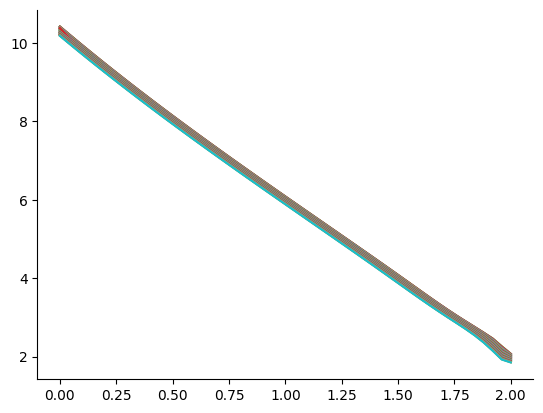

In [11]:
plt.plot(y1_grid_cap, ems)
plt.show()

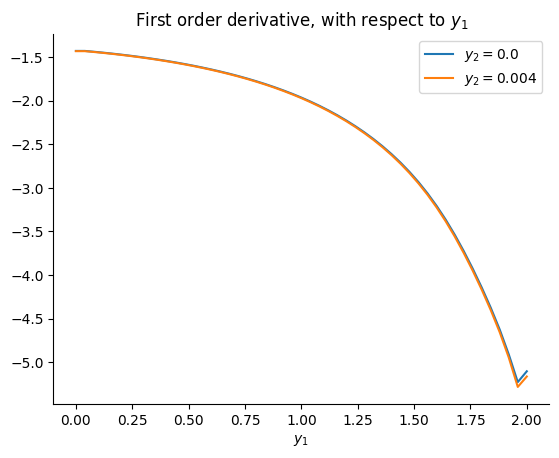

In [12]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

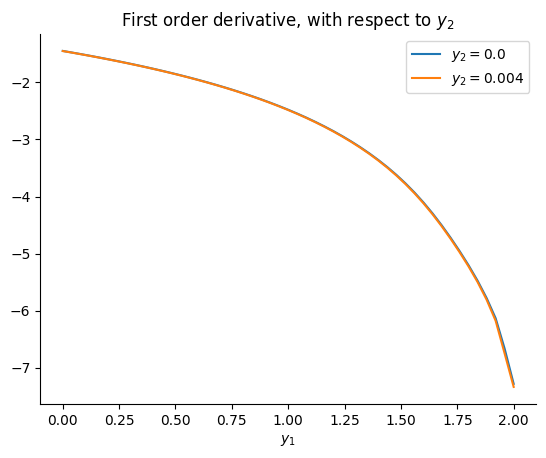

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

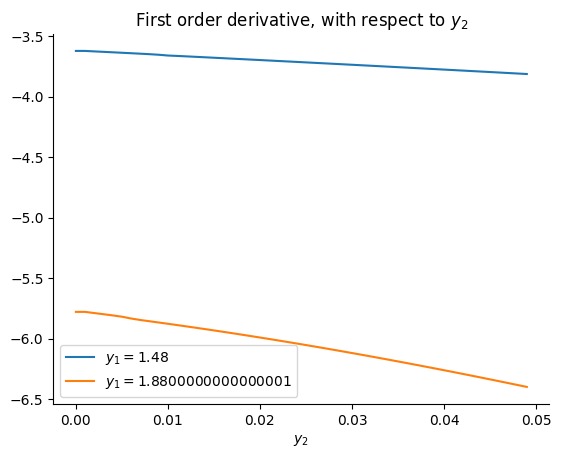

In [14]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

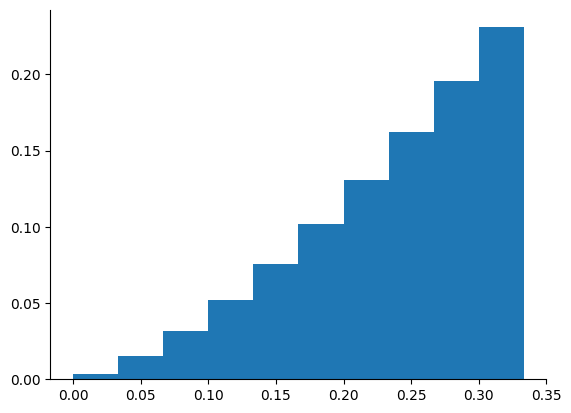

In [15]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

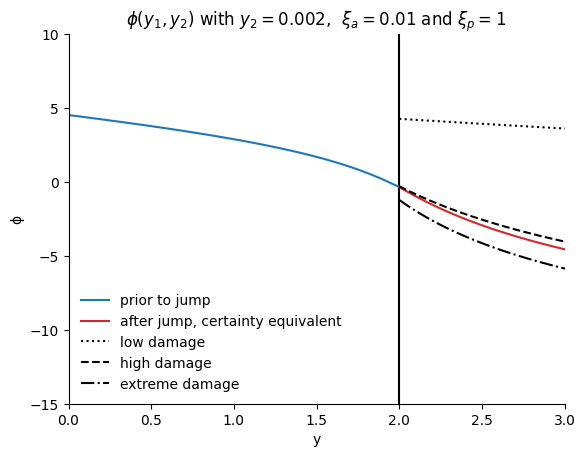

In [16]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

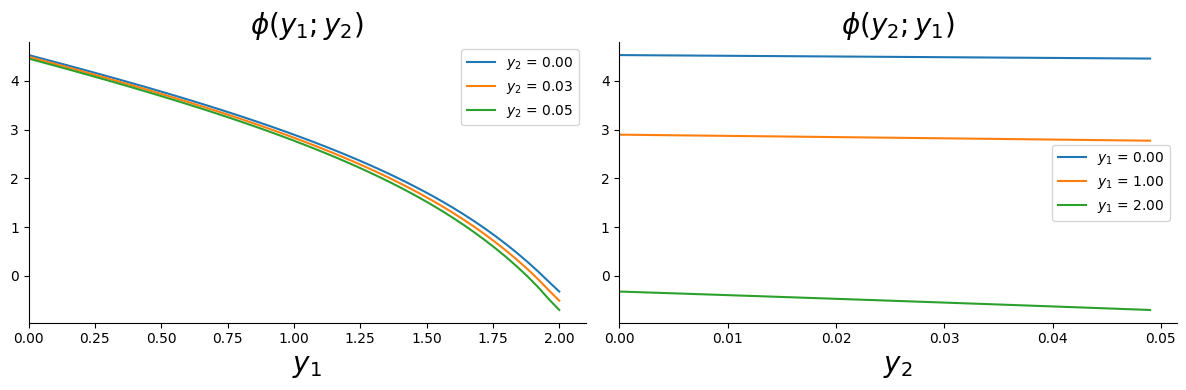

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

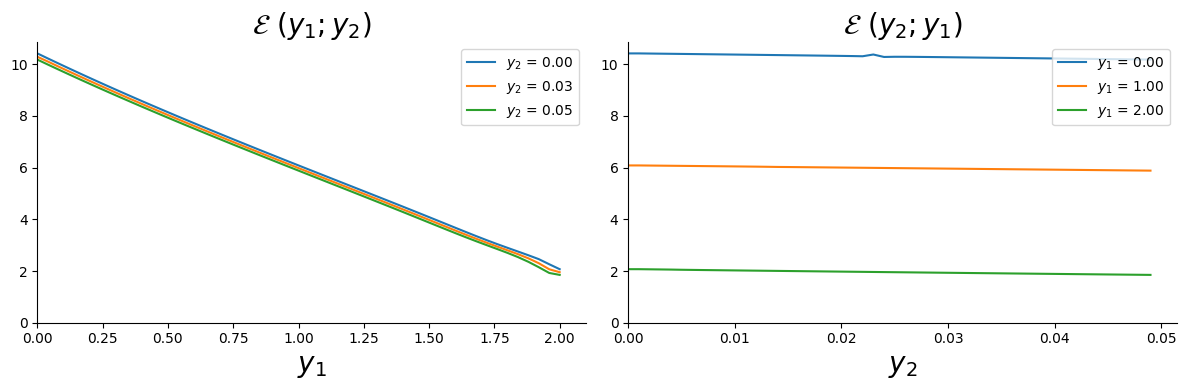

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [19]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [20]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [21]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [45]:
ems_1state = np.load("ems_1state_prejump.npy")
# ems_2state = np.load("ems_2state.npy")

In [49]:
ems_1state.shape

(201,)

In [53]:
i = 0
et_1state, yt1 = simulation_1d(np.arange(0, 2 + 0.01,  0.01), ems_1state, θ=np.mean(θ_list), y_0=1.1)
# et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

In [55]:
np.save("et_1state_old", et_1state)

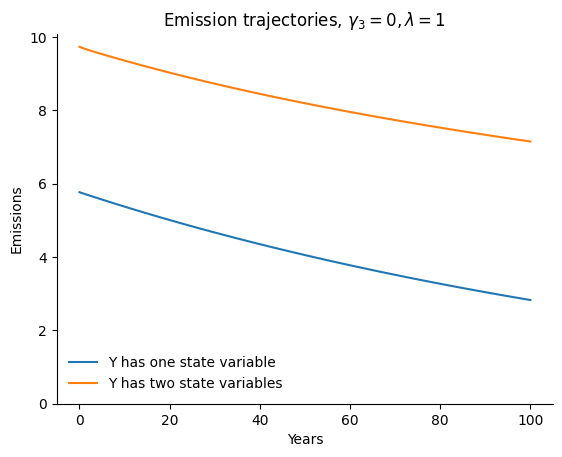

In [52]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [38]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=100
                                                 )

In [39]:
y1t_prejump

array([1.1       , 1.10737377, 1.11671375, 1.12672341, 1.13692903,
       1.14715776, 1.15734684, 1.16747373, 1.17753068, 1.18751526,
       1.19742693, 1.20726578, 1.21703205, 1.22672613, 1.23634849,
       1.24589966, 1.25538012, 1.26479038, 1.27413094, 1.28340235,
       1.29260515, 1.30173993, 1.3108072 , 1.31980747, 1.32874122,
       1.33760865, 1.34641015, 1.35514617, 1.3638172 , 1.37242364,
       1.38096588, 1.38944436, 1.39785955, 1.40621194, 1.41450198,
       1.42273013, 1.43089684, 1.43900255, 1.44704772, 1.45503248,
       1.46295713, 1.47082205, 1.47862769, 1.48637448, 1.49406272,
       1.50169278, 1.50926507, 1.51678004, 1.52423811, 1.53163974,
       1.53898537, 1.54627541, 1.55351029, 1.5606904 , 1.56781614,
       1.57488776, 1.58190563, 1.58887015, 1.59578172, 1.60264073,
       1.60944768, 1.61620315, 1.62290759, 1.62956143, 1.63616506,
       1.64271887, 1.64922348, 1.65567972, 1.66208811, 1.66844904,
       1.67476289, 1.68102999, 1.68725078, 1.69342614, 1.69955

In [40]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}_old", "wb"))

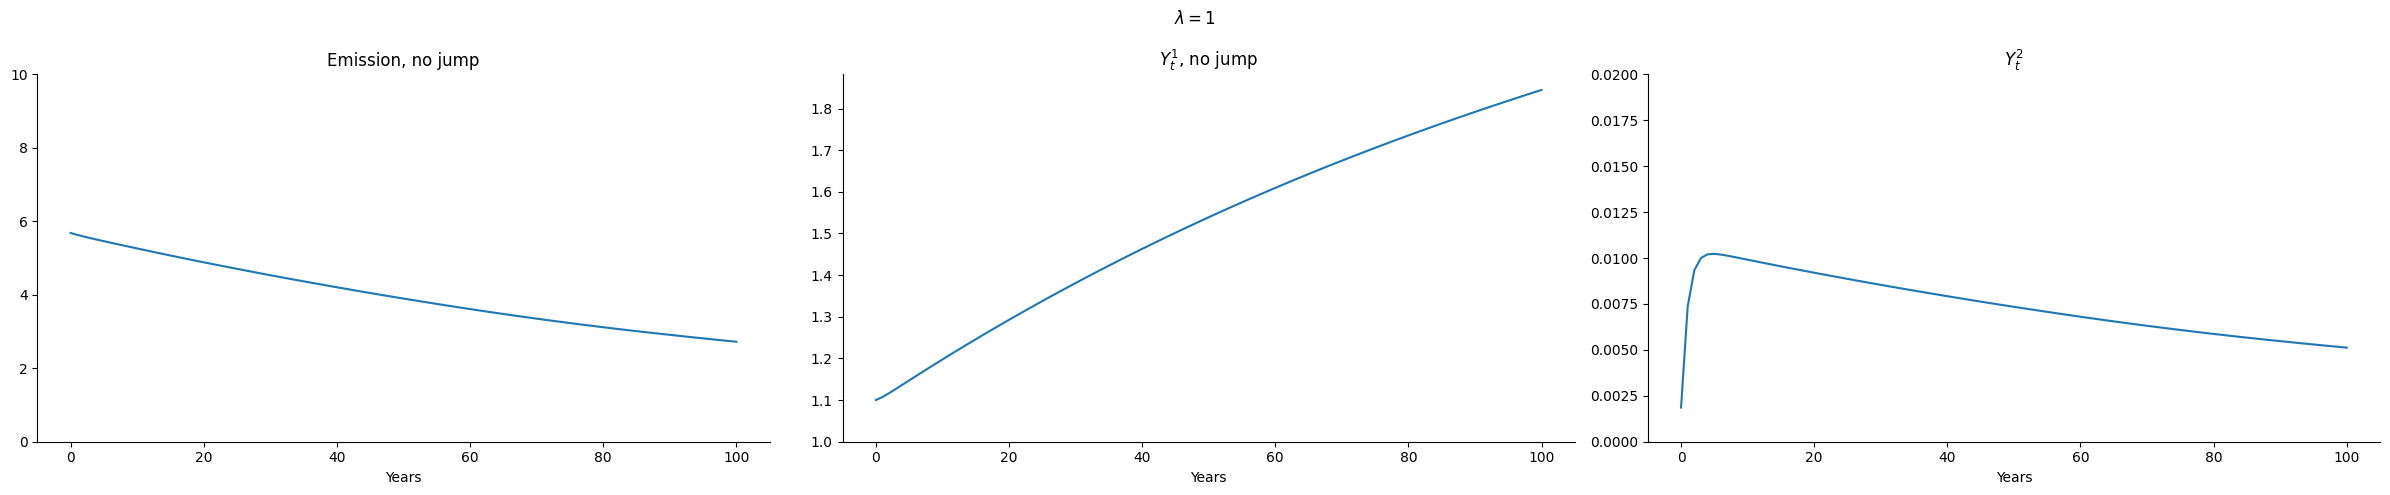

In [41]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [42]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [43]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.01022873106754136,
 0.049,
 array([1.1       , 1.10737377, 1.11671375, 1.12672341, 1.13692903,
        1.14715776, 1.15734684, 1.16747373, 1.17753068, 1.18751526,
        1.19742693, 1.20726578, 1.21703205, 1.22672613, 1.23634849,
        1.24589966, 1.25538012, 1.26479038, 1.27413094, 1.28340235,
        1.29260515, 1.30173993, 1.3108072 , 1.31980747, 1.32874122,
        1.33760865, 1.34641015, 1.35514617, 1.3638172 , 1.37242364,
        1.38096588, 1.38944436, 1.39785955, 1.40621194, 1.41450198,
        1.42273013, 1.43089684, 1.43900255, 1.44704772, 1.45503248,
        1.46295713, 1.47082205, 1.47862769, 1.48637448, 1.49406272,
        1.50169278, 1.50926507, 1.51678004, 1.52423811, 1.53163974,
        1.53898537, 1.54627541, 1.55351029, 1.5606904 , 1.56781614,
        1.57488776, 1.58190563, 1.58887015, 1.59578172, 1.60264073,
        1.60944768, 1.61620315, 1.62290759, 1.62956143, 1.63616506,
        1.64271887, 1.64922348, 1.65567972, 1.66208811, 1.66844904,
        1.67476289

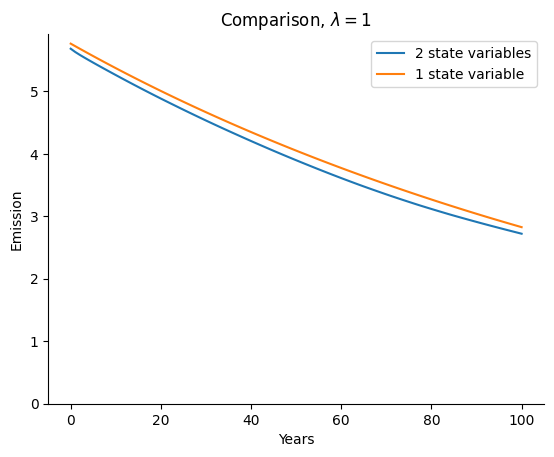

In [58]:
et_1state = np.load("et_1state_old.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [33]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [34]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [35]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=90)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

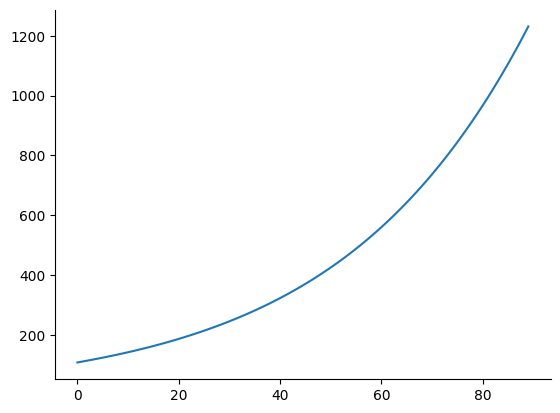

In [37]:
plt.plot(scc)
plt.show()